In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = True

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'


dataset = get_dataset(dataset_dir, 
                                     'validation', 
                                     config.batch_size, 
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     deterministic=True,
                                     NUM_DATA_WORKERS=1,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

for images,_ in dataset:
    break

env = RetinaEnv(config)




/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset(images=images)
    these_trajectories = [env.location.numpy()]
    episodic_reward = 0

    while True:
        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        random_action = -2+4*np.random.uniform(size=(config.batch_size,2))
        action = random_action

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
        these_trajectories.append(env.location.numpy())
        if env.warmup_done:         
            episodic_reward += reward
        # End this episode when `done` is True
        if done:
            break

        #prev_state = state avoid assingment by reference:
        prev_state = np.copy(state)
#         print('debug action: ', action[0])
    
    these_trajectories = np.array(these_trajectories).transpose([1,0,2])
    if ep == 0:
        leading_trajectories = these_trajectories
        leading_episodic_rewards = episodic_reward.numpy()
    else:
        win_indexes = np.argmax([leading_episodic_rewards,episodic_reward.numpy()],axis=0)
        leading_trajectories[win_indexes==1] = these_trajectories[win_indexes==1]
        leading_episodic_rewards = np.max([leading_episodic_rewards,episodic_reward.numpy()],axis=0)
    print(f"Episode * {ep}  * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("Leading reward mean", np.mean(leading_episodic_rewards))
    reward_records.append(episodic_reward.numpy().mean())


Episode * 0  * Episodic Reward is ==> -11.831565856933594
Leading reward mean -11.831566
Episode * 1  * Episodic Reward is ==> -11.512552261352539
Leading reward mean -11.067136
Episode * 2  * Episodic Reward is ==> -11.744245529174805
Leading reward mean -10.761795
Episode * 3  * Episodic Reward is ==> -11.684534072875977
Leading reward mean -10.579891
Episode * 4  * Episodic Reward is ==> -11.932499885559082
Leading reward mean -10.510048
Episode * 5  * Episodic Reward is ==> -11.701131820678711
Leading reward mean -10.394003
Episode * 6  * Episodic Reward is ==> -11.743574142456055
Leading reward mean -10.347847
Episode * 7  * Episodic Reward is ==> -11.813056945800781
Leading reward mean -10.274054
Episode * 8  * Episodic Reward is ==> -11.927083969116211
Leading reward mean -10.232446
Episode * 9  * Episodic Reward is ==> -11.842789649963379
Leading reward mean -10.20215
Episode * 10  * Episodic Reward is ==> -11.650440216064453
Leading reward mean -10.188042
Episode * 11  * Episo

Episode * 23  * Episodic Reward is ==> -11.80475902557373
Leading reward mean -9.754007
Episode * 24  * Episodic Reward is ==> -11.613947868347168
Leading reward mean -9.69133
Episode * 25  * Episodic Reward is ==> -11.71056079864502
Leading reward mean -9.572405
Episode * 26  * Episodic Reward is ==> -11.67501449584961
Leading reward mean -9.525715
Episode * 27  * Episodic Reward is ==> -11.874366760253906
Leading reward mean -9.497895
Episode * 28  * Episodic Reward is ==> -11.89651107788086
Leading reward mean -9.481062
Episode * 29  * Episodic Reward is ==> -11.917476654052734
Leading reward mean -9.471167
Episode * 30  * Episodic Reward is ==> -11.658656120300293
Leading reward mean -9.471167
Episode * 31  * Episodic Reward is ==> -11.350910186767578
Leading reward mean -9.465207
Episode * 32  * Episodic Reward is ==> -11.945420265197754
Leading reward mean -9.465207
Episode * 33  * Episodic Reward is ==> -11.264730453491211
Leading reward mean -9.405409
Episode * 34  * Episodic R

Episode * 47  * Episodic Reward is ==> -11.634682655334473
Leading reward mean -9.262563
Episode * 48  * Episodic Reward is ==> -12.2500581741333
Leading reward mean -9.262563
Episode * 49  * Episodic Reward is ==> -11.49884033203125
Leading reward mean -9.24613
Episode * 50  * Episodic Reward is ==> -12.090923309326172
Leading reward mean -9.239695
Episode * 51  * Episodic Reward is ==> -12.442327499389648
Leading reward mean -9.239695
Episode * 52  * Episodic Reward is ==> -12.042759895324707
Leading reward mean -9.239695
Episode * 53  * Episodic Reward is ==> -11.889677047729492
Leading reward mean -9.239695
Episode * 54  * Episodic Reward is ==> -11.635594367980957
Leading reward mean -9.239695
Episode * 55  * Episodic Reward is ==> -12.02183723449707
Leading reward mean -9.229594
Episode * 56  * Episodic Reward is ==> -12.028550148010254
Leading reward mean -9.229594
Episode * 57  * Episodic Reward is ==> -11.84518051147461
Leading reward mean -9.229594
Episode * 58  * Episodic Re

Episode * 71  * Episodic Reward is ==> -11.542737007141113
Leading reward mean -9.088644
Episode * 72  * Episodic Reward is ==> -11.994710922241211
Leading reward mean -9.088458
Episode * 73  * Episodic Reward is ==> -11.614213943481445
Leading reward mean -9.088458
Episode * 74  * Episodic Reward is ==> -11.82198715209961
Leading reward mean -9.088458
Episode * 75  * Episodic Reward is ==> -11.915708541870117
Leading reward mean -9.088458
Episode * 76  * Episodic Reward is ==> -12.083401679992676
Leading reward mean -9.088458
Episode * 77  * Episodic Reward is ==> -11.533782958984375
Leading reward mean -9.053489
Episode * 78  * Episodic Reward is ==> -11.912002563476562
Leading reward mean -9.053489
Episode * 79  * Episodic Reward is ==> -11.749990463256836
Leading reward mean -9.053489
Episode * 80  * Episodic Reward is ==> -11.636302947998047
Leading reward mean -9.053489
Episode * 81  * Episodic Reward is ==> -11.611278533935547
Leading reward mean -9.053489
Episode * 82  * Episod

Episode * 95  * Episodic Reward is ==> -11.758464813232422
Leading reward mean -9.006125
Episode * 96  * Episodic Reward is ==> -11.951104164123535
Leading reward mean -9.004329
Episode * 97  * Episodic Reward is ==> -11.753521919250488
Leading reward mean -8.987423
Episode * 98  * Episodic Reward is ==> -11.8968505859375
Leading reward mean -8.987423
Episode * 99  * Episodic Reward is ==> -11.801015853881836
Leading reward mean -8.987423
Episode * 100  * Episodic Reward is ==> -11.76319694519043
Leading reward mean -8.987423
Episode * 101  * Episodic Reward is ==> -11.701435089111328
Leading reward mean -8.987423
Episode * 102  * Episodic Reward is ==> -12.117076873779297
Leading reward mean -8.987423
Episode * 103  * Episodic Reward is ==> -11.456958770751953
Leading reward mean -8.978353
Episode * 104  * Episodic Reward is ==> -11.119344711303711
Leading reward mean -8.955172
Episode * 105  * Episodic Reward is ==> -12.120336532592773
Leading reward mean -8.955172
Episode * 106  * E

Episode * 119  * Episodic Reward is ==> -12.191423416137695
Leading reward mean -8.894503
Episode * 120  * Episodic Reward is ==> -11.53759765625
Leading reward mean -8.894503
Episode * 121  * Episodic Reward is ==> -11.633078575134277
Leading reward mean -8.894503
Episode * 122  * Episodic Reward is ==> -11.430200576782227
Leading reward mean -8.893759
Episode * 123  * Episodic Reward is ==> -11.58218002319336
Leading reward mean -8.893759
Episode * 124  * Episodic Reward is ==> -11.973068237304688
Leading reward mean -8.893759
Episode * 125  * Episodic Reward is ==> -11.760634422302246
Leading reward mean -8.893759
Episode * 126  * Episodic Reward is ==> -11.80274772644043
Leading reward mean -8.893759
Episode * 127  * Episodic Reward is ==> -11.729644775390625
Leading reward mean -8.893759
Episode * 128  * Episodic Reward is ==> -11.593267440795898
Leading reward mean -8.893759
Episode * 129  * Episodic Reward is ==> -11.767702102661133
Leading reward mean -8.893759
Episode * 130  *

Episode * 143  * Episodic Reward is ==> -11.423992156982422
Leading reward mean -8.87643
Episode * 144  * Episodic Reward is ==> -11.710681915283203
Leading reward mean -8.87643
Episode * 145  * Episodic Reward is ==> -11.618227005004883
Leading reward mean -8.87643
Episode * 146  * Episodic Reward is ==> -12.060693740844727
Leading reward mean -8.87643
Episode * 147  * Episodic Reward is ==> -11.374019622802734
Leading reward mean -8.87643
Episode * 148  * Episodic Reward is ==> -11.688457489013672
Leading reward mean -8.87643
Episode * 149  * Episodic Reward is ==> -11.868399620056152
Leading reward mean -8.87643
Episode * 150  * Episodic Reward is ==> -11.888042449951172
Leading reward mean -8.87643
Episode * 151  * Episodic Reward is ==> -11.661737442016602
Leading reward mean -8.836939
Episode * 152  * Episodic Reward is ==> -12.020442008972168
Leading reward mean -8.836939
Episode * 153  * Episodic Reward is ==> -11.627401351928711
Leading reward mean -8.825321
Episode * 154  * E

Episode * 167  * Episodic Reward is ==> -11.53740119934082
Leading reward mean -8.816576
Episode * 168  * Episodic Reward is ==> -11.955490112304688
Leading reward mean -8.816576
Episode * 169  * Episodic Reward is ==> -11.48974609375
Leading reward mean -8.816576
Episode * 170  * Episodic Reward is ==> -11.345586776733398
Leading reward mean -8.797597
Episode * 171  * Episodic Reward is ==> -12.031396865844727
Leading reward mean -8.797597
Episode * 172  * Episodic Reward is ==> -11.656990051269531
Leading reward mean -8.797597
Episode * 173  * Episodic Reward is ==> -12.140443801879883
Leading reward mean -8.797597
Episode * 174  * Episodic Reward is ==> -12.133996963500977
Leading reward mean -8.797597
Episode * 175  * Episodic Reward is ==> -11.342642784118652
Leading reward mean -8.782811
Episode * 176  * Episodic Reward is ==> -11.754439353942871
Leading reward mean -8.782811
Episode * 177  * Episodic Reward is ==> -12.151365280151367
Leading reward mean -8.782811
Episode * 178  

Episode * 191  * Episodic Reward is ==> -12.163215637207031
Leading reward mean -8.766466
Episode * 192  * Episodic Reward is ==> -11.08884048461914
Leading reward mean -8.736803
Episode * 193  * Episodic Reward is ==> -11.61091423034668
Leading reward mean -8.736803
Episode * 194  * Episodic Reward is ==> -11.899271011352539
Leading reward mean -8.736061
Episode * 195  * Episodic Reward is ==> -11.786760330200195
Leading reward mean -8.736061
Episode * 196  * Episodic Reward is ==> -11.747892379760742
Leading reward mean -8.736061
Episode * 197  * Episodic Reward is ==> -11.985097885131836
Leading reward mean -8.736061
Episode * 198  * Episodic Reward is ==> -11.832437515258789
Leading reward mean -8.736061
Episode * 199  * Episodic Reward is ==> -11.521369934082031
Leading reward mean -8.736061
Episode * 200  * Episodic Reward is ==> -12.052191734313965
Leading reward mean -8.736061
Episode * 201  * Episodic Reward is ==> -11.837028503417969
Leading reward mean -8.736061
Episode * 20

Episode * 215  * Episodic Reward is ==> -11.691520690917969
Leading reward mean -8.706657
Episode * 216  * Episodic Reward is ==> -11.575315475463867
Leading reward mean -8.682444
Episode * 217  * Episodic Reward is ==> -11.95738697052002
Leading reward mean -8.682444
Episode * 218  * Episodic Reward is ==> -11.94245719909668
Leading reward mean -8.682444
Episode * 219  * Episodic Reward is ==> -11.84499740600586
Leading reward mean -8.682444
Episode * 220  * Episodic Reward is ==> -11.950250625610352
Leading reward mean -8.661017
Episode * 221  * Episodic Reward is ==> -11.568818092346191
Leading reward mean -8.65463
Episode * 222  * Episodic Reward is ==> -12.067827224731445
Leading reward mean -8.65463
Episode * 223  * Episodic Reward is ==> -11.75241470336914
Leading reward mean -8.65463
Episode * 224  * Episodic Reward is ==> -11.255873680114746
Leading reward mean -8.527046
Episode * 225  * Episodic Reward is ==> -11.562394142150879
Leading reward mean -8.527046
Episode * 226  * 

Episode * 239  * Episodic Reward is ==> -11.11995792388916
Leading reward mean -8.523472
Episode * 240  * Episodic Reward is ==> -11.427974700927734
Leading reward mean -8.523472
Episode * 241  * Episodic Reward is ==> -11.641683578491211
Leading reward mean -8.523472
Episode * 242  * Episodic Reward is ==> -11.676770210266113
Leading reward mean -8.523472
Episode * 243  * Episodic Reward is ==> -11.937182426452637
Leading reward mean -8.523472
Episode * 244  * Episodic Reward is ==> -11.671758651733398
Leading reward mean -8.523472
Episode * 245  * Episodic Reward is ==> -11.712479591369629
Leading reward mean -8.523472
Episode * 246  * Episodic Reward is ==> -11.670989990234375
Leading reward mean -8.523472
Episode * 247  * Episodic Reward is ==> -12.091299057006836
Leading reward mean -8.523472
Episode * 248  * Episodic Reward is ==> -11.652107238769531
Leading reward mean -8.523472
Episode * 249  * Episodic Reward is ==> -12.12569808959961
Leading reward mean -8.523472
Episode * 25

Episode * 263  * Episodic Reward is ==> -11.736455917358398
Leading reward mean -8.485262
Episode * 264  * Episodic Reward is ==> -11.32473373413086
Leading reward mean -8.485262
Episode * 265  * Episodic Reward is ==> -11.883299827575684
Leading reward mean -8.485262
Episode * 266  * Episodic Reward is ==> -11.640836715698242
Leading reward mean -8.485262
Episode * 267  * Episodic Reward is ==> -11.636362075805664
Leading reward mean -8.482029
Episode * 268  * Episodic Reward is ==> -11.711737632751465
Leading reward mean -8.482029
Episode * 269  * Episodic Reward is ==> -12.065028190612793
Leading reward mean -8.482029
Episode * 270  * Episodic Reward is ==> -11.6915283203125
Leading reward mean -8.482029
Episode * 271  * Episodic Reward is ==> -11.806055068969727
Leading reward mean -8.482029
Episode * 272  * Episodic Reward is ==> -11.924602508544922
Leading reward mean -8.482029
Episode * 273  * Episodic Reward is ==> -11.742778778076172
Leading reward mean -8.475525
Episode * 274

Episode * 287  * Episodic Reward is ==> -11.433475494384766
Leading reward mean -8.438757
Episode * 288  * Episodic Reward is ==> -11.875237464904785
Leading reward mean -8.438757
Episode * 289  * Episodic Reward is ==> -11.7151517868042
Leading reward mean -8.438757
Episode * 290  * Episodic Reward is ==> -11.758739471435547
Leading reward mean -8.438757
Episode * 291  * Episodic Reward is ==> -11.843151092529297
Leading reward mean -8.438757
Episode * 292  * Episodic Reward is ==> -11.970430374145508
Leading reward mean -8.438757
Episode * 293  * Episodic Reward is ==> -11.756889343261719
Leading reward mean -8.438757
Episode * 294  * Episodic Reward is ==> -11.614675521850586
Leading reward mean -8.438757
Episode * 295  * Episodic Reward is ==> -12.000940322875977
Leading reward mean -8.438757
Episode * 296  * Episodic Reward is ==> -11.57041072845459
Leading reward mean -8.43556
Episode * 297  * Episodic Reward is ==> -11.413148880004883
Leading reward mean -8.43556
Episode * 298  

Episode * 311  * Episodic Reward is ==> -12.182111740112305
Leading reward mean -8.43556
Episode * 312  * Episodic Reward is ==> -11.380760192871094
Leading reward mean -8.43556
Episode * 313  * Episodic Reward is ==> -11.956930160522461
Leading reward mean -8.43556
Episode * 314  * Episodic Reward is ==> -11.906148910522461
Leading reward mean -8.43556
Episode * 315  * Episodic Reward is ==> -11.871380805969238
Leading reward mean -8.43556
Episode * 316  * Episodic Reward is ==> -11.212034225463867
Leading reward mean -8.43556
Episode * 317  * Episodic Reward is ==> -11.813140869140625
Leading reward mean -8.43556
Episode * 318  * Episodic Reward is ==> -11.543147087097168
Leading reward mean -8.43556
Episode * 319  * Episodic Reward is ==> -11.999176025390625
Leading reward mean -8.43556
Episode * 320  * Episodic Reward is ==> -11.946557998657227
Leading reward mean -8.43556
Episode * 321  * Episodic Reward is ==> -11.956857681274414
Leading reward mean -8.43556
Episode * 322  * Epis

Episode * 335  * Episodic Reward is ==> -11.578380584716797
Leading reward mean -8.425642
Episode * 336  * Episodic Reward is ==> -11.843876838684082
Leading reward mean -8.425642
Episode * 337  * Episodic Reward is ==> -11.595071792602539
Leading reward mean -8.425642
Episode * 338  * Episodic Reward is ==> -11.656076431274414
Leading reward mean -8.425642
Episode * 339  * Episodic Reward is ==> -11.571667671203613
Leading reward mean -8.425642
Episode * 340  * Episodic Reward is ==> -11.512462615966797
Leading reward mean -8.425642
Episode * 341  * Episodic Reward is ==> -11.777128219604492
Leading reward mean -8.425642
Episode * 342  * Episodic Reward is ==> -11.459196090698242
Leading reward mean -8.425642
Episode * 343  * Episodic Reward is ==> -11.46940803527832
Leading reward mean -8.425642
Episode * 344  * Episodic Reward is ==> -11.902620315551758
Leading reward mean -8.425642
Episode * 345  * Episodic Reward is ==> -11.732282638549805
Leading reward mean -8.425642
Episode * 3

Episode * 359  * Episodic Reward is ==> -11.740137100219727
Leading reward mean -8.408534
Episode * 360  * Episodic Reward is ==> -11.767268180847168
Leading reward mean -8.408534
Episode * 361  * Episodic Reward is ==> -11.480945587158203
Leading reward mean -8.408534
Episode * 362  * Episodic Reward is ==> -12.011624336242676
Leading reward mean -8.408534
Episode * 363  * Episodic Reward is ==> -11.457768440246582
Leading reward mean -8.408534
Episode * 364  * Episodic Reward is ==> -11.949155807495117
Leading reward mean -8.408534
Episode * 365  * Episodic Reward is ==> -12.152565002441406
Leading reward mean -8.408534
Episode * 366  * Episodic Reward is ==> -12.105470657348633
Leading reward mean -8.408534
Episode * 367  * Episodic Reward is ==> -11.774351119995117
Leading reward mean -8.408534
Episode * 368  * Episodic Reward is ==> -12.203478813171387
Leading reward mean -8.408534
Episode * 369  * Episodic Reward is ==> -11.154607772827148
Leading reward mean -8.408534
Episode * 

Episode * 383  * Episodic Reward is ==> -11.615300178527832
Leading reward mean -8.408534
Episode * 384  * Episodic Reward is ==> -11.518844604492188
Leading reward mean -8.408534
Episode * 385  * Episodic Reward is ==> -11.313016891479492
Leading reward mean -8.398269
Episode * 386  * Episodic Reward is ==> -12.309483528137207
Leading reward mean -8.398269
Episode * 387  * Episodic Reward is ==> -11.374601364135742
Leading reward mean -8.398269
Episode * 388  * Episodic Reward is ==> -12.04902458190918
Leading reward mean -8.398269
Episode * 389  * Episodic Reward is ==> -11.999927520751953
Leading reward mean -8.398269
Episode * 390  * Episodic Reward is ==> -11.536040306091309
Leading reward mean -8.398269
Episode * 391  * Episodic Reward is ==> -11.714688301086426
Leading reward mean -8.398269
Episode * 392  * Episodic Reward is ==> -11.782068252563477
Leading reward mean -8.398269
Episode * 393  * Episodic Reward is ==> -11.471588134765625
Leading reward mean -8.398269
Episode * 3

Episode * 407  * Episodic Reward is ==> -11.874503135681152
Leading reward mean -8.394129
Episode * 408  * Episodic Reward is ==> -11.747421264648438
Leading reward mean -8.394129
Episode * 409  * Episodic Reward is ==> -11.719261169433594
Leading reward mean -8.394129
Episode * 410  * Episodic Reward is ==> -11.519290924072266
Leading reward mean -8.394129
Episode * 411  * Episodic Reward is ==> -11.595630645751953
Leading reward mean -8.394129
Episode * 412  * Episodic Reward is ==> -11.72741985321045
Leading reward mean -8.394129
Episode * 413  * Episodic Reward is ==> -11.477952003479004
Leading reward mean -8.394129
Episode * 414  * Episodic Reward is ==> -11.959038734436035
Leading reward mean -8.394129
Episode * 415  * Episodic Reward is ==> -11.684137344360352
Leading reward mean -8.394129
Episode * 416  * Episodic Reward is ==> -11.604538917541504
Leading reward mean -8.394129
Episode * 417  * Episodic Reward is ==> -11.544498443603516
Leading reward mean -8.394129
Episode * 4

Episode * 431  * Episodic Reward is ==> -11.554704666137695
Leading reward mean -8.390219
Episode * 432  * Episodic Reward is ==> -11.660021781921387
Leading reward mean -8.390219
Episode * 433  * Episodic Reward is ==> -11.775781631469727
Leading reward mean -8.390219
Episode * 434  * Episodic Reward is ==> -11.56928825378418
Leading reward mean -8.390219
Episode * 435  * Episodic Reward is ==> -11.707752227783203
Leading reward mean -8.390219
Episode * 436  * Episodic Reward is ==> -11.688604354858398
Leading reward mean -8.390219
Episode * 437  * Episodic Reward is ==> -11.623234748840332
Leading reward mean -8.390219
Episode * 438  * Episodic Reward is ==> -11.6002197265625
Leading reward mean -8.390219
Episode * 439  * Episodic Reward is ==> -12.099103927612305
Leading reward mean -8.390219
Episode * 440  * Episodic Reward is ==> -11.091146469116211
Leading reward mean -8.390219
Episode * 441  * Episodic Reward is ==> -11.391975402832031
Leading reward mean -8.390219
Episode * 442

Episode * 455  * Episodic Reward is ==> -11.771358489990234
Leading reward mean -8.390219
Episode * 456  * Episodic Reward is ==> -11.953415870666504
Leading reward mean -8.390219
Episode * 457  * Episodic Reward is ==> -11.650337219238281
Leading reward mean -8.390219
Episode * 458  * Episodic Reward is ==> -12.060359954833984
Leading reward mean -8.390219
Episode * 459  * Episodic Reward is ==> -11.564216613769531
Leading reward mean -8.390219
Episode * 460  * Episodic Reward is ==> -11.89710521697998
Leading reward mean -8.390219
Episode * 461  * Episodic Reward is ==> -12.034379005432129
Leading reward mean -8.390219
Episode * 462  * Episodic Reward is ==> -11.819978713989258
Leading reward mean -8.390219
Episode * 463  * Episodic Reward is ==> -11.765975952148438
Leading reward mean -8.390219
Episode * 464  * Episodic Reward is ==> -11.909795761108398
Leading reward mean -8.390219
Episode * 465  * Episodic Reward is ==> -11.406560897827148
Leading reward mean -8.390219
Episode * 4

Episode * 479  * Episodic Reward is ==> -12.113838195800781
Leading reward mean -8.390219
Episode * 480  * Episodic Reward is ==> -11.912549018859863
Leading reward mean -8.390219
Episode * 481  * Episodic Reward is ==> -12.25249195098877
Leading reward mean -8.390219
Episode * 482  * Episodic Reward is ==> -12.446796417236328
Leading reward mean -8.390219
Episode * 483  * Episodic Reward is ==> -11.744712829589844
Leading reward mean -8.390219
Episode * 484  * Episodic Reward is ==> -11.488740921020508
Leading reward mean -8.390219
Episode * 485  * Episodic Reward is ==> -11.46218490600586
Leading reward mean -8.390219
Episode * 486  * Episodic Reward is ==> -11.973068237304688
Leading reward mean -8.390219
Episode * 487  * Episodic Reward is ==> -11.619254112243652
Leading reward mean -8.390219
Episode * 488  * Episodic Reward is ==> -12.316110610961914
Leading reward mean -8.390219
Episode * 489  * Episodic Reward is ==> -12.28903865814209
Leading reward mean -8.390219
Episode * 490

Episode * 503  * Episodic Reward is ==> -11.546133995056152
Leading reward mean -8.382403
Episode * 504  * Episodic Reward is ==> -11.894771575927734
Leading reward mean -8.382403
Episode * 505  * Episodic Reward is ==> -11.941654205322266
Leading reward mean -8.382403
Episode * 506  * Episodic Reward is ==> -11.840320587158203
Leading reward mean -8.382403
Episode * 507  * Episodic Reward is ==> -11.681285858154297
Leading reward mean -8.382403
Episode * 508  * Episodic Reward is ==> -12.142148971557617
Leading reward mean -8.382403
Episode * 509  * Episodic Reward is ==> -12.180438995361328
Leading reward mean -8.382403
Episode * 510  * Episodic Reward is ==> -11.864166259765625
Leading reward mean -8.382403
Episode * 511  * Episodic Reward is ==> -11.651248931884766
Leading reward mean -8.382403
Episode * 512  * Episodic Reward is ==> -11.940958976745605
Leading reward mean -8.382403
Episode * 513  * Episodic Reward is ==> -11.575888633728027
Leading reward mean -8.382403
Episode * 

Episode * 527  * Episodic Reward is ==> -11.882320404052734
Leading reward mean -8.381233
Episode * 528  * Episodic Reward is ==> -11.806486129760742
Leading reward mean -8.381233
Episode * 529  * Episodic Reward is ==> -11.655732154846191
Leading reward mean -8.381233
Episode * 530  * Episodic Reward is ==> -11.605384826660156
Leading reward mean -8.381233
Episode * 531  * Episodic Reward is ==> -11.78203010559082
Leading reward mean -8.373288
Episode * 532  * Episodic Reward is ==> -11.682058334350586
Leading reward mean -8.373288
Episode * 533  * Episodic Reward is ==> -11.895723342895508
Leading reward mean -8.373288
Episode * 534  * Episodic Reward is ==> -11.55518627166748
Leading reward mean -8.373288
Episode * 535  * Episodic Reward is ==> -11.562860488891602
Leading reward mean -8.373288
Episode * 536  * Episodic Reward is ==> -11.89232063293457
Leading reward mean -8.373288
Episode * 537  * Episodic Reward is ==> -11.549999237060547
Leading reward mean -8.363257
Episode * 538

Episode * 551  * Episodic Reward is ==> -11.491304397583008
Leading reward mean -8.361799
Episode * 552  * Episodic Reward is ==> -11.997981071472168
Leading reward mean -8.361799
Episode * 553  * Episodic Reward is ==> -12.229148864746094
Leading reward mean -8.361799
Episode * 554  * Episodic Reward is ==> -11.650972366333008
Leading reward mean -8.361799
Episode * 555  * Episodic Reward is ==> -11.154279708862305
Leading reward mean -8.361799
Episode * 556  * Episodic Reward is ==> -11.121406555175781
Leading reward mean -8.361799
Episode * 557  * Episodic Reward is ==> -11.731590270996094
Leading reward mean -8.361799
Episode * 558  * Episodic Reward is ==> -11.964066505432129
Leading reward mean -8.361799
Episode * 559  * Episodic Reward is ==> -11.895452499389648
Leading reward mean -8.361799
Episode * 560  * Episodic Reward is ==> -11.851305961608887
Leading reward mean -8.361799
Episode * 561  * Episodic Reward is ==> -11.982970237731934
Leading reward mean -8.361799
Episode * 

Episode * 575  * Episodic Reward is ==> -11.471171379089355
Leading reward mean -8.359664
Episode * 576  * Episodic Reward is ==> -11.929542541503906
Leading reward mean -8.359664
Episode * 577  * Episodic Reward is ==> -12.042566299438477
Leading reward mean -8.359664
Episode * 578  * Episodic Reward is ==> -11.283987045288086
Leading reward mean -8.359664
Episode * 579  * Episodic Reward is ==> -11.637306213378906
Leading reward mean -8.359664
Episode * 580  * Episodic Reward is ==> -11.446222305297852
Leading reward mean -8.359664
Episode * 581  * Episodic Reward is ==> -11.737808227539062
Leading reward mean -8.359664
Episode * 582  * Episodic Reward is ==> -11.535049438476562
Leading reward mean -8.359664
Episode * 583  * Episodic Reward is ==> -11.946172714233398
Leading reward mean -8.359664
Episode * 584  * Episodic Reward is ==> -11.555548667907715
Leading reward mean -8.359664
Episode * 585  * Episodic Reward is ==> -12.063735961914062
Leading reward mean -8.359664
Episode * 

Episode * 599  * Episodic Reward is ==> -11.848288536071777
Leading reward mean -8.357153
Episode * 600  * Episodic Reward is ==> -11.358924865722656
Leading reward mean -8.357153
Episode * 601  * Episodic Reward is ==> -11.90152645111084
Leading reward mean -8.357153
Episode * 602  * Episodic Reward is ==> -11.553858757019043
Leading reward mean -8.357153
Episode * 603  * Episodic Reward is ==> -11.606255531311035
Leading reward mean -8.357153
Episode * 604  * Episodic Reward is ==> -11.639129638671875
Leading reward mean -8.357153
Episode * 605  * Episodic Reward is ==> -11.98813533782959
Leading reward mean -8.357153
Episode * 606  * Episodic Reward is ==> -11.492095947265625
Leading reward mean -8.357153
Episode * 607  * Episodic Reward is ==> -12.042596817016602
Leading reward mean -8.357153
Episode * 608  * Episodic Reward is ==> -11.118185043334961
Leading reward mean -8.357153
Episode * 609  * Episodic Reward is ==> -11.96670150756836
Leading reward mean -8.357153
Episode * 610

Episode * 623  * Episodic Reward is ==> -11.821113586425781
Leading reward mean -8.35316
Episode * 624  * Episodic Reward is ==> -11.902137756347656
Leading reward mean -8.35316
Episode * 625  * Episodic Reward is ==> -11.427452087402344
Leading reward mean -8.35316
Episode * 626  * Episodic Reward is ==> -11.825227737426758
Leading reward mean -8.35316
Episode * 627  * Episodic Reward is ==> -11.391027450561523
Leading reward mean -8.35316
Episode * 628  * Episodic Reward is ==> -11.867355346679688
Leading reward mean -8.35316
Episode * 629  * Episodic Reward is ==> -11.750038146972656
Leading reward mean -8.35316
Episode * 630  * Episodic Reward is ==> -11.408287048339844
Leading reward mean -8.35316
Episode * 631  * Episodic Reward is ==> -11.345192909240723
Leading reward mean -8.35316
Episode * 632  * Episodic Reward is ==> -11.892341613769531
Leading reward mean -8.35316
Episode * 633  * Episodic Reward is ==> -11.318674087524414
Leading reward mean -8.35316
Episode * 634  * Epis

Episode * 647  * Episodic Reward is ==> -11.645142555236816
Leading reward mean -8.35316
Episode * 648  * Episodic Reward is ==> -11.647848129272461
Leading reward mean -8.35316
Episode * 649  * Episodic Reward is ==> -11.84952163696289
Leading reward mean -8.35316
Episode * 650  * Episodic Reward is ==> -11.433080673217773
Leading reward mean -8.35316
Episode * 651  * Episodic Reward is ==> -11.625471115112305
Leading reward mean -8.35316
Episode * 652  * Episodic Reward is ==> -11.728788375854492
Leading reward mean -8.35316
Episode * 653  * Episodic Reward is ==> -12.101936340332031
Leading reward mean -8.35316
Episode * 654  * Episodic Reward is ==> -11.615692138671875
Leading reward mean -8.35316
Episode * 655  * Episodic Reward is ==> -11.035615921020508
Leading reward mean -8.35316
Episode * 656  * Episodic Reward is ==> -11.855585098266602
Leading reward mean -8.35316
Episode * 657  * Episodic Reward is ==> -12.12740707397461
Leading reward mean -8.35316
Episode * 658  * Episod

Episode * 671  * Episodic Reward is ==> -12.067898750305176
Leading reward mean -8.340337
Episode * 672  * Episodic Reward is ==> -11.497960090637207
Leading reward mean -8.340337
Episode * 673  * Episodic Reward is ==> -11.479413032531738
Leading reward mean -8.340337
Episode * 674  * Episodic Reward is ==> -11.564033508300781
Leading reward mean -8.340337
Episode * 675  * Episodic Reward is ==> -11.916250228881836
Leading reward mean -8.340337
Episode * 676  * Episodic Reward is ==> -11.636270523071289
Leading reward mean -8.340337
Episode * 677  * Episodic Reward is ==> -11.610275268554688
Leading reward mean -8.340337
Episode * 678  * Episodic Reward is ==> -12.171432495117188
Leading reward mean -8.340337
Episode * 679  * Episodic Reward is ==> -12.327381134033203
Leading reward mean -8.340337
Episode * 680  * Episodic Reward is ==> -12.262626647949219
Leading reward mean -8.340337
Episode * 681  * Episodic Reward is ==> -11.571355819702148
Leading reward mean -8.340337
Episode * 

Episode * 695  * Episodic Reward is ==> -11.495044708251953
Leading reward mean -8.340337
Episode * 696  * Episodic Reward is ==> -11.648395538330078
Leading reward mean -8.340337
Episode * 697  * Episodic Reward is ==> -11.562738418579102
Leading reward mean -8.340337
Episode * 698  * Episodic Reward is ==> -11.79468822479248
Leading reward mean -8.340337
Episode * 699  * Episodic Reward is ==> -11.866249084472656
Leading reward mean -8.340337
Episode * 700  * Episodic Reward is ==> -11.547200202941895
Leading reward mean -8.340337
Episode * 701  * Episodic Reward is ==> -11.397254943847656
Leading reward mean -8.340337
Episode * 702  * Episodic Reward is ==> -11.785174369812012
Leading reward mean -8.340337
Episode * 703  * Episodic Reward is ==> -11.41338062286377
Leading reward mean -8.340337
Episode * 704  * Episodic Reward is ==> -12.117208480834961
Leading reward mean -8.340337
Episode * 705  * Episodic Reward is ==> -11.753179550170898
Leading reward mean -8.340337
Episode * 70

Episode * 719  * Episodic Reward is ==> -11.710025787353516
Leading reward mean -8.340337
Episode * 720  * Episodic Reward is ==> -11.924285888671875
Leading reward mean -8.340337
Episode * 721  * Episodic Reward is ==> -11.665628433227539
Leading reward mean -8.340337
Episode * 722  * Episodic Reward is ==> -11.661633491516113
Leading reward mean -8.339207
Episode * 723  * Episodic Reward is ==> -11.528603553771973
Leading reward mean -8.339207
Episode * 724  * Episodic Reward is ==> -11.574935913085938
Leading reward mean -8.339207
Episode * 725  * Episodic Reward is ==> -11.882773399353027
Leading reward mean -8.339207
Episode * 726  * Episodic Reward is ==> -11.485027313232422
Leading reward mean -8.339207
Episode * 727  * Episodic Reward is ==> -11.737777709960938
Leading reward mean -8.339207
Episode * 728  * Episodic Reward is ==> -11.894813537597656
Leading reward mean -8.339207
Episode * 729  * Episodic Reward is ==> -11.802711486816406
Leading reward mean -8.339207
Episode * 

Episode * 743  * Episodic Reward is ==> -11.787358283996582
Leading reward mean -8.339207
Episode * 744  * Episodic Reward is ==> -11.736440658569336
Leading reward mean -8.339207
Episode * 745  * Episodic Reward is ==> -11.329448699951172
Leading reward mean -8.339207
Episode * 746  * Episodic Reward is ==> -11.753716468811035
Leading reward mean -8.339207
Episode * 747  * Episodic Reward is ==> -11.275712966918945
Leading reward mean -8.339207
Episode * 748  * Episodic Reward is ==> -11.643253326416016
Leading reward mean -8.339207
Episode * 749  * Episodic Reward is ==> -11.673243522644043
Leading reward mean -8.339207
Episode * 750  * Episodic Reward is ==> -11.664243698120117
Leading reward mean -8.339207
Episode * 751  * Episodic Reward is ==> -11.543137550354004
Leading reward mean -8.339207
Episode * 752  * Episodic Reward is ==> -11.371929168701172
Leading reward mean -8.339207
Episode * 753  * Episodic Reward is ==> -11.587286949157715
Leading reward mean -8.339207
Episode * 

Episode * 767  * Episodic Reward is ==> -11.629919052124023
Leading reward mean -8.335181
Episode * 768  * Episodic Reward is ==> -12.011296272277832
Leading reward mean -8.335181
Episode * 769  * Episodic Reward is ==> -11.998934745788574
Leading reward mean -8.335181
Episode * 770  * Episodic Reward is ==> -11.812070846557617
Leading reward mean -8.335181
Episode * 771  * Episodic Reward is ==> -12.038602828979492
Leading reward mean -8.335181
Episode * 772  * Episodic Reward is ==> -12.288277626037598
Leading reward mean -8.335181
Episode * 773  * Episodic Reward is ==> -11.874845504760742
Leading reward mean -8.335181
Episode * 774  * Episodic Reward is ==> -11.680885314941406
Leading reward mean -8.335181
Episode * 775  * Episodic Reward is ==> -11.82050895690918
Leading reward mean -8.335181
Episode * 776  * Episodic Reward is ==> -11.453394889831543
Leading reward mean -8.335181
Episode * 777  * Episodic Reward is ==> -12.044317245483398
Leading reward mean -8.335181
Episode * 7

Episode * 791  * Episodic Reward is ==> -11.37198257446289
Leading reward mean -8.333582
Episode * 792  * Episodic Reward is ==> -11.457683563232422
Leading reward mean -8.333582
Episode * 793  * Episodic Reward is ==> -11.996962547302246
Leading reward mean -8.333582
Episode * 794  * Episodic Reward is ==> -11.410825729370117
Leading reward mean -8.333582
Episode * 795  * Episodic Reward is ==> -11.595884323120117
Leading reward mean -8.333582
Episode * 796  * Episodic Reward is ==> -11.674026489257812
Leading reward mean -8.333582
Episode * 797  * Episodic Reward is ==> -11.829221725463867
Leading reward mean -8.333582
Episode * 798  * Episodic Reward is ==> -11.741218566894531
Leading reward mean -8.333582
Episode * 799  * Episodic Reward is ==> -11.740961074829102
Leading reward mean -8.329644
Episode * 800  * Episodic Reward is ==> -11.751035690307617
Leading reward mean -8.329644
Episode * 801  * Episodic Reward is ==> -11.858136177062988
Leading reward mean -8.329644
Episode * 8

Episode * 815  * Episodic Reward is ==> -12.006092071533203
Leading reward mean -8.322966
Episode * 816  * Episodic Reward is ==> -12.00684642791748
Leading reward mean -8.322966
Episode * 817  * Episodic Reward is ==> -11.683633804321289
Leading reward mean -8.322966
Episode * 818  * Episodic Reward is ==> -12.030224800109863
Leading reward mean -8.322966
Episode * 819  * Episodic Reward is ==> -11.793113708496094
Leading reward mean -8.322966
Episode * 820  * Episodic Reward is ==> -11.788633346557617
Leading reward mean -8.322966
Episode * 821  * Episodic Reward is ==> -11.453792572021484
Leading reward mean -8.322966
Episode * 822  * Episodic Reward is ==> -11.700657844543457
Leading reward mean -8.322966
Episode * 823  * Episodic Reward is ==> -11.612017631530762
Leading reward mean -8.322966
Episode * 824  * Episodic Reward is ==> -11.518621444702148
Leading reward mean -8.322966
Episode * 825  * Episodic Reward is ==> -11.626903533935547
Leading reward mean -8.322966
Episode * 8

Episode * 839  * Episodic Reward is ==> -11.945627212524414
Leading reward mean -8.315802
Episode * 840  * Episodic Reward is ==> -11.759937286376953
Leading reward mean -8.315802
Episode * 841  * Episodic Reward is ==> -12.0850191116333
Leading reward mean -8.315802
Episode * 842  * Episodic Reward is ==> -11.821569442749023
Leading reward mean -8.315802
Episode * 843  * Episodic Reward is ==> -12.21599006652832
Leading reward mean -8.315802
Episode * 844  * Episodic Reward is ==> -11.760513305664062
Leading reward mean -8.315802
Episode * 845  * Episodic Reward is ==> -11.684545516967773
Leading reward mean -8.315802
Episode * 846  * Episodic Reward is ==> -12.118513107299805
Leading reward mean -8.315802
Episode * 847  * Episodic Reward is ==> -11.394234657287598
Leading reward mean -8.315802
Episode * 848  * Episodic Reward is ==> -11.953086853027344
Leading reward mean -8.315802
Episode * 849  * Episodic Reward is ==> -11.311555862426758
Leading reward mean -8.315802
Episode * 850

Episode * 863  * Episodic Reward is ==> -11.82427978515625
Leading reward mean -8.315802
Episode * 864  * Episodic Reward is ==> -11.659183502197266
Leading reward mean -8.315802
Episode * 865  * Episodic Reward is ==> -11.726470947265625
Leading reward mean -8.315802
Episode * 866  * Episodic Reward is ==> -11.76639175415039
Leading reward mean -8.315802
Episode * 867  * Episodic Reward is ==> -11.878192901611328
Leading reward mean -8.315802
Episode * 868  * Episodic Reward is ==> -11.975282669067383
Leading reward mean -8.315802
Episode * 869  * Episodic Reward is ==> -11.961949348449707
Leading reward mean -8.315802
Episode * 870  * Episodic Reward is ==> -11.738365173339844
Leading reward mean -8.315802
Episode * 871  * Episodic Reward is ==> -11.937562942504883
Leading reward mean -8.315802
Episode * 872  * Episodic Reward is ==> -11.719982147216797
Leading reward mean -8.315802
Episode * 873  * Episodic Reward is ==> -11.212767601013184
Leading reward mean -8.315802
Episode * 87

Episode * 887  * Episodic Reward is ==> -12.196372032165527
Leading reward mean -8.313757
Episode * 888  * Episodic Reward is ==> -11.981782913208008
Leading reward mean -8.313757
Episode * 889  * Episodic Reward is ==> -11.750317573547363
Leading reward mean -8.313757
Episode * 890  * Episodic Reward is ==> -11.285090446472168
Leading reward mean -8.313757
Episode * 891  * Episodic Reward is ==> -11.250125885009766
Leading reward mean -8.313757
Episode * 892  * Episodic Reward is ==> -11.811381340026855
Leading reward mean -8.313757
Episode * 893  * Episodic Reward is ==> -11.721305847167969
Leading reward mean -8.313757
Episode * 894  * Episodic Reward is ==> -11.6650390625
Leading reward mean -8.308452
Episode * 895  * Episodic Reward is ==> -11.854936599731445
Leading reward mean -8.308452
Episode * 896  * Episodic Reward is ==> -11.541166305541992
Leading reward mean -8.308452
Episode * 897  * Episodic Reward is ==> -11.811222076416016
Leading reward mean -8.308452
Episode * 898  

Episode * 911  * Episodic Reward is ==> -12.040777206420898
Leading reward mean -8.295333
Episode * 912  * Episodic Reward is ==> -11.52714729309082
Leading reward mean -8.295333
Episode * 913  * Episodic Reward is ==> -11.844842910766602
Leading reward mean -8.295333
Episode * 914  * Episodic Reward is ==> -11.545516014099121
Leading reward mean -8.295333
Episode * 915  * Episodic Reward is ==> -11.587199211120605
Leading reward mean -8.295333
Episode * 916  * Episodic Reward is ==> -11.332326889038086
Leading reward mean -8.295333
Episode * 917  * Episodic Reward is ==> -11.981954574584961
Leading reward mean -8.295333
Episode * 918  * Episodic Reward is ==> -11.380474090576172
Leading reward mean -8.295333
Episode * 919  * Episodic Reward is ==> -12.016149520874023
Leading reward mean -8.295333
Episode * 920  * Episodic Reward is ==> -11.452954292297363
Leading reward mean -8.295333
Episode * 921  * Episodic Reward is ==> -11.81994915008545
Leading reward mean -8.295333
Episode * 92

Episode * 935  * Episodic Reward is ==> -11.865148544311523
Leading reward mean -8.295333
Episode * 936  * Episodic Reward is ==> -11.803634643554688
Leading reward mean -8.295333
Episode * 937  * Episodic Reward is ==> -11.718624114990234
Leading reward mean -8.295333
Episode * 938  * Episodic Reward is ==> -11.907670974731445
Leading reward mean -8.295333
Episode * 939  * Episodic Reward is ==> -11.344242095947266
Leading reward mean -8.295333
Episode * 940  * Episodic Reward is ==> -11.511669158935547
Leading reward mean -8.295333
Episode * 941  * Episodic Reward is ==> -11.94645881652832
Leading reward mean -8.295333
Episode * 942  * Episodic Reward is ==> -11.3727388381958
Leading reward mean -8.295333
Episode * 943  * Episodic Reward is ==> -11.903708457946777
Leading reward mean -8.295333
Episode * 944  * Episodic Reward is ==> -11.850785255432129
Leading reward mean -8.295333
Episode * 945  * Episodic Reward is ==> -11.512566566467285
Leading reward mean -8.295333
Episode * 946

Episode * 959  * Episodic Reward is ==> -11.758069038391113
Leading reward mean -8.295333
Episode * 960  * Episodic Reward is ==> -11.949581146240234
Leading reward mean -8.295333
Episode * 961  * Episodic Reward is ==> -12.167439460754395
Leading reward mean -8.295333
Episode * 962  * Episodic Reward is ==> -11.714958190917969
Leading reward mean -8.295333
Episode * 963  * Episodic Reward is ==> -12.173725128173828
Leading reward mean -8.295333
Episode * 964  * Episodic Reward is ==> -12.312015533447266
Leading reward mean -8.295333
Episode * 965  * Episodic Reward is ==> -11.578641891479492
Leading reward mean -8.295333
Episode * 966  * Episodic Reward is ==> -11.949199676513672
Leading reward mean -8.295333
Episode * 967  * Episodic Reward is ==> -11.928323745727539
Leading reward mean -8.295333
Episode * 968  * Episodic Reward is ==> -11.974674224853516
Leading reward mean -8.293203
Episode * 969  * Episodic Reward is ==> -11.842297554016113
Leading reward mean -8.293203
Episode * 

Episode * 983  * Episodic Reward is ==> -12.055112838745117
Leading reward mean -8.293203
Episode * 984  * Episodic Reward is ==> -11.630803108215332
Leading reward mean -8.293203
Episode * 985  * Episodic Reward is ==> -11.835750579833984
Leading reward mean -8.293203
Episode * 986  * Episodic Reward is ==> -11.727716445922852
Leading reward mean -8.293203
Episode * 987  * Episodic Reward is ==> -12.073355674743652
Leading reward mean -8.293203
Episode * 988  * Episodic Reward is ==> -11.797805786132812
Leading reward mean -8.293203
Episode * 989  * Episodic Reward is ==> -11.630963325500488
Leading reward mean -8.293203
Episode * 990  * Episodic Reward is ==> -11.571551322937012
Leading reward mean -8.293203
Episode * 991  * Episodic Reward is ==> -12.00674057006836
Leading reward mean -8.293203
Episode * 992  * Episodic Reward is ==> -11.605998992919922
Leading reward mean -8.293203
Episode * 993  * Episodic Reward is ==> -11.518535614013672
Leading reward mean -8.293203
Episode * 9

Episode * 1007  * Episodic Reward is ==> -12.11083984375
Leading reward mean -8.293203
Episode * 1008  * Episodic Reward is ==> -11.31428337097168
Leading reward mean -8.293203
Episode * 1009  * Episodic Reward is ==> -11.933456420898438
Leading reward mean -8.293203
Episode * 1010  * Episodic Reward is ==> -11.697994232177734
Leading reward mean -8.293203
Episode * 1011  * Episodic Reward is ==> -12.097442626953125
Leading reward mean -8.293203
Episode * 1012  * Episodic Reward is ==> -11.783126831054688
Leading reward mean -8.293203
Episode * 1013  * Episodic Reward is ==> -11.278623580932617
Leading reward mean -8.293203
Episode * 1014  * Episodic Reward is ==> -12.07188892364502
Leading reward mean -8.293203
Episode * 1015  * Episodic Reward is ==> -12.104167938232422
Leading reward mean -8.293203
Episode * 1016  * Episodic Reward is ==> -11.48369026184082
Leading reward mean -8.293203
Episode * 1017  * Episodic Reward is ==> -11.440287590026855
Leading reward mean -8.293203
Episod

Episode * 1031  * Episodic Reward is ==> -11.76646614074707
Leading reward mean -8.293203
Episode * 1032  * Episodic Reward is ==> -11.516918182373047
Leading reward mean -8.293203
Episode * 1033  * Episodic Reward is ==> -11.609638214111328
Leading reward mean -8.293203
Episode * 1034  * Episodic Reward is ==> -11.810522079467773
Leading reward mean -8.293203
Episode * 1035  * Episodic Reward is ==> -12.023305892944336
Leading reward mean -8.293203
Episode * 1036  * Episodic Reward is ==> -11.722997665405273
Leading reward mean -8.293203
Episode * 1037  * Episodic Reward is ==> -11.867555618286133
Leading reward mean -8.293203
Episode * 1038  * Episodic Reward is ==> -11.904989242553711
Leading reward mean -8.293203
Episode * 1039  * Episodic Reward is ==> -11.349735260009766
Leading reward mean -8.293203
Episode * 1040  * Episodic Reward is ==> -11.668325424194336
Leading reward mean -8.293203
Episode * 1041  * Episodic Reward is ==> -12.363537788391113
Leading reward mean -8.293203


Episode * 1055  * Episodic Reward is ==> -11.772882461547852
Leading reward mean -8.293203
Episode * 1056  * Episodic Reward is ==> -11.651708602905273
Leading reward mean -8.293203
Episode * 1057  * Episodic Reward is ==> -11.776901245117188
Leading reward mean -8.293203
Episode * 1058  * Episodic Reward is ==> -11.921428680419922
Leading reward mean -8.293203
Episode * 1059  * Episodic Reward is ==> -11.396127700805664
Leading reward mean -8.293203
Episode * 1060  * Episodic Reward is ==> -11.693387031555176
Leading reward mean -8.293203
Episode * 1061  * Episodic Reward is ==> -11.75790023803711
Leading reward mean -8.293203
Episode * 1062  * Episodic Reward is ==> -11.867047309875488
Leading reward mean -8.293203
Episode * 1063  * Episodic Reward is ==> -11.525559425354004
Leading reward mean -8.293203
Episode * 1064  * Episodic Reward is ==> -11.268632888793945
Leading reward mean -8.293203
Episode * 1065  * Episodic Reward is ==> -11.85293960571289
Leading reward mean -8.293203
E

Episode * 1079  * Episodic Reward is ==> -11.78719711303711
Leading reward mean -8.27388
Episode * 1080  * Episodic Reward is ==> -11.483311653137207
Leading reward mean -8.27388
Episode * 1081  * Episodic Reward is ==> -11.922388076782227
Leading reward mean -8.27388
Episode * 1082  * Episodic Reward is ==> -11.994983673095703
Leading reward mean -8.27388
Episode * 1083  * Episodic Reward is ==> -12.042625427246094
Leading reward mean -8.27388
Episode * 1084  * Episodic Reward is ==> -11.326934814453125
Leading reward mean -8.27388
Episode * 1085  * Episodic Reward is ==> -11.631275177001953
Leading reward mean -8.27388
Episode * 1086  * Episodic Reward is ==> -11.355010032653809
Leading reward mean -8.27388
Episode * 1087  * Episodic Reward is ==> -11.568733215332031
Leading reward mean -8.27388
Episode * 1088  * Episodic Reward is ==> -12.002363204956055
Leading reward mean -8.27388
Episode * 1089  * Episodic Reward is ==> -11.535228729248047
Leading reward mean -8.27388
Episode * 1

Episode * 1103  * Episodic Reward is ==> -11.751739501953125
Leading reward mean -8.244358
Episode * 1104  * Episodic Reward is ==> -11.957894325256348
Leading reward mean -8.244358
Episode * 1105  * Episodic Reward is ==> -11.928988456726074
Leading reward mean -8.244358
Episode * 1106  * Episodic Reward is ==> -11.569815635681152
Leading reward mean -8.244358
Episode * 1107  * Episodic Reward is ==> -11.52839183807373
Leading reward mean -8.244358
Episode * 1108  * Episodic Reward is ==> -11.861307144165039
Leading reward mean -8.244358
Episode * 1109  * Episodic Reward is ==> -12.192403793334961
Leading reward mean -8.244358
Episode * 1110  * Episodic Reward is ==> -11.757140159606934
Leading reward mean -8.244358
Episode * 1111  * Episodic Reward is ==> -11.930648803710938
Leading reward mean -8.244358
Episode * 1112  * Episodic Reward is ==> -11.953027725219727
Leading reward mean -8.244358
Episode * 1113  * Episodic Reward is ==> -11.501904487609863
Leading reward mean -8.244358


Episode * 1127  * Episodic Reward is ==> -11.114398956298828
Leading reward mean -8.244358
Episode * 1128  * Episodic Reward is ==> -11.394317626953125
Leading reward mean -8.244358
Episode * 1129  * Episodic Reward is ==> -11.591014862060547
Leading reward mean -8.244358
Episode * 1130  * Episodic Reward is ==> -11.368356704711914
Leading reward mean -8.244358
Episode * 1131  * Episodic Reward is ==> -11.868255615234375
Leading reward mean -8.244358
Episode * 1132  * Episodic Reward is ==> -11.582578659057617
Leading reward mean -8.244358
Episode * 1133  * Episodic Reward is ==> -11.913798332214355
Leading reward mean -8.244358
Episode * 1134  * Episodic Reward is ==> -11.495443344116211
Leading reward mean -8.244358
Episode * 1135  * Episodic Reward is ==> -11.955682754516602
Leading reward mean -8.244358
Episode * 1136  * Episodic Reward is ==> -11.546566009521484
Leading reward mean -8.244358
Episode * 1137  * Episodic Reward is ==> -11.380817413330078
Leading reward mean -8.244358

Episode * 1151  * Episodic Reward is ==> -11.762454986572266
Leading reward mean -8.244358
Episode * 1152  * Episodic Reward is ==> -11.516204833984375
Leading reward mean -8.244358
Episode * 1153  * Episodic Reward is ==> -12.003609657287598
Leading reward mean -8.244358
Episode * 1154  * Episodic Reward is ==> -11.2666597366333
Leading reward mean -8.244358
Episode * 1155  * Episodic Reward is ==> -11.647201538085938
Leading reward mean -8.244358
Episode * 1156  * Episodic Reward is ==> -11.795413970947266
Leading reward mean -8.244358
Episode * 1157  * Episodic Reward is ==> -11.89185905456543
Leading reward mean -8.244358
Episode * 1158  * Episodic Reward is ==> -11.069238662719727
Leading reward mean -8.244358
Episode * 1159  * Episodic Reward is ==> -11.33659553527832
Leading reward mean -8.244358
Episode * 1160  * Episodic Reward is ==> -11.442262649536133
Leading reward mean -8.244358
Episode * 1161  * Episodic Reward is ==> -11.798495292663574
Leading reward mean -8.244358
Epi

Episode * 1175  * Episodic Reward is ==> -11.543643951416016
Leading reward mean -8.239255
Episode * 1176  * Episodic Reward is ==> -11.600374221801758
Leading reward mean -8.239255
Episode * 1177  * Episodic Reward is ==> -11.88845157623291
Leading reward mean -8.239255
Episode * 1178  * Episodic Reward is ==> -11.900007247924805
Leading reward mean -8.239255
Episode * 1179  * Episodic Reward is ==> -11.76026725769043
Leading reward mean -8.239255
Episode * 1180  * Episodic Reward is ==> -12.045755386352539
Leading reward mean -8.239255
Episode * 1181  * Episodic Reward is ==> -11.45629596710205
Leading reward mean -8.239255
Episode * 1182  * Episodic Reward is ==> -11.38210391998291
Leading reward mean -8.239255
Episode * 1183  * Episodic Reward is ==> -11.491802215576172
Leading reward mean -8.239255
Episode * 1184  * Episodic Reward is ==> -11.41601276397705
Leading reward mean -8.239255
Episode * 1185  * Episodic Reward is ==> -11.71566390991211
Leading reward mean -8.239255
Episo

Episode * 1199  * Episodic Reward is ==> -11.870235443115234
Leading reward mean -8.235213
Episode * 1200  * Episodic Reward is ==> -11.249832153320312
Leading reward mean -8.235213
Episode * 1201  * Episodic Reward is ==> -11.346609115600586
Leading reward mean -8.235213
Episode * 1202  * Episodic Reward is ==> -11.464433670043945
Leading reward mean -8.235213
Episode * 1203  * Episodic Reward is ==> -11.451351165771484
Leading reward mean -8.235213
Episode * 1204  * Episodic Reward is ==> -11.901145935058594
Leading reward mean -8.235213
Episode * 1205  * Episodic Reward is ==> -11.681076049804688
Leading reward mean -8.235213
Episode * 1206  * Episodic Reward is ==> -11.465867042541504
Leading reward mean -8.235213
Episode * 1207  * Episodic Reward is ==> -11.762762069702148
Leading reward mean -8.235213
Episode * 1208  * Episodic Reward is ==> -11.369393348693848
Leading reward mean -8.232531
Episode * 1209  * Episodic Reward is ==> -12.12621784210205
Leading reward mean -8.232531


Episode * 1223  * Episodic Reward is ==> -11.469703674316406
Leading reward mean -8.232531
Episode * 1224  * Episodic Reward is ==> -11.77328872680664
Leading reward mean -8.232531
Episode * 1225  * Episodic Reward is ==> -11.843582153320312
Leading reward mean -8.232531
Episode * 1226  * Episodic Reward is ==> -11.310558319091797
Leading reward mean -8.232531
Episode * 1227  * Episodic Reward is ==> -12.069759368896484
Leading reward mean -8.232531
Episode * 1228  * Episodic Reward is ==> -11.57318115234375
Leading reward mean -8.232531
Episode * 1229  * Episodic Reward is ==> -12.080883026123047
Leading reward mean -8.232531
Episode * 1230  * Episodic Reward is ==> -11.928913116455078
Leading reward mean -8.232531
Episode * 1231  * Episodic Reward is ==> -11.613515853881836
Leading reward mean -8.232531
Episode * 1232  * Episodic Reward is ==> -11.715774536132812
Leading reward mean -8.232531
Episode * 1233  * Episodic Reward is ==> -12.061039924621582
Leading reward mean -8.232531
E

Episode * 1247  * Episodic Reward is ==> -11.856267929077148
Leading reward mean -8.232531
Episode * 1248  * Episodic Reward is ==> -11.906805038452148
Leading reward mean -8.232531
Episode * 1249  * Episodic Reward is ==> -11.719284057617188
Leading reward mean -8.232531
Episode * 1250  * Episodic Reward is ==> -11.972491264343262
Leading reward mean -8.232531
Episode * 1251  * Episodic Reward is ==> -11.61386489868164
Leading reward mean -8.232531
Episode * 1252  * Episodic Reward is ==> -11.722342491149902
Leading reward mean -8.232531
Episode * 1253  * Episodic Reward is ==> -11.66132640838623
Leading reward mean -8.226265
Episode * 1254  * Episodic Reward is ==> -11.460284233093262
Leading reward mean -8.226265
Episode * 1255  * Episodic Reward is ==> -11.39300537109375
Leading reward mean -8.226265
Episode * 1256  * Episodic Reward is ==> -12.056755065917969
Leading reward mean -8.226265
Episode * 1257  * Episodic Reward is ==> -11.48315715789795
Leading reward mean -8.226265
Epi

Episode * 1271  * Episodic Reward is ==> -11.990900039672852
Leading reward mean -8.226265
Episode * 1272  * Episodic Reward is ==> -11.654491424560547
Leading reward mean -8.226265
Episode * 1273  * Episodic Reward is ==> -11.739624977111816
Leading reward mean -8.226265
Episode * 1274  * Episodic Reward is ==> -11.767305374145508
Leading reward mean -8.226265
Episode * 1275  * Episodic Reward is ==> -11.431690216064453
Leading reward mean -8.226265
Episode * 1276  * Episodic Reward is ==> -11.842899322509766
Leading reward mean -8.226265
Episode * 1277  * Episodic Reward is ==> -11.828994750976562
Leading reward mean -8.226265
Episode * 1278  * Episodic Reward is ==> -12.031171798706055
Leading reward mean -8.222649
Episode * 1279  * Episodic Reward is ==> -11.700239181518555
Leading reward mean -8.222649
Episode * 1280  * Episodic Reward is ==> -11.640494346618652
Leading reward mean -8.222649
Episode * 1281  * Episodic Reward is ==> -11.538618087768555
Leading reward mean -8.222649

Episode * 1295  * Episodic Reward is ==> -11.656137466430664
Leading reward mean -8.213803
Episode * 1296  * Episodic Reward is ==> -11.55126953125
Leading reward mean -8.213803
Episode * 1297  * Episodic Reward is ==> -11.62423324584961
Leading reward mean -8.213803
Episode * 1298  * Episodic Reward is ==> -11.447981834411621
Leading reward mean -8.213803
Episode * 1299  * Episodic Reward is ==> -11.775304794311523
Leading reward mean -8.213803
Episode * 1300  * Episodic Reward is ==> -11.617817878723145
Leading reward mean -8.213803
Episode * 1301  * Episodic Reward is ==> -11.574407577514648
Leading reward mean -8.213803
Episode * 1302  * Episodic Reward is ==> -11.701688766479492
Leading reward mean -8.213803
Episode * 1303  * Episodic Reward is ==> -11.789952278137207
Leading reward mean -8.213803
Episode * 1304  * Episodic Reward is ==> -11.772592544555664
Leading reward mean -8.213803
Episode * 1305  * Episodic Reward is ==> -11.775153160095215
Leading reward mean -8.213803
Epis

Episode * 1319  * Episodic Reward is ==> -11.827884674072266
Leading reward mean -8.213803
Episode * 1320  * Episodic Reward is ==> -11.528094291687012
Leading reward mean -8.213803
Episode * 1321  * Episodic Reward is ==> -11.477933883666992
Leading reward mean -8.213803
Episode * 1322  * Episodic Reward is ==> -11.976287841796875
Leading reward mean -8.213803
Episode * 1323  * Episodic Reward is ==> -11.650659561157227
Leading reward mean -8.213803
Episode * 1324  * Episodic Reward is ==> -11.962625503540039
Leading reward mean -8.213803
Episode * 1325  * Episodic Reward is ==> -12.084578514099121
Leading reward mean -8.213803
Episode * 1326  * Episodic Reward is ==> -12.42178726196289
Leading reward mean -8.213803
Episode * 1327  * Episodic Reward is ==> -11.602550506591797
Leading reward mean -8.213803
Episode * 1328  * Episodic Reward is ==> -11.633535385131836
Leading reward mean -8.213803
Episode * 1329  * Episodic Reward is ==> -11.29350471496582
Leading reward mean -8.213803
E

Episode * 1343  * Episodic Reward is ==> -11.475242614746094
Leading reward mean -8.213803
Episode * 1344  * Episodic Reward is ==> -11.864078521728516
Leading reward mean -8.213803
Episode * 1345  * Episodic Reward is ==> -11.978222846984863
Leading reward mean -8.213803
Episode * 1346  * Episodic Reward is ==> -11.747917175292969
Leading reward mean -8.213803
Episode * 1347  * Episodic Reward is ==> -11.58907413482666
Leading reward mean -8.213803
Episode * 1348  * Episodic Reward is ==> -11.136191368103027
Leading reward mean -8.213803
Episode * 1349  * Episodic Reward is ==> -11.742774963378906
Leading reward mean -8.213803
Episode * 1350  * Episodic Reward is ==> -11.664960861206055
Leading reward mean -8.213803
Episode * 1351  * Episodic Reward is ==> -11.450069427490234
Leading reward mean -8.213803
Episode * 1352  * Episodic Reward is ==> -11.919124603271484
Leading reward mean -8.213803
Episode * 1353  * Episodic Reward is ==> -11.539192199707031
Leading reward mean -8.213803


Episode * 1367  * Episodic Reward is ==> -11.815755844116211
Leading reward mean -8.199945
Episode * 1368  * Episodic Reward is ==> -11.669574737548828
Leading reward mean -8.199945
Episode * 1369  * Episodic Reward is ==> -11.923599243164062
Leading reward mean -8.199945
Episode * 1370  * Episodic Reward is ==> -11.430463790893555
Leading reward mean -8.199945
Episode * 1371  * Episodic Reward is ==> -11.320051193237305
Leading reward mean -8.199945
Episode * 1372  * Episodic Reward is ==> -11.632670402526855
Leading reward mean -8.199945
Episode * 1373  * Episodic Reward is ==> -11.716501235961914
Leading reward mean -8.199945
Episode * 1374  * Episodic Reward is ==> -11.340707778930664
Leading reward mean -8.199945
Episode * 1375  * Episodic Reward is ==> -11.34589958190918
Leading reward mean -8.199945
Episode * 1376  * Episodic Reward is ==> -11.869500160217285
Leading reward mean -8.199945
Episode * 1377  * Episodic Reward is ==> -11.989336967468262
Leading reward mean -8.199945


Episode * 1391  * Episodic Reward is ==> -11.724652290344238
Leading reward mean -8.199945
Episode * 1392  * Episodic Reward is ==> -11.793289184570312
Leading reward mean -8.199945
Episode * 1393  * Episodic Reward is ==> -11.653067588806152
Leading reward mean -8.199945
Episode * 1394  * Episodic Reward is ==> -11.613933563232422
Leading reward mean -8.199945
Episode * 1395  * Episodic Reward is ==> -11.94548511505127
Leading reward mean -8.199945
Episode * 1396  * Episodic Reward is ==> -12.156731605529785
Leading reward mean -8.199945
Episode * 1397  * Episodic Reward is ==> -11.93580150604248
Leading reward mean -8.199945
Episode * 1398  * Episodic Reward is ==> -11.637954711914062
Leading reward mean -8.199945
Episode * 1399  * Episodic Reward is ==> -11.591188430786133
Leading reward mean -8.199945
Episode * 1400  * Episodic Reward is ==> -11.574901580810547
Leading reward mean -8.199945
Episode * 1401  * Episodic Reward is ==> -12.022971153259277
Leading reward mean -8.199945
E

Episode * 1415  * Episodic Reward is ==> -11.80826473236084
Leading reward mean -8.199945
Episode * 1416  * Episodic Reward is ==> -11.535419464111328
Leading reward mean -8.199945
Episode * 1417  * Episodic Reward is ==> -11.683038711547852
Leading reward mean -8.199945
Episode * 1418  * Episodic Reward is ==> -11.899003982543945
Leading reward mean -8.199945
Episode * 1419  * Episodic Reward is ==> -12.006460189819336
Leading reward mean -8.199945
Episode * 1420  * Episodic Reward is ==> -11.797659873962402
Leading reward mean -8.199945
Episode * 1421  * Episodic Reward is ==> -11.380311012268066
Leading reward mean -8.199945
Episode * 1422  * Episodic Reward is ==> -11.432697296142578
Leading reward mean -8.199945
Episode * 1423  * Episodic Reward is ==> -11.679109573364258
Leading reward mean -8.199945
Episode * 1424  * Episodic Reward is ==> -11.83206558227539
Leading reward mean -8.199945
Episode * 1425  * Episodic Reward is ==> -11.78110122680664
Leading reward mean -8.199945
Ep

Episode * 1439  * Episodic Reward is ==> -11.566963195800781
Leading reward mean -8.199945
Episode * 1440  * Episodic Reward is ==> -11.141029357910156
Leading reward mean -8.199945
Episode * 1441  * Episodic Reward is ==> -11.629722595214844
Leading reward mean -8.199945
Episode * 1442  * Episodic Reward is ==> -11.553361892700195
Leading reward mean -8.199945
Episode * 1443  * Episodic Reward is ==> -11.476980209350586
Leading reward mean -8.199945
Episode * 1444  * Episodic Reward is ==> -11.944107055664062
Leading reward mean -8.199945
Episode * 1445  * Episodic Reward is ==> -11.552013397216797
Leading reward mean -8.199945
Episode * 1446  * Episodic Reward is ==> -11.754514694213867
Leading reward mean -8.199945
Episode * 1447  * Episodic Reward is ==> -11.393803596496582
Leading reward mean -8.199945
Episode * 1448  * Episodic Reward is ==> -11.844090461730957
Leading reward mean -8.199945
Episode * 1449  * Episodic Reward is ==> -11.770294189453125
Leading reward mean -8.199945

Episode * 1463  * Episodic Reward is ==> -11.910669326782227
Leading reward mean -8.199945
Episode * 1464  * Episodic Reward is ==> -11.858755111694336
Leading reward mean -8.199945
Episode * 1465  * Episodic Reward is ==> -11.93828296661377
Leading reward mean -8.199945
Episode * 1466  * Episodic Reward is ==> -11.521495819091797
Leading reward mean -8.199945
Episode * 1467  * Episodic Reward is ==> -11.446025848388672
Leading reward mean -8.199945
Episode * 1468  * Episodic Reward is ==> -11.837362289428711
Leading reward mean -8.199945
Episode * 1469  * Episodic Reward is ==> -11.796001434326172
Leading reward mean -8.199945
Episode * 1470  * Episodic Reward is ==> -11.68680191040039
Leading reward mean -8.199945
Episode * 1471  * Episodic Reward is ==> -11.623482704162598
Leading reward mean -8.199945
Episode * 1472  * Episodic Reward is ==> -11.659875869750977
Leading reward mean -8.199945
Episode * 1473  * Episodic Reward is ==> -11.562122344970703
Leading reward mean -8.199945
E

Episode * 1487  * Episodic Reward is ==> -11.803230285644531
Leading reward mean -8.199945
Episode * 1488  * Episodic Reward is ==> -11.499170303344727
Leading reward mean -8.199945
Episode * 1489  * Episodic Reward is ==> -11.218812942504883
Leading reward mean -8.199945
Episode * 1490  * Episodic Reward is ==> -11.66319465637207
Leading reward mean -8.199945
Episode * 1491  * Episodic Reward is ==> -11.705503463745117
Leading reward mean -8.199945
Episode * 1492  * Episodic Reward is ==> -12.191505432128906
Leading reward mean -8.199945
Episode * 1493  * Episodic Reward is ==> -11.852472305297852
Leading reward mean -8.199945
Episode * 1494  * Episodic Reward is ==> -11.791257858276367
Leading reward mean -8.199945
Episode * 1495  * Episodic Reward is ==> -11.229125022888184
Leading reward mean -8.199945
Episode * 1496  * Episodic Reward is ==> -11.802820205688477
Leading reward mean -8.199945
Episode * 1497  * Episodic Reward is ==> -11.456453323364258
Leading reward mean -8.199945


Episode * 1511  * Episodic Reward is ==> -12.04577922821045
Leading reward mean -8.199945
Episode * 1512  * Episodic Reward is ==> -11.330041885375977
Leading reward mean -8.192202
Episode * 1513  * Episodic Reward is ==> -11.132583618164062
Leading reward mean -8.192202
Episode * 1514  * Episodic Reward is ==> -11.989046096801758
Leading reward mean -8.192202
Episode * 1515  * Episodic Reward is ==> -12.147046089172363
Leading reward mean -8.192202
Episode * 1516  * Episodic Reward is ==> -12.114660263061523
Leading reward mean -8.192202
Episode * 1517  * Episodic Reward is ==> -11.921217918395996
Leading reward mean -8.192202
Episode * 1518  * Episodic Reward is ==> -11.279888153076172
Leading reward mean -8.192202
Episode * 1519  * Episodic Reward is ==> -11.632867813110352
Leading reward mean -8.192202
Episode * 1520  * Episodic Reward is ==> -11.655657768249512
Leading reward mean -8.192202
Episode * 1521  * Episodic Reward is ==> -12.051651954650879
Leading reward mean -8.192202


Episode * 1535  * Episodic Reward is ==> -11.680200576782227
Leading reward mean -8.192202
Episode * 1536  * Episodic Reward is ==> -11.765905380249023
Leading reward mean -8.192202
Episode * 1537  * Episodic Reward is ==> -11.820541381835938
Leading reward mean -8.192202
Episode * 1538  * Episodic Reward is ==> -11.564906120300293
Leading reward mean -8.192202
Episode * 1539  * Episodic Reward is ==> -11.744527816772461
Leading reward mean -8.192202
Episode * 1540  * Episodic Reward is ==> -11.838417053222656
Leading reward mean -8.192202
Episode * 1541  * Episodic Reward is ==> -12.190855026245117
Leading reward mean -8.192202
Episode * 1542  * Episodic Reward is ==> -11.542201042175293
Leading reward mean -8.192202
Episode * 1543  * Episodic Reward is ==> -12.021953582763672
Leading reward mean -8.192202
Episode * 1544  * Episodic Reward is ==> -11.888346672058105
Leading reward mean -8.192202
Episode * 1545  * Episodic Reward is ==> -12.115736961364746
Leading reward mean -8.192202

Episode * 1559  * Episodic Reward is ==> -11.597978591918945
Leading reward mean -8.192202
Episode * 1560  * Episodic Reward is ==> -11.223621368408203
Leading reward mean -8.192202
Episode * 1561  * Episodic Reward is ==> -11.574823379516602
Leading reward mean -8.192202
Episode * 1562  * Episodic Reward is ==> -11.790722846984863
Leading reward mean -8.192202
Episode * 1563  * Episodic Reward is ==> -11.968454360961914
Leading reward mean -8.192202
Episode * 1564  * Episodic Reward is ==> -12.110499382019043
Leading reward mean -8.192202
Episode * 1565  * Episodic Reward is ==> -11.512651443481445
Leading reward mean -8.192202
Episode * 1566  * Episodic Reward is ==> -11.739494323730469
Leading reward mean -8.192202
Episode * 1567  * Episodic Reward is ==> -12.256256103515625
Leading reward mean -8.192202
Episode * 1568  * Episodic Reward is ==> -12.153419494628906
Leading reward mean -8.192202
Episode * 1569  * Episodic Reward is ==> -11.268105506896973
Leading reward mean -8.192202

Episode * 1583  * Episodic Reward is ==> -11.76565170288086
Leading reward mean -8.192062
Episode * 1584  * Episodic Reward is ==> -11.24045181274414
Leading reward mean -8.192062
Episode * 1585  * Episodic Reward is ==> -11.832496643066406
Leading reward mean -8.192062
Episode * 1586  * Episodic Reward is ==> -12.003267288208008
Leading reward mean -8.192062
Episode * 1587  * Episodic Reward is ==> -12.029541969299316
Leading reward mean -8.192062
Episode * 1588  * Episodic Reward is ==> -11.464855194091797
Leading reward mean -8.192062
Episode * 1589  * Episodic Reward is ==> -12.06230354309082
Leading reward mean -8.192062
Episode * 1590  * Episodic Reward is ==> -11.682329177856445
Leading reward mean -8.192062
Episode * 1591  * Episodic Reward is ==> -11.740925788879395
Leading reward mean -8.187155
Episode * 1592  * Episodic Reward is ==> -11.964862823486328
Leading reward mean -8.187155
Episode * 1593  * Episodic Reward is ==> -12.12448787689209
Leading reward mean -8.187155
Epi

Episode * 1607  * Episodic Reward is ==> -12.014824867248535
Leading reward mean -8.157739
Episode * 1608  * Episodic Reward is ==> -11.257421493530273
Leading reward mean -8.157739
Episode * 1609  * Episodic Reward is ==> -11.913542747497559
Leading reward mean -8.157739
Episode * 1610  * Episodic Reward is ==> -11.577960014343262
Leading reward mean -8.157739
Episode * 1611  * Episodic Reward is ==> -12.163053512573242
Leading reward mean -8.157739
Episode * 1612  * Episodic Reward is ==> -11.86086654663086
Leading reward mean -8.157739
Episode * 1613  * Episodic Reward is ==> -11.808774948120117
Leading reward mean -8.157739
Episode * 1614  * Episodic Reward is ==> -11.598847389221191
Leading reward mean -8.157739
Episode * 1615  * Episodic Reward is ==> -11.279678344726562
Leading reward mean -8.157739
Episode * 1616  * Episodic Reward is ==> -11.777765274047852
Leading reward mean -8.157739
Episode * 1617  * Episodic Reward is ==> -11.757862091064453
Leading reward mean -8.157739


Episode * 1631  * Episodic Reward is ==> -11.91037654876709
Leading reward mean -8.157739
Episode * 1632  * Episodic Reward is ==> -11.410575866699219
Leading reward mean -8.157739
Episode * 1633  * Episodic Reward is ==> -11.970710754394531
Leading reward mean -8.157739
Episode * 1634  * Episodic Reward is ==> -11.721501350402832
Leading reward mean -8.157739
Episode * 1635  * Episodic Reward is ==> -11.615507125854492
Leading reward mean -8.157739
Episode * 1636  * Episodic Reward is ==> -11.404019355773926
Leading reward mean -8.157739
Episode * 1637  * Episodic Reward is ==> -12.042003631591797
Leading reward mean -8.157739
Episode * 1638  * Episodic Reward is ==> -11.912515640258789
Leading reward mean -8.157739
Episode * 1639  * Episodic Reward is ==> -12.219193458557129
Leading reward mean -8.157739
Episode * 1640  * Episodic Reward is ==> -11.8570556640625
Leading reward mean -8.157739
Episode * 1641  * Episodic Reward is ==> -11.534074783325195
Leading reward mean -8.157739
Ep

Episode * 1655  * Episodic Reward is ==> -11.692588806152344
Leading reward mean -8.15452
Episode * 1656  * Episodic Reward is ==> -12.024169921875
Leading reward mean -8.15452
Episode * 1657  * Episodic Reward is ==> -11.697172164916992
Leading reward mean -8.15452
Episode * 1658  * Episodic Reward is ==> -11.528360366821289
Leading reward mean -8.15452
Episode * 1659  * Episodic Reward is ==> -11.785192489624023
Leading reward mean -8.15452
Episode * 1660  * Episodic Reward is ==> -11.571493148803711
Leading reward mean -8.15452
Episode * 1661  * Episodic Reward is ==> -11.733375549316406
Leading reward mean -8.15452
Episode * 1662  * Episodic Reward is ==> -11.801786422729492
Leading reward mean -8.15452
Episode * 1663  * Episodic Reward is ==> -11.573476791381836
Leading reward mean -8.15452
Episode * 1664  * Episodic Reward is ==> -11.908498764038086
Leading reward mean -8.15452
Episode * 1665  * Episodic Reward is ==> -11.585908889770508
Leading reward mean -8.15452
Episode * 166

Episode * 1679  * Episodic Reward is ==> -11.241387367248535
Leading reward mean -8.15452
Episode * 1680  * Episodic Reward is ==> -11.334354400634766
Leading reward mean -8.15452
Episode * 1681  * Episodic Reward is ==> -11.841169357299805
Leading reward mean -8.15452
Episode * 1682  * Episodic Reward is ==> -11.983111381530762
Leading reward mean -8.15452
Episode * 1683  * Episodic Reward is ==> -11.493605613708496
Leading reward mean -8.15452
Episode * 1684  * Episodic Reward is ==> -11.482879638671875
Leading reward mean -8.15452
Episode * 1685  * Episodic Reward is ==> -11.905877113342285
Leading reward mean -8.15452
Episode * 1686  * Episodic Reward is ==> -11.566447257995605
Leading reward mean -8.15452
Episode * 1687  * Episodic Reward is ==> -11.7213134765625
Leading reward mean -8.15452
Episode * 1688  * Episodic Reward is ==> -11.571449279785156
Leading reward mean -8.15452
Episode * 1689  * Episodic Reward is ==> -11.564573287963867
Leading reward mean -8.15452
Episode * 16

Episode * 1703  * Episodic Reward is ==> -11.97040843963623
Leading reward mean -8.15452
Episode * 1704  * Episodic Reward is ==> -11.650571823120117
Leading reward mean -8.15452
Episode * 1705  * Episodic Reward is ==> -11.885464668273926
Leading reward mean -8.15452
Episode * 1706  * Episodic Reward is ==> -11.617822647094727
Leading reward mean -8.15452
Episode * 1707  * Episodic Reward is ==> -12.104619026184082
Leading reward mean -8.15452
Episode * 1708  * Episodic Reward is ==> -12.050241470336914
Leading reward mean -8.15452
Episode * 1709  * Episodic Reward is ==> -11.888179779052734
Leading reward mean -8.15452
Episode * 1710  * Episodic Reward is ==> -11.870687484741211
Leading reward mean -8.15452
Episode * 1711  * Episodic Reward is ==> -11.18612003326416
Leading reward mean -8.15452
Episode * 1712  * Episodic Reward is ==> -11.828317642211914
Leading reward mean -8.15452
Episode * 1713  * Episodic Reward is ==> -11.97895336151123
Leading reward mean -8.15452
Episode * 171

Episode * 1727  * Episodic Reward is ==> -11.741384506225586
Leading reward mean -8.15452
Episode * 1728  * Episodic Reward is ==> -11.78958511352539
Leading reward mean -8.15452
Episode * 1729  * Episodic Reward is ==> -12.34593677520752
Leading reward mean -8.15452
Episode * 1730  * Episodic Reward is ==> -11.95248794555664
Leading reward mean -8.15452
Episode * 1731  * Episodic Reward is ==> -11.452192306518555
Leading reward mean -8.15452
Episode * 1732  * Episodic Reward is ==> -11.972944259643555
Leading reward mean -8.15452
Episode * 1733  * Episodic Reward is ==> -11.364545822143555
Leading reward mean -8.15452
Episode * 1734  * Episodic Reward is ==> -12.47484302520752
Leading reward mean -8.15452
Episode * 1735  * Episodic Reward is ==> -11.823812484741211
Leading reward mean -8.15452
Episode * 1736  * Episodic Reward is ==> -11.76821517944336
Leading reward mean -8.15452
Episode * 1737  * Episodic Reward is ==> -11.575377464294434
Leading reward mean -8.15452
Episode * 1738 

Episode * 1751  * Episodic Reward is ==> -11.449735641479492
Leading reward mean -8.15452
Episode * 1752  * Episodic Reward is ==> -11.929855346679688
Leading reward mean -8.15452
Episode * 1753  * Episodic Reward is ==> -11.72398567199707
Leading reward mean -8.15452
Episode * 1754  * Episodic Reward is ==> -11.939638137817383
Leading reward mean -8.15452
Episode * 1755  * Episodic Reward is ==> -11.806962966918945
Leading reward mean -8.15452
Episode * 1756  * Episodic Reward is ==> -12.00283145904541
Leading reward mean -8.15452
Episode * 1757  * Episodic Reward is ==> -11.536291122436523
Leading reward mean -8.15452
Episode * 1758  * Episodic Reward is ==> -11.508626937866211
Leading reward mean -8.15452
Episode * 1759  * Episodic Reward is ==> -11.486412048339844
Leading reward mean -8.15452
Episode * 1760  * Episodic Reward is ==> -11.785575866699219
Leading reward mean -8.15452
Episode * 1761  * Episodic Reward is ==> -11.913407325744629
Leading reward mean -8.15452
Episode * 17

Episode * 1775  * Episodic Reward is ==> -11.513729095458984
Leading reward mean -8.15452
Episode * 1776  * Episodic Reward is ==> -11.336505889892578
Leading reward mean -8.15452
Episode * 1777  * Episodic Reward is ==> -11.527053833007812
Leading reward mean -8.15452
Episode * 1778  * Episodic Reward is ==> -12.185495376586914
Leading reward mean -8.15452
Episode * 1779  * Episodic Reward is ==> -12.05178451538086
Leading reward mean -8.15452
Episode * 1780  * Episodic Reward is ==> -11.460975646972656
Leading reward mean -8.15452
Episode * 1781  * Episodic Reward is ==> -11.467348098754883
Leading reward mean -8.15452
Episode * 1782  * Episodic Reward is ==> -11.623947143554688
Leading reward mean -8.15452
Episode * 1783  * Episodic Reward is ==> -11.661016464233398
Leading reward mean -8.15452
Episode * 1784  * Episodic Reward is ==> -11.761763572692871
Leading reward mean -8.15452
Episode * 1785  * Episodic Reward is ==> -11.386905670166016
Leading reward mean -8.15452
Episode * 1

Episode * 1799  * Episodic Reward is ==> -11.820164680480957
Leading reward mean -8.13498
Episode * 1800  * Episodic Reward is ==> -11.171934127807617
Leading reward mean -8.13498
Episode * 1801  * Episodic Reward is ==> -11.682967185974121
Leading reward mean -8.13498
Episode * 1802  * Episodic Reward is ==> -11.891627311706543
Leading reward mean -8.13498
Episode * 1803  * Episodic Reward is ==> -12.172823905944824
Leading reward mean -8.13498
Episode * 1804  * Episodic Reward is ==> -11.537599563598633
Leading reward mean -8.13498
Episode * 1805  * Episodic Reward is ==> -11.628780364990234
Leading reward mean -8.13498
Episode * 1806  * Episodic Reward is ==> -11.22055435180664
Leading reward mean -8.13498
Episode * 1807  * Episodic Reward is ==> -11.611875534057617
Leading reward mean -8.13498
Episode * 1808  * Episodic Reward is ==> -11.722023010253906
Leading reward mean -8.13498
Episode * 1809  * Episodic Reward is ==> -11.918200492858887
Leading reward mean -8.13498
Episode * 1

Episode * 1823  * Episodic Reward is ==> -11.588467597961426
Leading reward mean -8.13498
Episode * 1824  * Episodic Reward is ==> -11.709208488464355
Leading reward mean -8.13498
Episode * 1825  * Episodic Reward is ==> -11.94614028930664
Leading reward mean -8.13498
Episode * 1826  * Episodic Reward is ==> -11.594208717346191
Leading reward mean -8.13498
Episode * 1827  * Episodic Reward is ==> -11.763360023498535
Leading reward mean -8.13498
Episode * 1828  * Episodic Reward is ==> -11.782325744628906
Leading reward mean -8.13498
Episode * 1829  * Episodic Reward is ==> -12.004201889038086
Leading reward mean -8.13498
Episode * 1830  * Episodic Reward is ==> -11.630438804626465
Leading reward mean -8.13498
Episode * 1831  * Episodic Reward is ==> -11.699300765991211
Leading reward mean -8.13498
Episode * 1832  * Episodic Reward is ==> -11.369534492492676
Leading reward mean -8.13498
Episode * 1833  * Episodic Reward is ==> -11.41887092590332
Leading reward mean -8.13498
Episode * 18

Episode * 1847  * Episodic Reward is ==> -11.78213882446289
Leading reward mean -8.13498
Episode * 1848  * Episodic Reward is ==> -11.587717056274414
Leading reward mean -8.127241
Episode * 1849  * Episodic Reward is ==> -11.874052047729492
Leading reward mean -8.127241
Episode * 1850  * Episodic Reward is ==> -12.083401679992676
Leading reward mean -8.127241
Episode * 1851  * Episodic Reward is ==> -11.561820983886719
Leading reward mean -8.127241
Episode * 1852  * Episodic Reward is ==> -11.958516120910645
Leading reward mean -8.127241
Episode * 1853  * Episodic Reward is ==> -11.354744911193848
Leading reward mean -8.127241
Episode * 1854  * Episodic Reward is ==> -11.620513916015625
Leading reward mean -8.127241
Episode * 1855  * Episodic Reward is ==> -11.999464988708496
Leading reward mean -8.127241
Episode * 1856  * Episodic Reward is ==> -12.358722686767578
Leading reward mean -8.127241
Episode * 1857  * Episodic Reward is ==> -11.736228942871094
Leading reward mean -8.127241
E

Episode * 1871  * Episodic Reward is ==> -11.595768928527832
Leading reward mean -8.127241
Episode * 1872  * Episodic Reward is ==> -11.624307632446289
Leading reward mean -8.127241
Episode * 1873  * Episodic Reward is ==> -11.610109329223633
Leading reward mean -8.127241
Episode * 1874  * Episodic Reward is ==> -11.72551155090332
Leading reward mean -8.127241
Episode * 1875  * Episodic Reward is ==> -11.360159873962402
Leading reward mean -8.127241
Episode * 1876  * Episodic Reward is ==> -12.004425048828125
Leading reward mean -8.127241
Episode * 1877  * Episodic Reward is ==> -12.221535682678223
Leading reward mean -8.127241
Episode * 1878  * Episodic Reward is ==> -11.837119102478027
Leading reward mean -8.127241
Episode * 1879  * Episodic Reward is ==> -11.65361499786377
Leading reward mean -8.127241
Episode * 1880  * Episodic Reward is ==> -11.252264022827148
Leading reward mean -8.127241
Episode * 1881  * Episodic Reward is ==> -12.120115280151367
Leading reward mean -8.127241
E

Episode * 1895  * Episodic Reward is ==> -11.702938079833984
Leading reward mean -8.127241
Episode * 1896  * Episodic Reward is ==> -11.735776901245117
Leading reward mean -8.127241
Episode * 1897  * Episodic Reward is ==> -11.768312454223633
Leading reward mean -8.127241
Episode * 1898  * Episodic Reward is ==> -11.628911018371582
Leading reward mean -8.127241
Episode * 1899  * Episodic Reward is ==> -12.0267333984375
Leading reward mean -8.127241
Episode * 1900  * Episodic Reward is ==> -12.166772842407227
Leading reward mean -8.127241
Episode * 1901  * Episodic Reward is ==> -11.846098899841309
Leading reward mean -8.127241
Episode * 1902  * Episodic Reward is ==> -12.040887832641602
Leading reward mean -8.127241
Episode * 1903  * Episodic Reward is ==> -12.019530296325684
Leading reward mean -8.127241
Episode * 1904  * Episodic Reward is ==> -11.521356582641602
Leading reward mean -8.127241
Episode * 1905  * Episodic Reward is ==> -11.83213996887207
Leading reward mean -8.127241
Ep

Episode * 1919  * Episodic Reward is ==> -11.730167388916016
Leading reward mean -8.127241
Episode * 1920  * Episodic Reward is ==> -11.96922779083252
Leading reward mean -8.127241
Episode * 1921  * Episodic Reward is ==> -11.670157432556152
Leading reward mean -8.127241
Episode * 1922  * Episodic Reward is ==> -12.268251419067383
Leading reward mean -8.127241
Episode * 1923  * Episodic Reward is ==> -12.05290412902832
Leading reward mean -8.127241
Episode * 1924  * Episodic Reward is ==> -11.604400634765625
Leading reward mean -8.127241
Episode * 1925  * Episodic Reward is ==> -11.767972946166992
Leading reward mean -8.127241
Episode * 1926  * Episodic Reward is ==> -12.009554862976074
Leading reward mean -8.127241
Episode * 1927  * Episodic Reward is ==> -12.109389305114746
Leading reward mean -8.127241
Episode * 1928  * Episodic Reward is ==> -11.72674560546875
Leading reward mean -8.127241
Episode * 1929  * Episodic Reward is ==> -12.014202117919922
Leading reward mean -8.127241
Ep

Episode * 1943  * Episodic Reward is ==> -11.415395736694336
Leading reward mean -8.127241
Episode * 1944  * Episodic Reward is ==> -11.601713180541992
Leading reward mean -8.127241
Episode * 1945  * Episodic Reward is ==> -11.263219833374023
Leading reward mean -8.127241
Episode * 1946  * Episodic Reward is ==> -11.806558609008789
Leading reward mean -8.127241
Episode * 1947  * Episodic Reward is ==> -11.632954597473145
Leading reward mean -8.127241
Episode * 1948  * Episodic Reward is ==> -12.17190170288086
Leading reward mean -8.127241
Episode * 1949  * Episodic Reward is ==> -11.557010650634766
Leading reward mean -8.127241
Episode * 1950  * Episodic Reward is ==> -11.442134857177734
Leading reward mean -8.127241
Episode * 1951  * Episodic Reward is ==> -11.537747383117676
Leading reward mean -8.127241
Episode * 1952  * Episodic Reward is ==> -11.880779266357422
Leading reward mean -8.127241
Episode * 1953  * Episodic Reward is ==> -11.432110786437988
Leading reward mean -8.127241


Episode * 1967  * Episodic Reward is ==> -11.8197021484375
Leading reward mean -8.127241
Episode * 1968  * Episodic Reward is ==> -11.743203163146973
Leading reward mean -8.127241
Episode * 1969  * Episodic Reward is ==> -11.58497428894043
Leading reward mean -8.127241
Episode * 1970  * Episodic Reward is ==> -11.322416305541992
Leading reward mean -8.127241
Episode * 1971  * Episodic Reward is ==> -11.542656898498535
Leading reward mean -8.127241
Episode * 1972  * Episodic Reward is ==> -11.900003433227539
Leading reward mean -8.127241
Episode * 1973  * Episodic Reward is ==> -11.743522644042969
Leading reward mean -8.127241
Episode * 1974  * Episodic Reward is ==> -12.066364288330078
Leading reward mean -8.127241
Episode * 1975  * Episodic Reward is ==> -11.845996856689453
Leading reward mean -8.127241
Episode * 1976  * Episodic Reward is ==> -11.593989372253418
Leading reward mean -8.127241
Episode * 1977  * Episodic Reward is ==> -12.06509017944336
Leading reward mean -8.127241
Epi

Episode * 1991  * Episodic Reward is ==> -11.547818183898926
Leading reward mean -8.106887
Episode * 1992  * Episodic Reward is ==> -11.703008651733398
Leading reward mean -8.106887
Episode * 1993  * Episodic Reward is ==> -11.442071914672852
Leading reward mean -8.106887
Episode * 1994  * Episodic Reward is ==> -12.098926544189453
Leading reward mean -8.106887
Episode * 1995  * Episodic Reward is ==> -11.751726150512695
Leading reward mean -8.106887
Episode * 1996  * Episodic Reward is ==> -11.95576286315918
Leading reward mean -8.106887
Episode * 1997  * Episodic Reward is ==> -11.736356735229492
Leading reward mean -8.106887
Episode * 1998  * Episodic Reward is ==> -11.859922409057617
Leading reward mean -8.106887
Episode * 1999  * Episodic Reward is ==> -11.604700088500977
Leading reward mean -8.106887
Episode * 2000  * Episodic Reward is ==> -11.662605285644531
Leading reward mean -8.106887
Episode * 2001  * Episodic Reward is ==> -11.763277053833008
Leading reward mean -8.106887


Episode * 2015  * Episodic Reward is ==> -11.780128479003906
Leading reward mean -8.106887
Episode * 2016  * Episodic Reward is ==> -12.06224250793457
Leading reward mean -8.106887
Episode * 2017  * Episodic Reward is ==> -11.541162490844727
Leading reward mean -8.106887
Episode * 2018  * Episodic Reward is ==> -11.669776916503906
Leading reward mean -8.106887
Episode * 2019  * Episodic Reward is ==> -11.80702018737793
Leading reward mean -8.106887
Episode * 2020  * Episodic Reward is ==> -11.824813842773438
Leading reward mean -8.106887
Episode * 2021  * Episodic Reward is ==> -11.731403350830078
Leading reward mean -8.106887
Episode * 2022  * Episodic Reward is ==> -11.530176162719727
Leading reward mean -8.106887
Episode * 2023  * Episodic Reward is ==> -11.184776306152344
Leading reward mean -8.106887
Episode * 2024  * Episodic Reward is ==> -11.496770858764648
Leading reward mean -8.106887
Episode * 2025  * Episodic Reward is ==> -11.881887435913086
Leading reward mean -8.106887
E

Episode * 2039  * Episodic Reward is ==> -12.299749374389648
Leading reward mean -8.106887
Episode * 2040  * Episodic Reward is ==> -11.677518844604492
Leading reward mean -8.106887
Episode * 2041  * Episodic Reward is ==> -11.699053764343262
Leading reward mean -8.106887
Episode * 2042  * Episodic Reward is ==> -12.110992431640625
Leading reward mean -8.106887
Episode * 2043  * Episodic Reward is ==> -12.162798881530762
Leading reward mean -8.106887
Episode * 2044  * Episodic Reward is ==> -11.943387031555176
Leading reward mean -8.106887
Episode * 2045  * Episodic Reward is ==> -11.88118839263916
Leading reward mean -8.106887
Episode * 2046  * Episodic Reward is ==> -11.359454154968262
Leading reward mean -8.106887
Episode * 2047  * Episodic Reward is ==> -11.465018272399902
Leading reward mean -8.106167
Episode * 2048  * Episodic Reward is ==> -12.06295108795166
Leading reward mean -8.106167
Episode * 2049  * Episodic Reward is ==> -11.711644172668457
Leading reward mean -8.106167
E

Episode * 2063  * Episodic Reward is ==> -11.65155029296875
Leading reward mean -8.106167
Episode * 2064  * Episodic Reward is ==> -11.566882133483887
Leading reward mean -8.106167
Episode * 2065  * Episodic Reward is ==> -11.89678955078125
Leading reward mean -8.106167
Episode * 2066  * Episodic Reward is ==> -11.662492752075195
Leading reward mean -8.106167
Episode * 2067  * Episodic Reward is ==> -11.905672073364258
Leading reward mean -8.106167
Episode * 2068  * Episodic Reward is ==> -11.552450180053711
Leading reward mean -8.106167
Episode * 2069  * Episodic Reward is ==> -11.570244789123535
Leading reward mean -8.106167
Episode * 2070  * Episodic Reward is ==> -11.844593048095703
Leading reward mean -8.106167
Episode * 2071  * Episodic Reward is ==> -12.140172958374023
Leading reward mean -8.106167
Episode * 2072  * Episodic Reward is ==> -10.714189529418945
Leading reward mean -8.070152
Episode * 2073  * Episodic Reward is ==> -11.928878784179688
Leading reward mean -8.070152
E

Episode * 2087  * Episodic Reward is ==> -11.670516967773438
Leading reward mean -8.070152
Episode * 2088  * Episodic Reward is ==> -11.333642959594727
Leading reward mean -8.070152
Episode * 2089  * Episodic Reward is ==> -12.146736145019531
Leading reward mean -8.070152
Episode * 2090  * Episodic Reward is ==> -11.35438346862793
Leading reward mean -8.070152
Episode * 2091  * Episodic Reward is ==> -11.896666526794434
Leading reward mean -8.070152
Episode * 2092  * Episodic Reward is ==> -11.37391471862793
Leading reward mean -8.070152
Episode * 2093  * Episodic Reward is ==> -11.6708984375
Leading reward mean -8.070152
Episode * 2094  * Episodic Reward is ==> -11.848609924316406
Leading reward mean -8.070152
Episode * 2095  * Episodic Reward is ==> -12.260906219482422
Leading reward mean -8.064318
Episode * 2096  * Episodic Reward is ==> -11.755521774291992
Leading reward mean -8.064318
Episode * 2097  * Episodic Reward is ==> -11.719862937927246
Leading reward mean -8.064318
Episod

Episode * 2111  * Episodic Reward is ==> -11.663008689880371
Leading reward mean -8.064318
Episode * 2112  * Episodic Reward is ==> -12.112936019897461
Leading reward mean -8.064318
Episode * 2113  * Episodic Reward is ==> -11.616472244262695
Leading reward mean -8.064318
Episode * 2114  * Episodic Reward is ==> -11.716253280639648
Leading reward mean -8.064318
Episode * 2115  * Episodic Reward is ==> -12.176260948181152
Leading reward mean -8.064318
Episode * 2116  * Episodic Reward is ==> -11.569246292114258
Leading reward mean -8.064318
Episode * 2117  * Episodic Reward is ==> -11.609651565551758
Leading reward mean -8.064318
Episode * 2118  * Episodic Reward is ==> -11.793839454650879
Leading reward mean -8.064318
Episode * 2119  * Episodic Reward is ==> -11.902444839477539
Leading reward mean -8.064318
Episode * 2120  * Episodic Reward is ==> -11.593818664550781
Leading reward mean -8.064318
Episode * 2121  * Episodic Reward is ==> -12.136808395385742
Leading reward mean -8.064318

Episode * 2135  * Episodic Reward is ==> -11.60634708404541
Leading reward mean -8.057613
Episode * 2136  * Episodic Reward is ==> -11.568134307861328
Leading reward mean -8.057613
Episode * 2137  * Episodic Reward is ==> -11.445148468017578
Leading reward mean -8.057613
Episode * 2138  * Episodic Reward is ==> -12.247369766235352
Leading reward mean -8.057613
Episode * 2139  * Episodic Reward is ==> -11.906780242919922
Leading reward mean -8.057613
Episode * 2140  * Episodic Reward is ==> -11.9534273147583
Leading reward mean -8.057613
Episode * 2141  * Episodic Reward is ==> -11.498477935791016
Leading reward mean -8.057613
Episode * 2142  * Episodic Reward is ==> -11.56843090057373
Leading reward mean -8.057613
Episode * 2143  * Episodic Reward is ==> -11.394906044006348
Leading reward mean -8.057613
Episode * 2144  * Episodic Reward is ==> -11.753988265991211
Leading reward mean -8.057613
Episode * 2145  * Episodic Reward is ==> -11.763208389282227
Leading reward mean -8.057613
Epi

Episode * 2159  * Episodic Reward is ==> -11.334514617919922
Leading reward mean -8.057613
Episode * 2160  * Episodic Reward is ==> -11.794286727905273
Leading reward mean -8.057613
Episode * 2161  * Episodic Reward is ==> -11.730619430541992
Leading reward mean -8.057613
Episode * 2162  * Episodic Reward is ==> -11.751540184020996
Leading reward mean -8.057613
Episode * 2163  * Episodic Reward is ==> -11.634045600891113
Leading reward mean -8.057613
Episode * 2164  * Episodic Reward is ==> -11.667282104492188
Leading reward mean -8.057613
Episode * 2165  * Episodic Reward is ==> -11.578153610229492
Leading reward mean -8.057613
Episode * 2166  * Episodic Reward is ==> -11.753597259521484
Leading reward mean -8.057613
Episode * 2167  * Episodic Reward is ==> -10.903942108154297
Leading reward mean -8.057613
Episode * 2168  * Episodic Reward is ==> -11.969371795654297
Leading reward mean -8.057613
Episode * 2169  * Episodic Reward is ==> -11.375513076782227
Leading reward mean -8.057613

Episode * 2183  * Episodic Reward is ==> -12.261033058166504
Leading reward mean -8.057613
Episode * 2184  * Episodic Reward is ==> -12.009967803955078
Leading reward mean -8.057613
Episode * 2185  * Episodic Reward is ==> -11.072279930114746
Leading reward mean -8.057613
Episode * 2186  * Episodic Reward is ==> -11.220084190368652
Leading reward mean -8.057613
Episode * 2187  * Episodic Reward is ==> -11.623579025268555
Leading reward mean -8.057613
Episode * 2188  * Episodic Reward is ==> -11.415943145751953
Leading reward mean -8.057613
Episode * 2189  * Episodic Reward is ==> -11.380932807922363
Leading reward mean -8.057613
Episode * 2190  * Episodic Reward is ==> -11.610088348388672
Leading reward mean -8.057613
Episode * 2191  * Episodic Reward is ==> -11.787446975708008
Leading reward mean -8.057613
Episode * 2192  * Episodic Reward is ==> -11.539447784423828
Leading reward mean -8.057613
Episode * 2193  * Episodic Reward is ==> -10.901554107666016
Leading reward mean -8.057613

Episode * 2207  * Episodic Reward is ==> -11.8572416305542
Leading reward mean -8.057613
Episode * 2208  * Episodic Reward is ==> -12.114511489868164
Leading reward mean -8.057613
Episode * 2209  * Episodic Reward is ==> -11.890392303466797
Leading reward mean -8.057613
Episode * 2210  * Episodic Reward is ==> -12.064620971679688
Leading reward mean -8.057613
Episode * 2211  * Episodic Reward is ==> -11.741954803466797
Leading reward mean -8.057613
Episode * 2212  * Episodic Reward is ==> -11.430595397949219
Leading reward mean -8.057613
Episode * 2213  * Episodic Reward is ==> -11.543363571166992
Leading reward mean -8.057613
Episode * 2214  * Episodic Reward is ==> -11.441278457641602
Leading reward mean -8.057613
Episode * 2215  * Episodic Reward is ==> -11.305889129638672
Leading reward mean -8.057613
Episode * 2216  * Episodic Reward is ==> -11.714690208435059
Leading reward mean -8.057613
Episode * 2217  * Episodic Reward is ==> -11.981948852539062
Leading reward mean -8.057613
E

Episode * 2231  * Episodic Reward is ==> -11.579850196838379
Leading reward mean -8.057613
Episode * 2232  * Episodic Reward is ==> -12.17055892944336
Leading reward mean -8.057613
Episode * 2233  * Episodic Reward is ==> -11.489032745361328
Leading reward mean -8.057613
Episode * 2234  * Episodic Reward is ==> -11.777181625366211
Leading reward mean -8.057613
Episode * 2235  * Episodic Reward is ==> -11.389370918273926
Leading reward mean -8.057613
Episode * 2236  * Episodic Reward is ==> -11.359851837158203
Leading reward mean -8.057613
Episode * 2237  * Episodic Reward is ==> -11.73571491241455
Leading reward mean -8.057613
Episode * 2238  * Episodic Reward is ==> -11.700814247131348
Leading reward mean -8.057613
Episode * 2239  * Episodic Reward is ==> -11.645907402038574
Leading reward mean -8.057613
Episode * 2240  * Episodic Reward is ==> -11.61477279663086
Leading reward mean -8.057613
Episode * 2241  * Episodic Reward is ==> -11.823958396911621
Leading reward mean -8.057613
Ep

Episode * 2255  * Episodic Reward is ==> -11.591676712036133
Leading reward mean -8.051029
Episode * 2256  * Episodic Reward is ==> -11.51713752746582
Leading reward mean -8.051029
Episode * 2257  * Episodic Reward is ==> -11.602363586425781
Leading reward mean -8.051029
Episode * 2258  * Episodic Reward is ==> -11.613534927368164
Leading reward mean -8.051029
Episode * 2259  * Episodic Reward is ==> -11.562286376953125
Leading reward mean -8.051029
Episode * 2260  * Episodic Reward is ==> -11.762042999267578
Leading reward mean -8.051029
Episode * 2261  * Episodic Reward is ==> -11.603532791137695
Leading reward mean -8.051029
Episode * 2262  * Episodic Reward is ==> -11.788052558898926
Leading reward mean -8.051029
Episode * 2263  * Episodic Reward is ==> -11.505094528198242
Leading reward mean -8.051029
Episode * 2264  * Episodic Reward is ==> -11.502008438110352
Leading reward mean -8.051029
Episode * 2265  * Episodic Reward is ==> -11.24859619140625
Leading reward mean -8.051029
E

Episode * 2279  * Episodic Reward is ==> -12.068525314331055
Leading reward mean -8.051029
Episode * 2280  * Episodic Reward is ==> -12.102140426635742
Leading reward mean -8.051029
Episode * 2281  * Episodic Reward is ==> -12.00345230102539
Leading reward mean -8.051029
Episode * 2282  * Episodic Reward is ==> -11.407539367675781
Leading reward mean -8.051029
Episode * 2283  * Episodic Reward is ==> -11.810826301574707
Leading reward mean -8.051029
Episode * 2284  * Episodic Reward is ==> -11.797073364257812
Leading reward mean -8.051029
Episode * 2285  * Episodic Reward is ==> -12.15168571472168
Leading reward mean -8.051029
Episode * 2286  * Episodic Reward is ==> -11.687021255493164
Leading reward mean -8.051029
Episode * 2287  * Episodic Reward is ==> -11.822877883911133
Leading reward mean -8.051029
Episode * 2288  * Episodic Reward is ==> -11.953506469726562
Leading reward mean -8.051029
Episode * 2289  * Episodic Reward is ==> -11.78030014038086
Leading reward mean -8.051029
Ep

Episode * 2303  * Episodic Reward is ==> -11.902360916137695
Leading reward mean -8.033259
Episode * 2304  * Episodic Reward is ==> -11.578620910644531
Leading reward mean -8.033259
Episode * 2305  * Episodic Reward is ==> -11.741501808166504
Leading reward mean -8.033259
Episode * 2306  * Episodic Reward is ==> -11.458083152770996
Leading reward mean -8.033259
Episode * 2307  * Episodic Reward is ==> -11.883685111999512
Leading reward mean -8.033259
Episode * 2308  * Episodic Reward is ==> -11.802826881408691
Leading reward mean -8.033259
Episode * 2309  * Episodic Reward is ==> -11.959474563598633
Leading reward mean -8.033259
Episode * 2310  * Episodic Reward is ==> -11.796056747436523
Leading reward mean -8.033259
Episode * 2311  * Episodic Reward is ==> -11.391660690307617
Leading reward mean -8.033259
Episode * 2312  * Episodic Reward is ==> -11.733232498168945
Leading reward mean -8.033259
Episode * 2313  * Episodic Reward is ==> -11.601439476013184
Leading reward mean -8.033259

Episode * 2327  * Episodic Reward is ==> -11.955585479736328
Leading reward mean -8.033259
Episode * 2328  * Episodic Reward is ==> -11.10558795928955
Leading reward mean -8.033259
Episode * 2329  * Episodic Reward is ==> -11.876689910888672
Leading reward mean -8.033259
Episode * 2330  * Episodic Reward is ==> -11.561841011047363
Leading reward mean -8.033259
Episode * 2331  * Episodic Reward is ==> -11.681473731994629
Leading reward mean -8.033259
Episode * 2332  * Episodic Reward is ==> -11.610361099243164
Leading reward mean -8.033259
Episode * 2333  * Episodic Reward is ==> -11.655651092529297
Leading reward mean -8.033259
Episode * 2334  * Episodic Reward is ==> -11.3184814453125
Leading reward mean -8.033259
Episode * 2335  * Episodic Reward is ==> -11.713005065917969
Leading reward mean -8.033259
Episode * 2336  * Episodic Reward is ==> -11.579601287841797
Leading reward mean -8.033259
Episode * 2337  * Episodic Reward is ==> -11.869483947753906
Leading reward mean -8.033259
Ep

Episode * 2351  * Episodic Reward is ==> -11.601125717163086
Leading reward mean -8.033259
Episode * 2352  * Episodic Reward is ==> -11.649561882019043
Leading reward mean -8.033259
Episode * 2353  * Episodic Reward is ==> -11.499155044555664
Leading reward mean -8.033259
Episode * 2354  * Episodic Reward is ==> -10.961494445800781
Leading reward mean -8.031409
Episode * 2355  * Episodic Reward is ==> -11.589530944824219
Leading reward mean -8.031409
Episode * 2356  * Episodic Reward is ==> -11.627630233764648
Leading reward mean -8.031409
Episode * 2357  * Episodic Reward is ==> -11.893256187438965
Leading reward mean -8.031409
Episode * 2358  * Episodic Reward is ==> -11.454010009765625
Leading reward mean -8.031409
Episode * 2359  * Episodic Reward is ==> -11.377225875854492
Leading reward mean -8.031409
Episode * 2360  * Episodic Reward is ==> -11.522257804870605
Leading reward mean -8.031409
Episode * 2361  * Episodic Reward is ==> -11.782981872558594
Leading reward mean -8.031409

Episode * 2375  * Episodic Reward is ==> -11.496387481689453
Leading reward mean -8.031409
Episode * 2376  * Episodic Reward is ==> -11.676797866821289
Leading reward mean -8.031409
Episode * 2377  * Episodic Reward is ==> -11.901674270629883
Leading reward mean -8.031409
Episode * 2378  * Episodic Reward is ==> -12.205329895019531
Leading reward mean -8.031409
Episode * 2379  * Episodic Reward is ==> -11.635781288146973
Leading reward mean -8.031409
Episode * 2380  * Episodic Reward is ==> -11.631977081298828
Leading reward mean -8.031409
Episode * 2381  * Episodic Reward is ==> -11.842432975769043
Leading reward mean -8.031409
Episode * 2382  * Episodic Reward is ==> -11.365863800048828
Leading reward mean -8.031409
Episode * 2383  * Episodic Reward is ==> -11.976797103881836
Leading reward mean -8.031409
Episode * 2384  * Episodic Reward is ==> -11.603500366210938
Leading reward mean -8.031409
Episode * 2385  * Episodic Reward is ==> -12.152101516723633
Leading reward mean -8.031409

Episode * 2399  * Episodic Reward is ==> -11.518388748168945
Leading reward mean -8.031409
Episode * 2400  * Episodic Reward is ==> -11.389803886413574
Leading reward mean -8.031409
Episode * 2401  * Episodic Reward is ==> -11.520061492919922
Leading reward mean -8.031409
Episode * 2402  * Episodic Reward is ==> -11.593796730041504
Leading reward mean -8.031409
Episode * 2403  * Episodic Reward is ==> -11.677444458007812
Leading reward mean -8.031409
Episode * 2404  * Episodic Reward is ==> -11.855653762817383
Leading reward mean -8.031409
Episode * 2405  * Episodic Reward is ==> -11.303478240966797
Leading reward mean -8.031409
Episode * 2406  * Episodic Reward is ==> -11.881704330444336
Leading reward mean -8.031409
Episode * 2407  * Episodic Reward is ==> -12.043087005615234
Leading reward mean -8.031409
Episode * 2408  * Episodic Reward is ==> -11.629575729370117
Leading reward mean -8.031409
Episode * 2409  * Episodic Reward is ==> -11.642728805541992
Leading reward mean -8.031409

Episode * 2423  * Episodic Reward is ==> -11.461933135986328
Leading reward mean -8.031409
Episode * 2424  * Episodic Reward is ==> -12.213570594787598
Leading reward mean -8.031409
Episode * 2425  * Episodic Reward is ==> -11.611349105834961
Leading reward mean -8.031409
Episode * 2426  * Episodic Reward is ==> -11.927045822143555
Leading reward mean -8.031409
Episode * 2427  * Episodic Reward is ==> -11.44797134399414
Leading reward mean -8.031409
Episode * 2428  * Episodic Reward is ==> -11.856585502624512
Leading reward mean -8.031409
Episode * 2429  * Episodic Reward is ==> -11.650239944458008
Leading reward mean -8.031409
Episode * 2430  * Episodic Reward is ==> -11.942405700683594
Leading reward mean -8.031409
Episode * 2431  * Episodic Reward is ==> -11.836299896240234
Leading reward mean -8.031409
Episode * 2432  * Episodic Reward is ==> -11.920478820800781
Leading reward mean -8.031409
Episode * 2433  * Episodic Reward is ==> -11.760223388671875
Leading reward mean -8.031409


Episode * 2447  * Episodic Reward is ==> -11.919087409973145
Leading reward mean -8.031409
Episode * 2448  * Episodic Reward is ==> -11.675085067749023
Leading reward mean -8.031409
Episode * 2449  * Episodic Reward is ==> -11.802711486816406
Leading reward mean -8.031409
Episode * 2450  * Episodic Reward is ==> -11.493709564208984
Leading reward mean -8.031409
Episode * 2451  * Episodic Reward is ==> -11.972538948059082
Leading reward mean -8.031409
Episode * 2452  * Episodic Reward is ==> -11.800734519958496
Leading reward mean -8.031409
Episode * 2453  * Episodic Reward is ==> -12.355412483215332
Leading reward mean -8.031409
Episode * 2454  * Episodic Reward is ==> -12.170614242553711
Leading reward mean -8.031409
Episode * 2455  * Episodic Reward is ==> -11.74266242980957
Leading reward mean -8.031409
Episode * 2456  * Episodic Reward is ==> -11.455001831054688
Leading reward mean -8.031409
Episode * 2457  * Episodic Reward is ==> -11.668584823608398
Leading reward mean -8.031409


Episode * 2471  * Episodic Reward is ==> -12.020742416381836
Leading reward mean -8.031409
Episode * 2472  * Episodic Reward is ==> -12.172564506530762
Leading reward mean -8.031409
Episode * 2473  * Episodic Reward is ==> -11.814855575561523
Leading reward mean -8.031409
Episode * 2474  * Episodic Reward is ==> -11.678010940551758
Leading reward mean -8.031409
Episode * 2475  * Episodic Reward is ==> -12.03495979309082
Leading reward mean -8.031409
Episode * 2476  * Episodic Reward is ==> -11.259847640991211
Leading reward mean -8.031409
Episode * 2477  * Episodic Reward is ==> -12.05758285522461
Leading reward mean -8.031409
Episode * 2478  * Episodic Reward is ==> -11.6685152053833
Leading reward mean -8.031409
Episode * 2479  * Episodic Reward is ==> -11.56325912475586
Leading reward mean -8.031409
Episode * 2480  * Episodic Reward is ==> -11.284246444702148
Leading reward mean -8.031409
Episode * 2481  * Episodic Reward is ==> -12.202898025512695
Leading reward mean -8.020745
Epis

Episode * 2495  * Episodic Reward is ==> -11.601000785827637
Leading reward mean -8.014902
Episode * 2496  * Episodic Reward is ==> -11.846982955932617
Leading reward mean -8.014902
Episode * 2497  * Episodic Reward is ==> -11.84276008605957
Leading reward mean -8.014902
Episode * 2498  * Episodic Reward is ==> -11.564106941223145
Leading reward mean -8.014902
Episode * 2499  * Episodic Reward is ==> -12.103153228759766
Leading reward mean -8.014902
Episode * 2500  * Episodic Reward is ==> -11.37113094329834
Leading reward mean -8.014902
Episode * 2501  * Episodic Reward is ==> -11.526128768920898
Leading reward mean -8.014902
Episode * 2502  * Episodic Reward is ==> -12.027198791503906
Leading reward mean -8.014902
Episode * 2503  * Episodic Reward is ==> -11.252975463867188
Leading reward mean -8.014902
Episode * 2504  * Episodic Reward is ==> -11.458866119384766
Leading reward mean -8.014902
Episode * 2505  * Episodic Reward is ==> -12.091514587402344
Leading reward mean -8.014902
E

Episode * 2519  * Episodic Reward is ==> -12.098639488220215
Leading reward mean -8.014902
Episode * 2520  * Episodic Reward is ==> -11.559545516967773
Leading reward mean -8.014902
Episode * 2521  * Episodic Reward is ==> -11.555493354797363
Leading reward mean -8.014902
Episode * 2522  * Episodic Reward is ==> -11.89091682434082
Leading reward mean -8.014902
Episode * 2523  * Episodic Reward is ==> -11.847440719604492
Leading reward mean -8.014902
Episode * 2524  * Episodic Reward is ==> -11.36622428894043
Leading reward mean -8.014902
Episode * 2525  * Episodic Reward is ==> -11.980151176452637
Leading reward mean -8.014902
Episode * 2526  * Episodic Reward is ==> -11.371011734008789
Leading reward mean -8.014902
Episode * 2527  * Episodic Reward is ==> -12.040778160095215
Leading reward mean -8.014902
Episode * 2528  * Episodic Reward is ==> -11.463735580444336
Leading reward mean -8.014902
Episode * 2529  * Episodic Reward is ==> -12.164817810058594
Leading reward mean -8.014902
E

Episode * 2543  * Episodic Reward is ==> -11.942575454711914
Leading reward mean -8.014902
Episode * 2544  * Episodic Reward is ==> -11.757466316223145
Leading reward mean -8.014902
Episode * 2545  * Episodic Reward is ==> -11.851957321166992
Leading reward mean -8.014902
Episode * 2546  * Episodic Reward is ==> -11.62271785736084
Leading reward mean -8.014902
Episode * 2547  * Episodic Reward is ==> -11.832786560058594
Leading reward mean -8.014902
Episode * 2548  * Episodic Reward is ==> -11.501747131347656
Leading reward mean -8.014902
Episode * 2549  * Episodic Reward is ==> -11.824037551879883
Leading reward mean -8.014902
Episode * 2550  * Episodic Reward is ==> -11.638572692871094
Leading reward mean -8.014902
Episode * 2551  * Episodic Reward is ==> -11.554426193237305
Leading reward mean -8.014902
Episode * 2552  * Episodic Reward is ==> -11.995732307434082
Leading reward mean -8.014902
Episode * 2553  * Episodic Reward is ==> -11.501583099365234
Leading reward mean -8.014902


Episode * 2567  * Episodic Reward is ==> -11.841826438903809
Leading reward mean -8.004019
Episode * 2568  * Episodic Reward is ==> -11.821836471557617
Leading reward mean -8.004019
Episode * 2569  * Episodic Reward is ==> -11.980031967163086
Leading reward mean -8.004019
Episode * 2570  * Episodic Reward is ==> -11.81804370880127
Leading reward mean -8.004019
Episode * 2571  * Episodic Reward is ==> -11.910623550415039
Leading reward mean -8.004019
Episode * 2572  * Episodic Reward is ==> -11.793050765991211
Leading reward mean -8.004019
Episode * 2573  * Episodic Reward is ==> -11.694986343383789
Leading reward mean -8.004019
Episode * 2574  * Episodic Reward is ==> -11.557485580444336
Leading reward mean -8.004019
Episode * 2575  * Episodic Reward is ==> -11.821945190429688
Leading reward mean -8.004019
Episode * 2576  * Episodic Reward is ==> -11.52977180480957
Leading reward mean -8.004019
Episode * 2577  * Episodic Reward is ==> -11.932519912719727
Leading reward mean -8.004019
E

Episode * 2591  * Episodic Reward is ==> -12.136065483093262
Leading reward mean -8.004019
Episode * 2592  * Episodic Reward is ==> -11.559139251708984
Leading reward mean -8.004019
Episode * 2593  * Episodic Reward is ==> -11.569622039794922
Leading reward mean -8.004019
Episode * 2594  * Episodic Reward is ==> -11.591983795166016
Leading reward mean -8.004019
Episode * 2595  * Episodic Reward is ==> -11.598115921020508
Leading reward mean -8.004019
Episode * 2596  * Episodic Reward is ==> -11.811511993408203
Leading reward mean -8.004019
Episode * 2597  * Episodic Reward is ==> -11.760438919067383
Leading reward mean -8.004019
Episode * 2598  * Episodic Reward is ==> -11.767580032348633
Leading reward mean -8.004019
Episode * 2599  * Episodic Reward is ==> -11.849498748779297
Leading reward mean -8.004019
Episode * 2600  * Episodic Reward is ==> -11.502433776855469
Leading reward mean -8.004019
Episode * 2601  * Episodic Reward is ==> -11.948600769042969
Leading reward mean -8.004019

Episode * 2615  * Episodic Reward is ==> -11.807424545288086
Leading reward mean -7.9964633
Episode * 2616  * Episodic Reward is ==> -11.58578109741211
Leading reward mean -7.9964633
Episode * 2617  * Episodic Reward is ==> -11.64197063446045
Leading reward mean -7.9964633
Episode * 2618  * Episodic Reward is ==> -11.976399421691895
Leading reward mean -7.9964633
Episode * 2619  * Episodic Reward is ==> -11.540522575378418
Leading reward mean -7.9964633
Episode * 2620  * Episodic Reward is ==> -12.099034309387207
Leading reward mean -7.9964633
Episode * 2621  * Episodic Reward is ==> -11.79393196105957
Leading reward mean -7.9964633
Episode * 2622  * Episodic Reward is ==> -11.656567573547363
Leading reward mean -7.9964633
Episode * 2623  * Episodic Reward is ==> -11.597890853881836
Leading reward mean -7.9964633
Episode * 2624  * Episodic Reward is ==> -11.546369552612305
Leading reward mean -7.9964633
Episode * 2625  * Episodic Reward is ==> -11.807820320129395
Leading reward mean -7

Episode * 2639  * Episodic Reward is ==> -11.739363670349121
Leading reward mean -7.9964633
Episode * 2640  * Episodic Reward is ==> -11.254671096801758
Leading reward mean -7.9964633
Episode * 2641  * Episodic Reward is ==> -11.701042175292969
Leading reward mean -7.9964633
Episode * 2642  * Episodic Reward is ==> -11.263448715209961
Leading reward mean -7.9964633
Episode * 2643  * Episodic Reward is ==> -11.394662857055664
Leading reward mean -7.9964633
Episode * 2644  * Episodic Reward is ==> -11.948772430419922
Leading reward mean -7.9964633
Episode * 2645  * Episodic Reward is ==> -11.867227554321289
Leading reward mean -7.9964633
Episode * 2646  * Episodic Reward is ==> -12.013072967529297
Leading reward mean -7.9964633
Episode * 2647  * Episodic Reward is ==> -11.872684478759766
Leading reward mean -7.9964633
Episode * 2648  * Episodic Reward is ==> -11.45190143585205
Leading reward mean -7.9964633
Episode * 2649  * Episodic Reward is ==> -11.63031005859375
Leading reward mean -

Episode * 2663  * Episodic Reward is ==> -11.652616500854492
Leading reward mean -7.9964633
Episode * 2664  * Episodic Reward is ==> -11.617250442504883
Leading reward mean -7.9964633
Episode * 2665  * Episodic Reward is ==> -11.851362228393555
Leading reward mean -7.9964633
Episode * 2666  * Episodic Reward is ==> -11.264043807983398
Leading reward mean -7.9964633
Episode * 2667  * Episodic Reward is ==> -11.744338989257812
Leading reward mean -7.9964633
Episode * 2668  * Episodic Reward is ==> -12.079689025878906
Leading reward mean -7.9964633
Episode * 2669  * Episodic Reward is ==> -11.723716735839844
Leading reward mean -7.9964633
Episode * 2670  * Episodic Reward is ==> -11.92530632019043
Leading reward mean -7.9964633
Episode * 2671  * Episodic Reward is ==> -11.29986572265625
Leading reward mean -7.9964633
Episode * 2672  * Episodic Reward is ==> -11.741203308105469
Leading reward mean -7.9964633
Episode * 2673  * Episodic Reward is ==> -11.730988502502441
Leading reward mean -

Episode * 2687  * Episodic Reward is ==> -12.073939323425293
Leading reward mean -7.9964633
Episode * 2688  * Episodic Reward is ==> -11.698707580566406
Leading reward mean -7.9964633
Episode * 2689  * Episodic Reward is ==> -11.520788192749023
Leading reward mean -7.9964633
Episode * 2690  * Episodic Reward is ==> -11.627246856689453
Leading reward mean -7.9964633
Episode * 2691  * Episodic Reward is ==> -11.743821144104004
Leading reward mean -7.9964633
Episode * 2692  * Episodic Reward is ==> -11.587828636169434
Leading reward mean -7.9964633
Episode * 2693  * Episodic Reward is ==> -11.79422664642334
Leading reward mean -7.9964633
Episode * 2694  * Episodic Reward is ==> -11.734546661376953
Leading reward mean -7.9957376
Episode * 2695  * Episodic Reward is ==> -11.767908096313477
Leading reward mean -7.9957376
Episode * 2696  * Episodic Reward is ==> -12.14453125
Leading reward mean -7.9957376
Episode * 2697  * Episodic Reward is ==> -11.89359188079834
Leading reward mean -7.99573

Episode * 2711  * Episodic Reward is ==> -11.333840370178223
Leading reward mean -7.9957376
Episode * 2712  * Episodic Reward is ==> -11.74595832824707
Leading reward mean -7.9957376
Episode * 2713  * Episodic Reward is ==> -11.76138687133789
Leading reward mean -7.9957376
Episode * 2714  * Episodic Reward is ==> -11.685785293579102
Leading reward mean -7.9957376
Episode * 2715  * Episodic Reward is ==> -11.757335662841797
Leading reward mean -7.9892807
Episode * 2716  * Episodic Reward is ==> -11.908038139343262
Leading reward mean -7.9892807
Episode * 2717  * Episodic Reward is ==> -11.799918174743652
Leading reward mean -7.9892807
Episode * 2718  * Episodic Reward is ==> -11.851937294006348
Leading reward mean -7.9892807
Episode * 2719  * Episodic Reward is ==> -11.700952529907227
Leading reward mean -7.9892807
Episode * 2720  * Episodic Reward is ==> -11.738502502441406
Leading reward mean -7.9892807
Episode * 2721  * Episodic Reward is ==> -11.463653564453125
Leading reward mean -

Episode * 2735  * Episodic Reward is ==> -12.007341384887695
Leading reward mean -7.9892807
Episode * 2736  * Episodic Reward is ==> -11.624143600463867
Leading reward mean -7.9892807
Episode * 2737  * Episodic Reward is ==> -11.72946548461914
Leading reward mean -7.9892807
Episode * 2738  * Episodic Reward is ==> -11.695566177368164
Leading reward mean -7.9892807
Episode * 2739  * Episodic Reward is ==> -11.594432830810547
Leading reward mean -7.9892807
Episode * 2740  * Episodic Reward is ==> -11.698919296264648
Leading reward mean -7.9892807
Episode * 2741  * Episodic Reward is ==> -11.724544525146484
Leading reward mean -7.9892807
Episode * 2742  * Episodic Reward is ==> -11.625358581542969
Leading reward mean -7.9892807
Episode * 2743  * Episodic Reward is ==> -11.574546813964844
Leading reward mean -7.9892807
Episode * 2744  * Episodic Reward is ==> -11.342411994934082
Leading reward mean -7.9892807
Episode * 2745  * Episodic Reward is ==> -11.962348937988281
Leading reward mean 

Episode * 2759  * Episodic Reward is ==> -11.516444206237793
Leading reward mean -7.9887257
Episode * 2760  * Episodic Reward is ==> -11.43747615814209
Leading reward mean -7.9887257
Episode * 2761  * Episodic Reward is ==> -12.02813720703125
Leading reward mean -7.9887257
Episode * 2762  * Episodic Reward is ==> -11.688558578491211
Leading reward mean -7.9887257
Episode * 2763  * Episodic Reward is ==> -12.351678848266602
Leading reward mean -7.9887257
Episode * 2764  * Episodic Reward is ==> -11.690655708312988
Leading reward mean -7.9887257
Episode * 2765  * Episodic Reward is ==> -12.085472106933594
Leading reward mean -7.9887257
Episode * 2766  * Episodic Reward is ==> -11.826835632324219
Leading reward mean -7.9887257
Episode * 2767  * Episodic Reward is ==> -11.711112976074219
Leading reward mean -7.9887257
Episode * 2768  * Episodic Reward is ==> -11.685029983520508
Leading reward mean -7.9887257
Episode * 2769  * Episodic Reward is ==> -12.134275436401367
Leading reward mean -

Episode * 2783  * Episodic Reward is ==> -11.544612884521484
Leading reward mean -7.9887257
Episode * 2784  * Episodic Reward is ==> -11.5672025680542
Leading reward mean -7.9887257
Episode * 2785  * Episodic Reward is ==> -12.009305953979492
Leading reward mean -7.9887257
Episode * 2786  * Episodic Reward is ==> -11.751617431640625
Leading reward mean -7.9887257
Episode * 2787  * Episodic Reward is ==> -11.235225677490234
Leading reward mean -7.9887257
Episode * 2788  * Episodic Reward is ==> -11.679521560668945
Leading reward mean -7.9887257
Episode * 2789  * Episodic Reward is ==> -11.993001937866211
Leading reward mean -7.9887257
Episode * 2790  * Episodic Reward is ==> -11.76822280883789
Leading reward mean -7.9887257
Episode * 2791  * Episodic Reward is ==> -11.811912536621094
Leading reward mean -7.9887257
Episode * 2792  * Episodic Reward is ==> -11.537757873535156
Leading reward mean -7.9887257
Episode * 2793  * Episodic Reward is ==> -11.794459342956543
Leading reward mean -7

Episode * 2807  * Episodic Reward is ==> -11.525449752807617
Leading reward mean -7.9887257
Episode * 2808  * Episodic Reward is ==> -12.016424179077148
Leading reward mean -7.9887257
Episode * 2809  * Episodic Reward is ==> -11.752181053161621
Leading reward mean -7.9887257
Episode * 2810  * Episodic Reward is ==> -11.88233757019043
Leading reward mean -7.9887257
Episode * 2811  * Episodic Reward is ==> -11.557907104492188
Leading reward mean -7.9887257
Episode * 2812  * Episodic Reward is ==> -11.918314933776855
Leading reward mean -7.9887257
Episode * 2813  * Episodic Reward is ==> -11.724237442016602
Leading reward mean -7.9887257
Episode * 2814  * Episodic Reward is ==> -11.834171295166016
Leading reward mean -7.9887257
Episode * 2815  * Episodic Reward is ==> -11.769170761108398
Leading reward mean -7.9887257
Episode * 2816  * Episodic Reward is ==> -11.730207443237305
Leading reward mean -7.9887257
Episode * 2817  * Episodic Reward is ==> -11.82701301574707
Leading reward mean -

Episode * 2831  * Episodic Reward is ==> -11.80766487121582
Leading reward mean -7.9887257
Episode * 2832  * Episodic Reward is ==> -11.650238037109375
Leading reward mean -7.9887257
Episode * 2833  * Episodic Reward is ==> -11.949830055236816
Leading reward mean -7.9887257
Episode * 2834  * Episodic Reward is ==> -11.585275650024414
Leading reward mean -7.9887257
Episode * 2835  * Episodic Reward is ==> -11.73231315612793
Leading reward mean -7.9887257
Episode * 2836  * Episodic Reward is ==> -11.68130111694336
Leading reward mean -7.9887257
Episode * 2837  * Episodic Reward is ==> -11.755040168762207
Leading reward mean -7.9887257
Episode * 2838  * Episodic Reward is ==> -11.353939056396484
Leading reward mean -7.986063
Episode * 2839  * Episodic Reward is ==> -11.46175765991211
Leading reward mean -7.986063
Episode * 2840  * Episodic Reward is ==> -11.557369232177734
Leading reward mean -7.986063
Episode * 2841  * Episodic Reward is ==> -11.929935455322266
Leading reward mean -7.986

Episode * 2855  * Episodic Reward is ==> -11.433774948120117
Leading reward mean -7.986063
Episode * 2856  * Episodic Reward is ==> -11.7235746383667
Leading reward mean -7.986063
Episode * 2857  * Episodic Reward is ==> -11.787237167358398
Leading reward mean -7.986063
Episode * 2858  * Episodic Reward is ==> -11.506059646606445
Leading reward mean -7.986063
Episode * 2859  * Episodic Reward is ==> -11.455842971801758
Leading reward mean -7.986063
Episode * 2860  * Episodic Reward is ==> -11.038436889648438
Leading reward mean -7.986063
Episode * 2861  * Episodic Reward is ==> -11.69540023803711
Leading reward mean -7.986063
Episode * 2862  * Episodic Reward is ==> -11.506328582763672
Leading reward mean -7.986063
Episode * 2863  * Episodic Reward is ==> -11.705459594726562
Leading reward mean -7.986063
Episode * 2864  * Episodic Reward is ==> -11.858381271362305
Leading reward mean -7.986063
Episode * 2865  * Episodic Reward is ==> -11.838990211486816
Leading reward mean -7.986063
Ep

Episode * 2879  * Episodic Reward is ==> -11.77096176147461
Leading reward mean -7.986063
Episode * 2880  * Episodic Reward is ==> -11.842403411865234
Leading reward mean -7.986063
Episode * 2881  * Episodic Reward is ==> -12.140811920166016
Leading reward mean -7.986063
Episode * 2882  * Episodic Reward is ==> -11.542463302612305
Leading reward mean -7.986063
Episode * 2883  * Episodic Reward is ==> -11.77845573425293
Leading reward mean -7.986063
Episode * 2884  * Episodic Reward is ==> -11.696956634521484
Leading reward mean -7.986063
Episode * 2885  * Episodic Reward is ==> -11.828704833984375
Leading reward mean -7.986063
Episode * 2886  * Episodic Reward is ==> -11.685151100158691
Leading reward mean -7.986063
Episode * 2887  * Episodic Reward is ==> -12.398677825927734
Leading reward mean -7.986063
Episode * 2888  * Episodic Reward is ==> -11.705312728881836
Leading reward mean -7.986063
Episode * 2889  * Episodic Reward is ==> -11.467338562011719
Leading reward mean -7.986063
E

Episode * 2903  * Episodic Reward is ==> -11.970365524291992
Leading reward mean -7.986063
Episode * 2904  * Episodic Reward is ==> -11.094879150390625
Leading reward mean -7.986063
Episode * 2905  * Episodic Reward is ==> -11.743736267089844
Leading reward mean -7.986063
Episode * 2906  * Episodic Reward is ==> -11.49268913269043
Leading reward mean -7.986063
Episode * 2907  * Episodic Reward is ==> -11.965532302856445
Leading reward mean -7.986063
Episode * 2908  * Episodic Reward is ==> -11.887243270874023
Leading reward mean -7.986063
Episode * 2909  * Episodic Reward is ==> -11.879243850708008
Leading reward mean -7.986063
Episode * 2910  * Episodic Reward is ==> -11.556434631347656
Leading reward mean -7.986063
Episode * 2911  * Episodic Reward is ==> -11.626224517822266
Leading reward mean -7.986063
Episode * 2912  * Episodic Reward is ==> -12.025348663330078
Leading reward mean -7.986063
Episode * 2913  * Episodic Reward is ==> -11.742509841918945
Leading reward mean -7.986063


Episode * 2927  * Episodic Reward is ==> -11.80131721496582
Leading reward mean -7.986063
Episode * 2928  * Episodic Reward is ==> -11.579120635986328
Leading reward mean -7.986063
Episode * 2929  * Episodic Reward is ==> -11.891429901123047
Leading reward mean -7.986063
Episode * 2930  * Episodic Reward is ==> -11.976085662841797
Leading reward mean -7.986063
Episode * 2931  * Episodic Reward is ==> -11.812551498413086
Leading reward mean -7.986063
Episode * 2932  * Episodic Reward is ==> -11.388500213623047
Leading reward mean -7.986063
Episode * 2933  * Episodic Reward is ==> -12.353487014770508
Leading reward mean -7.986063
Episode * 2934  * Episodic Reward is ==> -11.717422485351562
Leading reward mean -7.986063
Episode * 2935  * Episodic Reward is ==> -11.708200454711914
Leading reward mean -7.986063
Episode * 2936  * Episodic Reward is ==> -11.863762855529785
Leading reward mean -7.986063
Episode * 2937  * Episodic Reward is ==> -11.697444915771484
Leading reward mean -7.986063


Episode * 2951  * Episodic Reward is ==> -11.50028133392334
Leading reward mean -7.986063
Episode * 2952  * Episodic Reward is ==> -11.93696403503418
Leading reward mean -7.986063
Episode * 2953  * Episodic Reward is ==> -11.649057388305664
Leading reward mean -7.986063
Episode * 2954  * Episodic Reward is ==> -11.75993824005127
Leading reward mean -7.9857326
Episode * 2955  * Episodic Reward is ==> -11.593931198120117
Leading reward mean -7.9857326
Episode * 2956  * Episodic Reward is ==> -12.166027069091797
Leading reward mean -7.9857326
Episode * 2957  * Episodic Reward is ==> -11.412625312805176
Leading reward mean -7.9857326
Episode * 2958  * Episodic Reward is ==> -11.500205039978027
Leading reward mean -7.9857326
Episode * 2959  * Episodic Reward is ==> -11.557016372680664
Leading reward mean -7.9857326
Episode * 2960  * Episodic Reward is ==> -11.53917121887207
Leading reward mean -7.9857326
Episode * 2961  * Episodic Reward is ==> -11.766497611999512
Leading reward mean -7.985

Episode * 2975  * Episodic Reward is ==> -11.675265312194824
Leading reward mean -7.9850626
Episode * 2976  * Episodic Reward is ==> -11.780439376831055
Leading reward mean -7.9850626
Episode * 2977  * Episodic Reward is ==> -12.14923095703125
Leading reward mean -7.9850626
Episode * 2978  * Episodic Reward is ==> -12.266233444213867
Leading reward mean -7.9850626
Episode * 2979  * Episodic Reward is ==> -11.951988220214844
Leading reward mean -7.9850626
Episode * 2980  * Episodic Reward is ==> -11.855806350708008
Leading reward mean -7.9850626
Episode * 2981  * Episodic Reward is ==> -11.766389846801758
Leading reward mean -7.9850626
Episode * 2982  * Episodic Reward is ==> -11.916305541992188
Leading reward mean -7.9850626
Episode * 2983  * Episodic Reward is ==> -12.093603134155273
Leading reward mean -7.9850626
Episode * 2984  * Episodic Reward is ==> -11.435840606689453
Leading reward mean -7.9850626
Episode * 2985  * Episodic Reward is ==> -11.796045303344727
Leading reward mean 

Episode * 2999  * Episodic Reward is ==> -11.684564590454102
Leading reward mean -7.9850626
Episode * 3000  * Episodic Reward is ==> -11.678247451782227
Leading reward mean -7.9850626
Episode * 3001  * Episodic Reward is ==> -11.684980392456055
Leading reward mean -7.9850626
Episode * 3002  * Episodic Reward is ==> -11.629295349121094
Leading reward mean -7.9850626
Episode * 3003  * Episodic Reward is ==> -11.41862678527832
Leading reward mean -7.9850626
Episode * 3004  * Episodic Reward is ==> -11.496763229370117
Leading reward mean -7.9850626
Episode * 3005  * Episodic Reward is ==> -11.385259628295898
Leading reward mean -7.9850626
Episode * 3006  * Episodic Reward is ==> -11.82078742980957
Leading reward mean -7.9850626
Episode * 3007  * Episodic Reward is ==> -11.680130004882812
Leading reward mean -7.9850626
Episode * 3008  * Episodic Reward is ==> -11.468147277832031
Leading reward mean -7.9850626
Episode * 3009  * Episodic Reward is ==> -11.69852352142334
Leading reward mean -7

Episode * 3023  * Episodic Reward is ==> -12.152566909790039
Leading reward mean -7.9850626
Episode * 3024  * Episodic Reward is ==> -12.113332748413086
Leading reward mean -7.9850626
Episode * 3025  * Episodic Reward is ==> -11.693414688110352
Leading reward mean -7.9850626
Episode * 3026  * Episodic Reward is ==> -11.414104461669922
Leading reward mean -7.9850626
Episode * 3027  * Episodic Reward is ==> -11.76538372039795
Leading reward mean -7.9850626
Episode * 3028  * Episodic Reward is ==> -11.429275512695312
Leading reward mean -7.9850626
Episode * 3029  * Episodic Reward is ==> -11.925201416015625
Leading reward mean -7.9850626
Episode * 3030  * Episodic Reward is ==> -11.75400161743164
Leading reward mean -7.9850626
Episode * 3031  * Episodic Reward is ==> -12.029561996459961
Leading reward mean -7.9850626
Episode * 3032  * Episodic Reward is ==> -12.288329124450684
Leading reward mean -7.9850626
Episode * 3033  * Episodic Reward is ==> -11.290115356445312
Leading reward mean -

Episode * 3047  * Episodic Reward is ==> -11.585254669189453
Leading reward mean -7.9850626
Episode * 3048  * Episodic Reward is ==> -12.042364120483398
Leading reward mean -7.9850626
Episode * 3049  * Episodic Reward is ==> -12.019994735717773
Leading reward mean -7.9850626
Episode * 3050  * Episodic Reward is ==> -11.781700134277344
Leading reward mean -7.9850626
Episode * 3051  * Episodic Reward is ==> -11.50447940826416
Leading reward mean -7.9850626
Episode * 3052  * Episodic Reward is ==> -11.543767929077148
Leading reward mean -7.9850626
Episode * 3053  * Episodic Reward is ==> -12.017852783203125
Leading reward mean -7.9850626
Episode * 3054  * Episodic Reward is ==> -11.794427871704102
Leading reward mean -7.9850626
Episode * 3055  * Episodic Reward is ==> -11.903440475463867
Leading reward mean -7.9850626
Episode * 3056  * Episodic Reward is ==> -12.043545722961426
Leading reward mean -7.9850626
Episode * 3057  * Episodic Reward is ==> -11.33694076538086
Leading reward mean -

Episode * 3071  * Episodic Reward is ==> -11.626279830932617
Leading reward mean -7.9850626
Episode * 3072  * Episodic Reward is ==> -11.548355102539062
Leading reward mean -7.9850626
Episode * 3073  * Episodic Reward is ==> -11.634713172912598
Leading reward mean -7.9850626
Episode * 3074  * Episodic Reward is ==> -12.1824312210083
Leading reward mean -7.9850626
Episode * 3075  * Episodic Reward is ==> -11.995705604553223
Leading reward mean -7.9850626
Episode * 3076  * Episodic Reward is ==> -11.371537208557129
Leading reward mean -7.9850626
Episode * 3077  * Episodic Reward is ==> -11.622127532958984
Leading reward mean -7.9850626
Episode * 3078  * Episodic Reward is ==> -11.705934524536133
Leading reward mean -7.9850626
Episode * 3079  * Episodic Reward is ==> -11.798423767089844
Leading reward mean -7.9850626
Episode * 3080  * Episodic Reward is ==> -11.73562240600586
Leading reward mean -7.9850626
Episode * 3081  * Episodic Reward is ==> -11.442619323730469
Leading reward mean -7

Episode * 3095  * Episodic Reward is ==> -12.327699661254883
Leading reward mean -7.9850626
Episode * 3096  * Episodic Reward is ==> -11.654815673828125
Leading reward mean -7.9850626
Episode * 3097  * Episodic Reward is ==> -11.497499465942383
Leading reward mean -7.9850626
Episode * 3098  * Episodic Reward is ==> -11.734437942504883
Leading reward mean -7.9850626
Episode * 3099  * Episodic Reward is ==> -11.497408866882324
Leading reward mean -7.9850626
Episode * 3100  * Episodic Reward is ==> -11.703338623046875
Leading reward mean -7.9850626
Episode * 3101  * Episodic Reward is ==> -12.111522674560547
Leading reward mean -7.9850626
Episode * 3102  * Episodic Reward is ==> -11.442184448242188
Leading reward mean -7.9850626
Episode * 3103  * Episodic Reward is ==> -11.823385238647461
Leading reward mean -7.9850626
Episode * 3104  * Episodic Reward is ==> -12.048114776611328
Leading reward mean -7.9850626
Episode * 3105  * Episodic Reward is ==> -11.960144996643066
Leading reward mean

Episode * 3119  * Episodic Reward is ==> -11.917074203491211
Leading reward mean -7.9850626
Episode * 3120  * Episodic Reward is ==> -11.68292236328125
Leading reward mean -7.9850626
Episode * 3121  * Episodic Reward is ==> -11.658653259277344
Leading reward mean -7.9850626
Episode * 3122  * Episodic Reward is ==> -11.666351318359375
Leading reward mean -7.9850626
Episode * 3123  * Episodic Reward is ==> -11.407352447509766
Leading reward mean -7.9850626
Episode * 3124  * Episodic Reward is ==> -12.016131401062012
Leading reward mean -7.9850626
Episode * 3125  * Episodic Reward is ==> -11.678170204162598
Leading reward mean -7.9850626
Episode * 3126  * Episodic Reward is ==> -11.834990501403809
Leading reward mean -7.9850626
Episode * 3127  * Episodic Reward is ==> -12.113724708557129
Leading reward mean -7.9850626
Episode * 3128  * Episodic Reward is ==> -11.674651145935059
Leading reward mean -7.9850626
Episode * 3129  * Episodic Reward is ==> -11.740842819213867
Leading reward mean 

Episode * 3143  * Episodic Reward is ==> -11.944971084594727
Leading reward mean -7.9850626
Episode * 3144  * Episodic Reward is ==> -11.778874397277832
Leading reward mean -7.9850626
Episode * 3145  * Episodic Reward is ==> -11.540253639221191
Leading reward mean -7.9850626
Episode * 3146  * Episodic Reward is ==> -12.114463806152344
Leading reward mean -7.9850626
Episode * 3147  * Episodic Reward is ==> -11.75312614440918
Leading reward mean -7.9850626
Episode * 3148  * Episodic Reward is ==> -11.076042175292969
Leading reward mean -7.9850626
Episode * 3149  * Episodic Reward is ==> -11.594155311584473
Leading reward mean -7.9850626
Episode * 3150  * Episodic Reward is ==> -11.987218856811523
Leading reward mean -7.9850626
Episode * 3151  * Episodic Reward is ==> -11.705323219299316
Leading reward mean -7.9850626
Episode * 3152  * Episodic Reward is ==> -11.383621215820312
Leading reward mean -7.9850626
Episode * 3153  * Episodic Reward is ==> -11.422944068908691
Leading reward mean 

Episode * 3167  * Episodic Reward is ==> -11.868537902832031
Leading reward mean -7.9850626
Episode * 3168  * Episodic Reward is ==> -12.072212219238281
Leading reward mean -7.9850626
Episode * 3169  * Episodic Reward is ==> -11.558372497558594
Leading reward mean -7.9850626
Episode * 3170  * Episodic Reward is ==> -11.729818344116211
Leading reward mean -7.9850626
Episode * 3171  * Episodic Reward is ==> -11.593213081359863
Leading reward mean -7.9850626
Episode * 3172  * Episodic Reward is ==> -11.74783992767334
Leading reward mean -7.9850626
Episode * 3173  * Episodic Reward is ==> -11.711129188537598
Leading reward mean -7.9850626
Episode * 3174  * Episodic Reward is ==> -11.919734954833984
Leading reward mean -7.9850626
Episode * 3175  * Episodic Reward is ==> -11.822071075439453
Leading reward mean -7.9850626
Episode * 3176  * Episodic Reward is ==> -11.322128295898438
Leading reward mean -7.9850626
Episode * 3177  * Episodic Reward is ==> -11.590239524841309
Leading reward mean 

Episode * 3191  * Episodic Reward is ==> -12.034429550170898
Leading reward mean -7.9850626
Episode * 3192  * Episodic Reward is ==> -11.720949172973633
Leading reward mean -7.9850626
Episode * 3193  * Episodic Reward is ==> -12.049559593200684
Leading reward mean -7.9850626
Episode * 3194  * Episodic Reward is ==> -12.206646919250488
Leading reward mean -7.9850626
Episode * 3195  * Episodic Reward is ==> -11.600362777709961
Leading reward mean -7.9850626
Episode * 3196  * Episodic Reward is ==> -12.034126281738281
Leading reward mean -7.9850626
Episode * 3197  * Episodic Reward is ==> -11.555196762084961
Leading reward mean -7.9850626
Episode * 3198  * Episodic Reward is ==> -11.57818603515625
Leading reward mean -7.9850626
Episode * 3199  * Episodic Reward is ==> -11.784269332885742
Leading reward mean -7.9850626
Episode * 3200  * Episodic Reward is ==> -11.775575637817383
Leading reward mean -7.9850626
Episode * 3201  * Episodic Reward is ==> -11.871360778808594
Leading reward mean 

Episode * 3215  * Episodic Reward is ==> -11.36250114440918
Leading reward mean -7.9850626
Episode * 3216  * Episodic Reward is ==> -11.215043067932129
Leading reward mean -7.9850626
Episode * 3217  * Episodic Reward is ==> -11.368034362792969
Leading reward mean -7.9850626
Episode * 3218  * Episodic Reward is ==> -11.42470932006836
Leading reward mean -7.9850626
Episode * 3219  * Episodic Reward is ==> -11.865402221679688
Leading reward mean -7.9850626
Episode * 3220  * Episodic Reward is ==> -11.54417896270752
Leading reward mean -7.9850626
Episode * 3221  * Episodic Reward is ==> -11.48415756225586
Leading reward mean -7.9850626
Episode * 3222  * Episodic Reward is ==> -11.626813888549805
Leading reward mean -7.9850626
Episode * 3223  * Episodic Reward is ==> -11.65898323059082
Leading reward mean -7.9850626
Episode * 3224  * Episodic Reward is ==> -11.843883514404297
Leading reward mean -7.9850626
Episode * 3225  * Episodic Reward is ==> -11.99111557006836
Leading reward mean -7.98

Episode * 3239  * Episodic Reward is ==> -11.694465637207031
Leading reward mean -7.9850626
Episode * 3240  * Episodic Reward is ==> -11.372871398925781
Leading reward mean -7.9850626
Episode * 3241  * Episodic Reward is ==> -11.861763000488281
Leading reward mean -7.9850626
Episode * 3242  * Episodic Reward is ==> -11.981691360473633
Leading reward mean -7.9850626
Episode * 3243  * Episodic Reward is ==> -11.908102035522461
Leading reward mean -7.9850626
Episode * 3244  * Episodic Reward is ==> -11.578922271728516
Leading reward mean -7.9850626
Episode * 3245  * Episodic Reward is ==> -11.693710327148438
Leading reward mean -7.9850626
Episode * 3246  * Episodic Reward is ==> -11.254705429077148
Leading reward mean -7.9850626
Episode * 3247  * Episodic Reward is ==> -11.52933120727539
Leading reward mean -7.9850626
Episode * 3248  * Episodic Reward is ==> -12.076217651367188
Leading reward mean -7.9850626
Episode * 3249  * Episodic Reward is ==> -11.697305679321289
Leading reward mean 

Episode * 3263  * Episodic Reward is ==> -11.74117660522461
Leading reward mean -7.9850626
Episode * 3264  * Episodic Reward is ==> -11.406609535217285
Leading reward mean -7.9850626
Episode * 3265  * Episodic Reward is ==> -11.619832992553711
Leading reward mean -7.9850626
Episode * 3266  * Episodic Reward is ==> -11.719515800476074
Leading reward mean -7.9850626
Episode * 3267  * Episodic Reward is ==> -11.523491859436035
Leading reward mean -7.9850626
Episode * 3268  * Episodic Reward is ==> -11.990150451660156
Leading reward mean -7.9850626
Episode * 3269  * Episodic Reward is ==> -11.956790924072266
Leading reward mean -7.9850626
Episode * 3270  * Episodic Reward is ==> -11.635913848876953
Leading reward mean -7.9850626
Episode * 3271  * Episodic Reward is ==> -11.855575561523438
Leading reward mean -7.9850626
Episode * 3272  * Episodic Reward is ==> -12.116962432861328
Leading reward mean -7.9850626
Episode * 3273  * Episodic Reward is ==> -11.834981918334961
Leading reward mean 

Episode * 3287  * Episodic Reward is ==> -11.898042678833008
Leading reward mean -7.9850626
Episode * 3288  * Episodic Reward is ==> -11.730611801147461
Leading reward mean -7.9850626
Episode * 3289  * Episodic Reward is ==> -11.421737670898438
Leading reward mean -7.9850626
Episode * 3290  * Episodic Reward is ==> -11.897432327270508
Leading reward mean -7.9850626
Episode * 3291  * Episodic Reward is ==> -11.485029220581055
Leading reward mean -7.9850626
Episode * 3292  * Episodic Reward is ==> -11.880861282348633
Leading reward mean -7.9850626
Episode * 3293  * Episodic Reward is ==> -11.692764282226562
Leading reward mean -7.9850626
Episode * 3294  * Episodic Reward is ==> -11.852090835571289
Leading reward mean -7.9850626
Episode * 3295  * Episodic Reward is ==> -11.878096580505371
Leading reward mean -7.9850626
Episode * 3296  * Episodic Reward is ==> -11.771724700927734
Leading reward mean -7.9850626
Episode * 3297  * Episodic Reward is ==> -12.212636947631836
Leading reward mean

Episode * 3311  * Episodic Reward is ==> -11.821416854858398
Leading reward mean -7.9850626
Episode * 3312  * Episodic Reward is ==> -11.690179824829102
Leading reward mean -7.9850626
Episode * 3313  * Episodic Reward is ==> -11.60380744934082
Leading reward mean -7.9850626
Episode * 3314  * Episodic Reward is ==> -12.008199691772461
Leading reward mean -7.9850626
Episode * 3315  * Episodic Reward is ==> -11.543269157409668
Leading reward mean -7.9850626
Episode * 3316  * Episodic Reward is ==> -11.644323348999023
Leading reward mean -7.9850626
Episode * 3317  * Episodic Reward is ==> -11.358951568603516
Leading reward mean -7.9850626
Episode * 3318  * Episodic Reward is ==> -11.790372848510742
Leading reward mean -7.9850626
Episode * 3319  * Episodic Reward is ==> -11.684751510620117
Leading reward mean -7.9850626
Episode * 3320  * Episodic Reward is ==> -11.52185344696045
Leading reward mean -7.9850626
Episode * 3321  * Episodic Reward is ==> -11.944807052612305
Leading reward mean -

Episode * 3335  * Episodic Reward is ==> -11.860504150390625
Leading reward mean -7.9850626
Episode * 3336  * Episodic Reward is ==> -11.492023468017578
Leading reward mean -7.9850626
Episode * 3337  * Episodic Reward is ==> -11.450355529785156
Leading reward mean -7.9850626
Episode * 3338  * Episodic Reward is ==> -11.261268615722656
Leading reward mean -7.9850626
Episode * 3339  * Episodic Reward is ==> -11.691383361816406
Leading reward mean -7.9850626
Episode * 3340  * Episodic Reward is ==> -11.934547424316406
Leading reward mean -7.9850626
Episode * 3341  * Episodic Reward is ==> -11.802352905273438
Leading reward mean -7.9850626
Episode * 3342  * Episodic Reward is ==> -11.477827072143555
Leading reward mean -7.9850626
Episode * 3343  * Episodic Reward is ==> -11.95846939086914
Leading reward mean -7.9850626
Episode * 3344  * Episodic Reward is ==> -11.79435920715332
Leading reward mean -7.9850626
Episode * 3345  * Episodic Reward is ==> -12.066085815429688
Leading reward mean -

Episode * 3359  * Episodic Reward is ==> -11.697154998779297
Leading reward mean -7.9850626
Episode * 3360  * Episodic Reward is ==> -11.672243118286133
Leading reward mean -7.9850626
Episode * 3361  * Episodic Reward is ==> -11.914726257324219
Leading reward mean -7.9850626
Episode * 3362  * Episodic Reward is ==> -11.997299194335938
Leading reward mean -7.9850626
Episode * 3363  * Episodic Reward is ==> -12.087959289550781
Leading reward mean -7.9850626
Episode * 3364  * Episodic Reward is ==> -11.840883255004883
Leading reward mean -7.9850626
Episode * 3365  * Episodic Reward is ==> -11.665245056152344
Leading reward mean -7.9850626
Episode * 3366  * Episodic Reward is ==> -11.666532516479492
Leading reward mean -7.9850626
Episode * 3367  * Episodic Reward is ==> -12.088752746582031
Leading reward mean -7.9850626
Episode * 3368  * Episodic Reward is ==> -11.922073364257812
Leading reward mean -7.9850626
Episode * 3369  * Episodic Reward is ==> -11.59338665008545
Leading reward mean 

Episode * 3383  * Episodic Reward is ==> -11.409818649291992
Leading reward mean -7.974761
Episode * 3384  * Episodic Reward is ==> -11.439489364624023
Leading reward mean -7.974761
Episode * 3385  * Episodic Reward is ==> -11.761946678161621
Leading reward mean -7.974761
Episode * 3386  * Episodic Reward is ==> -12.430072784423828
Leading reward mean -7.974761
Episode * 3387  * Episodic Reward is ==> -11.200342178344727
Leading reward mean -7.974761
Episode * 3388  * Episodic Reward is ==> -11.690317153930664
Leading reward mean -7.974761
Episode * 3389  * Episodic Reward is ==> -11.802903175354004
Leading reward mean -7.974761
Episode * 3390  * Episodic Reward is ==> -11.902413368225098
Leading reward mean -7.974761
Episode * 3391  * Episodic Reward is ==> -11.906770706176758
Leading reward mean -7.974761
Episode * 3392  * Episodic Reward is ==> -11.530564308166504
Leading reward mean -7.974761
Episode * 3393  * Episodic Reward is ==> -11.715149879455566
Leading reward mean -7.974761

Episode * 3407  * Episodic Reward is ==> -11.91506576538086
Leading reward mean -7.974761
Episode * 3408  * Episodic Reward is ==> -12.466411590576172
Leading reward mean -7.974761
Episode * 3409  * Episodic Reward is ==> -11.8241605758667
Leading reward mean -7.974761
Episode * 3410  * Episodic Reward is ==> -11.717973709106445
Leading reward mean -7.974761
Episode * 3411  * Episodic Reward is ==> -12.010063171386719
Leading reward mean -7.974761
Episode * 3412  * Episodic Reward is ==> -11.347050666809082
Leading reward mean -7.974761
Episode * 3413  * Episodic Reward is ==> -11.592948913574219
Leading reward mean -7.974761
Episode * 3414  * Episodic Reward is ==> -12.060912132263184
Leading reward mean -7.974761
Episode * 3415  * Episodic Reward is ==> -11.800926208496094
Leading reward mean -7.974761
Episode * 3416  * Episodic Reward is ==> -12.053055763244629
Leading reward mean -7.974761
Episode * 3417  * Episodic Reward is ==> -11.840446472167969
Leading reward mean -7.974761
Ep

Episode * 3431  * Episodic Reward is ==> -11.679940223693848
Leading reward mean -7.970538
Episode * 3432  * Episodic Reward is ==> -11.898193359375
Leading reward mean -7.970273
Episode * 3433  * Episodic Reward is ==> -11.362253189086914
Leading reward mean -7.970273
Episode * 3434  * Episodic Reward is ==> -11.703935623168945
Leading reward mean -7.970273
Episode * 3435  * Episodic Reward is ==> -11.435848236083984
Leading reward mean -7.970273
Episode * 3436  * Episodic Reward is ==> -11.690844535827637
Leading reward mean -7.970273
Episode * 3437  * Episodic Reward is ==> -11.893325805664062
Leading reward mean -7.970273
Episode * 3438  * Episodic Reward is ==> -11.26399040222168
Leading reward mean -7.970273
Episode * 3439  * Episodic Reward is ==> -11.469645500183105
Leading reward mean -7.970273
Episode * 3440  * Episodic Reward is ==> -11.870262145996094
Leading reward mean -7.970273
Episode * 3441  * Episodic Reward is ==> -12.180760383605957
Leading reward mean -7.970273
Epi

Episode * 3455  * Episodic Reward is ==> -11.840133666992188
Leading reward mean -7.970273
Episode * 3456  * Episodic Reward is ==> -11.59263801574707
Leading reward mean -7.970273
Episode * 3457  * Episodic Reward is ==> -11.950750350952148
Leading reward mean -7.970273
Episode * 3458  * Episodic Reward is ==> -11.917533874511719
Leading reward mean -7.970273
Episode * 3459  * Episodic Reward is ==> -11.551900863647461
Leading reward mean -7.970273
Episode * 3460  * Episodic Reward is ==> -12.09053897857666
Leading reward mean -7.970273
Episode * 3461  * Episodic Reward is ==> -11.594301223754883
Leading reward mean -7.970273
Episode * 3462  * Episodic Reward is ==> -12.000534057617188
Leading reward mean -7.970273
Episode * 3463  * Episodic Reward is ==> -11.897612571716309
Leading reward mean -7.970273
Episode * 3464  * Episodic Reward is ==> -11.823185920715332
Leading reward mean -7.970273
Episode * 3465  * Episodic Reward is ==> -11.222118377685547
Leading reward mean -7.970273
E

Episode * 3479  * Episodic Reward is ==> -11.6319580078125
Leading reward mean -7.970273
Episode * 3480  * Episodic Reward is ==> -11.732484817504883
Leading reward mean -7.970273
Episode * 3481  * Episodic Reward is ==> -12.034367561340332
Leading reward mean -7.970273
Episode * 3482  * Episodic Reward is ==> -11.580070495605469
Leading reward mean -7.970273
Episode * 3483  * Episodic Reward is ==> -11.785074234008789
Leading reward mean -7.970273
Episode * 3484  * Episodic Reward is ==> -11.615218162536621
Leading reward mean -7.970273
Episode * 3485  * Episodic Reward is ==> -11.885101318359375
Leading reward mean -7.970273
Episode * 3486  * Episodic Reward is ==> -11.773371696472168
Leading reward mean -7.970273
Episode * 3487  * Episodic Reward is ==> -11.971465110778809
Leading reward mean -7.970273
Episode * 3488  * Episodic Reward is ==> -11.700310707092285
Leading reward mean -7.970273
Episode * 3489  * Episodic Reward is ==> -11.879304885864258
Leading reward mean -7.970273
E

Episode * 3503  * Episodic Reward is ==> -12.03165054321289
Leading reward mean -7.970273
Episode * 3504  * Episodic Reward is ==> -11.638505935668945
Leading reward mean -7.970273
Episode * 3505  * Episodic Reward is ==> -11.841165542602539
Leading reward mean -7.970273
Episode * 3506  * Episodic Reward is ==> -11.72816276550293
Leading reward mean -7.970273
Episode * 3507  * Episodic Reward is ==> -12.011503219604492
Leading reward mean -7.970273
Episode * 3508  * Episodic Reward is ==> -11.799805641174316
Leading reward mean -7.970273
Episode * 3509  * Episodic Reward is ==> -11.812200546264648
Leading reward mean -7.970273
Episode * 3510  * Episodic Reward is ==> -11.663366317749023
Leading reward mean -7.970273
Episode * 3511  * Episodic Reward is ==> -11.701349258422852
Leading reward mean -7.970273
Episode * 3512  * Episodic Reward is ==> -11.636909484863281
Leading reward mean -7.970273
Episode * 3513  * Episodic Reward is ==> -11.529475212097168
Leading reward mean -7.970273
E

Episode * 3527  * Episodic Reward is ==> -11.853494644165039
Leading reward mean -7.970273
Episode * 3528  * Episodic Reward is ==> -11.649983406066895
Leading reward mean -7.970273
Episode * 3529  * Episodic Reward is ==> -11.475951194763184
Leading reward mean -7.970273
Episode * 3530  * Episodic Reward is ==> -11.920068740844727
Leading reward mean -7.970273
Episode * 3531  * Episodic Reward is ==> -11.739352226257324
Leading reward mean -7.970273
Episode * 3532  * Episodic Reward is ==> -11.625425338745117
Leading reward mean -7.970273
Episode * 3533  * Episodic Reward is ==> -11.993047714233398
Leading reward mean -7.970273
Episode * 3534  * Episodic Reward is ==> -11.481696128845215
Leading reward mean -7.970273
Episode * 3535  * Episodic Reward is ==> -11.490804672241211
Leading reward mean -7.970273
Episode * 3536  * Episodic Reward is ==> -11.269574165344238
Leading reward mean -7.948996
Episode * 3537  * Episodic Reward is ==> -11.647689819335938
Leading reward mean -7.948996

Episode * 3551  * Episodic Reward is ==> -11.984200477600098
Leading reward mean -7.948996
Episode * 3552  * Episodic Reward is ==> -11.90467357635498
Leading reward mean -7.948996
Episode * 3553  * Episodic Reward is ==> -11.452476501464844
Leading reward mean -7.948996
Episode * 3554  * Episodic Reward is ==> -11.552480697631836
Leading reward mean -7.948996
Episode * 3555  * Episodic Reward is ==> -11.833584785461426
Leading reward mean -7.948996
Episode * 3556  * Episodic Reward is ==> -11.730106353759766
Leading reward mean -7.948996
Episode * 3557  * Episodic Reward is ==> -11.702132225036621
Leading reward mean -7.948996
Episode * 3558  * Episodic Reward is ==> -11.479024887084961
Leading reward mean -7.948996
Episode * 3559  * Episodic Reward is ==> -11.658353805541992
Leading reward mean -7.948996
Episode * 3560  * Episodic Reward is ==> -11.432804107666016
Leading reward mean -7.948996
Episode * 3561  * Episodic Reward is ==> -11.716583251953125
Leading reward mean -7.948996


Episode * 3575  * Episodic Reward is ==> -11.178552627563477
Leading reward mean -7.948996
Episode * 3576  * Episodic Reward is ==> -12.2405366897583
Leading reward mean -7.948996
Episode * 3577  * Episodic Reward is ==> -11.952775955200195
Leading reward mean -7.948996
Episode * 3578  * Episodic Reward is ==> -11.148612976074219
Leading reward mean -7.948996
Episode * 3579  * Episodic Reward is ==> -11.98713493347168
Leading reward mean -7.948996
Episode * 3580  * Episodic Reward is ==> -11.735434532165527
Leading reward mean -7.948996
Episode * 3581  * Episodic Reward is ==> -12.070060729980469
Leading reward mean -7.948996
Episode * 3582  * Episodic Reward is ==> -11.717327117919922
Leading reward mean -7.948996
Episode * 3583  * Episodic Reward is ==> -11.870381355285645
Leading reward mean -7.948996
Episode * 3584  * Episodic Reward is ==> -11.658186912536621
Leading reward mean -7.948996
Episode * 3585  * Episodic Reward is ==> -11.830326080322266
Leading reward mean -7.948996
Ep

Episode * 3599  * Episodic Reward is ==> -11.905986785888672
Leading reward mean -7.948996
Episode * 3600  * Episodic Reward is ==> -11.767848014831543
Leading reward mean -7.948996
Episode * 3601  * Episodic Reward is ==> -11.73355484008789
Leading reward mean -7.948996
Episode * 3602  * Episodic Reward is ==> -11.764500617980957
Leading reward mean -7.948996
Episode * 3603  * Episodic Reward is ==> -11.748221397399902
Leading reward mean -7.948996
Episode * 3604  * Episodic Reward is ==> -11.057047843933105
Leading reward mean -7.948996
Episode * 3605  * Episodic Reward is ==> -11.637565612792969
Leading reward mean -7.948996
Episode * 3606  * Episodic Reward is ==> -11.820184707641602
Leading reward mean -7.948996
Episode * 3607  * Episodic Reward is ==> -12.019857406616211
Leading reward mean -7.948996
Episode * 3608  * Episodic Reward is ==> -11.483064651489258
Leading reward mean -7.948996
Episode * 3609  * Episodic Reward is ==> -11.685830116271973
Leading reward mean -7.948996


Episode * 3623  * Episodic Reward is ==> -11.611711502075195
Leading reward mean -7.948996
Episode * 3624  * Episodic Reward is ==> -11.460156440734863
Leading reward mean -7.948996
Episode * 3625  * Episodic Reward is ==> -12.116668701171875
Leading reward mean -7.948996
Episode * 3626  * Episodic Reward is ==> -12.24826431274414
Leading reward mean -7.9415293
Episode * 3627  * Episodic Reward is ==> -11.472688674926758
Leading reward mean -7.9415293
Episode * 3628  * Episodic Reward is ==> -11.605276107788086
Leading reward mean -7.9415293
Episode * 3629  * Episodic Reward is ==> -11.79452896118164
Leading reward mean -7.9415293
Episode * 3630  * Episodic Reward is ==> -11.250290870666504
Leading reward mean -7.9415293
Episode * 3631  * Episodic Reward is ==> -11.383898735046387
Leading reward mean -7.9415293
Episode * 3632  * Episodic Reward is ==> -11.860305786132812
Leading reward mean -7.9415293
Episode * 3633  * Episodic Reward is ==> -12.048604965209961
Leading reward mean -7.9

Episode * 3647  * Episodic Reward is ==> -11.265985488891602
Leading reward mean -7.9415293
Episode * 3648  * Episodic Reward is ==> -11.601253509521484
Leading reward mean -7.9415293
Episode * 3649  * Episodic Reward is ==> -11.791805267333984
Leading reward mean -7.9415293
Episode * 3650  * Episodic Reward is ==> -11.78271770477295
Leading reward mean -7.9415293
Episode * 3651  * Episodic Reward is ==> -11.781272888183594
Leading reward mean -7.9415293
Episode * 3652  * Episodic Reward is ==> -11.496764183044434
Leading reward mean -7.9415293
Episode * 3653  * Episodic Reward is ==> -11.37984848022461
Leading reward mean -7.9415293
Episode * 3654  * Episodic Reward is ==> -11.372343063354492
Leading reward mean -7.9415293
Episode * 3655  * Episodic Reward is ==> -11.979997634887695
Leading reward mean -7.9415293
Episode * 3656  * Episodic Reward is ==> -11.721395492553711
Leading reward mean -7.9415293
Episode * 3657  * Episodic Reward is ==> -11.81553840637207
Leading reward mean -7

Episode * 3671  * Episodic Reward is ==> -11.95095443725586
Leading reward mean -7.9415293
Episode * 3672  * Episodic Reward is ==> -12.001337051391602
Leading reward mean -7.9415293
Episode * 3673  * Episodic Reward is ==> -11.654960632324219
Leading reward mean -7.9415293
Episode * 3674  * Episodic Reward is ==> -11.29533576965332
Leading reward mean -7.9415293
Episode * 3675  * Episodic Reward is ==> -11.823326110839844
Leading reward mean -7.9415293
Episode * 3676  * Episodic Reward is ==> -11.76339054107666
Leading reward mean -7.9415293
Episode * 3677  * Episodic Reward is ==> -11.60482120513916
Leading reward mean -7.9415293
Episode * 3678  * Episodic Reward is ==> -11.556035995483398
Leading reward mean -7.9415293
Episode * 3679  * Episodic Reward is ==> -12.26034164428711
Leading reward mean -7.9415293
Episode * 3680  * Episodic Reward is ==> -11.834566116333008
Leading reward mean -7.9415293
Episode * 3681  * Episodic Reward is ==> -11.656739234924316
Leading reward mean -7.9

Episode * 3695  * Episodic Reward is ==> -11.685880661010742
Leading reward mean -7.9381433
Episode * 3696  * Episodic Reward is ==> -12.039113998413086
Leading reward mean -7.9381433
Episode * 3697  * Episodic Reward is ==> -11.809675216674805
Leading reward mean -7.9381433
Episode * 3698  * Episodic Reward is ==> -11.539584159851074
Leading reward mean -7.9381433
Episode * 3699  * Episodic Reward is ==> -11.743267059326172
Leading reward mean -7.9381433
Episode * 3700  * Episodic Reward is ==> -11.239587783813477
Leading reward mean -7.9381433
Episode * 3701  * Episodic Reward is ==> -11.929428100585938
Leading reward mean -7.9381433
Episode * 3702  * Episodic Reward is ==> -11.753832817077637
Leading reward mean -7.9381433
Episode * 3703  * Episodic Reward is ==> -11.855243682861328
Leading reward mean -7.9381433
Episode * 3704  * Episodic Reward is ==> -11.810396194458008
Leading reward mean -7.9381433
Episode * 3705  * Episodic Reward is ==> -11.7347993850708
Leading reward mean -

Episode * 3719  * Episodic Reward is ==> -11.34390640258789
Leading reward mean -7.9381433
Episode * 3720  * Episodic Reward is ==> -11.143280982971191
Leading reward mean -7.9381433
Episode * 3721  * Episodic Reward is ==> -12.005889892578125
Leading reward mean -7.9381433
Episode * 3722  * Episodic Reward is ==> -11.24023723602295
Leading reward mean -7.9381433
Episode * 3723  * Episodic Reward is ==> -11.388752937316895
Leading reward mean -7.9381433
Episode * 3724  * Episodic Reward is ==> -11.910652160644531
Leading reward mean -7.9381433
Episode * 3725  * Episodic Reward is ==> -11.904256820678711
Leading reward mean -7.9381433
Episode * 3726  * Episodic Reward is ==> -11.493936538696289
Leading reward mean -7.9381433
Episode * 3727  * Episodic Reward is ==> -11.832328796386719
Leading reward mean -7.9381433
Episode * 3728  * Episodic Reward is ==> -11.68643569946289
Leading reward mean -7.9381433
Episode * 3729  * Episodic Reward is ==> -11.98134994506836
Leading reward mean -7.

Episode * 3743  * Episodic Reward is ==> -11.57821273803711
Leading reward mean -7.9381433
Episode * 3744  * Episodic Reward is ==> -12.131592750549316
Leading reward mean -7.9381433
Episode * 3745  * Episodic Reward is ==> -11.570674896240234
Leading reward mean -7.9381433
Episode * 3746  * Episodic Reward is ==> -11.878698348999023
Leading reward mean -7.9381433
Episode * 3747  * Episodic Reward is ==> -12.094836235046387
Leading reward mean -7.9381433
Episode * 3748  * Episodic Reward is ==> -12.152904510498047
Leading reward mean -7.9381433
Episode * 3749  * Episodic Reward is ==> -11.564860343933105
Leading reward mean -7.9381433
Episode * 3750  * Episodic Reward is ==> -12.05209732055664
Leading reward mean -7.9381433
Episode * 3751  * Episodic Reward is ==> -11.650299072265625
Leading reward mean -7.9381433
Episode * 3752  * Episodic Reward is ==> -11.919234275817871
Leading reward mean -7.9381433
Episode * 3753  * Episodic Reward is ==> -11.647560119628906
Leading reward mean -

Episode * 3767  * Episodic Reward is ==> -11.841203689575195
Leading reward mean -7.9381433
Episode * 3768  * Episodic Reward is ==> -11.89415454864502
Leading reward mean -7.9381433
Episode * 3769  * Episodic Reward is ==> -11.829571723937988
Leading reward mean -7.9381433
Episode * 3770  * Episodic Reward is ==> -11.236513137817383
Leading reward mean -7.9381433
Episode * 3771  * Episodic Reward is ==> -11.75788688659668
Leading reward mean -7.9381433
Episode * 3772  * Episodic Reward is ==> -11.62890625
Leading reward mean -7.9381433
Episode * 3773  * Episodic Reward is ==> -12.242502212524414
Leading reward mean -7.9381433
Episode * 3774  * Episodic Reward is ==> -11.985556602478027
Leading reward mean -7.9381433
Episode * 3775  * Episodic Reward is ==> -11.566621780395508
Leading reward mean -7.9381433
Episode * 3776  * Episodic Reward is ==> -11.685457229614258
Leading reward mean -7.9381433
Episode * 3777  * Episodic Reward is ==> -11.44546890258789
Leading reward mean -7.938143

Episode * 3791  * Episodic Reward is ==> -11.729230880737305
Leading reward mean -7.9381433
Episode * 3792  * Episodic Reward is ==> -11.813153266906738
Leading reward mean -7.9381433
Episode * 3793  * Episodic Reward is ==> -11.627920150756836
Leading reward mean -7.9381433
Episode * 3794  * Episodic Reward is ==> -11.99392318725586
Leading reward mean -7.9381433
Episode * 3795  * Episodic Reward is ==> -11.43846321105957
Leading reward mean -7.9381433
Episode * 3796  * Episodic Reward is ==> -12.11994743347168
Leading reward mean -7.9381433
Episode * 3797  * Episodic Reward is ==> -11.664997100830078
Leading reward mean -7.9381433
Episode * 3798  * Episodic Reward is ==> -12.183103561401367
Leading reward mean -7.9381433
Episode * 3799  * Episodic Reward is ==> -11.647645950317383
Leading reward mean -7.9381433
Episode * 3800  * Episodic Reward is ==> -12.023929595947266
Leading reward mean -7.9381433
Episode * 3801  * Episodic Reward is ==> -11.865545272827148
Leading reward mean -7

Episode * 3815  * Episodic Reward is ==> -11.622699737548828
Leading reward mean -7.9381433
Episode * 3816  * Episodic Reward is ==> -11.67993450164795
Leading reward mean -7.9381433
Episode * 3817  * Episodic Reward is ==> -12.050539016723633
Leading reward mean -7.9381433
Episode * 3818  * Episodic Reward is ==> -11.43150520324707
Leading reward mean -7.9381433
Episode * 3819  * Episodic Reward is ==> -11.681768417358398
Leading reward mean -7.9381433
Episode * 3820  * Episodic Reward is ==> -11.768531799316406
Leading reward mean -7.9381433
Episode * 3821  * Episodic Reward is ==> -11.762495040893555
Leading reward mean -7.9381433
Episode * 3822  * Episodic Reward is ==> -11.694082260131836
Leading reward mean -7.9381433
Episode * 3823  * Episodic Reward is ==> -11.93254566192627
Leading reward mean -7.9381433
Episode * 3824  * Episodic Reward is ==> -11.779036521911621
Leading reward mean -7.9381433
Episode * 3825  * Episodic Reward is ==> -11.73704719543457
Leading reward mean -7.

Episode * 3839  * Episodic Reward is ==> -11.646856307983398
Leading reward mean -7.9381433
Episode * 3840  * Episodic Reward is ==> -11.900758743286133
Leading reward mean -7.9381433
Episode * 3841  * Episodic Reward is ==> -11.87771224975586
Leading reward mean -7.9381433
Episode * 3842  * Episodic Reward is ==> -11.545995712280273
Leading reward mean -7.9381433
Episode * 3843  * Episodic Reward is ==> -11.620878219604492
Leading reward mean -7.9381433
Episode * 3844  * Episodic Reward is ==> -12.263230323791504
Leading reward mean -7.9381433
Episode * 3845  * Episodic Reward is ==> -12.306671142578125
Leading reward mean -7.9381433
Episode * 3846  * Episodic Reward is ==> -11.879861831665039
Leading reward mean -7.9381433
Episode * 3847  * Episodic Reward is ==> -11.59190559387207
Leading reward mean -7.9381433
Episode * 3848  * Episodic Reward is ==> -11.98672103881836
Leading reward mean -7.9381433
Episode * 3849  * Episodic Reward is ==> -11.846719741821289
Leading reward mean -7

Episode * 3863  * Episodic Reward is ==> -11.453261375427246
Leading reward mean -7.9381433
Episode * 3864  * Episodic Reward is ==> -11.556279182434082
Leading reward mean -7.9381433
Episode * 3865  * Episodic Reward is ==> -11.521505355834961
Leading reward mean -7.9381433
Episode * 3866  * Episodic Reward is ==> -11.642314910888672
Leading reward mean -7.9381433
Episode * 3867  * Episodic Reward is ==> -11.507705688476562
Leading reward mean -7.9381433
Episode * 3868  * Episodic Reward is ==> -11.93952751159668
Leading reward mean -7.9381433
Episode * 3869  * Episodic Reward is ==> -12.133443832397461
Leading reward mean -7.9381433
Episode * 3870  * Episodic Reward is ==> -11.441564559936523
Leading reward mean -7.9381433
Episode * 3871  * Episodic Reward is ==> -11.774781227111816
Leading reward mean -7.9381433
Episode * 3872  * Episodic Reward is ==> -11.967357635498047
Leading reward mean -7.9381433
Episode * 3873  * Episodic Reward is ==> -11.681402206420898
Leading reward mean 

Episode * 3887  * Episodic Reward is ==> -11.464163780212402
Leading reward mean -7.9381433
Episode * 3888  * Episodic Reward is ==> -11.844406127929688
Leading reward mean -7.9381433
Episode * 3889  * Episodic Reward is ==> -11.633451461791992
Leading reward mean -7.9381433
Episode * 3890  * Episodic Reward is ==> -12.003665924072266
Leading reward mean -7.9381433
Episode * 3891  * Episodic Reward is ==> -11.43744945526123
Leading reward mean -7.9381433
Episode * 3892  * Episodic Reward is ==> -11.902551651000977
Leading reward mean -7.9381433
Episode * 3893  * Episodic Reward is ==> -11.883064270019531
Leading reward mean -7.9381433
Episode * 3894  * Episodic Reward is ==> -12.002199172973633
Leading reward mean -7.9381433
Episode * 3895  * Episodic Reward is ==> -11.610849380493164
Leading reward mean -7.9381433
Episode * 3896  * Episodic Reward is ==> -11.682950973510742
Leading reward mean -7.9381433
Episode * 3897  * Episodic Reward is ==> -11.650300025939941
Leading reward mean 

Episode * 3911  * Episodic Reward is ==> -12.086616516113281
Leading reward mean -7.9381433
Episode * 3912  * Episodic Reward is ==> -11.527259826660156
Leading reward mean -7.9381433
Episode * 3913  * Episodic Reward is ==> -11.741559028625488
Leading reward mean -7.9381433
Episode * 3914  * Episodic Reward is ==> -11.48252010345459
Leading reward mean -7.9381433
Episode * 3915  * Episodic Reward is ==> -11.748236656188965
Leading reward mean -7.9381433
Episode * 3916  * Episodic Reward is ==> -11.818572044372559
Leading reward mean -7.9381433
Episode * 3917  * Episodic Reward is ==> -11.49002456665039
Leading reward mean -7.9381433
Episode * 3918  * Episodic Reward is ==> -11.674205780029297
Leading reward mean -7.9381433
Episode * 3919  * Episodic Reward is ==> -11.778656959533691
Leading reward mean -7.9381433
Episode * 3920  * Episodic Reward is ==> -11.010931015014648
Leading reward mean -7.9381433
Episode * 3921  * Episodic Reward is ==> -11.700995445251465
Leading reward mean -

Episode * 3935  * Episodic Reward is ==> -11.864882469177246
Leading reward mean -7.9381433
Episode * 3936  * Episodic Reward is ==> -11.392934799194336
Leading reward mean -7.9381433
Episode * 3937  * Episodic Reward is ==> -11.667364120483398
Leading reward mean -7.9381433
Episode * 3938  * Episodic Reward is ==> -11.216863632202148
Leading reward mean -7.9381433
Episode * 3939  * Episodic Reward is ==> -11.893895149230957
Leading reward mean -7.9381433
Episode * 3940  * Episodic Reward is ==> -11.810397148132324
Leading reward mean -7.9381433
Episode * 3941  * Episodic Reward is ==> -11.110605239868164
Leading reward mean -7.9381433
Episode * 3942  * Episodic Reward is ==> -11.557563781738281
Leading reward mean -7.9381433
Episode * 3943  * Episodic Reward is ==> -12.102888107299805
Leading reward mean -7.9381433
Episode * 3944  * Episodic Reward is ==> -12.154853820800781
Leading reward mean -7.9381433
Episode * 3945  * Episodic Reward is ==> -11.634689331054688
Leading reward mean

Episode * 3959  * Episodic Reward is ==> -11.668229103088379
Leading reward mean -7.9381433
Episode * 3960  * Episodic Reward is ==> -11.647465705871582
Leading reward mean -7.9381433
Episode * 3961  * Episodic Reward is ==> -11.407026290893555
Leading reward mean -7.9381433
Episode * 3962  * Episodic Reward is ==> -11.564197540283203
Leading reward mean -7.9381433
Episode * 3963  * Episodic Reward is ==> -11.90361499786377
Leading reward mean -7.9381433
Episode * 3964  * Episodic Reward is ==> -11.833929061889648
Leading reward mean -7.9381433
Episode * 3965  * Episodic Reward is ==> -11.662345886230469
Leading reward mean -7.9381433
Episode * 3966  * Episodic Reward is ==> -11.68815803527832
Leading reward mean -7.9381433
Episode * 3967  * Episodic Reward is ==> -11.716209411621094
Leading reward mean -7.9381433
Episode * 3968  * Episodic Reward is ==> -11.673815727233887
Leading reward mean -7.9381433
Episode * 3969  * Episodic Reward is ==> -11.304189682006836
Leading reward mean -

Episode * 3983  * Episodic Reward is ==> -11.784399032592773
Leading reward mean -7.9366913
Episode * 3984  * Episodic Reward is ==> -11.787507057189941
Leading reward mean -7.9366913
Episode * 3985  * Episodic Reward is ==> -12.111776351928711
Leading reward mean -7.9366913
Episode * 3986  * Episodic Reward is ==> -12.01142692565918
Leading reward mean -7.9366913
Episode * 3987  * Episodic Reward is ==> -11.700850486755371
Leading reward mean -7.9366913
Episode * 3988  * Episodic Reward is ==> -11.760376930236816
Leading reward mean -7.9366913
Episode * 3989  * Episodic Reward is ==> -11.640321731567383
Leading reward mean -7.9366913
Episode * 3990  * Episodic Reward is ==> -11.750626564025879
Leading reward mean -7.9366913
Episode * 3991  * Episodic Reward is ==> -11.574264526367188
Leading reward mean -7.9366913
Episode * 3992  * Episodic Reward is ==> -11.415509223937988
Leading reward mean -7.9366913
Episode * 3993  * Episodic Reward is ==> -11.450839042663574
Leading reward mean 

Episode * 4007  * Episodic Reward is ==> -11.982870101928711
Leading reward mean -7.9366913
Episode * 4008  * Episodic Reward is ==> -11.300960540771484
Leading reward mean -7.9366913
Episode * 4009  * Episodic Reward is ==> -11.732566833496094
Leading reward mean -7.9366913
Episode * 4010  * Episodic Reward is ==> -11.331148147583008
Leading reward mean -7.9366913
Episode * 4011  * Episodic Reward is ==> -11.788885116577148
Leading reward mean -7.9366913
Episode * 4012  * Episodic Reward is ==> -12.181154251098633
Leading reward mean -7.9366913
Episode * 4013  * Episodic Reward is ==> -11.53940486907959
Leading reward mean -7.9366913
Episode * 4014  * Episodic Reward is ==> -11.895284652709961
Leading reward mean -7.9366913
Episode * 4015  * Episodic Reward is ==> -11.304656982421875
Leading reward mean -7.9366913
Episode * 4016  * Episodic Reward is ==> -11.85881519317627
Leading reward mean -7.9366913
Episode * 4017  * Episodic Reward is ==> -11.624314308166504
Leading reward mean -

Episode * 4031  * Episodic Reward is ==> -11.61160945892334
Leading reward mean -7.9366913
Episode * 4032  * Episodic Reward is ==> -11.565377235412598
Leading reward mean -7.9366913
Episode * 4033  * Episodic Reward is ==> -11.819816589355469
Leading reward mean -7.9366913
Episode * 4034  * Episodic Reward is ==> -11.7637939453125
Leading reward mean -7.9366913
Episode * 4035  * Episodic Reward is ==> -11.679862976074219
Leading reward mean -7.9366913
Episode * 4036  * Episodic Reward is ==> -11.226327896118164
Leading reward mean -7.9366913
Episode * 4037  * Episodic Reward is ==> -11.31899356842041
Leading reward mean -7.9366913
Episode * 4038  * Episodic Reward is ==> -12.182838439941406
Leading reward mean -7.9366913
Episode * 4039  * Episodic Reward is ==> -11.83694839477539
Leading reward mean -7.9366913
Episode * 4040  * Episodic Reward is ==> -12.065557479858398
Leading reward mean -7.9366913
Episode * 4041  * Episodic Reward is ==> -11.867088317871094
Leading reward mean -7.9

Episode * 4055  * Episodic Reward is ==> -11.738412857055664
Leading reward mean -7.9366913
Episode * 4056  * Episodic Reward is ==> -12.201528549194336
Leading reward mean -7.9366913
Episode * 4057  * Episodic Reward is ==> -11.781064987182617
Leading reward mean -7.9366913
Episode * 4058  * Episodic Reward is ==> -11.999532699584961
Leading reward mean -7.9366913
Episode * 4059  * Episodic Reward is ==> -11.740974426269531
Leading reward mean -7.9366913
Episode * 4060  * Episodic Reward is ==> -11.676403045654297
Leading reward mean -7.9366913
Episode * 4061  * Episodic Reward is ==> -11.79878044128418
Leading reward mean -7.9366913
Episode * 4062  * Episodic Reward is ==> -11.965572357177734
Leading reward mean -7.9366913
Episode * 4063  * Episodic Reward is ==> -11.962940216064453
Leading reward mean -7.9366913
Episode * 4064  * Episodic Reward is ==> -11.726895332336426
Leading reward mean -7.9366913
Episode * 4065  * Episodic Reward is ==> -11.618160247802734
Leading reward mean 

Episode * 4079  * Episodic Reward is ==> -11.529253005981445
Leading reward mean -7.9366913
Episode * 4080  * Episodic Reward is ==> -11.912420272827148
Leading reward mean -7.9366913
Episode * 4081  * Episodic Reward is ==> -11.86929988861084
Leading reward mean -7.9366913
Episode * 4082  * Episodic Reward is ==> -11.004819869995117
Leading reward mean -7.9366913
Episode * 4083  * Episodic Reward is ==> -12.008824348449707
Leading reward mean -7.9366913
Episode * 4084  * Episodic Reward is ==> -11.935102462768555
Leading reward mean -7.9366913
Episode * 4085  * Episodic Reward is ==> -11.623214721679688
Leading reward mean -7.9366913
Episode * 4086  * Episodic Reward is ==> -11.97435188293457
Leading reward mean -7.9366913
Episode * 4087  * Episodic Reward is ==> -11.768178939819336
Leading reward mean -7.9366913
Episode * 4088  * Episodic Reward is ==> -12.141966819763184
Leading reward mean -7.9366913
Episode * 4089  * Episodic Reward is ==> -11.814330101013184
Leading reward mean -

Episode * 4103  * Episodic Reward is ==> -11.560606002807617
Leading reward mean -7.9366913
Episode * 4104  * Episodic Reward is ==> -11.43005657196045
Leading reward mean -7.9366913
Episode * 4105  * Episodic Reward is ==> -11.861045837402344
Leading reward mean -7.9366913
Episode * 4106  * Episodic Reward is ==> -11.485689163208008
Leading reward mean -7.9366913
Episode * 4107  * Episodic Reward is ==> -11.601722717285156
Leading reward mean -7.9366913
Episode * 4108  * Episodic Reward is ==> -11.56438159942627
Leading reward mean -7.9366913
Episode * 4109  * Episodic Reward is ==> -11.855143547058105
Leading reward mean -7.9366913
Episode * 4110  * Episodic Reward is ==> -12.160909652709961
Leading reward mean -7.9366913
Episode * 4111  * Episodic Reward is ==> -11.820388793945312
Leading reward mean -7.9366913
Episode * 4112  * Episodic Reward is ==> -11.880914688110352
Leading reward mean -7.9366913
Episode * 4113  * Episodic Reward is ==> -12.139472961425781
Leading reward mean -

Episode * 4127  * Episodic Reward is ==> -11.439261436462402
Leading reward mean -7.9366913
Episode * 4128  * Episodic Reward is ==> -11.748641967773438
Leading reward mean -7.9366913
Episode * 4129  * Episodic Reward is ==> -12.047093391418457
Leading reward mean -7.9366913
Episode * 4130  * Episodic Reward is ==> -11.829056739807129
Leading reward mean -7.9366913
Episode * 4131  * Episodic Reward is ==> -11.775747299194336
Leading reward mean -7.9366913
Episode * 4132  * Episodic Reward is ==> -11.792935371398926
Leading reward mean -7.9366913
Episode * 4133  * Episodic Reward is ==> -11.290048599243164
Leading reward mean -7.9366913
Episode * 4134  * Episodic Reward is ==> -11.780036926269531
Leading reward mean -7.9366913
Episode * 4135  * Episodic Reward is ==> -11.959695816040039
Leading reward mean -7.9366913
Episode * 4136  * Episodic Reward is ==> -11.935089111328125
Leading reward mean -7.9366913
Episode * 4137  * Episodic Reward is ==> -11.729619979858398
Leading reward mean

Episode * 4151  * Episodic Reward is ==> -11.998842239379883
Leading reward mean -7.9366913
Episode * 4152  * Episodic Reward is ==> -11.825373649597168
Leading reward mean -7.9366913
Episode * 4153  * Episodic Reward is ==> -12.067451477050781
Leading reward mean -7.9366913
Episode * 4154  * Episodic Reward is ==> -12.104866027832031
Leading reward mean -7.9366913
Episode * 4155  * Episodic Reward is ==> -11.561759948730469
Leading reward mean -7.9366913
Episode * 4156  * Episodic Reward is ==> -11.440250396728516
Leading reward mean -7.9366913
Episode * 4157  * Episodic Reward is ==> -12.132695198059082
Leading reward mean -7.9366913
Episode * 4158  * Episodic Reward is ==> -12.132869720458984
Leading reward mean -7.9366913
Episode * 4159  * Episodic Reward is ==> -11.397791862487793
Leading reward mean -7.9366913
Episode * 4160  * Episodic Reward is ==> -11.647787094116211
Leading reward mean -7.9366913
Episode * 4161  * Episodic Reward is ==> -11.52733039855957
Leading reward mean 

Episode * 4175  * Episodic Reward is ==> -11.509660720825195
Leading reward mean -7.9366913
Episode * 4176  * Episodic Reward is ==> -11.502665519714355
Leading reward mean -7.9366913
Episode * 4177  * Episodic Reward is ==> -11.593954086303711
Leading reward mean -7.9366913
Episode * 4178  * Episodic Reward is ==> -11.71255874633789
Leading reward mean -7.9366913
Episode * 4179  * Episodic Reward is ==> -11.967610359191895
Leading reward mean -7.9366913
Episode * 4180  * Episodic Reward is ==> -11.727704048156738
Leading reward mean -7.9366913
Episode * 4181  * Episodic Reward is ==> -11.902517318725586
Leading reward mean -7.9366913
Episode * 4182  * Episodic Reward is ==> -11.75806999206543
Leading reward mean -7.9366913
Episode * 4183  * Episodic Reward is ==> -11.289709091186523
Leading reward mean -7.9366913
Episode * 4184  * Episodic Reward is ==> -11.52719497680664
Leading reward mean -7.9366913
Episode * 4185  * Episodic Reward is ==> -11.914962768554688
Leading reward mean -7

Episode * 4199  * Episodic Reward is ==> -11.644535064697266
Leading reward mean -7.9366913
Episode * 4200  * Episodic Reward is ==> -11.318211555480957
Leading reward mean -7.9366913
Episode * 4201  * Episodic Reward is ==> -11.91662883758545
Leading reward mean -7.9366913
Episode * 4202  * Episodic Reward is ==> -11.608901977539062
Leading reward mean -7.9366913
Episode * 4203  * Episodic Reward is ==> -12.192317008972168
Leading reward mean -7.9366913
Episode * 4204  * Episodic Reward is ==> -11.359829902648926
Leading reward mean -7.9366913
Episode * 4205  * Episodic Reward is ==> -11.318323135375977
Leading reward mean -7.9366913
Episode * 4206  * Episodic Reward is ==> -12.028736114501953
Leading reward mean -7.9366913
Episode * 4207  * Episodic Reward is ==> -11.76559066772461
Leading reward mean -7.9366913
Episode * 4208  * Episodic Reward is ==> -12.054964065551758
Leading reward mean -7.9366913
Episode * 4209  * Episodic Reward is ==> -11.723712921142578
Leading reward mean -

Episode * 4223  * Episodic Reward is ==> -11.859819412231445
Leading reward mean -7.9366913
Episode * 4224  * Episodic Reward is ==> -11.753704071044922
Leading reward mean -7.9366913
Episode * 4225  * Episodic Reward is ==> -11.576662063598633
Leading reward mean -7.9366913
Episode * 4226  * Episodic Reward is ==> -11.526798248291016
Leading reward mean -7.9366913
Episode * 4227  * Episodic Reward is ==> -11.647316932678223
Leading reward mean -7.9366913
Episode * 4228  * Episodic Reward is ==> -11.976731300354004
Leading reward mean -7.9366913
Episode * 4229  * Episodic Reward is ==> -11.688011169433594
Leading reward mean -7.9366913
Episode * 4230  * Episodic Reward is ==> -11.565286636352539
Leading reward mean -7.9366913
Episode * 4231  * Episodic Reward is ==> -11.555351257324219
Leading reward mean -7.9366913
Episode * 4232  * Episodic Reward is ==> -11.643701553344727
Leading reward mean -7.9366913
Episode * 4233  * Episodic Reward is ==> -11.708221435546875
Leading reward mean

Episode * 4247  * Episodic Reward is ==> -11.436655044555664
Leading reward mean -7.9366913
Episode * 4248  * Episodic Reward is ==> -11.617937088012695
Leading reward mean -7.9366913
Episode * 4249  * Episodic Reward is ==> -11.232406616210938
Leading reward mean -7.9366913
Episode * 4250  * Episodic Reward is ==> -11.882164001464844
Leading reward mean -7.9366913
Episode * 4251  * Episodic Reward is ==> -11.792867660522461
Leading reward mean -7.9366913
Episode * 4252  * Episodic Reward is ==> -11.649301528930664
Leading reward mean -7.9366913
Episode * 4253  * Episodic Reward is ==> -11.828317642211914
Leading reward mean -7.9366913
Episode * 4254  * Episodic Reward is ==> -11.610740661621094
Leading reward mean -7.9366913
Episode * 4255  * Episodic Reward is ==> -11.755106925964355
Leading reward mean -7.9366913
Episode * 4256  * Episodic Reward is ==> -11.640083312988281
Leading reward mean -7.9366913
Episode * 4257  * Episodic Reward is ==> -11.462652206420898
Leading reward mean

Episode * 4271  * Episodic Reward is ==> -11.863136291503906
Leading reward mean -7.9366913
Episode * 4272  * Episodic Reward is ==> -11.59361743927002
Leading reward mean -7.9366913
Episode * 4273  * Episodic Reward is ==> -11.430376052856445
Leading reward mean -7.9366913
Episode * 4274  * Episodic Reward is ==> -11.85927677154541
Leading reward mean -7.9366913
Episode * 4275  * Episodic Reward is ==> -11.926677703857422
Leading reward mean -7.9366913
Episode * 4276  * Episodic Reward is ==> -11.963653564453125
Leading reward mean -7.9366913
Episode * 4277  * Episodic Reward is ==> -11.253188133239746
Leading reward mean -7.9366913
Episode * 4278  * Episodic Reward is ==> -12.122869491577148
Leading reward mean -7.9366913
Episode * 4279  * Episodic Reward is ==> -11.27316665649414
Leading reward mean -7.9366913
Episode * 4280  * Episodic Reward is ==> -11.57601547241211
Leading reward mean -7.9366913
Episode * 4281  * Episodic Reward is ==> -12.059906959533691
Leading reward mean -7.

Episode * 4295  * Episodic Reward is ==> -11.964706420898438
Leading reward mean -7.9366913
Episode * 4296  * Episodic Reward is ==> -11.781867980957031
Leading reward mean -7.9366913
Episode * 4297  * Episodic Reward is ==> -11.786884307861328
Leading reward mean -7.9366913
Episode * 4298  * Episodic Reward is ==> -11.931514739990234
Leading reward mean -7.9366913
Episode * 4299  * Episodic Reward is ==> -11.808642387390137
Leading reward mean -7.9366913
Episode * 4300  * Episodic Reward is ==> -11.652107238769531
Leading reward mean -7.9366913
Episode * 4301  * Episodic Reward is ==> -11.479808807373047
Leading reward mean -7.9366913
Episode * 4302  * Episodic Reward is ==> -11.641120910644531
Leading reward mean -7.9366913
Episode * 4303  * Episodic Reward is ==> -11.497840881347656
Leading reward mean -7.9366913
Episode * 4304  * Episodic Reward is ==> -11.8595609664917
Leading reward mean -7.9366913
Episode * 4305  * Episodic Reward is ==> -11.552984237670898
Leading reward mean -

Episode * 4319  * Episodic Reward is ==> -11.748579025268555
Leading reward mean -7.9366913
Episode * 4320  * Episodic Reward is ==> -11.886173248291016
Leading reward mean -7.9366913
Episode * 4321  * Episodic Reward is ==> -12.117258071899414
Leading reward mean -7.9366913
Episode * 4322  * Episodic Reward is ==> -11.732366561889648
Leading reward mean -7.9366913
Episode * 4323  * Episodic Reward is ==> -12.04432487487793
Leading reward mean -7.9366913
Episode * 4324  * Episodic Reward is ==> -11.685393333435059
Leading reward mean -7.9366913
Episode * 4325  * Episodic Reward is ==> -11.995040893554688
Leading reward mean -7.9366913
Episode * 4326  * Episodic Reward is ==> -11.831178665161133
Leading reward mean -7.9366913
Episode * 4327  * Episodic Reward is ==> -11.60006332397461
Leading reward mean -7.9366913
Episode * 4328  * Episodic Reward is ==> -12.001386642456055
Leading reward mean -7.9366913
Episode * 4329  * Episodic Reward is ==> -11.861478805541992
Leading reward mean -

Episode * 4343  * Episodic Reward is ==> -12.257938385009766
Leading reward mean -7.9366913
Episode * 4344  * Episodic Reward is ==> -11.590286254882812
Leading reward mean -7.9366913
Episode * 4345  * Episodic Reward is ==> -11.837081909179688
Leading reward mean -7.9366913
Episode * 4346  * Episodic Reward is ==> -12.056228637695312
Leading reward mean -7.9366913
Episode * 4347  * Episodic Reward is ==> -11.709421157836914
Leading reward mean -7.9366913
Episode * 4348  * Episodic Reward is ==> -11.454389572143555
Leading reward mean -7.9366913
Episode * 4349  * Episodic Reward is ==> -12.02460765838623
Leading reward mean -7.9366913
Episode * 4350  * Episodic Reward is ==> -11.531503677368164
Leading reward mean -7.9366913
Episode * 4351  * Episodic Reward is ==> -11.572921752929688
Leading reward mean -7.9366913
Episode * 4352  * Episodic Reward is ==> -11.860557556152344
Leading reward mean -7.9366913
Episode * 4353  * Episodic Reward is ==> -11.788802146911621
Leading reward mean 

Episode * 4367  * Episodic Reward is ==> -11.715324401855469
Leading reward mean -7.9366913
Episode * 4368  * Episodic Reward is ==> -11.92061710357666
Leading reward mean -7.9366913
Episode * 4369  * Episodic Reward is ==> -11.859369277954102
Leading reward mean -7.9366913
Episode * 4370  * Episodic Reward is ==> -11.949060440063477
Leading reward mean -7.9366913
Episode * 4371  * Episodic Reward is ==> -10.94959831237793
Leading reward mean -7.9366913
Episode * 4372  * Episodic Reward is ==> -11.77439022064209
Leading reward mean -7.9366913
Episode * 4373  * Episodic Reward is ==> -11.628039360046387
Leading reward mean -7.9366913
Episode * 4374  * Episodic Reward is ==> -11.49523639678955
Leading reward mean -7.9366913
Episode * 4375  * Episodic Reward is ==> -11.689788818359375
Leading reward mean -7.9366913
Episode * 4376  * Episodic Reward is ==> -11.812105178833008
Leading reward mean -7.9366913
Episode * 4377  * Episodic Reward is ==> -11.741846084594727
Leading reward mean -7.

Episode * 4391  * Episodic Reward is ==> -11.280437469482422
Leading reward mean -7.9366913
Episode * 4392  * Episodic Reward is ==> -12.04400634765625
Leading reward mean -7.9366913
Episode * 4393  * Episodic Reward is ==> -11.794673919677734
Leading reward mean -7.9366913
Episode * 4394  * Episodic Reward is ==> -11.746173858642578
Leading reward mean -7.9366913
Episode * 4395  * Episodic Reward is ==> -11.6524658203125
Leading reward mean -7.9366913
Episode * 4396  * Episodic Reward is ==> -11.155237197875977
Leading reward mean -7.9366913
Episode * 4397  * Episodic Reward is ==> -11.791150093078613
Leading reward mean -7.9366913
Episode * 4398  * Episodic Reward is ==> -11.873527526855469
Leading reward mean -7.9366913
Episode * 4399  * Episodic Reward is ==> -11.404157638549805
Leading reward mean -7.9366913
Episode * 4400  * Episodic Reward is ==> -12.093122482299805
Leading reward mean -7.9366913
Episode * 4401  * Episodic Reward is ==> -11.783836364746094
Leading reward mean -7

Episode * 4415  * Episodic Reward is ==> -11.795238494873047
Leading reward mean -7.9366913
Episode * 4416  * Episodic Reward is ==> -11.822256088256836
Leading reward mean -7.9366913
Episode * 4417  * Episodic Reward is ==> -11.686691284179688
Leading reward mean -7.9366913
Episode * 4418  * Episodic Reward is ==> -11.576501846313477
Leading reward mean -7.9366913
Episode * 4419  * Episodic Reward is ==> -11.53554916381836
Leading reward mean -7.9366913
Episode * 4420  * Episodic Reward is ==> -11.770671844482422
Leading reward mean -7.9366913
Episode * 4421  * Episodic Reward is ==> -11.334907531738281
Leading reward mean -7.9366913
Episode * 4422  * Episodic Reward is ==> -11.367815017700195
Leading reward mean -7.9366913
Episode * 4423  * Episodic Reward is ==> -11.69106674194336
Leading reward mean -7.9366913
Episode * 4424  * Episodic Reward is ==> -11.975873947143555
Leading reward mean -7.9366913
Episode * 4425  * Episodic Reward is ==> -11.818525314331055
Leading reward mean -

Episode * 4439  * Episodic Reward is ==> -11.414085388183594
Leading reward mean -7.9366913
Episode * 4440  * Episodic Reward is ==> -11.755533218383789
Leading reward mean -7.9366913
Episode * 4441  * Episodic Reward is ==> -11.63525390625
Leading reward mean -7.9366913
Episode * 4442  * Episodic Reward is ==> -11.95870590209961
Leading reward mean -7.9366913
Episode * 4443  * Episodic Reward is ==> -11.602615356445312
Leading reward mean -7.9366913
Episode * 4444  * Episodic Reward is ==> -11.294052124023438
Leading reward mean -7.9366913
Episode * 4445  * Episodic Reward is ==> -11.031177520751953
Leading reward mean -7.9366913
Episode * 4446  * Episodic Reward is ==> -11.78349494934082
Leading reward mean -7.9366913
Episode * 4447  * Episodic Reward is ==> -11.695636749267578
Leading reward mean -7.9366913
Episode * 4448  * Episodic Reward is ==> -11.533710479736328
Leading reward mean -7.9366913
Episode * 4449  * Episodic Reward is ==> -11.951203346252441
Leading reward mean -7.93

Episode * 4463  * Episodic Reward is ==> -11.751754760742188
Leading reward mean -7.9366913
Episode * 4464  * Episodic Reward is ==> -11.979086875915527
Leading reward mean -7.9366913
Episode * 4465  * Episodic Reward is ==> -11.641419410705566
Leading reward mean -7.9366913
Episode * 4466  * Episodic Reward is ==> -11.6004638671875
Leading reward mean -7.9366913
Episode * 4467  * Episodic Reward is ==> -11.12951374053955
Leading reward mean -7.9366913
Episode * 4468  * Episodic Reward is ==> -12.01974105834961
Leading reward mean -7.9366913
Episode * 4469  * Episodic Reward is ==> -11.577357292175293
Leading reward mean -7.9366913
Episode * 4470  * Episodic Reward is ==> -11.802835464477539
Leading reward mean -7.9366913
Episode * 4471  * Episodic Reward is ==> -11.687641143798828
Leading reward mean -7.9366913
Episode * 4472  * Episodic Reward is ==> -11.34004020690918
Leading reward mean -7.9366913
Episode * 4473  * Episodic Reward is ==> -11.64396858215332
Leading reward mean -7.93

Episode * 4487  * Episodic Reward is ==> -11.854780197143555
Leading reward mean -7.9366913
Episode * 4488  * Episodic Reward is ==> -11.686346054077148
Leading reward mean -7.9366913
Episode * 4489  * Episodic Reward is ==> -11.404207229614258
Leading reward mean -7.9366913
Episode * 4490  * Episodic Reward is ==> -11.783256530761719
Leading reward mean -7.9366913
Episode * 4491  * Episodic Reward is ==> -11.53917407989502
Leading reward mean -7.9366913
Episode * 4492  * Episodic Reward is ==> -11.440410614013672
Leading reward mean -7.9366913
Episode * 4493  * Episodic Reward is ==> -12.004562377929688
Leading reward mean -7.9366913
Episode * 4494  * Episodic Reward is ==> -11.719793319702148
Leading reward mean -7.9366913
Episode * 4495  * Episodic Reward is ==> -11.808267593383789
Leading reward mean -7.9366913
Episode * 4496  * Episodic Reward is ==> -11.516864776611328
Leading reward mean -7.9366913
Episode * 4497  * Episodic Reward is ==> -11.943990707397461
Leading reward mean 

Episode * 4511  * Episodic Reward is ==> -12.171207427978516
Leading reward mean -7.9366913
Episode * 4512  * Episodic Reward is ==> -12.264066696166992
Leading reward mean -7.9366913
Episode * 4513  * Episodic Reward is ==> -11.62975788116455
Leading reward mean -7.9366913
Episode * 4514  * Episodic Reward is ==> -11.573379516601562
Leading reward mean -7.9366913
Episode * 4515  * Episodic Reward is ==> -11.702093124389648
Leading reward mean -7.9366913
Episode * 4516  * Episodic Reward is ==> -11.755290985107422
Leading reward mean -7.9366913
Episode * 4517  * Episodic Reward is ==> -12.103994369506836
Leading reward mean -7.9366913
Episode * 4518  * Episodic Reward is ==> -11.72545337677002
Leading reward mean -7.9366913
Episode * 4519  * Episodic Reward is ==> -12.074978828430176
Leading reward mean -7.9366913
Episode * 4520  * Episodic Reward is ==> -12.087695121765137
Leading reward mean -7.9366913
Episode * 4521  * Episodic Reward is ==> -11.819501876831055
Leading reward mean -

Episode * 4535  * Episodic Reward is ==> -11.74835205078125
Leading reward mean -7.9366913
Episode * 4536  * Episodic Reward is ==> -11.611541748046875
Leading reward mean -7.9366913
Episode * 4537  * Episodic Reward is ==> -11.788756370544434
Leading reward mean -7.9366913
Episode * 4538  * Episodic Reward is ==> -11.931143760681152
Leading reward mean -7.9366913
Episode * 4539  * Episodic Reward is ==> -11.328252792358398
Leading reward mean -7.9366913
Episode * 4540  * Episodic Reward is ==> -11.483566284179688
Leading reward mean -7.9366913
Episode * 4541  * Episodic Reward is ==> -11.972643852233887
Leading reward mean -7.9366913
Episode * 4542  * Episodic Reward is ==> -12.044578552246094
Leading reward mean -7.9366913
Episode * 4543  * Episodic Reward is ==> -11.479022026062012
Leading reward mean -7.9366913
Episode * 4544  * Episodic Reward is ==> -11.461525917053223
Leading reward mean -7.9366913
Episode * 4545  * Episodic Reward is ==> -11.867366790771484
Leading reward mean 

Episode * 4559  * Episodic Reward is ==> -11.820491790771484
Leading reward mean -7.936033
Episode * 4560  * Episodic Reward is ==> -11.191669464111328
Leading reward mean -7.936033
Episode * 4561  * Episodic Reward is ==> -11.930519104003906
Leading reward mean -7.936033
Episode * 4562  * Episodic Reward is ==> -11.961217880249023
Leading reward mean -7.936033
Episode * 4563  * Episodic Reward is ==> -11.526998519897461
Leading reward mean -7.936033
Episode * 4564  * Episodic Reward is ==> -11.631019592285156
Leading reward mean -7.936033
Episode * 4565  * Episodic Reward is ==> -11.91589641571045
Leading reward mean -7.936033
Episode * 4566  * Episodic Reward is ==> -11.758231163024902
Leading reward mean -7.936033
Episode * 4567  * Episodic Reward is ==> -11.316551208496094
Leading reward mean -7.936033
Episode * 4568  * Episodic Reward is ==> -11.939292907714844
Leading reward mean -7.936033
Episode * 4569  * Episodic Reward is ==> -11.650287628173828
Leading reward mean -7.936033


Episode * 4583  * Episodic Reward is ==> -11.496983528137207
Leading reward mean -7.936033
Episode * 4584  * Episodic Reward is ==> -11.67019271850586
Leading reward mean -7.936033
Episode * 4585  * Episodic Reward is ==> -11.546701431274414
Leading reward mean -7.936033
Episode * 4586  * Episodic Reward is ==> -11.27362060546875
Leading reward mean -7.936033
Episode * 4587  * Episodic Reward is ==> -11.054780006408691
Leading reward mean -7.936033
Episode * 4588  * Episodic Reward is ==> -11.436189651489258
Leading reward mean -7.936033
Episode * 4589  * Episodic Reward is ==> -11.486968040466309
Leading reward mean -7.936033
Episode * 4590  * Episodic Reward is ==> -11.875082015991211
Leading reward mean -7.936033
Episode * 4591  * Episodic Reward is ==> -11.896560668945312
Leading reward mean -7.936033
Episode * 4592  * Episodic Reward is ==> -11.672834396362305
Leading reward mean -7.936033
Episode * 4593  * Episodic Reward is ==> -11.498384475708008
Leading reward mean -7.936033
E

Episode * 4607  * Episodic Reward is ==> -12.079985618591309
Leading reward mean -7.936033
Episode * 4608  * Episodic Reward is ==> -11.528335571289062
Leading reward mean -7.936033
Episode * 4609  * Episodic Reward is ==> -11.746889114379883
Leading reward mean -7.936033
Episode * 4610  * Episodic Reward is ==> -11.94325065612793
Leading reward mean -7.936033
Episode * 4611  * Episodic Reward is ==> -11.618545532226562
Leading reward mean -7.936033
Episode * 4612  * Episodic Reward is ==> -11.777185440063477
Leading reward mean -7.936033
Episode * 4613  * Episodic Reward is ==> -11.52456283569336
Leading reward mean -7.936033
Episode * 4614  * Episodic Reward is ==> -11.633490562438965
Leading reward mean -7.936033
Episode * 4615  * Episodic Reward is ==> -11.673954010009766
Leading reward mean -7.936033
Episode * 4616  * Episodic Reward is ==> -12.07132625579834
Leading reward mean -7.936033
Episode * 4617  * Episodic Reward is ==> -11.836109161376953
Leading reward mean -7.936033
Ep

Episode * 4631  * Episodic Reward is ==> -11.835680961608887
Leading reward mean -7.936033
Episode * 4632  * Episodic Reward is ==> -11.523088455200195
Leading reward mean -7.936033
Episode * 4633  * Episodic Reward is ==> -11.737272262573242
Leading reward mean -7.936033
Episode * 4634  * Episodic Reward is ==> -11.654718399047852
Leading reward mean -7.936033
Episode * 4635  * Episodic Reward is ==> -11.40761947631836
Leading reward mean -7.936033
Episode * 4636  * Episodic Reward is ==> -11.766067504882812
Leading reward mean -7.936033
Episode * 4637  * Episodic Reward is ==> -11.54925537109375
Leading reward mean -7.936033
Episode * 4638  * Episodic Reward is ==> -11.70860767364502
Leading reward mean -7.936033
Episode * 4639  * Episodic Reward is ==> -11.920780181884766
Leading reward mean -7.936033
Episode * 4640  * Episodic Reward is ==> -11.538288116455078
Leading reward mean -7.936033
Episode * 4641  * Episodic Reward is ==> -11.79633903503418
Leading reward mean -7.936033
Epi

Episode * 4655  * Episodic Reward is ==> -11.487823486328125
Leading reward mean -7.936033
Episode * 4656  * Episodic Reward is ==> -11.569655418395996
Leading reward mean -7.936033
Episode * 4657  * Episodic Reward is ==> -11.761930465698242
Leading reward mean -7.936033
Episode * 4658  * Episodic Reward is ==> -11.85591983795166
Leading reward mean -7.936033
Episode * 4659  * Episodic Reward is ==> -12.003552436828613
Leading reward mean -7.936033
Episode * 4660  * Episodic Reward is ==> -11.808244705200195
Leading reward mean -7.936033
Episode * 4661  * Episodic Reward is ==> -11.874218940734863
Leading reward mean -7.936033
Episode * 4662  * Episodic Reward is ==> -11.848455429077148
Leading reward mean -7.936033
Episode * 4663  * Episodic Reward is ==> -11.72335433959961
Leading reward mean -7.936033
Episode * 4664  * Episodic Reward is ==> -11.313783645629883
Leading reward mean -7.936033
Episode * 4665  * Episodic Reward is ==> -11.88343620300293
Leading reward mean -7.936033
Ep

Episode * 4679  * Episodic Reward is ==> -11.527515411376953
Leading reward mean -7.936033
Episode * 4680  * Episodic Reward is ==> -11.884871482849121
Leading reward mean -7.936033
Episode * 4681  * Episodic Reward is ==> -11.34188461303711
Leading reward mean -7.936033
Episode * 4682  * Episodic Reward is ==> -11.65506362915039
Leading reward mean -7.936033
Episode * 4683  * Episodic Reward is ==> -11.728379249572754
Leading reward mean -7.936033
Episode * 4684  * Episodic Reward is ==> -12.294204711914062
Leading reward mean -7.936033
Episode * 4685  * Episodic Reward is ==> -11.892923355102539
Leading reward mean -7.936033
Episode * 4686  * Episodic Reward is ==> -11.561206817626953
Leading reward mean -7.936033
Episode * 4687  * Episodic Reward is ==> -11.114381790161133
Leading reward mean -7.936033
Episode * 4688  * Episodic Reward is ==> -11.901081085205078
Leading reward mean -7.936033
Episode * 4689  * Episodic Reward is ==> -11.58938217163086
Leading reward mean -7.936033
Ep

Episode * 4703  * Episodic Reward is ==> -11.332924842834473
Leading reward mean -7.936033
Episode * 4704  * Episodic Reward is ==> -12.17235279083252
Leading reward mean -7.936033
Episode * 4705  * Episodic Reward is ==> -12.15351676940918
Leading reward mean -7.936033
Episode * 4706  * Episodic Reward is ==> -11.829801559448242
Leading reward mean -7.936033
Episode * 4707  * Episodic Reward is ==> -11.8192138671875
Leading reward mean -7.936033
Episode * 4708  * Episodic Reward is ==> -11.911188125610352
Leading reward mean -7.936033
Episode * 4709  * Episodic Reward is ==> -11.865091323852539
Leading reward mean -7.936033
Episode * 4710  * Episodic Reward is ==> -11.536165237426758
Leading reward mean -7.936033
Episode * 4711  * Episodic Reward is ==> -11.730142593383789
Leading reward mean -7.936033
Episode * 4712  * Episodic Reward is ==> -12.16602611541748
Leading reward mean -7.936033
Episode * 4713  * Episodic Reward is ==> -11.681340217590332
Leading reward mean -7.936033
Epis

Episode * 4727  * Episodic Reward is ==> -11.795202255249023
Leading reward mean -7.936033
Episode * 4728  * Episodic Reward is ==> -11.832573890686035
Leading reward mean -7.936033
Episode * 4729  * Episodic Reward is ==> -11.779064178466797
Leading reward mean -7.936033
Episode * 4730  * Episodic Reward is ==> -11.806366920471191
Leading reward mean -7.936033
Episode * 4731  * Episodic Reward is ==> -11.795745849609375
Leading reward mean -7.936033
Episode * 4732  * Episodic Reward is ==> -11.810653686523438
Leading reward mean -7.936033
Episode * 4733  * Episodic Reward is ==> -12.111127853393555
Leading reward mean -7.936033
Episode * 4734  * Episodic Reward is ==> -12.016477584838867
Leading reward mean -7.936033
Episode * 4735  * Episodic Reward is ==> -11.84628677368164
Leading reward mean -7.936033
Episode * 4736  * Episodic Reward is ==> -11.782632827758789
Leading reward mean -7.936033
Episode * 4737  * Episodic Reward is ==> -11.852886199951172
Leading reward mean -7.936033


Episode * 4751  * Episodic Reward is ==> -11.732196807861328
Leading reward mean -7.936033
Episode * 4752  * Episodic Reward is ==> -11.510007858276367
Leading reward mean -7.936033
Episode * 4753  * Episodic Reward is ==> -11.945117950439453
Leading reward mean -7.936033
Episode * 4754  * Episodic Reward is ==> -12.16107177734375
Leading reward mean -7.936033
Episode * 4755  * Episodic Reward is ==> -12.443596839904785
Leading reward mean -7.936033
Episode * 4756  * Episodic Reward is ==> -11.968167304992676
Leading reward mean -7.936033
Episode * 4757  * Episodic Reward is ==> -11.114852905273438
Leading reward mean -7.936033
Episode * 4758  * Episodic Reward is ==> -11.998805046081543
Leading reward mean -7.936033
Episode * 4759  * Episodic Reward is ==> -11.633967399597168
Leading reward mean -7.936033
Episode * 4760  * Episodic Reward is ==> -11.851776123046875
Leading reward mean -7.936033
Episode * 4761  * Episodic Reward is ==> -11.820524215698242
Leading reward mean -7.936033


Episode * 4775  * Episodic Reward is ==> -11.780330657958984
Leading reward mean -7.936033
Episode * 4776  * Episodic Reward is ==> -11.437641143798828
Leading reward mean -7.936033
Episode * 4777  * Episodic Reward is ==> -12.116145133972168
Leading reward mean -7.936033
Episode * 4778  * Episodic Reward is ==> -11.845663070678711
Leading reward mean -7.936033
Episode * 4779  * Episodic Reward is ==> -11.730100631713867
Leading reward mean -7.936033
Episode * 4780  * Episodic Reward is ==> -11.91283130645752
Leading reward mean -7.936033
Episode * 4781  * Episodic Reward is ==> -11.63546371459961
Leading reward mean -7.936033
Episode * 4782  * Episodic Reward is ==> -11.467390060424805
Leading reward mean -7.936033
Episode * 4783  * Episodic Reward is ==> -11.372893333435059
Leading reward mean -7.936033
Episode * 4784  * Episodic Reward is ==> -11.98287582397461
Leading reward mean -7.936033
Episode * 4785  * Episodic Reward is ==> -11.711835861206055
Leading reward mean -7.936033
Ep

Episode * 4799  * Episodic Reward is ==> -11.657291412353516
Leading reward mean -7.936033
Episode * 4800  * Episodic Reward is ==> -11.710715293884277
Leading reward mean -7.936033
Episode * 4801  * Episodic Reward is ==> -11.480472564697266
Leading reward mean -7.936033
Episode * 4802  * Episodic Reward is ==> -11.335415840148926
Leading reward mean -7.936033
Episode * 4803  * Episodic Reward is ==> -11.904562950134277
Leading reward mean -7.936033
Episode * 4804  * Episodic Reward is ==> -12.190338134765625
Leading reward mean -7.936033
Episode * 4805  * Episodic Reward is ==> -11.329572677612305
Leading reward mean -7.936033
Episode * 4806  * Episodic Reward is ==> -11.418000221252441
Leading reward mean -7.936033
Episode * 4807  * Episodic Reward is ==> -12.068933486938477
Leading reward mean -7.936033
Episode * 4808  * Episodic Reward is ==> -11.485727310180664
Leading reward mean -7.936033
Episode * 4809  * Episodic Reward is ==> -11.714424133300781
Leading reward mean -7.936033

Episode * 4823  * Episodic Reward is ==> -11.621076583862305
Leading reward mean -7.936033
Episode * 4824  * Episodic Reward is ==> -11.431995391845703
Leading reward mean -7.936033
Episode * 4825  * Episodic Reward is ==> -11.643194198608398
Leading reward mean -7.936033
Episode * 4826  * Episodic Reward is ==> -11.859846115112305
Leading reward mean -7.936033
Episode * 4827  * Episodic Reward is ==> -11.781292915344238
Leading reward mean -7.936033
Episode * 4828  * Episodic Reward is ==> -11.224725723266602
Leading reward mean -7.936033
Episode * 4829  * Episodic Reward is ==> -11.627458572387695
Leading reward mean -7.936033
Episode * 4830  * Episodic Reward is ==> -11.87470817565918
Leading reward mean -7.936033
Episode * 4831  * Episodic Reward is ==> -11.749370574951172
Leading reward mean -7.936033
Episode * 4832  * Episodic Reward is ==> -11.483037948608398
Leading reward mean -7.936033
Episode * 4833  * Episodic Reward is ==> -11.558492660522461
Leading reward mean -7.936033


Episode * 4847  * Episodic Reward is ==> -11.626472473144531
Leading reward mean -7.936033
Episode * 4848  * Episodic Reward is ==> -11.817707061767578
Leading reward mean -7.936033
Episode * 4849  * Episodic Reward is ==> -12.092161178588867
Leading reward mean -7.936033
Episode * 4850  * Episodic Reward is ==> -11.43610954284668
Leading reward mean -7.936033
Episode * 4851  * Episodic Reward is ==> -12.196300506591797
Leading reward mean -7.936033
Episode * 4852  * Episodic Reward is ==> -11.964282989501953
Leading reward mean -7.936033
Episode * 4853  * Episodic Reward is ==> -11.55516529083252
Leading reward mean -7.936033
Episode * 4854  * Episodic Reward is ==> -11.620837211608887
Leading reward mean -7.936033
Episode * 4855  * Episodic Reward is ==> -11.905191421508789
Leading reward mean -7.936033
Episode * 4856  * Episodic Reward is ==> -11.19497013092041
Leading reward mean -7.936033
Episode * 4857  * Episodic Reward is ==> -12.373492240905762
Leading reward mean -7.936033
Ep

Episode * 4871  * Episodic Reward is ==> -12.136430740356445
Leading reward mean -7.936033
Episode * 4872  * Episodic Reward is ==> -11.449186325073242
Leading reward mean -7.936033
Episode * 4873  * Episodic Reward is ==> -11.746964454650879
Leading reward mean -7.936033
Episode * 4874  * Episodic Reward is ==> -11.372176170349121
Leading reward mean -7.936033
Episode * 4875  * Episodic Reward is ==> -12.095952033996582
Leading reward mean -7.936033
Episode * 4876  * Episodic Reward is ==> -11.790971755981445
Leading reward mean -7.936033
Episode * 4877  * Episodic Reward is ==> -11.76618766784668
Leading reward mean -7.936033
Episode * 4878  * Episodic Reward is ==> -12.12733268737793
Leading reward mean -7.936033
Episode * 4879  * Episodic Reward is ==> -11.304143905639648
Leading reward mean -7.936033
Episode * 4880  * Episodic Reward is ==> -11.767646789550781
Leading reward mean -7.936033
Episode * 4881  * Episodic Reward is ==> -11.496694564819336
Leading reward mean -7.936033
E

Episode * 4895  * Episodic Reward is ==> -11.478500366210938
Leading reward mean -7.936033
Episode * 4896  * Episodic Reward is ==> -11.493366241455078
Leading reward mean -7.936033
Episode * 4897  * Episodic Reward is ==> -11.596807479858398
Leading reward mean -7.936033
Episode * 4898  * Episodic Reward is ==> -11.75938892364502
Leading reward mean -7.936033
Episode * 4899  * Episodic Reward is ==> -11.895524978637695
Leading reward mean -7.936033
Episode * 4900  * Episodic Reward is ==> -11.735556602478027
Leading reward mean -7.936033
Episode * 4901  * Episodic Reward is ==> -11.972293853759766
Leading reward mean -7.936033
Episode * 4902  * Episodic Reward is ==> -11.643758773803711
Leading reward mean -7.936033
Episode * 4903  * Episodic Reward is ==> -11.743412971496582
Leading reward mean -7.936033
Episode * 4904  * Episodic Reward is ==> -11.698101043701172
Leading reward mean -7.936033
Episode * 4905  * Episodic Reward is ==> -11.901235580444336
Leading reward mean -7.936033


Episode * 4919  * Episodic Reward is ==> -11.88469123840332
Leading reward mean -7.936033
Episode * 4920  * Episodic Reward is ==> -11.488697052001953
Leading reward mean -7.936033
Episode * 4921  * Episodic Reward is ==> -12.089536666870117
Leading reward mean -7.936033
Episode * 4922  * Episodic Reward is ==> -12.114336013793945
Leading reward mean -7.936033
Episode * 4923  * Episodic Reward is ==> -11.95659351348877
Leading reward mean -7.936033
Episode * 4924  * Episodic Reward is ==> -11.504697799682617
Leading reward mean -7.936033
Episode * 4925  * Episodic Reward is ==> -11.33633041381836
Leading reward mean -7.936033
Episode * 4926  * Episodic Reward is ==> -12.244808197021484
Leading reward mean -7.936033
Episode * 4927  * Episodic Reward is ==> -12.022704124450684
Leading reward mean -7.936033
Episode * 4928  * Episodic Reward is ==> -11.732786178588867
Leading reward mean -7.936033
Episode * 4929  * Episodic Reward is ==> -11.67170238494873
Leading reward mean -7.936033
Epi

Episode * 4943  * Episodic Reward is ==> -11.788919448852539
Leading reward mean -7.936033
Episode * 4944  * Episodic Reward is ==> -11.741039276123047
Leading reward mean -7.936033
Episode * 4945  * Episodic Reward is ==> -12.087193489074707
Leading reward mean -7.936033
Episode * 4946  * Episodic Reward is ==> -11.279438018798828
Leading reward mean -7.936033
Episode * 4947  * Episodic Reward is ==> -11.721685409545898
Leading reward mean -7.936033
Episode * 4948  * Episodic Reward is ==> -11.286882400512695
Leading reward mean -7.936033
Episode * 4949  * Episodic Reward is ==> -11.424965858459473
Leading reward mean -7.936033
Episode * 4950  * Episodic Reward is ==> -12.003016471862793
Leading reward mean -7.936033
Episode * 4951  * Episodic Reward is ==> -11.652154922485352
Leading reward mean -7.936033
Episode * 4952  * Episodic Reward is ==> -11.701722145080566
Leading reward mean -7.936033
Episode * 4953  * Episodic Reward is ==> -11.480926513671875
Leading reward mean -7.936033

Episode * 4967  * Episodic Reward is ==> -11.80904769897461
Leading reward mean -7.936033
Episode * 4968  * Episodic Reward is ==> -11.126666069030762
Leading reward mean -7.936033
Episode * 4969  * Episodic Reward is ==> -11.621885299682617
Leading reward mean -7.936033
Episode * 4970  * Episodic Reward is ==> -12.126374244689941
Leading reward mean -7.936033
Episode * 4971  * Episodic Reward is ==> -11.838871002197266
Leading reward mean -7.936033
Episode * 4972  * Episodic Reward is ==> -11.81236457824707
Leading reward mean -7.936033
Episode * 4973  * Episodic Reward is ==> -11.975557327270508
Leading reward mean -7.936033
Episode * 4974  * Episodic Reward is ==> -11.854225158691406
Leading reward mean -7.936033
Episode * 4975  * Episodic Reward is ==> -11.712546348571777
Leading reward mean -7.936033
Episode * 4976  * Episodic Reward is ==> -11.632414817810059
Leading reward mean -7.936033
Episode * 4977  * Episodic Reward is ==> -12.099350929260254
Leading reward mean -7.936033
E

Episode * 4991  * Episodic Reward is ==> -11.55577278137207
Leading reward mean -7.936033
Episode * 4992  * Episodic Reward is ==> -11.366802215576172
Leading reward mean -7.936033
Episode * 4993  * Episodic Reward is ==> -11.749702453613281
Leading reward mean -7.936033
Episode * 4994  * Episodic Reward is ==> -11.657973289489746
Leading reward mean -7.936033
Episode * 4995  * Episodic Reward is ==> -11.655234336853027
Leading reward mean -7.936033
Episode * 4996  * Episodic Reward is ==> -11.829781532287598
Leading reward mean -7.936033
Episode * 4997  * Episodic Reward is ==> -11.873590469360352
Leading reward mean -7.936033
Episode * 4998  * Episodic Reward is ==> -11.322816848754883
Leading reward mean -7.936033
Episode * 4999  * Episodic Reward is ==> -11.284530639648438
Leading reward mean -7.936033
Episode * 5000  * Episodic Reward is ==> -11.629549026489258
Leading reward mean -7.936033
Episode * 5001  * Episodic Reward is ==> -11.37557601928711
Leading reward mean -7.936033
E

Episode * 5015  * Episodic Reward is ==> -11.769933700561523
Leading reward mean -7.936033
Episode * 5016  * Episodic Reward is ==> -11.562013626098633
Leading reward mean -7.936033
Episode * 5017  * Episodic Reward is ==> -11.90532112121582
Leading reward mean -7.936033
Episode * 5018  * Episodic Reward is ==> -11.440650939941406
Leading reward mean -7.936033
Episode * 5019  * Episodic Reward is ==> -12.079418182373047
Leading reward mean -7.936033
Episode * 5020  * Episodic Reward is ==> -12.058911323547363
Leading reward mean -7.936033
Episode * 5021  * Episodic Reward is ==> -11.565568923950195
Leading reward mean -7.936033
Episode * 5022  * Episodic Reward is ==> -11.608430862426758
Leading reward mean -7.936033
Episode * 5023  * Episodic Reward is ==> -12.025066375732422
Leading reward mean -7.936033
Episode * 5024  * Episodic Reward is ==> -11.534638404846191
Leading reward mean -7.936033
Episode * 5025  * Episodic Reward is ==> -11.599835395812988
Leading reward mean -7.936033


Episode * 5039  * Episodic Reward is ==> -11.424799919128418
Leading reward mean -7.936033
Episode * 5040  * Episodic Reward is ==> -11.754240036010742
Leading reward mean -7.936033
Episode * 5041  * Episodic Reward is ==> -11.401955604553223
Leading reward mean -7.936033
Episode * 5042  * Episodic Reward is ==> -11.837442398071289
Leading reward mean -7.936033
Episode * 5043  * Episodic Reward is ==> -11.818209648132324
Leading reward mean -7.936033
Episode * 5044  * Episodic Reward is ==> -11.480710983276367
Leading reward mean -7.936033
Episode * 5045  * Episodic Reward is ==> -11.618243217468262
Leading reward mean -7.936033
Episode * 5046  * Episodic Reward is ==> -12.013275146484375
Leading reward mean -7.936033
Episode * 5047  * Episodic Reward is ==> -11.485649108886719
Leading reward mean -7.936033
Episode * 5048  * Episodic Reward is ==> -11.550532341003418
Leading reward mean -7.936033
Episode * 5049  * Episodic Reward is ==> -11.563390731811523
Leading reward mean -7.936033

Episode * 5063  * Episodic Reward is ==> -11.618795394897461
Leading reward mean -7.9318466
Episode * 5064  * Episodic Reward is ==> -11.301819801330566
Leading reward mean -7.9318466
Episode * 5065  * Episodic Reward is ==> -12.24243450164795
Leading reward mean -7.9318466
Episode * 5066  * Episodic Reward is ==> -11.31017780303955
Leading reward mean -7.9318466
Episode * 5067  * Episodic Reward is ==> -11.515859603881836
Leading reward mean -7.9318466
Episode * 5068  * Episodic Reward is ==> -11.034158706665039
Leading reward mean -7.9318466
Episode * 5069  * Episodic Reward is ==> -11.907479286193848
Leading reward mean -7.9318466
Episode * 5070  * Episodic Reward is ==> -11.649837493896484
Leading reward mean -7.9318466
Episode * 5071  * Episodic Reward is ==> -12.247204780578613
Leading reward mean -7.9318466
Episode * 5072  * Episodic Reward is ==> -11.349109649658203
Leading reward mean -7.9318466
Episode * 5073  * Episodic Reward is ==> -12.192527770996094
Leading reward mean -

Episode * 5087  * Episodic Reward is ==> -11.881118774414062
Leading reward mean -7.9318466
Episode * 5088  * Episodic Reward is ==> -11.723103523254395
Leading reward mean -7.9318466
Episode * 5089  * Episodic Reward is ==> -11.577033996582031
Leading reward mean -7.9318466
Episode * 5090  * Episodic Reward is ==> -11.849285125732422
Leading reward mean -7.9318466
Episode * 5091  * Episodic Reward is ==> -11.647769927978516
Leading reward mean -7.9318466
Episode * 5092  * Episodic Reward is ==> -11.706268310546875
Leading reward mean -7.9318466
Episode * 5093  * Episodic Reward is ==> -11.922492980957031
Leading reward mean -7.9318466
Episode * 5094  * Episodic Reward is ==> -11.773938179016113
Leading reward mean -7.9318466
Episode * 5095  * Episodic Reward is ==> -11.550952911376953
Leading reward mean -7.9318466
Episode * 5096  * Episodic Reward is ==> -11.706840515136719
Leading reward mean -7.9318466
Episode * 5097  * Episodic Reward is ==> -11.713638305664062
Leading reward mean

Episode * 5111  * Episodic Reward is ==> -11.485079765319824
Leading reward mean -7.9318466
Episode * 5112  * Episodic Reward is ==> -12.022239685058594
Leading reward mean -7.9318466
Episode * 5113  * Episodic Reward is ==> -12.181373596191406
Leading reward mean -7.9318466
Episode * 5114  * Episodic Reward is ==> -11.609103202819824
Leading reward mean -7.9318466
Episode * 5115  * Episodic Reward is ==> -12.215970993041992
Leading reward mean -7.9318466
Episode * 5116  * Episodic Reward is ==> -11.403156280517578
Leading reward mean -7.9318466
Episode * 5117  * Episodic Reward is ==> -11.637517929077148
Leading reward mean -7.9318466
Episode * 5118  * Episodic Reward is ==> -11.541923522949219
Leading reward mean -7.9318466
Episode * 5119  * Episodic Reward is ==> -11.617012023925781
Leading reward mean -7.9318466
Episode * 5120  * Episodic Reward is ==> -11.93455696105957
Leading reward mean -7.9318466
Episode * 5121  * Episodic Reward is ==> -11.723530769348145
Leading reward mean 

Episode * 5135  * Episodic Reward is ==> -11.775127410888672
Leading reward mean -7.9318466
Episode * 5136  * Episodic Reward is ==> -11.825642585754395
Leading reward mean -7.9318466
Episode * 5137  * Episodic Reward is ==> -11.625635147094727
Leading reward mean -7.9318466
Episode * 5138  * Episodic Reward is ==> -11.608194351196289
Leading reward mean -7.9318466
Episode * 5139  * Episodic Reward is ==> -11.368459701538086
Leading reward mean -7.9318466
Episode * 5140  * Episodic Reward is ==> -11.862259864807129
Leading reward mean -7.9318466
Episode * 5141  * Episodic Reward is ==> -12.041893005371094
Leading reward mean -7.9318466
Episode * 5142  * Episodic Reward is ==> -11.42044448852539
Leading reward mean -7.9318466
Episode * 5143  * Episodic Reward is ==> -11.883930206298828
Leading reward mean -7.9318466
Episode * 5144  * Episodic Reward is ==> -11.013858795166016
Leading reward mean -7.9318466
Episode * 5145  * Episodic Reward is ==> -11.953713417053223
Leading reward mean 

Episode * 5159  * Episodic Reward is ==> -11.74502944946289
Leading reward mean -7.9318466
Episode * 5160  * Episodic Reward is ==> -12.194280624389648
Leading reward mean -7.9318466
Episode * 5161  * Episodic Reward is ==> -11.617834091186523
Leading reward mean -7.9318466
Episode * 5162  * Episodic Reward is ==> -11.786044120788574
Leading reward mean -7.9318466
Episode * 5163  * Episodic Reward is ==> -11.59201431274414
Leading reward mean -7.9318466
Episode * 5164  * Episodic Reward is ==> -11.379179000854492
Leading reward mean -7.9318466
Episode * 5165  * Episodic Reward is ==> -11.651251792907715
Leading reward mean -7.9318466
Episode * 5166  * Episodic Reward is ==> -11.660966873168945
Leading reward mean -7.9318466
Episode * 5167  * Episodic Reward is ==> -11.598764419555664
Leading reward mean -7.9318466
Episode * 5168  * Episodic Reward is ==> -11.464590072631836
Leading reward mean -7.9318466
Episode * 5169  * Episodic Reward is ==> -11.710698127746582
Leading reward mean -

Episode * 5183  * Episodic Reward is ==> -11.780324935913086
Leading reward mean -7.9318466
Episode * 5184  * Episodic Reward is ==> -11.283517837524414
Leading reward mean -7.9318466
Episode * 5185  * Episodic Reward is ==> -11.9615478515625
Leading reward mean -7.9318466
Episode * 5186  * Episodic Reward is ==> -12.064899444580078
Leading reward mean -7.9318466
Episode * 5187  * Episodic Reward is ==> -11.889249801635742
Leading reward mean -7.9318466
Episode * 5188  * Episodic Reward is ==> -11.302022933959961
Leading reward mean -7.9318466
Episode * 5189  * Episodic Reward is ==> -12.471607208251953
Leading reward mean -7.9318466
Episode * 5190  * Episodic Reward is ==> -11.487212181091309
Leading reward mean -7.9318466
Episode * 5191  * Episodic Reward is ==> -11.73328971862793
Leading reward mean -7.9318466
Episode * 5192  * Episodic Reward is ==> -11.484947204589844
Leading reward mean -7.9318466
Episode * 5193  * Episodic Reward is ==> -11.833460807800293
Leading reward mean -7

Episode * 5207  * Episodic Reward is ==> -11.411967277526855
Leading reward mean -7.928105
Episode * 5208  * Episodic Reward is ==> -11.51494026184082
Leading reward mean -7.928105
Episode * 5209  * Episodic Reward is ==> -12.018028259277344
Leading reward mean -7.928105
Episode * 5210  * Episodic Reward is ==> -11.566788673400879
Leading reward mean -7.928105
Episode * 5211  * Episodic Reward is ==> -11.777177810668945
Leading reward mean -7.928105
Episode * 5212  * Episodic Reward is ==> -11.463902473449707
Leading reward mean -7.928105
Episode * 5213  * Episodic Reward is ==> -11.962831497192383
Leading reward mean -7.928105
Episode * 5214  * Episodic Reward is ==> -11.765113830566406
Leading reward mean -7.928105
Episode * 5215  * Episodic Reward is ==> -11.500531196594238
Leading reward mean -7.928105
Episode * 5216  * Episodic Reward is ==> -11.684831619262695
Leading reward mean -7.928105
Episode * 5217  * Episodic Reward is ==> -11.32951545715332
Leading reward mean -7.928105
E

Episode * 5231  * Episodic Reward is ==> -11.539497375488281
Leading reward mean -7.928105
Episode * 5232  * Episodic Reward is ==> -11.74325180053711
Leading reward mean -7.928105
Episode * 5233  * Episodic Reward is ==> -11.525866508483887
Leading reward mean -7.928105
Episode * 5234  * Episodic Reward is ==> -11.974246978759766
Leading reward mean -7.928105
Episode * 5235  * Episodic Reward is ==> -11.635679244995117
Leading reward mean -7.928105
Episode * 5236  * Episodic Reward is ==> -11.600910186767578
Leading reward mean -7.928105
Episode * 5237  * Episodic Reward is ==> -11.371682167053223
Leading reward mean -7.928105
Episode * 5238  * Episodic Reward is ==> -11.338446617126465
Leading reward mean -7.928105
Episode * 5239  * Episodic Reward is ==> -11.633617401123047
Leading reward mean -7.928105
Episode * 5240  * Episodic Reward is ==> -11.616401672363281
Leading reward mean -7.928105
Episode * 5241  * Episodic Reward is ==> -11.508180618286133
Leading reward mean -7.928105


Episode * 5255  * Episodic Reward is ==> -11.661155700683594
Leading reward mean -7.928105
Episode * 5256  * Episodic Reward is ==> -11.77108383178711
Leading reward mean -7.928105
Episode * 5257  * Episodic Reward is ==> -12.34608268737793
Leading reward mean -7.928105
Episode * 5258  * Episodic Reward is ==> -11.801344871520996
Leading reward mean -7.928105
Episode * 5259  * Episodic Reward is ==> -11.81403923034668
Leading reward mean -7.928105
Episode * 5260  * Episodic Reward is ==> -11.979785919189453
Leading reward mean -7.928105
Episode * 5261  * Episodic Reward is ==> -11.740530014038086
Leading reward mean -7.928105
Episode * 5262  * Episodic Reward is ==> -11.721447944641113
Leading reward mean -7.928105
Episode * 5263  * Episodic Reward is ==> -11.86567497253418
Leading reward mean -7.928105
Episode * 5264  * Episodic Reward is ==> -11.663347244262695
Leading reward mean -7.928105
Episode * 5265  * Episodic Reward is ==> -11.937775611877441
Leading reward mean -7.928105
Epi

Episode * 5279  * Episodic Reward is ==> -11.358735084533691
Leading reward mean -7.928105
Episode * 5280  * Episodic Reward is ==> -11.522418022155762
Leading reward mean -7.928105
Episode * 5281  * Episodic Reward is ==> -11.213292121887207
Leading reward mean -7.928105
Episode * 5282  * Episodic Reward is ==> -11.641986846923828
Leading reward mean -7.928105
Episode * 5283  * Episodic Reward is ==> -11.829737663269043
Leading reward mean -7.928105
Episode * 5284  * Episodic Reward is ==> -11.436864852905273
Leading reward mean -7.928105
Episode * 5285  * Episodic Reward is ==> -11.892919540405273
Leading reward mean -7.928105
Episode * 5286  * Episodic Reward is ==> -11.929342269897461
Leading reward mean -7.928105
Episode * 5287  * Episodic Reward is ==> -11.595781326293945
Leading reward mean -7.928105
Episode * 5288  * Episodic Reward is ==> -11.634364128112793
Leading reward mean -7.928105
Episode * 5289  * Episodic Reward is ==> -11.892234802246094
Leading reward mean -7.928105

Episode * 5303  * Episodic Reward is ==> -11.82691764831543
Leading reward mean -7.928105
Episode * 5304  * Episodic Reward is ==> -12.014059066772461
Leading reward mean -7.928105
Episode * 5305  * Episodic Reward is ==> -12.04284381866455
Leading reward mean -7.928105
Episode * 5306  * Episodic Reward is ==> -11.188846588134766
Leading reward mean -7.928105
Episode * 5307  * Episodic Reward is ==> -11.803613662719727
Leading reward mean -7.928105
Episode * 5308  * Episodic Reward is ==> -11.805383682250977
Leading reward mean -7.928105
Episode * 5309  * Episodic Reward is ==> -11.527939796447754
Leading reward mean -7.928105
Episode * 5310  * Episodic Reward is ==> -11.540933609008789
Leading reward mean -7.928105
Episode * 5311  * Episodic Reward is ==> -11.712350845336914
Leading reward mean -7.928105
Episode * 5312  * Episodic Reward is ==> -11.690849304199219
Leading reward mean -7.928105
Episode * 5313  * Episodic Reward is ==> -11.696688652038574
Leading reward mean -7.928105
E

Episode * 5327  * Episodic Reward is ==> -11.375478744506836
Leading reward mean -7.928105
Episode * 5328  * Episodic Reward is ==> -11.84779167175293
Leading reward mean -7.928105
Episode * 5329  * Episodic Reward is ==> -11.520069122314453
Leading reward mean -7.928105
Episode * 5330  * Episodic Reward is ==> -12.001798629760742
Leading reward mean -7.928105
Episode * 5331  * Episodic Reward is ==> -11.694194793701172
Leading reward mean -7.928105
Episode * 5332  * Episodic Reward is ==> -12.099332809448242
Leading reward mean -7.928105
Episode * 5333  * Episodic Reward is ==> -11.578497886657715
Leading reward mean -7.928105
Episode * 5334  * Episodic Reward is ==> -11.477642059326172
Leading reward mean -7.928105
Episode * 5335  * Episodic Reward is ==> -11.879033088684082
Leading reward mean -7.928105
Episode * 5336  * Episodic Reward is ==> -11.38789176940918
Leading reward mean -7.928105
Episode * 5337  * Episodic Reward is ==> -11.65024471282959
Leading reward mean -7.928105
Ep

Episode * 5351  * Episodic Reward is ==> -11.609468460083008
Leading reward mean -7.928105
Episode * 5352  * Episodic Reward is ==> -11.427923202514648
Leading reward mean -7.928105
Episode * 5353  * Episodic Reward is ==> -11.774934768676758
Leading reward mean -7.928105
Episode * 5354  * Episodic Reward is ==> -11.43531322479248
Leading reward mean -7.928105
Episode * 5355  * Episodic Reward is ==> -11.94013786315918
Leading reward mean -7.928105
Episode * 5356  * Episodic Reward is ==> -11.87767505645752
Leading reward mean -7.928105
Episode * 5357  * Episodic Reward is ==> -11.511245727539062
Leading reward mean -7.928105
Episode * 5358  * Episodic Reward is ==> -11.52497386932373
Leading reward mean -7.928105
Episode * 5359  * Episodic Reward is ==> -11.844087600708008
Leading reward mean -7.928105
Episode * 5360  * Episodic Reward is ==> -11.836451530456543
Leading reward mean -7.928105
Episode * 5361  * Episodic Reward is ==> -12.055737495422363
Leading reward mean -7.928105
Epi

Episode * 5375  * Episodic Reward is ==> -12.055977821350098
Leading reward mean -7.928105
Episode * 5376  * Episodic Reward is ==> -11.79822826385498
Leading reward mean -7.928105
Episode * 5377  * Episodic Reward is ==> -11.888266563415527
Leading reward mean -7.928105
Episode * 5378  * Episodic Reward is ==> -11.636823654174805
Leading reward mean -7.928105
Episode * 5379  * Episodic Reward is ==> -11.74207878112793
Leading reward mean -7.928105
Episode * 5380  * Episodic Reward is ==> -11.785486221313477
Leading reward mean -7.928105
Episode * 5381  * Episodic Reward is ==> -11.940531730651855
Leading reward mean -7.928105
Episode * 5382  * Episodic Reward is ==> -11.879582405090332
Leading reward mean -7.928105
Episode * 5383  * Episodic Reward is ==> -11.40279769897461
Leading reward mean -7.928105
Episode * 5384  * Episodic Reward is ==> -11.400813102722168
Leading reward mean -7.928105
Episode * 5385  * Episodic Reward is ==> -12.005290031433105
Leading reward mean -7.928105
Ep

Episode * 5399  * Episodic Reward is ==> -11.751531600952148
Leading reward mean -7.928105
Episode * 5400  * Episodic Reward is ==> -11.799100875854492
Leading reward mean -7.928105
Episode * 5401  * Episodic Reward is ==> -11.860824584960938
Leading reward mean -7.928105
Episode * 5402  * Episodic Reward is ==> -12.007761001586914
Leading reward mean -7.928105
Episode * 5403  * Episodic Reward is ==> -11.640312194824219
Leading reward mean -7.928105
Episode * 5404  * Episodic Reward is ==> -11.687788009643555
Leading reward mean -7.928105
Episode * 5405  * Episodic Reward is ==> -11.620101928710938
Leading reward mean -7.928105
Episode * 5406  * Episodic Reward is ==> -11.473958969116211
Leading reward mean -7.928105
Episode * 5407  * Episodic Reward is ==> -11.606121063232422
Leading reward mean -7.928105
Episode * 5408  * Episodic Reward is ==> -11.651525497436523
Leading reward mean -7.928105
Episode * 5409  * Episodic Reward is ==> -11.734668731689453
Leading reward mean -7.928105

Episode * 5423  * Episodic Reward is ==> -11.709245681762695
Leading reward mean -7.928105
Episode * 5424  * Episodic Reward is ==> -11.294321060180664
Leading reward mean -7.928105
Episode * 5425  * Episodic Reward is ==> -12.015644073486328
Leading reward mean -7.928105
Episode * 5426  * Episodic Reward is ==> -11.43280029296875
Leading reward mean -7.928105
Episode * 5427  * Episodic Reward is ==> -11.788179397583008
Leading reward mean -7.928105
Episode * 5428  * Episodic Reward is ==> -11.465518951416016
Leading reward mean -7.928105
Episode * 5429  * Episodic Reward is ==> -11.439571380615234
Leading reward mean -7.928105
Episode * 5430  * Episodic Reward is ==> -11.727718353271484
Leading reward mean -7.928105
Episode * 5431  * Episodic Reward is ==> -11.30638313293457
Leading reward mean -7.928105
Episode * 5432  * Episodic Reward is ==> -11.657127380371094
Leading reward mean -7.928105
Episode * 5433  * Episodic Reward is ==> -11.659893035888672
Leading reward mean -7.928105
E

Episode * 5447  * Episodic Reward is ==> -11.521648406982422
Leading reward mean -7.928105
Episode * 5448  * Episodic Reward is ==> -11.581966400146484
Leading reward mean -7.928105
Episode * 5449  * Episodic Reward is ==> -11.472709655761719
Leading reward mean -7.928105
Episode * 5450  * Episodic Reward is ==> -12.19786262512207
Leading reward mean -7.928105
Episode * 5451  * Episodic Reward is ==> -11.783720016479492
Leading reward mean -7.928105
Episode * 5452  * Episodic Reward is ==> -11.841499328613281
Leading reward mean -7.928105
Episode * 5453  * Episodic Reward is ==> -11.51429271697998
Leading reward mean -7.928105
Episode * 5454  * Episodic Reward is ==> -11.7200927734375
Leading reward mean -7.928105
Episode * 5455  * Episodic Reward is ==> -11.93907356262207
Leading reward mean -7.928105
Episode * 5456  * Episodic Reward is ==> -11.64346694946289
Leading reward mean -7.928105
Episode * 5457  * Episodic Reward is ==> -12.079425811767578
Leading reward mean -7.928105
Episo

Episode * 5471  * Episodic Reward is ==> -11.676690101623535
Leading reward mean -7.928105
Episode * 5472  * Episodic Reward is ==> -11.597816467285156
Leading reward mean -7.928105
Episode * 5473  * Episodic Reward is ==> -12.04301643371582
Leading reward mean -7.928105
Episode * 5474  * Episodic Reward is ==> -11.667051315307617
Leading reward mean -7.928105
Episode * 5475  * Episodic Reward is ==> -12.192351341247559
Leading reward mean -7.928105
Episode * 5476  * Episodic Reward is ==> -11.668665885925293
Leading reward mean -7.928105
Episode * 5477  * Episodic Reward is ==> -11.405317306518555
Leading reward mean -7.928105
Episode * 5478  * Episodic Reward is ==> -11.719430923461914
Leading reward mean -7.928105
Episode * 5479  * Episodic Reward is ==> -11.734411239624023
Leading reward mean -7.928105
Episode * 5480  * Episodic Reward is ==> -11.46021556854248
Leading reward mean -7.928105
Episode * 5481  * Episodic Reward is ==> -11.89035701751709
Leading reward mean -7.928105
Ep

Episode * 5495  * Episodic Reward is ==> -11.873773574829102
Leading reward mean -7.928105
Episode * 5496  * Episodic Reward is ==> -11.62002944946289
Leading reward mean -7.928105
Episode * 5497  * Episodic Reward is ==> -11.776012420654297
Leading reward mean -7.928105
Episode * 5498  * Episodic Reward is ==> -11.549226760864258
Leading reward mean -7.928105
Episode * 5499  * Episodic Reward is ==> -11.64627456665039
Leading reward mean -7.928105
Episode * 5500  * Episodic Reward is ==> -12.132200241088867
Leading reward mean -7.928105
Episode * 5501  * Episodic Reward is ==> -11.381187438964844
Leading reward mean -7.928105
Episode * 5502  * Episodic Reward is ==> -11.248321533203125
Leading reward mean -7.928105
Episode * 5503  * Episodic Reward is ==> -11.506921768188477
Leading reward mean -7.928105
Episode * 5504  * Episodic Reward is ==> -11.961345672607422
Leading reward mean -7.928105
Episode * 5505  * Episodic Reward is ==> -11.860815048217773
Leading reward mean -7.928105
E

Episode * 5519  * Episodic Reward is ==> -11.596292495727539
Leading reward mean -7.928105
Episode * 5520  * Episodic Reward is ==> -11.920900344848633
Leading reward mean -7.928105
Episode * 5521  * Episodic Reward is ==> -11.412264823913574
Leading reward mean -7.928105
Episode * 5522  * Episodic Reward is ==> -11.813494682312012
Leading reward mean -7.928105
Episode * 5523  * Episodic Reward is ==> -12.175406455993652
Leading reward mean -7.928105
Episode * 5524  * Episodic Reward is ==> -11.886180877685547
Leading reward mean -7.928105
Episode * 5525  * Episodic Reward is ==> -11.650906562805176
Leading reward mean -7.928105
Episode * 5526  * Episodic Reward is ==> -11.36922836303711
Leading reward mean -7.928105
Episode * 5527  * Episodic Reward is ==> -11.563278198242188
Leading reward mean -7.928105
Episode * 5528  * Episodic Reward is ==> -11.854740142822266
Leading reward mean -7.928105
Episode * 5529  * Episodic Reward is ==> -11.630804061889648
Leading reward mean -7.928105


Episode * 5543  * Episodic Reward is ==> -11.367002487182617
Leading reward mean -7.928105
Episode * 5544  * Episodic Reward is ==> -11.804616928100586
Leading reward mean -7.928105
Episode * 5545  * Episodic Reward is ==> -11.476001739501953
Leading reward mean -7.928105
Episode * 5546  * Episodic Reward is ==> -11.802509307861328
Leading reward mean -7.928105
Episode * 5547  * Episodic Reward is ==> -11.696025848388672
Leading reward mean -7.928105
Episode * 5548  * Episodic Reward is ==> -11.217805862426758
Leading reward mean -7.928105
Episode * 5549  * Episodic Reward is ==> -12.306798934936523
Leading reward mean -7.928105
Episode * 5550  * Episodic Reward is ==> -11.845688819885254
Leading reward mean -7.928105
Episode * 5551  * Episodic Reward is ==> -11.793895721435547
Leading reward mean -7.928105
Episode * 5552  * Episodic Reward is ==> -12.086423873901367
Leading reward mean -7.928105
Episode * 5553  * Episodic Reward is ==> -11.977713584899902
Leading reward mean -7.928105

Episode * 5567  * Episodic Reward is ==> -11.523386001586914
Leading reward mean -7.928105
Episode * 5568  * Episodic Reward is ==> -11.713201522827148
Leading reward mean -7.928105
Episode * 5569  * Episodic Reward is ==> -11.814330101013184
Leading reward mean -7.928105
Episode * 5570  * Episodic Reward is ==> -11.248005867004395
Leading reward mean -7.928105
Episode * 5571  * Episodic Reward is ==> -12.055404663085938
Leading reward mean -7.928105
Episode * 5572  * Episodic Reward is ==> -11.836761474609375
Leading reward mean -7.928105
Episode * 5573  * Episodic Reward is ==> -11.797199249267578
Leading reward mean -7.928105
Episode * 5574  * Episodic Reward is ==> -11.881038665771484
Leading reward mean -7.928105
Episode * 5575  * Episodic Reward is ==> -11.921513557434082
Leading reward mean -7.928105
Episode * 5576  * Episodic Reward is ==> -11.3582763671875
Leading reward mean -7.928105
Episode * 5577  * Episodic Reward is ==> -11.334274291992188
Leading reward mean -7.928105
E

Episode * 5591  * Episodic Reward is ==> -11.662506103515625
Leading reward mean -7.928105
Episode * 5592  * Episodic Reward is ==> -11.442647933959961
Leading reward mean -7.928105
Episode * 5593  * Episodic Reward is ==> -11.816508293151855
Leading reward mean -7.928105
Episode * 5594  * Episodic Reward is ==> -11.911580085754395
Leading reward mean -7.928105
Episode * 5595  * Episodic Reward is ==> -11.744102478027344
Leading reward mean -7.928105
Episode * 5596  * Episodic Reward is ==> -11.993988037109375
Leading reward mean -7.928105
Episode * 5597  * Episodic Reward is ==> -11.766962051391602
Leading reward mean -7.928105
Episode * 5598  * Episodic Reward is ==> -11.932619094848633
Leading reward mean -7.928105
Episode * 5599  * Episodic Reward is ==> -11.633688926696777
Leading reward mean -7.928105
Episode * 5600  * Episodic Reward is ==> -11.55921459197998
Leading reward mean -7.928105
Episode * 5601  * Episodic Reward is ==> -11.88875675201416
Leading reward mean -7.928105
E

Episode * 5615  * Episodic Reward is ==> -11.521503448486328
Leading reward mean -7.9173155
Episode * 5616  * Episodic Reward is ==> -11.596479415893555
Leading reward mean -7.9173155
Episode * 5617  * Episodic Reward is ==> -11.725634574890137
Leading reward mean -7.9173155
Episode * 5618  * Episodic Reward is ==> -11.764719009399414
Leading reward mean -7.9173155
Episode * 5619  * Episodic Reward is ==> -11.753988265991211
Leading reward mean -7.9173155
Episode * 5620  * Episodic Reward is ==> -11.922281265258789
Leading reward mean -7.9173155
Episode * 5621  * Episodic Reward is ==> -11.699073791503906
Leading reward mean -7.9173155
Episode * 5622  * Episodic Reward is ==> -11.919285774230957
Leading reward mean -7.9173155
Episode * 5623  * Episodic Reward is ==> -11.963418006896973
Leading reward mean -7.9173155
Episode * 5624  * Episodic Reward is ==> -12.156013488769531
Leading reward mean -7.9173155
Episode * 5625  * Episodic Reward is ==> -11.82667064666748
Leading reward mean 

Episode * 5639  * Episodic Reward is ==> -11.991004943847656
Leading reward mean -7.913876
Episode * 5640  * Episodic Reward is ==> -11.930461883544922
Leading reward mean -7.913876
Episode * 5641  * Episodic Reward is ==> -12.079364776611328
Leading reward mean -7.913876
Episode * 5642  * Episodic Reward is ==> -11.822065353393555
Leading reward mean -7.913876
Episode * 5643  * Episodic Reward is ==> -11.741065979003906
Leading reward mean -7.913876
Episode * 5644  * Episodic Reward is ==> -12.067970275878906
Leading reward mean -7.913876
Episode * 5645  * Episodic Reward is ==> -11.832162857055664
Leading reward mean -7.913876
Episode * 5646  * Episodic Reward is ==> -12.001795768737793
Leading reward mean -7.913876
Episode * 5647  * Episodic Reward is ==> -12.01754093170166
Leading reward mean -7.913876
Episode * 5648  * Episodic Reward is ==> -11.702296257019043
Leading reward mean -7.913876
Episode * 5649  * Episodic Reward is ==> -11.869580268859863
Leading reward mean -7.913876


Episode * 5663  * Episodic Reward is ==> -11.882038116455078
Leading reward mean -7.913876
Episode * 5664  * Episodic Reward is ==> -11.975852966308594
Leading reward mean -7.913876
Episode * 5665  * Episodic Reward is ==> -11.955041885375977
Leading reward mean -7.913876
Episode * 5666  * Episodic Reward is ==> -11.796605110168457
Leading reward mean -7.913876
Episode * 5667  * Episodic Reward is ==> -12.032678604125977
Leading reward mean -7.913876
Episode * 5668  * Episodic Reward is ==> -11.34665584564209
Leading reward mean -7.913876
Episode * 5669  * Episodic Reward is ==> -11.787979125976562
Leading reward mean -7.913876
Episode * 5670  * Episodic Reward is ==> -11.885007858276367
Leading reward mean -7.913876
Episode * 5671  * Episodic Reward is ==> -11.7752685546875
Leading reward mean -7.913876
Episode * 5672  * Episodic Reward is ==> -11.678455352783203
Leading reward mean -7.913876
Episode * 5673  * Episodic Reward is ==> -12.040760040283203
Leading reward mean -7.913876
Ep

Episode * 5687  * Episodic Reward is ==> -11.532297134399414
Leading reward mean -7.913876
Episode * 5688  * Episodic Reward is ==> -11.91981029510498
Leading reward mean -7.913876
Episode * 5689  * Episodic Reward is ==> -11.927169799804688
Leading reward mean -7.913876
Episode * 5690  * Episodic Reward is ==> -12.00053596496582
Leading reward mean -7.913876
Episode * 5691  * Episodic Reward is ==> -11.309585571289062
Leading reward mean -7.913876
Episode * 5692  * Episodic Reward is ==> -11.692306518554688
Leading reward mean -7.913876
Episode * 5693  * Episodic Reward is ==> -11.756133079528809
Leading reward mean -7.913876
Episode * 5694  * Episodic Reward is ==> -11.545024871826172
Leading reward mean -7.913876
Episode * 5695  * Episodic Reward is ==> -11.94336223602295
Leading reward mean -7.913876
Episode * 5696  * Episodic Reward is ==> -11.8963623046875
Leading reward mean -7.913876
Episode * 5697  * Episodic Reward is ==> -11.803455352783203
Leading reward mean -7.913876
Epis

Episode * 5711  * Episodic Reward is ==> -11.971954345703125
Leading reward mean -7.913876
Episode * 5712  * Episodic Reward is ==> -11.52570629119873
Leading reward mean -7.913876
Episode * 5713  * Episodic Reward is ==> -11.672403335571289
Leading reward mean -7.913876
Episode * 5714  * Episodic Reward is ==> -11.83671760559082
Leading reward mean -7.913876
Episode * 5715  * Episodic Reward is ==> -11.524080276489258
Leading reward mean -7.913876
Episode * 5716  * Episodic Reward is ==> -11.702103614807129
Leading reward mean -7.913876
Episode * 5717  * Episodic Reward is ==> -11.9459228515625
Leading reward mean -7.913876
Episode * 5718  * Episodic Reward is ==> -11.905561447143555
Leading reward mean -7.913876
Episode * 5719  * Episodic Reward is ==> -11.756168365478516
Leading reward mean -7.913876
Episode * 5720  * Episodic Reward is ==> -11.94201374053955
Leading reward mean -7.913876
Episode * 5721  * Episodic Reward is ==> -11.591212272644043
Leading reward mean -7.913876
Epis

Episode * 5735  * Episodic Reward is ==> -11.494192123413086
Leading reward mean -7.913876
Episode * 5736  * Episodic Reward is ==> -11.945860862731934
Leading reward mean -7.913876
Episode * 5737  * Episodic Reward is ==> -11.530933380126953
Leading reward mean -7.913876
Episode * 5738  * Episodic Reward is ==> -11.507055282592773
Leading reward mean -7.913876
Episode * 5739  * Episodic Reward is ==> -11.74471378326416
Leading reward mean -7.913876
Episode * 5740  * Episodic Reward is ==> -11.677179336547852
Leading reward mean -7.913876
Episode * 5741  * Episodic Reward is ==> -11.564254760742188
Leading reward mean -7.913876
Episode * 5742  * Episodic Reward is ==> -11.854455947875977
Leading reward mean -7.913876
Episode * 5743  * Episodic Reward is ==> -11.74372673034668
Leading reward mean -7.913876
Episode * 5744  * Episodic Reward is ==> -11.743667602539062
Leading reward mean -7.913876
Episode * 5745  * Episodic Reward is ==> -11.528512954711914
Leading reward mean -7.913876
E

Episode * 5759  * Episodic Reward is ==> -11.70085334777832
Leading reward mean -7.913876
Episode * 5760  * Episodic Reward is ==> -11.641596794128418
Leading reward mean -7.913876
Episode * 5761  * Episodic Reward is ==> -11.526350021362305
Leading reward mean -7.913876
Episode * 5762  * Episodic Reward is ==> -11.69296932220459
Leading reward mean -7.913876
Episode * 5763  * Episodic Reward is ==> -11.787649154663086
Leading reward mean -7.913876
Episode * 5764  * Episodic Reward is ==> -11.745611190795898
Leading reward mean -7.913876
Episode * 5765  * Episodic Reward is ==> -12.441804885864258
Leading reward mean -7.913876
Episode * 5766  * Episodic Reward is ==> -11.79137897491455
Leading reward mean -7.913876
Episode * 5767  * Episodic Reward is ==> -11.457633972167969
Leading reward mean -7.913876
Episode * 5768  * Episodic Reward is ==> -12.007183074951172
Leading reward mean -7.913876
Episode * 5769  * Episodic Reward is ==> -11.947734832763672
Leading reward mean -7.913876
Ep

Episode * 5783  * Episodic Reward is ==> -11.8803071975708
Leading reward mean -7.913876
Episode * 5784  * Episodic Reward is ==> -11.671018600463867
Leading reward mean -7.913876
Episode * 5785  * Episodic Reward is ==> -11.822959899902344
Leading reward mean -7.913876
Episode * 5786  * Episodic Reward is ==> -11.918157577514648
Leading reward mean -7.913876
Episode * 5787  * Episodic Reward is ==> -11.618141174316406
Leading reward mean -7.913876
Episode * 5788  * Episodic Reward is ==> -11.669382095336914
Leading reward mean -7.913876
Episode * 5789  * Episodic Reward is ==> -11.296178817749023
Leading reward mean -7.913876
Episode * 5790  * Episodic Reward is ==> -11.767279624938965
Leading reward mean -7.913876
Episode * 5791  * Episodic Reward is ==> -11.324333190917969
Leading reward mean -7.913876
Episode * 5792  * Episodic Reward is ==> -11.677042007446289
Leading reward mean -7.913876
Episode * 5793  * Episodic Reward is ==> -11.757817268371582
Leading reward mean -7.913876
E

Episode * 5807  * Episodic Reward is ==> -11.973003387451172
Leading reward mean -7.913876
Episode * 5808  * Episodic Reward is ==> -11.830581665039062
Leading reward mean -7.913876
Episode * 5809  * Episodic Reward is ==> -11.570477485656738
Leading reward mean -7.913876
Episode * 5810  * Episodic Reward is ==> -11.648849487304688
Leading reward mean -7.913876
Episode * 5811  * Episodic Reward is ==> -11.320059776306152
Leading reward mean -7.913876
Episode * 5812  * Episodic Reward is ==> -11.870182037353516
Leading reward mean -7.913876
Episode * 5813  * Episodic Reward is ==> -12.115705490112305
Leading reward mean -7.913876
Episode * 5814  * Episodic Reward is ==> -11.820651054382324
Leading reward mean -7.913876
Episode * 5815  * Episodic Reward is ==> -11.432121276855469
Leading reward mean -7.913876
Episode * 5816  * Episodic Reward is ==> -12.120390892028809
Leading reward mean -7.913876
Episode * 5817  * Episodic Reward is ==> -11.905418395996094
Leading reward mean -7.913876

Episode * 5831  * Episodic Reward is ==> -11.592453956604004
Leading reward mean -7.913876
Episode * 5832  * Episodic Reward is ==> -11.733830451965332
Leading reward mean -7.913876
Episode * 5833  * Episodic Reward is ==> -11.714399337768555
Leading reward mean -7.913876
Episode * 5834  * Episodic Reward is ==> -11.85519027709961
Leading reward mean -7.913876
Episode * 5835  * Episodic Reward is ==> -12.089706420898438
Leading reward mean -7.913876
Episode * 5836  * Episodic Reward is ==> -11.563082695007324
Leading reward mean -7.913876
Episode * 5837  * Episodic Reward is ==> -11.704360961914062
Leading reward mean -7.913876
Episode * 5838  * Episodic Reward is ==> -11.599379539489746
Leading reward mean -7.913876
Episode * 5839  * Episodic Reward is ==> -11.864486694335938
Leading reward mean -7.913876
Episode * 5840  * Episodic Reward is ==> -11.490819931030273
Leading reward mean -7.913876
Episode * 5841  * Episodic Reward is ==> -11.53242301940918
Leading reward mean -7.913876
E

Episode * 5855  * Episodic Reward is ==> -11.918476104736328
Leading reward mean -7.913876
Episode * 5856  * Episodic Reward is ==> -11.461782455444336
Leading reward mean -7.913876
Episode * 5857  * Episodic Reward is ==> -11.926681518554688
Leading reward mean -7.913876
Episode * 5858  * Episodic Reward is ==> -11.851119995117188
Leading reward mean -7.913876
Episode * 5859  * Episodic Reward is ==> -11.667606353759766
Leading reward mean -7.913876
Episode * 5860  * Episodic Reward is ==> -12.113524436950684
Leading reward mean -7.913876
Episode * 5861  * Episodic Reward is ==> -12.021143913269043
Leading reward mean -7.913876
Episode * 5862  * Episodic Reward is ==> -12.232160568237305
Leading reward mean -7.913876
Episode * 5863  * Episodic Reward is ==> -11.842159271240234
Leading reward mean -7.913876
Episode * 5864  * Episodic Reward is ==> -11.786078453063965
Leading reward mean -7.913876
Episode * 5865  * Episodic Reward is ==> -11.429570198059082
Leading reward mean -7.913876

Episode * 5879  * Episodic Reward is ==> -11.631048202514648
Leading reward mean -7.913876
Episode * 5880  * Episodic Reward is ==> -11.727583885192871
Leading reward mean -7.913876
Episode * 5881  * Episodic Reward is ==> -11.396477699279785
Leading reward mean -7.913876
Episode * 5882  * Episodic Reward is ==> -11.398908615112305
Leading reward mean -7.913876
Episode * 5883  * Episodic Reward is ==> -11.744222640991211
Leading reward mean -7.913876
Episode * 5884  * Episodic Reward is ==> -11.770559310913086
Leading reward mean -7.913876
Episode * 5885  * Episodic Reward is ==> -11.71054458618164
Leading reward mean -7.913876
Episode * 5886  * Episodic Reward is ==> -11.926944732666016
Leading reward mean -7.913876
Episode * 5887  * Episodic Reward is ==> -11.694904327392578
Leading reward mean -7.913876
Episode * 5888  * Episodic Reward is ==> -11.721874237060547
Leading reward mean -7.913876
Episode * 5889  * Episodic Reward is ==> -11.870320320129395
Leading reward mean -7.913876


Episode * 5903  * Episodic Reward is ==> -11.99383544921875
Leading reward mean -7.913876
Episode * 5904  * Episodic Reward is ==> -11.483293533325195
Leading reward mean -7.913876
Episode * 5905  * Episodic Reward is ==> -11.709660530090332
Leading reward mean -7.913876
Episode * 5906  * Episodic Reward is ==> -11.631828308105469
Leading reward mean -7.913876
Episode * 5907  * Episodic Reward is ==> -11.100726127624512
Leading reward mean -7.913876
Episode * 5908  * Episodic Reward is ==> -11.70857048034668
Leading reward mean -7.913876
Episode * 5909  * Episodic Reward is ==> -11.90229606628418
Leading reward mean -7.913876
Episode * 5910  * Episodic Reward is ==> -11.585140228271484
Leading reward mean -7.913876
Episode * 5911  * Episodic Reward is ==> -11.912407875061035
Leading reward mean -7.913876
Episode * 5912  * Episodic Reward is ==> -11.541431427001953
Leading reward mean -7.913876
Episode * 5913  * Episodic Reward is ==> -11.734440803527832
Leading reward mean -7.913876
Ep

Episode * 5927  * Episodic Reward is ==> -12.013092041015625
Leading reward mean -7.913876
Episode * 5928  * Episodic Reward is ==> -12.057916641235352
Leading reward mean -7.913876
Episode * 5929  * Episodic Reward is ==> -11.691664695739746
Leading reward mean -7.913876
Episode * 5930  * Episodic Reward is ==> -11.9249267578125
Leading reward mean -7.913876
Episode * 5931  * Episodic Reward is ==> -11.591279983520508
Leading reward mean -7.913876
Episode * 5932  * Episodic Reward is ==> -12.042939186096191
Leading reward mean -7.913876
Episode * 5933  * Episodic Reward is ==> -11.916610717773438
Leading reward mean -7.913876
Episode * 5934  * Episodic Reward is ==> -11.463373184204102
Leading reward mean -7.913876
Episode * 5935  * Episodic Reward is ==> -11.363582611083984
Leading reward mean -7.913876
Episode * 5936  * Episodic Reward is ==> -11.85395622253418
Leading reward mean -7.913876
Episode * 5937  * Episodic Reward is ==> -12.211174011230469
Leading reward mean -7.913876
Ep

Episode * 5951  * Episodic Reward is ==> -11.676639556884766
Leading reward mean -7.913876
Episode * 5952  * Episodic Reward is ==> -11.68081283569336
Leading reward mean -7.913876
Episode * 5953  * Episodic Reward is ==> -11.79418659210205
Leading reward mean -7.913876
Episode * 5954  * Episodic Reward is ==> -11.630206108093262
Leading reward mean -7.913876
Episode * 5955  * Episodic Reward is ==> -11.803421020507812
Leading reward mean -7.913876
Episode * 5956  * Episodic Reward is ==> -11.9874267578125
Leading reward mean -7.913876
Episode * 5957  * Episodic Reward is ==> -11.91584300994873
Leading reward mean -7.913876
Episode * 5958  * Episodic Reward is ==> -11.537978172302246
Leading reward mean -7.913876
Episode * 5959  * Episodic Reward is ==> -11.700817108154297
Leading reward mean -7.913876
Episode * 5960  * Episodic Reward is ==> -11.782564163208008
Leading reward mean -7.913876
Episode * 5961  * Episodic Reward is ==> -12.012592315673828
Leading reward mean -7.913876
Epis

Episode * 5975  * Episodic Reward is ==> -11.35070514678955
Leading reward mean -7.913876
Episode * 5976  * Episodic Reward is ==> -11.89400577545166
Leading reward mean -7.913876
Episode * 5977  * Episodic Reward is ==> -11.901201248168945
Leading reward mean -7.913876
Episode * 5978  * Episodic Reward is ==> -11.776135444641113
Leading reward mean -7.913876
Episode * 5979  * Episodic Reward is ==> -11.138177871704102
Leading reward mean -7.913876
Episode * 5980  * Episodic Reward is ==> -11.440778732299805
Leading reward mean -7.913876
Episode * 5981  * Episodic Reward is ==> -11.581311225891113
Leading reward mean -7.913876
Episode * 5982  * Episodic Reward is ==> -11.783997535705566
Leading reward mean -7.913876
Episode * 5983  * Episodic Reward is ==> -11.827911376953125
Leading reward mean -7.913876
Episode * 5984  * Episodic Reward is ==> -11.251701354980469
Leading reward mean -7.913876
Episode * 5985  * Episodic Reward is ==> -11.61266040802002
Leading reward mean -7.913876
Ep

Episode * 5999  * Episodic Reward is ==> -11.14499282836914
Leading reward mean -7.913876
Episode * 6000  * Episodic Reward is ==> -11.888348579406738
Leading reward mean -7.913876
Episode * 6001  * Episodic Reward is ==> -11.828006744384766
Leading reward mean -7.913876
Episode * 6002  * Episodic Reward is ==> -11.774954795837402
Leading reward mean -7.913876
Episode * 6003  * Episodic Reward is ==> -11.781316757202148
Leading reward mean -7.913876
Episode * 6004  * Episodic Reward is ==> -11.536340713500977
Leading reward mean -7.913876
Episode * 6005  * Episodic Reward is ==> -12.049629211425781
Leading reward mean -7.913876
Episode * 6006  * Episodic Reward is ==> -11.588760375976562
Leading reward mean -7.913876
Episode * 6007  * Episodic Reward is ==> -11.632661819458008
Leading reward mean -7.913876
Episode * 6008  * Episodic Reward is ==> -11.760116577148438
Leading reward mean -7.913876
Episode * 6009  * Episodic Reward is ==> -11.814558029174805
Leading reward mean -7.913876


Episode * 6023  * Episodic Reward is ==> -11.517454147338867
Leading reward mean -7.913876
Episode * 6024  * Episodic Reward is ==> -11.456358909606934
Leading reward mean -7.913876
Episode * 6025  * Episodic Reward is ==> -11.609906196594238
Leading reward mean -7.913876
Episode * 6026  * Episodic Reward is ==> -11.57681941986084
Leading reward mean -7.913876
Episode * 6027  * Episodic Reward is ==> -11.715814590454102
Leading reward mean -7.913876
Episode * 6028  * Episodic Reward is ==> -11.62810230255127
Leading reward mean -7.913876
Episode * 6029  * Episodic Reward is ==> -11.34108829498291
Leading reward mean -7.913876
Episode * 6030  * Episodic Reward is ==> -11.324613571166992
Leading reward mean -7.913876
Episode * 6031  * Episodic Reward is ==> -11.489299774169922
Leading reward mean -7.913876
Episode * 6032  * Episodic Reward is ==> -11.797654151916504
Leading reward mean -7.913876
Episode * 6033  * Episodic Reward is ==> -11.923120498657227
Leading reward mean -7.913876
Ep

Episode * 6047  * Episodic Reward is ==> -11.8762788772583
Leading reward mean -7.913876
Episode * 6048  * Episodic Reward is ==> -11.811363220214844
Leading reward mean -7.913876
Episode * 6049  * Episodic Reward is ==> -11.837371826171875
Leading reward mean -7.913876
Episode * 6050  * Episodic Reward is ==> -11.886381149291992
Leading reward mean -7.913876
Episode * 6051  * Episodic Reward is ==> -12.32931137084961
Leading reward mean -7.913876
Episode * 6052  * Episodic Reward is ==> -11.154382705688477
Leading reward mean -7.913876
Episode * 6053  * Episodic Reward is ==> -11.510049819946289
Leading reward mean -7.913876
Episode * 6054  * Episodic Reward is ==> -11.712150573730469
Leading reward mean -7.913876
Episode * 6055  * Episodic Reward is ==> -11.68353271484375
Leading reward mean -7.913876
Episode * 6056  * Episodic Reward is ==> -11.896363258361816
Leading reward mean -7.913876
Episode * 6057  * Episodic Reward is ==> -11.953575134277344
Leading reward mean -7.913876
Epi

Episode * 6071  * Episodic Reward is ==> -11.647798538208008
Leading reward mean -7.913876
Episode * 6072  * Episodic Reward is ==> -11.244590759277344
Leading reward mean -7.913876
Episode * 6073  * Episodic Reward is ==> -11.779541969299316
Leading reward mean -7.913876
Episode * 6074  * Episodic Reward is ==> -11.603801727294922
Leading reward mean -7.913876
Episode * 6075  * Episodic Reward is ==> -11.216581344604492
Leading reward mean -7.913876
Episode * 6076  * Episodic Reward is ==> -11.516958236694336
Leading reward mean -7.913876
Episode * 6077  * Episodic Reward is ==> -11.778202056884766
Leading reward mean -7.913876
Episode * 6078  * Episodic Reward is ==> -11.529229164123535
Leading reward mean -7.913876
Episode * 6079  * Episodic Reward is ==> -11.961822509765625
Leading reward mean -7.913876
Episode * 6080  * Episodic Reward is ==> -11.437803268432617
Leading reward mean -7.913876
Episode * 6081  * Episodic Reward is ==> -11.653753280639648
Leading reward mean -7.913876

Episode * 6095  * Episodic Reward is ==> -11.497335433959961
Leading reward mean -7.913876
Episode * 6096  * Episodic Reward is ==> -11.448932647705078
Leading reward mean -7.913876
Episode * 6097  * Episodic Reward is ==> -11.744760513305664
Leading reward mean -7.913876
Episode * 6098  * Episodic Reward is ==> -11.442054748535156
Leading reward mean -7.913876
Episode * 6099  * Episodic Reward is ==> -11.515815734863281
Leading reward mean -7.913876
Episode * 6100  * Episodic Reward is ==> -11.686893463134766
Leading reward mean -7.913876
Episode * 6101  * Episodic Reward is ==> -12.051959991455078
Leading reward mean -7.913876
Episode * 6102  * Episodic Reward is ==> -11.687688827514648
Leading reward mean -7.913876
Episode * 6103  * Episodic Reward is ==> -11.237264633178711
Leading reward mean -7.913876
Episode * 6104  * Episodic Reward is ==> -11.929364204406738
Leading reward mean -7.913876
Episode * 6105  * Episodic Reward is ==> -11.5804443359375
Leading reward mean -7.913876
E

Episode * 6119  * Episodic Reward is ==> -11.825666427612305
Leading reward mean -7.913876
Episode * 6120  * Episodic Reward is ==> -11.628047943115234
Leading reward mean -7.913876
Episode * 6121  * Episodic Reward is ==> -11.877808570861816
Leading reward mean -7.913876
Episode * 6122  * Episodic Reward is ==> -11.303241729736328
Leading reward mean -7.913876
Episode * 6123  * Episodic Reward is ==> -11.86727523803711
Leading reward mean -7.913876
Episode * 6124  * Episodic Reward is ==> -11.88779067993164
Leading reward mean -7.913876
Episode * 6125  * Episodic Reward is ==> -11.796343803405762
Leading reward mean -7.913876
Episode * 6126  * Episodic Reward is ==> -12.342123031616211
Leading reward mean -7.913876
Episode * 6127  * Episodic Reward is ==> -11.761011123657227
Leading reward mean -7.913876
Episode * 6128  * Episodic Reward is ==> -11.432146072387695
Leading reward mean -7.913876
Episode * 6129  * Episodic Reward is ==> -11.78249740600586
Leading reward mean -7.913876
Ep

Episode * 6143  * Episodic Reward is ==> -11.899922370910645
Leading reward mean -7.913876
Episode * 6144  * Episodic Reward is ==> -11.853506088256836
Leading reward mean -7.913876
Episode * 6145  * Episodic Reward is ==> -11.806812286376953
Leading reward mean -7.913876
Episode * 6146  * Episodic Reward is ==> -12.241950988769531
Leading reward mean -7.913876
Episode * 6147  * Episodic Reward is ==> -11.163564682006836
Leading reward mean -7.913876
Episode * 6148  * Episodic Reward is ==> -12.003103256225586
Leading reward mean -7.913876
Episode * 6149  * Episodic Reward is ==> -11.212170600891113
Leading reward mean -7.913876
Episode * 6150  * Episodic Reward is ==> -11.82058334350586
Leading reward mean -7.913876
Episode * 6151  * Episodic Reward is ==> -11.558874130249023
Leading reward mean -7.913876
Episode * 6152  * Episodic Reward is ==> -12.006559371948242
Leading reward mean -7.913876
Episode * 6153  * Episodic Reward is ==> -11.258481979370117
Leading reward mean -7.913876


Episode * 6167  * Episodic Reward is ==> -11.55737590789795
Leading reward mean -7.913876
Episode * 6168  * Episodic Reward is ==> -11.692134857177734
Leading reward mean -7.913876
Episode * 6169  * Episodic Reward is ==> -12.31608772277832
Leading reward mean -7.913876
Episode * 6170  * Episodic Reward is ==> -11.679265022277832
Leading reward mean -7.913876
Episode * 6171  * Episodic Reward is ==> -11.600613594055176
Leading reward mean -7.913876
Episode * 6172  * Episodic Reward is ==> -11.419079780578613
Leading reward mean -7.913876
Episode * 6173  * Episodic Reward is ==> -11.975066184997559
Leading reward mean -7.913876
Episode * 6174  * Episodic Reward is ==> -11.681360244750977
Leading reward mean -7.913876
Episode * 6175  * Episodic Reward is ==> -11.9212646484375
Leading reward mean -7.913876
Episode * 6176  * Episodic Reward is ==> -11.984723091125488
Leading reward mean -7.913876
Episode * 6177  * Episodic Reward is ==> -11.51596450805664
Leading reward mean -7.913876
Epis

Episode * 6191  * Episodic Reward is ==> -11.645835876464844
Leading reward mean -7.913876
Episode * 6192  * Episodic Reward is ==> -11.557743072509766
Leading reward mean -7.913876
Episode * 6193  * Episodic Reward is ==> -11.831000328063965
Leading reward mean -7.913876
Episode * 6194  * Episodic Reward is ==> -11.315603256225586
Leading reward mean -7.913876
Episode * 6195  * Episodic Reward is ==> -11.62193489074707
Leading reward mean -7.913876
Episode * 6196  * Episodic Reward is ==> -11.436476707458496
Leading reward mean -7.913876
Episode * 6197  * Episodic Reward is ==> -11.416463851928711
Leading reward mean -7.913876
Episode * 6198  * Episodic Reward is ==> -11.835272789001465
Leading reward mean -7.913876
Episode * 6199  * Episodic Reward is ==> -11.72119426727295
Leading reward mean -7.913876
Episode * 6200  * Episodic Reward is ==> -11.567026138305664
Leading reward mean -7.913876
Episode * 6201  * Episodic Reward is ==> -11.843832015991211
Leading reward mean -7.913876
E

Episode * 6215  * Episodic Reward is ==> -11.96670150756836
Leading reward mean -7.913876
Episode * 6216  * Episodic Reward is ==> -11.671623229980469
Leading reward mean -7.913876
Episode * 6217  * Episodic Reward is ==> -11.64029312133789
Leading reward mean -7.913876
Episode * 6218  * Episodic Reward is ==> -11.573946952819824
Leading reward mean -7.913876
Episode * 6219  * Episodic Reward is ==> -12.121706008911133
Leading reward mean -7.913876
Episode * 6220  * Episodic Reward is ==> -12.111034393310547
Leading reward mean -7.913876
Episode * 6221  * Episodic Reward is ==> -11.542377471923828
Leading reward mean -7.913876
Episode * 6222  * Episodic Reward is ==> -11.472295761108398
Leading reward mean -7.913876
Episode * 6223  * Episodic Reward is ==> -11.832489013671875
Leading reward mean -7.913876
Episode * 6224  * Episodic Reward is ==> -11.854751586914062
Leading reward mean -7.913876
Episode * 6225  * Episodic Reward is ==> -12.147537231445312
Leading reward mean -7.913876
E

Episode * 6239  * Episodic Reward is ==> -11.48840045928955
Leading reward mean -7.913876
Episode * 6240  * Episodic Reward is ==> -11.563140869140625
Leading reward mean -7.913876
Episode * 6241  * Episodic Reward is ==> -11.454172134399414
Leading reward mean -7.913876
Episode * 6242  * Episodic Reward is ==> -11.55605697631836
Leading reward mean -7.913876
Episode * 6243  * Episodic Reward is ==> -11.687623977661133
Leading reward mean -7.913876
Episode * 6244  * Episodic Reward is ==> -11.1092529296875
Leading reward mean -7.913876
Episode * 6245  * Episodic Reward is ==> -11.185117721557617
Leading reward mean -7.913876
Episode * 6246  * Episodic Reward is ==> -12.157496452331543
Leading reward mean -7.913876
Episode * 6247  * Episodic Reward is ==> -11.650362014770508
Leading reward mean -7.913876
Episode * 6248  * Episodic Reward is ==> -11.719537734985352
Leading reward mean -7.913876
Episode * 6249  * Episodic Reward is ==> -11.618799209594727
Leading reward mean -7.913876
Epi

Episode * 6263  * Episodic Reward is ==> -11.597222328186035
Leading reward mean -7.913876
Episode * 6264  * Episodic Reward is ==> -11.226812362670898
Leading reward mean -7.913876
Episode * 6265  * Episodic Reward is ==> -12.05630874633789
Leading reward mean -7.913876
Episode * 6266  * Episodic Reward is ==> -11.696636199951172
Leading reward mean -7.913876
Episode * 6267  * Episodic Reward is ==> -10.919733047485352
Leading reward mean -7.913876
Episode * 6268  * Episodic Reward is ==> -11.857892990112305
Leading reward mean -7.913876
Episode * 6269  * Episodic Reward is ==> -11.720205307006836
Leading reward mean -7.913876
Episode * 6270  * Episodic Reward is ==> -11.639012336730957
Leading reward mean -7.913876
Episode * 6271  * Episodic Reward is ==> -11.728866577148438
Leading reward mean -7.913876
Episode * 6272  * Episodic Reward is ==> -11.574506759643555
Leading reward mean -7.913876
Episode * 6273  * Episodic Reward is ==> -11.90372085571289
Leading reward mean -7.913876
E

Episode * 6287  * Episodic Reward is ==> -12.003561019897461
Leading reward mean -7.913876
Episode * 6288  * Episodic Reward is ==> -11.927288055419922
Leading reward mean -7.913876
Episode * 6289  * Episodic Reward is ==> -11.766931533813477
Leading reward mean -7.913876
Episode * 6290  * Episodic Reward is ==> -12.084102630615234
Leading reward mean -7.913876
Episode * 6291  * Episodic Reward is ==> -12.025651931762695
Leading reward mean -7.913876
Episode * 6292  * Episodic Reward is ==> -11.714017868041992
Leading reward mean -7.913876
Episode * 6293  * Episodic Reward is ==> -11.610828399658203
Leading reward mean -7.913876
Episode * 6294  * Episodic Reward is ==> -11.54629135131836
Leading reward mean -7.913876
Episode * 6295  * Episodic Reward is ==> -11.339509010314941
Leading reward mean -7.913876
Episode * 6296  * Episodic Reward is ==> -11.537684440612793
Leading reward mean -7.913876
Episode * 6297  * Episodic Reward is ==> -11.427838325500488
Leading reward mean -7.913876


Episode * 6311  * Episodic Reward is ==> -11.739521026611328
Leading reward mean -7.913876
Episode * 6312  * Episodic Reward is ==> -11.845239639282227
Leading reward mean -7.913876
Episode * 6313  * Episodic Reward is ==> -11.842798233032227
Leading reward mean -7.913876
Episode * 6314  * Episodic Reward is ==> -12.18488597869873
Leading reward mean -7.913876
Episode * 6315  * Episodic Reward is ==> -11.613104820251465
Leading reward mean -7.913876
Episode * 6316  * Episodic Reward is ==> -11.785859107971191
Leading reward mean -7.913876
Episode * 6317  * Episodic Reward is ==> -11.834388732910156
Leading reward mean -7.913876
Episode * 6318  * Episodic Reward is ==> -11.602585792541504
Leading reward mean -7.913876
Episode * 6319  * Episodic Reward is ==> -11.844301223754883
Leading reward mean -7.913876
Episode * 6320  * Episodic Reward is ==> -11.942684173583984
Leading reward mean -7.913876
Episode * 6321  * Episodic Reward is ==> -11.852474212646484
Leading reward mean -7.913876


Episode * 6335  * Episodic Reward is ==> -11.681472778320312
Leading reward mean -7.913876
Episode * 6336  * Episodic Reward is ==> -11.440837860107422
Leading reward mean -7.913876
Episode * 6337  * Episodic Reward is ==> -12.143228530883789
Leading reward mean -7.913876
Episode * 6338  * Episodic Reward is ==> -11.409257888793945
Leading reward mean -7.913876
Episode * 6339  * Episodic Reward is ==> -11.823184967041016
Leading reward mean -7.913876
Episode * 6340  * Episodic Reward is ==> -11.076519966125488
Leading reward mean -7.913876
Episode * 6341  * Episodic Reward is ==> -11.749284744262695
Leading reward mean -7.913876
Episode * 6342  * Episodic Reward is ==> -11.9199800491333
Leading reward mean -7.913876
Episode * 6343  * Episodic Reward is ==> -11.716888427734375
Leading reward mean -7.913876
Episode * 6344  * Episodic Reward is ==> -12.017175674438477
Leading reward mean -7.913876
Episode * 6345  * Episodic Reward is ==> -11.670310974121094
Leading reward mean -7.913876
E

Episode * 6359  * Episodic Reward is ==> -11.847623825073242
Leading reward mean -7.913876
Episode * 6360  * Episodic Reward is ==> -11.79194450378418
Leading reward mean -7.913876
Episode * 6361  * Episodic Reward is ==> -11.690238952636719
Leading reward mean -7.913876
Episode * 6362  * Episodic Reward is ==> -11.744394302368164
Leading reward mean -7.913876
Episode * 6363  * Episodic Reward is ==> -11.988252639770508
Leading reward mean -7.913876
Episode * 6364  * Episodic Reward is ==> -11.523846626281738
Leading reward mean -7.913876
Episode * 6365  * Episodic Reward is ==> -12.081574440002441
Leading reward mean -7.913876
Episode * 6366  * Episodic Reward is ==> -11.160415649414062
Leading reward mean -7.913876
Episode * 6367  * Episodic Reward is ==> -12.053035736083984
Leading reward mean -7.913876
Episode * 6368  * Episodic Reward is ==> -11.273362159729004
Leading reward mean -7.913876
Episode * 6369  * Episodic Reward is ==> -11.09496021270752
Leading reward mean -7.913876
E

Episode * 6383  * Episodic Reward is ==> -11.92136287689209
Leading reward mean -7.913876
Episode * 6384  * Episodic Reward is ==> -11.852628707885742
Leading reward mean -7.913876
Episode * 6385  * Episodic Reward is ==> -11.733839988708496
Leading reward mean -7.913876
Episode * 6386  * Episodic Reward is ==> -11.59691047668457
Leading reward mean -7.913876
Episode * 6387  * Episodic Reward is ==> -11.387489318847656
Leading reward mean -7.913876
Episode * 6388  * Episodic Reward is ==> -11.383013725280762
Leading reward mean -7.913876
Episode * 6389  * Episodic Reward is ==> -11.235970497131348
Leading reward mean -7.908556
Episode * 6390  * Episodic Reward is ==> -11.492606163024902
Leading reward mean -7.908556
Episode * 6391  * Episodic Reward is ==> -11.68789005279541
Leading reward mean -7.908556
Episode * 6392  * Episodic Reward is ==> -12.106344223022461
Leading reward mean -7.908556
Episode * 6393  * Episodic Reward is ==> -11.868473052978516
Leading reward mean -7.908556
Ep

Episode * 6407  * Episodic Reward is ==> -11.624085426330566
Leading reward mean -7.907631
Episode * 6408  * Episodic Reward is ==> -11.618448257446289
Leading reward mean -7.907631
Episode * 6409  * Episodic Reward is ==> -11.648212432861328
Leading reward mean -7.907631
Episode * 6410  * Episodic Reward is ==> -11.882129669189453
Leading reward mean -7.907631
Episode * 6411  * Episodic Reward is ==> -11.457197189331055
Leading reward mean -7.907631
Episode * 6412  * Episodic Reward is ==> -11.655943870544434
Leading reward mean -7.907631
Episode * 6413  * Episodic Reward is ==> -11.881919860839844
Leading reward mean -7.907631
Episode * 6414  * Episodic Reward is ==> -11.452946662902832
Leading reward mean -7.907631
Episode * 6415  * Episodic Reward is ==> -12.249134063720703
Leading reward mean -7.907631
Episode * 6416  * Episodic Reward is ==> -11.862524032592773
Leading reward mean -7.907631
Episode * 6417  * Episodic Reward is ==> -11.689850807189941
Leading reward mean -7.907631

Episode * 6431  * Episodic Reward is ==> -11.340271949768066
Leading reward mean -7.907631
Episode * 6432  * Episodic Reward is ==> -11.552163124084473
Leading reward mean -7.907631
Episode * 6433  * Episodic Reward is ==> -12.018815994262695
Leading reward mean -7.907631
Episode * 6434  * Episodic Reward is ==> -11.937679290771484
Leading reward mean -7.907631
Episode * 6435  * Episodic Reward is ==> -11.300345420837402
Leading reward mean -7.907631
Episode * 6436  * Episodic Reward is ==> -12.019588470458984
Leading reward mean -7.907631
Episode * 6437  * Episodic Reward is ==> -11.308783531188965
Leading reward mean -7.907631
Episode * 6438  * Episodic Reward is ==> -11.665275573730469
Leading reward mean -7.907631
Episode * 6439  * Episodic Reward is ==> -11.67127799987793
Leading reward mean -7.907631
Episode * 6440  * Episodic Reward is ==> -11.854763984680176
Leading reward mean -7.907631
Episode * 6441  * Episodic Reward is ==> -11.639942169189453
Leading reward mean -7.907631


Episode * 6455  * Episodic Reward is ==> -11.981992721557617
Leading reward mean -7.907631
Episode * 6456  * Episodic Reward is ==> -11.394015312194824
Leading reward mean -7.907631
Episode * 6457  * Episodic Reward is ==> -11.43109130859375
Leading reward mean -7.907631
Episode * 6458  * Episodic Reward is ==> -11.568852424621582
Leading reward mean -7.907631
Episode * 6459  * Episodic Reward is ==> -11.480926513671875
Leading reward mean -7.907631
Episode * 6460  * Episodic Reward is ==> -11.57030200958252
Leading reward mean -7.907631
Episode * 6461  * Episodic Reward is ==> -11.758569717407227
Leading reward mean -7.907631
Episode * 6462  * Episodic Reward is ==> -11.362659454345703
Leading reward mean -7.907631
Episode * 6463  * Episodic Reward is ==> -11.195405960083008
Leading reward mean -7.907631
Episode * 6464  * Episodic Reward is ==> -11.839059829711914
Leading reward mean -7.907631
Episode * 6465  * Episodic Reward is ==> -11.597989082336426
Leading reward mean -7.907631
E

Episode * 6479  * Episodic Reward is ==> -11.996827125549316
Leading reward mean -7.894166
Episode * 6480  * Episodic Reward is ==> -11.756326675415039
Leading reward mean -7.894166
Episode * 6481  * Episodic Reward is ==> -11.651132583618164
Leading reward mean -7.894166
Episode * 6482  * Episodic Reward is ==> -11.25439167022705
Leading reward mean -7.894166
Episode * 6483  * Episodic Reward is ==> -11.4744873046875
Leading reward mean -7.894166
Episode * 6484  * Episodic Reward is ==> -11.667977333068848
Leading reward mean -7.894166
Episode * 6485  * Episodic Reward is ==> -11.540499687194824
Leading reward mean -7.894166
Episode * 6486  * Episodic Reward is ==> -11.58746337890625
Leading reward mean -7.894166
Episode * 6487  * Episodic Reward is ==> -11.593172073364258
Leading reward mean -7.894166
Episode * 6488  * Episodic Reward is ==> -11.980804443359375
Leading reward mean -7.894166
Episode * 6489  * Episodic Reward is ==> -11.409806251525879
Leading reward mean -7.894166
Epi

Episode * 6503  * Episodic Reward is ==> -11.981371879577637
Leading reward mean -7.894166
Episode * 6504  * Episodic Reward is ==> -11.358994483947754
Leading reward mean -7.894166
Episode * 6505  * Episodic Reward is ==> -12.120401382446289
Leading reward mean -7.894166
Episode * 6506  * Episodic Reward is ==> -12.276071548461914
Leading reward mean -7.894166
Episode * 6507  * Episodic Reward is ==> -11.679669380187988
Leading reward mean -7.894166
Episode * 6508  * Episodic Reward is ==> -12.224828720092773
Leading reward mean -7.894166
Episode * 6509  * Episodic Reward is ==> -11.800565719604492
Leading reward mean -7.894166
Episode * 6510  * Episodic Reward is ==> -11.972177505493164
Leading reward mean -7.894166
Episode * 6511  * Episodic Reward is ==> -11.811511993408203
Leading reward mean -7.894166
Episode * 6512  * Episodic Reward is ==> -11.613504409790039
Leading reward mean -7.894166
Episode * 6513  * Episodic Reward is ==> -11.710206985473633
Leading reward mean -7.894166

Episode * 6527  * Episodic Reward is ==> -11.823427200317383
Leading reward mean -7.894166
Episode * 6528  * Episodic Reward is ==> -11.821009635925293
Leading reward mean -7.894166
Episode * 6529  * Episodic Reward is ==> -11.42706298828125
Leading reward mean -7.894166
Episode * 6530  * Episodic Reward is ==> -11.830673217773438
Leading reward mean -7.894166
Episode * 6531  * Episodic Reward is ==> -11.713890075683594
Leading reward mean -7.894166
Episode * 6532  * Episodic Reward is ==> -11.783613204956055
Leading reward mean -7.894166
Episode * 6533  * Episodic Reward is ==> -11.542058944702148
Leading reward mean -7.894166
Episode * 6534  * Episodic Reward is ==> -11.663509368896484
Leading reward mean -7.8939257
Episode * 6535  * Episodic Reward is ==> -11.566415786743164
Leading reward mean -7.8939257
Episode * 6536  * Episodic Reward is ==> -11.693550109863281
Leading reward mean -7.8939257
Episode * 6537  * Episodic Reward is ==> -11.83919906616211
Leading reward mean -7.89392

Episode * 6551  * Episodic Reward is ==> -11.994307518005371
Leading reward mean -7.8939257
Episode * 6552  * Episodic Reward is ==> -11.795072555541992
Leading reward mean -7.8939257
Episode * 6553  * Episodic Reward is ==> -11.753084182739258
Leading reward mean -7.8939257
Episode * 6554  * Episodic Reward is ==> -11.660664558410645
Leading reward mean -7.8939257
Episode * 6555  * Episodic Reward is ==> -12.055200576782227
Leading reward mean -7.8939257
Episode * 6556  * Episodic Reward is ==> -12.02515697479248
Leading reward mean -7.8939257
Episode * 6557  * Episodic Reward is ==> -11.525548934936523
Leading reward mean -7.8939257
Episode * 6558  * Episodic Reward is ==> -11.993745803833008
Leading reward mean -7.8939257
Episode * 6559  * Episodic Reward is ==> -11.834083557128906
Leading reward mean -7.8939257
Episode * 6560  * Episodic Reward is ==> -11.577038764953613
Leading reward mean -7.8939257
Episode * 6561  * Episodic Reward is ==> -12.136017799377441
Leading reward mean 

Episode * 6575  * Episodic Reward is ==> -11.457975387573242
Leading reward mean -7.8939257
Episode * 6576  * Episodic Reward is ==> -11.815134048461914
Leading reward mean -7.8939257
Episode * 6577  * Episodic Reward is ==> -11.472624778747559
Leading reward mean -7.8939257
Episode * 6578  * Episodic Reward is ==> -11.988313674926758
Leading reward mean -7.8939257
Episode * 6579  * Episodic Reward is ==> -12.591307640075684
Leading reward mean -7.8939257
Episode * 6580  * Episodic Reward is ==> -11.400001525878906
Leading reward mean -7.8939257
Episode * 6581  * Episodic Reward is ==> -12.247200012207031
Leading reward mean -7.8939257
Episode * 6582  * Episodic Reward is ==> -11.892956733703613
Leading reward mean -7.8939257
Episode * 6583  * Episodic Reward is ==> -12.086999893188477
Leading reward mean -7.8939257
Episode * 6584  * Episodic Reward is ==> -11.722326278686523
Leading reward mean -7.8939257
Episode * 6585  * Episodic Reward is ==> -12.030458450317383
Leading reward mean

Episode * 6599  * Episodic Reward is ==> -12.123130798339844
Leading reward mean -7.8939257
Episode * 6600  * Episodic Reward is ==> -11.971113204956055
Leading reward mean -7.8939257
Episode * 6601  * Episodic Reward is ==> -11.470069885253906
Leading reward mean -7.8939257
Episode * 6602  * Episodic Reward is ==> -11.572647094726562
Leading reward mean -7.8939257
Episode * 6603  * Episodic Reward is ==> -11.722797393798828
Leading reward mean -7.8939257
Episode * 6604  * Episodic Reward is ==> -11.787944793701172
Leading reward mean -7.8939257
Episode * 6605  * Episodic Reward is ==> -11.915279388427734
Leading reward mean -7.8939257
Episode * 6606  * Episodic Reward is ==> -12.150049209594727
Leading reward mean -7.8939257
Episode * 6607  * Episodic Reward is ==> -11.312314987182617
Leading reward mean -7.8939257
Episode * 6608  * Episodic Reward is ==> -12.030496597290039
Leading reward mean -7.8939257
Episode * 6609  * Episodic Reward is ==> -11.604270935058594
Leading reward mean

Episode * 6623  * Episodic Reward is ==> -11.809331893920898
Leading reward mean -7.8939257
Episode * 6624  * Episodic Reward is ==> -11.805904388427734
Leading reward mean -7.8939257
Episode * 6625  * Episodic Reward is ==> -11.70340347290039
Leading reward mean -7.8939257
Episode * 6626  * Episodic Reward is ==> -11.700119018554688
Leading reward mean -7.8939257
Episode * 6627  * Episodic Reward is ==> -11.840471267700195
Leading reward mean -7.8939257
Episode * 6628  * Episodic Reward is ==> -11.776132583618164
Leading reward mean -7.8939257
Episode * 6629  * Episodic Reward is ==> -12.040383338928223
Leading reward mean -7.8939257
Episode * 6630  * Episodic Reward is ==> -11.806922912597656
Leading reward mean -7.8939257
Episode * 6631  * Episodic Reward is ==> -11.587529182434082
Leading reward mean -7.8939257
Episode * 6632  * Episodic Reward is ==> -11.936594009399414
Leading reward mean -7.8939257
Episode * 6633  * Episodic Reward is ==> -11.935473442077637
Leading reward mean 

Episode * 6647  * Episodic Reward is ==> -11.472543716430664
Leading reward mean -7.8939257
Episode * 6648  * Episodic Reward is ==> -11.669760704040527
Leading reward mean -7.8939257
Episode * 6649  * Episodic Reward is ==> -11.980405807495117
Leading reward mean -7.8939257
Episode * 6650  * Episodic Reward is ==> -11.715322494506836
Leading reward mean -7.8939257
Episode * 6651  * Episodic Reward is ==> -11.933703422546387
Leading reward mean -7.8939257
Episode * 6652  * Episodic Reward is ==> -11.388955116271973
Leading reward mean -7.8939257
Episode * 6653  * Episodic Reward is ==> -11.702975273132324
Leading reward mean -7.8939257
Episode * 6654  * Episodic Reward is ==> -12.125838279724121
Leading reward mean -7.8939257
Episode * 6655  * Episodic Reward is ==> -11.796587944030762
Leading reward mean -7.8939257
Episode * 6656  * Episodic Reward is ==> -11.502716064453125
Leading reward mean -7.8939257
Episode * 6657  * Episodic Reward is ==> -11.795390129089355
Leading reward mean

Episode * 6671  * Episodic Reward is ==> -11.637809753417969
Leading reward mean -7.8939257
Episode * 6672  * Episodic Reward is ==> -11.623941421508789
Leading reward mean -7.8939257
Episode * 6673  * Episodic Reward is ==> -11.494677543640137
Leading reward mean -7.8939257
Episode * 6674  * Episodic Reward is ==> -11.701688766479492
Leading reward mean -7.8939257
Episode * 6675  * Episodic Reward is ==> -12.181177139282227
Leading reward mean -7.8939257
Episode * 6676  * Episodic Reward is ==> -11.53699016571045
Leading reward mean -7.8939257
Episode * 6677  * Episodic Reward is ==> -12.107250213623047
Leading reward mean -7.8939257
Episode * 6678  * Episodic Reward is ==> -11.841407775878906
Leading reward mean -7.8939257
Episode * 6679  * Episodic Reward is ==> -11.974748611450195
Leading reward mean -7.8939257
Episode * 6680  * Episodic Reward is ==> -12.154265403747559
Leading reward mean -7.8939257
Episode * 6681  * Episodic Reward is ==> -11.818851470947266
Leading reward mean 

Episode * 6695  * Episodic Reward is ==> -11.996740341186523
Leading reward mean -7.8939257
Episode * 6696  * Episodic Reward is ==> -11.58195972442627
Leading reward mean -7.8939257
Episode * 6697  * Episodic Reward is ==> -11.908583641052246
Leading reward mean -7.8939257
Episode * 6698  * Episodic Reward is ==> -12.086396217346191
Leading reward mean -7.8939257
Episode * 6699  * Episodic Reward is ==> -11.93419361114502
Leading reward mean -7.8939257
Episode * 6700  * Episodic Reward is ==> -11.860382080078125
Leading reward mean -7.8939257
Episode * 6701  * Episodic Reward is ==> -11.50363540649414
Leading reward mean -7.8939257
Episode * 6702  * Episodic Reward is ==> -11.750819206237793
Leading reward mean -7.8939257
Episode * 6703  * Episodic Reward is ==> -11.642374038696289
Leading reward mean -7.8939257
Episode * 6704  * Episodic Reward is ==> -11.811010360717773
Leading reward mean -7.8939257
Episode * 6705  * Episodic Reward is ==> -11.644886016845703
Leading reward mean -7

Episode * 6719  * Episodic Reward is ==> -11.680091857910156
Leading reward mean -7.8939257
Episode * 6720  * Episodic Reward is ==> -12.136286735534668
Leading reward mean -7.8939257
Episode * 6721  * Episodic Reward is ==> -11.626913070678711
Leading reward mean -7.8939257
Episode * 6722  * Episodic Reward is ==> -11.970170974731445
Leading reward mean -7.8939257
Episode * 6723  * Episodic Reward is ==> -11.554950714111328
Leading reward mean -7.8939257
Episode * 6724  * Episodic Reward is ==> -11.662666320800781
Leading reward mean -7.8939257
Episode * 6725  * Episodic Reward is ==> -11.62637996673584
Leading reward mean -7.8939257
Episode * 6726  * Episodic Reward is ==> -11.866409301757812
Leading reward mean -7.8939257
Episode * 6727  * Episodic Reward is ==> -11.698518753051758
Leading reward mean -7.8939257
Episode * 6728  * Episodic Reward is ==> -11.53261947631836
Leading reward mean -7.8939257
Episode * 6729  * Episodic Reward is ==> -11.78887939453125
Leading reward mean -7

Episode * 6743  * Episodic Reward is ==> -11.817761421203613
Leading reward mean -7.8939257
Episode * 6744  * Episodic Reward is ==> -11.96446418762207
Leading reward mean -7.8939257
Episode * 6745  * Episodic Reward is ==> -11.885412216186523
Leading reward mean -7.8939257
Episode * 6746  * Episodic Reward is ==> -12.047937393188477
Leading reward mean -7.8939257
Episode * 6747  * Episodic Reward is ==> -11.830698013305664
Leading reward mean -7.8939257
Episode * 6748  * Episodic Reward is ==> -12.095259666442871
Leading reward mean -7.8939257
Episode * 6749  * Episodic Reward is ==> -12.173771858215332
Leading reward mean -7.8939257
Episode * 6750  * Episodic Reward is ==> -11.592002868652344
Leading reward mean -7.8939257
Episode * 6751  * Episodic Reward is ==> -12.145915985107422
Leading reward mean -7.8939257
Episode * 6752  * Episodic Reward is ==> -11.575702667236328
Leading reward mean -7.8939257
Episode * 6753  * Episodic Reward is ==> -11.520681381225586
Leading reward mean 

Episode * 6767  * Episodic Reward is ==> -11.520099639892578
Leading reward mean -7.8939257
Episode * 6768  * Episodic Reward is ==> -11.617161750793457
Leading reward mean -7.8939257
Episode * 6769  * Episodic Reward is ==> -11.728315353393555
Leading reward mean -7.8939257
Episode * 6770  * Episodic Reward is ==> -11.910037994384766
Leading reward mean -7.8939257
Episode * 6771  * Episodic Reward is ==> -11.383852005004883
Leading reward mean -7.8939257
Episode * 6772  * Episodic Reward is ==> -12.237783432006836
Leading reward mean -7.8939257
Episode * 6773  * Episodic Reward is ==> -12.196290969848633
Leading reward mean -7.8939257
Episode * 6774  * Episodic Reward is ==> -11.461021423339844
Leading reward mean -7.8939257
Episode * 6775  * Episodic Reward is ==> -11.316326141357422
Leading reward mean -7.8939257
Episode * 6776  * Episodic Reward is ==> -11.426401138305664
Leading reward mean -7.8939257
Episode * 6777  * Episodic Reward is ==> -11.728405952453613
Leading reward mean

Episode * 6791  * Episodic Reward is ==> -12.090669631958008
Leading reward mean -7.8939257
Episode * 6792  * Episodic Reward is ==> -11.937838554382324
Leading reward mean -7.8939257
Episode * 6793  * Episodic Reward is ==> -11.956711769104004
Leading reward mean -7.8939257
Episode * 6794  * Episodic Reward is ==> -11.913642883300781
Leading reward mean -7.8939257
Episode * 6795  * Episodic Reward is ==> -11.811630249023438
Leading reward mean -7.8939257
Episode * 6796  * Episodic Reward is ==> -11.901823043823242
Leading reward mean -7.8939257
Episode * 6797  * Episodic Reward is ==> -11.74802017211914
Leading reward mean -7.8939257
Episode * 6798  * Episodic Reward is ==> -11.538082122802734
Leading reward mean -7.8939257
Episode * 6799  * Episodic Reward is ==> -11.76629638671875
Leading reward mean -7.8939257
Episode * 6800  * Episodic Reward is ==> -11.59736156463623
Leading reward mean -7.8939257
Episode * 6801  * Episodic Reward is ==> -11.801437377929688
Leading reward mean -7

Episode * 6815  * Episodic Reward is ==> -11.514076232910156
Leading reward mean -7.8939257
Episode * 6816  * Episodic Reward is ==> -11.701885223388672
Leading reward mean -7.8939257
Episode * 6817  * Episodic Reward is ==> -11.941709518432617
Leading reward mean -7.8939257
Episode * 6818  * Episodic Reward is ==> -11.84638786315918
Leading reward mean -7.8939257
Episode * 6819  * Episodic Reward is ==> -11.610591888427734
Leading reward mean -7.8939257
Episode * 6820  * Episodic Reward is ==> -11.857171058654785
Leading reward mean -7.8939257
Episode * 6821  * Episodic Reward is ==> -11.482343673706055
Leading reward mean -7.8939257
Episode * 6822  * Episodic Reward is ==> -12.257062911987305
Leading reward mean -7.8939257
Episode * 6823  * Episodic Reward is ==> -11.82015609741211
Leading reward mean -7.8939257
Episode * 6824  * Episodic Reward is ==> -12.010251998901367
Leading reward mean -7.8939257
Episode * 6825  * Episodic Reward is ==> -11.524139404296875
Leading reward mean -

Episode * 6839  * Episodic Reward is ==> -12.212696075439453
Leading reward mean -7.8939257
Episode * 6840  * Episodic Reward is ==> -12.008695602416992
Leading reward mean -7.8939257
Episode * 6841  * Episodic Reward is ==> -11.872480392456055
Leading reward mean -7.8939257
Episode * 6842  * Episodic Reward is ==> -11.399340629577637
Leading reward mean -7.8939257
Episode * 6843  * Episodic Reward is ==> -12.15993881225586
Leading reward mean -7.8939257
Episode * 6844  * Episodic Reward is ==> -12.046802520751953
Leading reward mean -7.8939257
Episode * 6845  * Episodic Reward is ==> -11.415304183959961
Leading reward mean -7.8939257
Episode * 6846  * Episodic Reward is ==> -11.72118091583252
Leading reward mean -7.8939257
Episode * 6847  * Episodic Reward is ==> -12.159418106079102
Leading reward mean -7.8939257
Episode * 6848  * Episodic Reward is ==> -12.317123413085938
Leading reward mean -7.8939257
Episode * 6849  * Episodic Reward is ==> -11.876875877380371
Leading reward mean -

Episode * 6863  * Episodic Reward is ==> -11.516205787658691
Leading reward mean -7.8939257
Episode * 6864  * Episodic Reward is ==> -11.467918395996094
Leading reward mean -7.8939257
Episode * 6865  * Episodic Reward is ==> -11.774747848510742
Leading reward mean -7.8939257
Episode * 6866  * Episodic Reward is ==> -12.173320770263672
Leading reward mean -7.8939257
Episode * 6867  * Episodic Reward is ==> -11.861698150634766
Leading reward mean -7.8939257
Episode * 6868  * Episodic Reward is ==> -11.766379356384277
Leading reward mean -7.8939257
Episode * 6869  * Episodic Reward is ==> -11.209806442260742
Leading reward mean -7.8939257
Episode * 6870  * Episodic Reward is ==> -11.872632026672363
Leading reward mean -7.8939257
Episode * 6871  * Episodic Reward is ==> -12.00401496887207
Leading reward mean -7.8939257
Episode * 6872  * Episodic Reward is ==> -12.11136245727539
Leading reward mean -7.8939257
Episode * 6873  * Episodic Reward is ==> -11.753260612487793
Leading reward mean -

Episode * 6887  * Episodic Reward is ==> -11.794434547424316
Leading reward mean -7.8925714
Episode * 6888  * Episodic Reward is ==> -11.582613945007324
Leading reward mean -7.8925714
Episode * 6889  * Episodic Reward is ==> -11.857065200805664
Leading reward mean -7.8925714
Episode * 6890  * Episodic Reward is ==> -11.643884658813477
Leading reward mean -7.8925714
Episode * 6891  * Episodic Reward is ==> -11.922771453857422
Leading reward mean -7.8925714
Episode * 6892  * Episodic Reward is ==> -11.672754287719727
Leading reward mean -7.8925714
Episode * 6893  * Episodic Reward is ==> -11.131786346435547
Leading reward mean -7.8925714
Episode * 6894  * Episodic Reward is ==> -11.69273567199707
Leading reward mean -7.8925714
Episode * 6895  * Episodic Reward is ==> -11.680062294006348
Leading reward mean -7.8925714
Episode * 6896  * Episodic Reward is ==> -11.378355026245117
Leading reward mean -7.8925714
Episode * 6897  * Episodic Reward is ==> -12.217126846313477
Leading reward mean 

Episode * 6911  * Episodic Reward is ==> -12.15216064453125
Leading reward mean -7.8925714
Episode * 6912  * Episodic Reward is ==> -11.50527572631836
Leading reward mean -7.8925714
Episode * 6913  * Episodic Reward is ==> -11.638656616210938
Leading reward mean -7.8925714
Episode * 6914  * Episodic Reward is ==> -11.480716705322266
Leading reward mean -7.8925714
Episode * 6915  * Episodic Reward is ==> -10.98190689086914
Leading reward mean -7.8925714
Episode * 6916  * Episodic Reward is ==> -11.100654602050781
Leading reward mean -7.8925714
Episode * 6917  * Episodic Reward is ==> -12.039114952087402
Leading reward mean -7.8925714
Episode * 6918  * Episodic Reward is ==> -11.540873527526855
Leading reward mean -7.8925714
Episode * 6919  * Episodic Reward is ==> -11.668137550354004
Leading reward mean -7.8925714
Episode * 6920  * Episodic Reward is ==> -11.914326667785645
Leading reward mean -7.8925714
Episode * 6921  * Episodic Reward is ==> -11.619264602661133
Leading reward mean -7

Episode * 6935  * Episodic Reward is ==> -11.513956069946289
Leading reward mean -7.8925714
Episode * 6936  * Episodic Reward is ==> -11.917217254638672
Leading reward mean -7.8925714
Episode * 6937  * Episodic Reward is ==> -11.290443420410156
Leading reward mean -7.865843
Episode * 6938  * Episodic Reward is ==> -11.697175979614258
Leading reward mean -7.865843
Episode * 6939  * Episodic Reward is ==> -11.496627807617188
Leading reward mean -7.865843
Episode * 6940  * Episodic Reward is ==> -11.597472190856934
Leading reward mean -7.865843
Episode * 6941  * Episodic Reward is ==> -11.096338272094727
Leading reward mean -7.865843
Episode * 6942  * Episodic Reward is ==> -11.949658393859863
Leading reward mean -7.865843
Episode * 6943  * Episodic Reward is ==> -11.700809478759766
Leading reward mean -7.865843
Episode * 6944  * Episodic Reward is ==> -11.433330535888672
Leading reward mean -7.865843
Episode * 6945  * Episodic Reward is ==> -11.600896835327148
Leading reward mean -7.8658

Episode * 6959  * Episodic Reward is ==> -11.989847183227539
Leading reward mean -7.865843
Episode * 6960  * Episodic Reward is ==> -11.997069358825684
Leading reward mean -7.865843
Episode * 6961  * Episodic Reward is ==> -11.538305282592773
Leading reward mean -7.865843
Episode * 6962  * Episodic Reward is ==> -11.668977737426758
Leading reward mean -7.865843
Episode * 6963  * Episodic Reward is ==> -11.742591857910156
Leading reward mean -7.865843
Episode * 6964  * Episodic Reward is ==> -11.09947681427002
Leading reward mean -7.865843
Episode * 6965  * Episodic Reward is ==> -11.458911895751953
Leading reward mean -7.865843
Episode * 6966  * Episodic Reward is ==> -11.663457870483398
Leading reward mean -7.865843
Episode * 6967  * Episodic Reward is ==> -11.882885932922363
Leading reward mean -7.865843
Episode * 6968  * Episodic Reward is ==> -11.61684513092041
Leading reward mean -7.865843
Episode * 6969  * Episodic Reward is ==> -11.657657623291016
Leading reward mean -7.865843
E

Episode * 6983  * Episodic Reward is ==> -11.221364974975586
Leading reward mean -7.865843
Episode * 6984  * Episodic Reward is ==> -11.570808410644531
Leading reward mean -7.865843
Episode * 6985  * Episodic Reward is ==> -11.919240951538086
Leading reward mean -7.865843
Episode * 6986  * Episodic Reward is ==> -12.108314514160156
Leading reward mean -7.865843
Episode * 6987  * Episodic Reward is ==> -11.79765796661377
Leading reward mean -7.865843
Episode * 6988  * Episodic Reward is ==> -11.545650482177734
Leading reward mean -7.865843
Episode * 6989  * Episodic Reward is ==> -11.785547256469727
Leading reward mean -7.865843
Episode * 6990  * Episodic Reward is ==> -11.742166519165039
Leading reward mean -7.865843
Episode * 6991  * Episodic Reward is ==> -11.845681190490723
Leading reward mean -7.865843
Episode * 6992  * Episodic Reward is ==> -11.50241756439209
Leading reward mean -7.865843
Episode * 6993  * Episodic Reward is ==> -11.21763801574707
Leading reward mean -7.865843
Ep

Episode * 7007  * Episodic Reward is ==> -11.524602890014648
Leading reward mean -7.865843
Episode * 7008  * Episodic Reward is ==> -11.699114799499512
Leading reward mean -7.865843
Episode * 7009  * Episodic Reward is ==> -11.735603332519531
Leading reward mean -7.865843
Episode * 7010  * Episodic Reward is ==> -11.753982543945312
Leading reward mean -7.865843
Episode * 7011  * Episodic Reward is ==> -12.17881965637207
Leading reward mean -7.865843
Episode * 7012  * Episodic Reward is ==> -12.078592300415039
Leading reward mean -7.865843
Episode * 7013  * Episodic Reward is ==> -11.845258712768555
Leading reward mean -7.865843
Episode * 7014  * Episodic Reward is ==> -11.747457504272461
Leading reward mean -7.865843
Episode * 7015  * Episodic Reward is ==> -12.093002319335938
Leading reward mean -7.865843
Episode * 7016  * Episodic Reward is ==> -11.294753074645996
Leading reward mean -7.865843
Episode * 7017  * Episodic Reward is ==> -11.398090362548828
Leading reward mean -7.865843


Episode * 7031  * Episodic Reward is ==> -11.508666038513184
Leading reward mean -7.865843
Episode * 7032  * Episodic Reward is ==> -11.974851608276367
Leading reward mean -7.865843
Episode * 7033  * Episodic Reward is ==> -11.056239128112793
Leading reward mean -7.865843
Episode * 7034  * Episodic Reward is ==> -11.869905471801758
Leading reward mean -7.865843
Episode * 7035  * Episodic Reward is ==> -11.690147399902344
Leading reward mean -7.865843
Episode * 7036  * Episodic Reward is ==> -11.819540977478027
Leading reward mean -7.865843
Episode * 7037  * Episodic Reward is ==> -12.182470321655273
Leading reward mean -7.865843
Episode * 7038  * Episodic Reward is ==> -11.857181549072266
Leading reward mean -7.865843
Episode * 7039  * Episodic Reward is ==> -11.977205276489258
Leading reward mean -7.865843
Episode * 7040  * Episodic Reward is ==> -11.577104568481445
Leading reward mean -7.865843
Episode * 7041  * Episodic Reward is ==> -11.536478042602539
Leading reward mean -7.865843

Episode * 7055  * Episodic Reward is ==> -12.026731491088867
Leading reward mean -7.8656874
Episode * 7056  * Episodic Reward is ==> -12.146078109741211
Leading reward mean -7.8656874
Episode * 7057  * Episodic Reward is ==> -12.071524620056152
Leading reward mean -7.8656874
Episode * 7058  * Episodic Reward is ==> -12.00796890258789
Leading reward mean -7.8656874
Episode * 7059  * Episodic Reward is ==> -11.759011268615723
Leading reward mean -7.8656874
Episode * 7060  * Episodic Reward is ==> -12.514188766479492
Leading reward mean -7.8656874
Episode * 7061  * Episodic Reward is ==> -11.944639205932617
Leading reward mean -7.8656874
Episode * 7062  * Episodic Reward is ==> -11.937636375427246
Leading reward mean -7.8656874
Episode * 7063  * Episodic Reward is ==> -12.066442489624023
Leading reward mean -7.8656874
Episode * 7064  * Episodic Reward is ==> -11.935039520263672
Leading reward mean -7.8656874
Episode * 7065  * Episodic Reward is ==> -12.003191947937012
Leading reward mean 

Episode * 7079  * Episodic Reward is ==> -11.567394256591797
Leading reward mean -7.8656874
Episode * 7080  * Episodic Reward is ==> -11.793092727661133
Leading reward mean -7.8656874
Episode * 7081  * Episodic Reward is ==> -11.768925666809082
Leading reward mean -7.8656874
Episode * 7082  * Episodic Reward is ==> -12.14914608001709
Leading reward mean -7.8656874
Episode * 7083  * Episodic Reward is ==> -11.661492347717285
Leading reward mean -7.8656874
Episode * 7084  * Episodic Reward is ==> -11.882453918457031
Leading reward mean -7.8656874
Episode * 7085  * Episodic Reward is ==> -11.799198150634766
Leading reward mean -7.8656874
Episode * 7086  * Episodic Reward is ==> -11.11694049835205
Leading reward mean -7.8656874
Episode * 7087  * Episodic Reward is ==> -11.986738204956055
Leading reward mean -7.8656874
Episode * 7088  * Episodic Reward is ==> -11.905874252319336
Leading reward mean -7.8656874
Episode * 7089  * Episodic Reward is ==> -12.518965721130371
Leading reward mean -

Episode * 7103  * Episodic Reward is ==> -11.639932632446289
Leading reward mean -7.8656874
Episode * 7104  * Episodic Reward is ==> -12.207502365112305
Leading reward mean -7.8656874
Episode * 7105  * Episodic Reward is ==> -11.833329200744629
Leading reward mean -7.8656874
Episode * 7106  * Episodic Reward is ==> -12.122528076171875
Leading reward mean -7.8656874
Episode * 7107  * Episodic Reward is ==> -11.697761535644531
Leading reward mean -7.8656874
Episode * 7108  * Episodic Reward is ==> -11.180854797363281
Leading reward mean -7.8656874
Episode * 7109  * Episodic Reward is ==> -11.556587219238281
Leading reward mean -7.8656874
Episode * 7110  * Episodic Reward is ==> -11.086899757385254
Leading reward mean -7.8656874
Episode * 7111  * Episodic Reward is ==> -11.431801795959473
Leading reward mean -7.8656874
Episode * 7112  * Episodic Reward is ==> -11.976609230041504
Leading reward mean -7.8656874
Episode * 7113  * Episodic Reward is ==> -11.713569641113281
Leading reward mean

Episode * 7127  * Episodic Reward is ==> -11.820985794067383
Leading reward mean -7.8656874
Episode * 7128  * Episodic Reward is ==> -11.759265899658203
Leading reward mean -7.8656874
Episode * 7129  * Episodic Reward is ==> -11.660326957702637
Leading reward mean -7.8656874
Episode * 7130  * Episodic Reward is ==> -11.415809631347656
Leading reward mean -7.8656874
Episode * 7131  * Episodic Reward is ==> -11.366180419921875
Leading reward mean -7.8656874
Episode * 7132  * Episodic Reward is ==> -11.742959976196289
Leading reward mean -7.8656874
Episode * 7133  * Episodic Reward is ==> -11.91610336303711
Leading reward mean -7.8656874
Episode * 7134  * Episodic Reward is ==> -11.543082237243652
Leading reward mean -7.8656874
Episode * 7135  * Episodic Reward is ==> -11.916101455688477
Leading reward mean -7.8656874
Episode * 7136  * Episodic Reward is ==> -11.229804992675781
Leading reward mean -7.8656874
Episode * 7137  * Episodic Reward is ==> -12.071318626403809
Leading reward mean 

Episode * 7151  * Episodic Reward is ==> -11.642101287841797
Leading reward mean -7.8656874
Episode * 7152  * Episodic Reward is ==> -12.103073120117188
Leading reward mean -7.8656874
Episode * 7153  * Episodic Reward is ==> -11.417861938476562
Leading reward mean -7.8656874
Episode * 7154  * Episodic Reward is ==> -11.96359634399414
Leading reward mean -7.8656874
Episode * 7155  * Episodic Reward is ==> -11.878999710083008
Leading reward mean -7.8656874
Episode * 7156  * Episodic Reward is ==> -11.660564422607422
Leading reward mean -7.8656874
Episode * 7157  * Episodic Reward is ==> -12.344751358032227
Leading reward mean -7.8656874
Episode * 7158  * Episodic Reward is ==> -11.590051651000977
Leading reward mean -7.8656874
Episode * 7159  * Episodic Reward is ==> -11.800251960754395
Leading reward mean -7.8656874
Episode * 7160  * Episodic Reward is ==> -11.47850227355957
Leading reward mean -7.8656874
Episode * 7161  * Episodic Reward is ==> -11.796506881713867
Leading reward mean -

Episode * 7175  * Episodic Reward is ==> -11.787981033325195
Leading reward mean -7.8656874
Episode * 7176  * Episodic Reward is ==> -11.455951690673828
Leading reward mean -7.8656874
Episode * 7177  * Episodic Reward is ==> -11.797738075256348
Leading reward mean -7.8656874
Episode * 7178  * Episodic Reward is ==> -11.761650085449219
Leading reward mean -7.8656874
Episode * 7179  * Episodic Reward is ==> -11.888351440429688
Leading reward mean -7.8656874
Episode * 7180  * Episodic Reward is ==> -11.57293701171875
Leading reward mean -7.8656874
Episode * 7181  * Episodic Reward is ==> -11.936906814575195
Leading reward mean -7.8656874
Episode * 7182  * Episodic Reward is ==> -11.785085678100586
Leading reward mean -7.8656874
Episode * 7183  * Episodic Reward is ==> -11.730035781860352
Leading reward mean -7.8656874
Episode * 7184  * Episodic Reward is ==> -11.549175262451172
Leading reward mean -7.8656874
Episode * 7185  * Episodic Reward is ==> -11.909547805786133
Leading reward mean 

Episode * 7199  * Episodic Reward is ==> -11.517807006835938
Leading reward mean -7.8656874
Episode * 7200  * Episodic Reward is ==> -11.7545166015625
Leading reward mean -7.8656874
Episode * 7201  * Episodic Reward is ==> -11.588181495666504
Leading reward mean -7.8656874
Episode * 7202  * Episodic Reward is ==> -11.193748474121094
Leading reward mean -7.8656874
Episode * 7203  * Episodic Reward is ==> -11.819167137145996
Leading reward mean -7.8656874
Episode * 7204  * Episodic Reward is ==> -11.392017364501953
Leading reward mean -7.8656874
Episode * 7205  * Episodic Reward is ==> -11.819067001342773
Leading reward mean -7.8656874
Episode * 7206  * Episodic Reward is ==> -11.592623710632324
Leading reward mean -7.8656874
Episode * 7207  * Episodic Reward is ==> -11.23941707611084
Leading reward mean -7.8656874
Episode * 7208  * Episodic Reward is ==> -11.66838550567627
Leading reward mean -7.8656874
Episode * 7209  * Episodic Reward is ==> -11.24155044555664
Leading reward mean -7.8

Episode * 7223  * Episodic Reward is ==> -11.548954010009766
Leading reward mean -7.8656874
Episode * 7224  * Episodic Reward is ==> -11.587098121643066
Leading reward mean -7.8656874
Episode * 7225  * Episodic Reward is ==> -11.355976104736328
Leading reward mean -7.8656874
Episode * 7226  * Episodic Reward is ==> -11.825593948364258
Leading reward mean -7.8656874
Episode * 7227  * Episodic Reward is ==> -11.632423400878906
Leading reward mean -7.8656874
Episode * 7228  * Episodic Reward is ==> -11.651834487915039
Leading reward mean -7.8656874
Episode * 7229  * Episodic Reward is ==> -11.75961971282959
Leading reward mean -7.8656874
Episode * 7230  * Episodic Reward is ==> -11.66164779663086
Leading reward mean -7.8656874
Episode * 7231  * Episodic Reward is ==> -11.88920783996582
Leading reward mean -7.8656874
Episode * 7232  * Episodic Reward is ==> -11.756946563720703
Leading reward mean -7.8656874
Episode * 7233  * Episodic Reward is ==> -11.92396354675293
Leading reward mean -7.

Episode * 7247  * Episodic Reward is ==> -11.661027908325195
Leading reward mean -7.8656874
Episode * 7248  * Episodic Reward is ==> -12.100348472595215
Leading reward mean -7.8656874
Episode * 7249  * Episodic Reward is ==> -11.759770393371582
Leading reward mean -7.8656874
Episode * 7250  * Episodic Reward is ==> -11.3865327835083
Leading reward mean -7.8656874
Episode * 7251  * Episodic Reward is ==> -11.989598274230957
Leading reward mean -7.8656874
Episode * 7252  * Episodic Reward is ==> -11.466888427734375
Leading reward mean -7.8656874
Episode * 7253  * Episodic Reward is ==> -11.135560035705566
Leading reward mean -7.8656874
Episode * 7254  * Episodic Reward is ==> -11.683915138244629
Leading reward mean -7.8656874
Episode * 7255  * Episodic Reward is ==> -11.468523979187012
Leading reward mean -7.8656874
Episode * 7256  * Episodic Reward is ==> -11.881904602050781
Leading reward mean -7.8656874
Episode * 7257  * Episodic Reward is ==> -11.576735496520996
Leading reward mean -

Episode * 7271  * Episodic Reward is ==> -11.706226348876953
Leading reward mean -7.8582945
Episode * 7272  * Episodic Reward is ==> -11.660772323608398
Leading reward mean -7.8582945
Episode * 7273  * Episodic Reward is ==> -11.511313438415527
Leading reward mean -7.8582945
Episode * 7274  * Episodic Reward is ==> -12.05296516418457
Leading reward mean -7.8582945
Episode * 7275  * Episodic Reward is ==> -11.800939559936523
Leading reward mean -7.8582945
Episode * 7276  * Episodic Reward is ==> -11.481786727905273
Leading reward mean -7.8582945
Episode * 7277  * Episodic Reward is ==> -11.748477935791016
Leading reward mean -7.8582945
Episode * 7278  * Episodic Reward is ==> -11.372617721557617
Leading reward mean -7.8582945
Episode * 7279  * Episodic Reward is ==> -11.794599533081055
Leading reward mean -7.8582945
Episode * 7280  * Episodic Reward is ==> -12.237459182739258
Leading reward mean -7.8582945
Episode * 7281  * Episodic Reward is ==> -11.924607276916504
Leading reward mean 

Episode * 7295  * Episodic Reward is ==> -11.809749603271484
Leading reward mean -7.8582945
Episode * 7296  * Episodic Reward is ==> -11.695253372192383
Leading reward mean -7.8582945
Episode * 7297  * Episodic Reward is ==> -12.305503845214844
Leading reward mean -7.8582945
Episode * 7298  * Episodic Reward is ==> -11.486369132995605
Leading reward mean -7.8582945
Episode * 7299  * Episodic Reward is ==> -11.582788467407227
Leading reward mean -7.8582945
Episode * 7300  * Episodic Reward is ==> -11.71090030670166
Leading reward mean -7.8582945
Episode * 7301  * Episodic Reward is ==> -11.64879035949707
Leading reward mean -7.8582945
Episode * 7302  * Episodic Reward is ==> -11.641984939575195
Leading reward mean -7.8582945
Episode * 7303  * Episodic Reward is ==> -11.298453330993652
Leading reward mean -7.8582945
Episode * 7304  * Episodic Reward is ==> -11.693780899047852
Leading reward mean -7.8582945
Episode * 7305  * Episodic Reward is ==> -11.732328414916992
Leading reward mean -

Episode * 7319  * Episodic Reward is ==> -11.742605209350586
Leading reward mean -7.8582945
Episode * 7320  * Episodic Reward is ==> -12.131847381591797
Leading reward mean -7.8582945
Episode * 7321  * Episodic Reward is ==> -11.698509216308594
Leading reward mean -7.8582945
Episode * 7322  * Episodic Reward is ==> -11.838923454284668
Leading reward mean -7.8582945
Episode * 7323  * Episodic Reward is ==> -11.873374938964844
Leading reward mean -7.8582945
Episode * 7324  * Episodic Reward is ==> -11.892433166503906
Leading reward mean -7.8582945
Episode * 7325  * Episodic Reward is ==> -11.886481285095215
Leading reward mean -7.8582945
Episode * 7326  * Episodic Reward is ==> -11.710926055908203
Leading reward mean -7.8582945
Episode * 7327  * Episodic Reward is ==> -11.887214660644531
Leading reward mean -7.8582945
Episode * 7328  * Episodic Reward is ==> -12.00738525390625
Leading reward mean -7.8582945
Episode * 7329  * Episodic Reward is ==> -11.617783546447754
Leading reward mean 

Episode * 7343  * Episodic Reward is ==> -11.928426742553711
Leading reward mean -7.8489056
Episode * 7344  * Episodic Reward is ==> -11.522319793701172
Leading reward mean -7.8489056
Episode * 7345  * Episodic Reward is ==> -11.903261184692383
Leading reward mean -7.8489056
Episode * 7346  * Episodic Reward is ==> -11.485780715942383
Leading reward mean -7.8489056
Episode * 7347  * Episodic Reward is ==> -11.85442066192627
Leading reward mean -7.8489056
Episode * 7348  * Episodic Reward is ==> -12.014181137084961
Leading reward mean -7.8489056
Episode * 7349  * Episodic Reward is ==> -11.827434539794922
Leading reward mean -7.8489056
Episode * 7350  * Episodic Reward is ==> -11.566630363464355
Leading reward mean -7.8489056
Episode * 7351  * Episodic Reward is ==> -11.816696166992188
Leading reward mean -7.8489056
Episode * 7352  * Episodic Reward is ==> -11.495903015136719
Leading reward mean -7.8489056
Episode * 7353  * Episodic Reward is ==> -11.491762161254883
Leading reward mean 

Episode * 7367  * Episodic Reward is ==> -12.127477645874023
Leading reward mean -7.8489056
Episode * 7368  * Episodic Reward is ==> -11.436223983764648
Leading reward mean -7.8489056
Episode * 7369  * Episodic Reward is ==> -12.234619140625
Leading reward mean -7.8489056
Episode * 7370  * Episodic Reward is ==> -12.02059555053711
Leading reward mean -7.8489056
Episode * 7371  * Episodic Reward is ==> -12.166963577270508
Leading reward mean -7.8489056
Episode * 7372  * Episodic Reward is ==> -11.17143440246582
Leading reward mean -7.8489056
Episode * 7373  * Episodic Reward is ==> -11.779333114624023
Leading reward mean -7.8489056
Episode * 7374  * Episodic Reward is ==> -12.457319259643555
Leading reward mean -7.8489056
Episode * 7375  * Episodic Reward is ==> -11.865309715270996
Leading reward mean -7.8489056
Episode * 7376  * Episodic Reward is ==> -12.196764945983887
Leading reward mean -7.8489056
Episode * 7377  * Episodic Reward is ==> -11.745680809020996
Leading reward mean -7.8

Episode * 7391  * Episodic Reward is ==> -11.576061248779297
Leading reward mean -7.8489056
Episode * 7392  * Episodic Reward is ==> -11.726776123046875
Leading reward mean -7.8489056
Episode * 7393  * Episodic Reward is ==> -11.972814559936523
Leading reward mean -7.8489056
Episode * 7394  * Episodic Reward is ==> -12.191108703613281
Leading reward mean -7.8489056
Episode * 7395  * Episodic Reward is ==> -11.48155689239502
Leading reward mean -7.8489056
Episode * 7396  * Episodic Reward is ==> -11.83320426940918
Leading reward mean -7.8489056
Episode * 7397  * Episodic Reward is ==> -12.24312686920166
Leading reward mean -7.8489056
Episode * 7398  * Episodic Reward is ==> -11.865447044372559
Leading reward mean -7.8489056
Episode * 7399  * Episodic Reward is ==> -11.948051452636719
Leading reward mean -7.8489056
Episode * 7400  * Episodic Reward is ==> -11.86830997467041
Leading reward mean -7.8489056
Episode * 7401  * Episodic Reward is ==> -11.734210968017578
Leading reward mean -7.

Episode * 7415  * Episodic Reward is ==> -11.99676513671875
Leading reward mean -7.8473206
Episode * 7416  * Episodic Reward is ==> -11.639375686645508
Leading reward mean -7.8473206
Episode * 7417  * Episodic Reward is ==> -11.699222564697266
Leading reward mean -7.8473206
Episode * 7418  * Episodic Reward is ==> -11.649980545043945
Leading reward mean -7.8473206
Episode * 7419  * Episodic Reward is ==> -12.137479782104492
Leading reward mean -7.8473206
Episode * 7420  * Episodic Reward is ==> -11.64891242980957
Leading reward mean -7.8473206
Episode * 7421  * Episodic Reward is ==> -11.515973091125488
Leading reward mean -7.8473206
Episode * 7422  * Episodic Reward is ==> -11.598424911499023
Leading reward mean -7.8473206
Episode * 7423  * Episodic Reward is ==> -11.809864044189453
Leading reward mean -7.8473206
Episode * 7424  * Episodic Reward is ==> -11.701351165771484
Leading reward mean -7.8473206
Episode * 7425  * Episodic Reward is ==> -12.131743431091309
Leading reward mean -

Episode * 7439  * Episodic Reward is ==> -11.717273712158203
Leading reward mean -7.8473206
Episode * 7440  * Episodic Reward is ==> -12.005573272705078
Leading reward mean -7.8473206
Episode * 7441  * Episodic Reward is ==> -11.677162170410156
Leading reward mean -7.8473206
Episode * 7442  * Episodic Reward is ==> -11.788647651672363
Leading reward mean -7.8473206
Episode * 7443  * Episodic Reward is ==> -11.997980117797852
Leading reward mean -7.8473206
Episode * 7444  * Episodic Reward is ==> -11.308378219604492
Leading reward mean -7.8473206
Episode * 7445  * Episodic Reward is ==> -11.397826194763184
Leading reward mean -7.8473206
Episode * 7446  * Episodic Reward is ==> -11.839427947998047
Leading reward mean -7.8473206
Episode * 7447  * Episodic Reward is ==> -11.871074676513672
Leading reward mean -7.8473206
Episode * 7448  * Episodic Reward is ==> -11.568116188049316
Leading reward mean -7.8473206
Episode * 7449  * Episodic Reward is ==> -11.69603443145752
Leading reward mean 

Episode * 7463  * Episodic Reward is ==> -11.585246086120605
Leading reward mean -7.845086
Episode * 7464  * Episodic Reward is ==> -11.683568954467773
Leading reward mean -7.845086
Episode * 7465  * Episodic Reward is ==> -11.651123046875
Leading reward mean -7.845086
Episode * 7466  * Episodic Reward is ==> -11.695779800415039
Leading reward mean -7.845086
Episode * 7467  * Episodic Reward is ==> -11.612468719482422
Leading reward mean -7.845086
Episode * 7468  * Episodic Reward is ==> -11.740107536315918
Leading reward mean -7.845086
Episode * 7469  * Episodic Reward is ==> -11.94900894165039
Leading reward mean -7.845086
Episode * 7470  * Episodic Reward is ==> -11.894067764282227
Leading reward mean -7.845086
Episode * 7471  * Episodic Reward is ==> -11.599115371704102
Leading reward mean -7.845086
Episode * 7472  * Episodic Reward is ==> -11.857080459594727
Leading reward mean -7.845086
Episode * 7473  * Episodic Reward is ==> -12.06680679321289
Leading reward mean -7.839868
Epis

Episode * 7487  * Episodic Reward is ==> -11.50233268737793
Leading reward mean -7.839868
Episode * 7488  * Episodic Reward is ==> -12.207701683044434
Leading reward mean -7.839868
Episode * 7489  * Episodic Reward is ==> -12.29349422454834
Leading reward mean -7.839868
Episode * 7490  * Episodic Reward is ==> -11.883138656616211
Leading reward mean -7.839868
Episode * 7491  * Episodic Reward is ==> -11.670495986938477
Leading reward mean -7.839868
Episode * 7492  * Episodic Reward is ==> -11.920557975769043
Leading reward mean -7.839868
Episode * 7493  * Episodic Reward is ==> -11.273273468017578
Leading reward mean -7.839868
Episode * 7494  * Episodic Reward is ==> -11.8702974319458
Leading reward mean -7.839868
Episode * 7495  * Episodic Reward is ==> -11.874313354492188
Leading reward mean -7.839868
Episode * 7496  * Episodic Reward is ==> -11.394048690795898
Leading reward mean -7.839868
Episode * 7497  * Episodic Reward is ==> -11.730018615722656
Leading reward mean -7.839868
Epi

Episode * 7511  * Episodic Reward is ==> -11.503830909729004
Leading reward mean -7.839868
Episode * 7512  * Episodic Reward is ==> -12.004755020141602
Leading reward mean -7.839868
Episode * 7513  * Episodic Reward is ==> -11.637323379516602
Leading reward mean -7.839868
Episode * 7514  * Episodic Reward is ==> -11.910791397094727
Leading reward mean -7.839868
Episode * 7515  * Episodic Reward is ==> -11.752172470092773
Leading reward mean -7.839868
Episode * 7516  * Episodic Reward is ==> -11.526236534118652
Leading reward mean -7.839868
Episode * 7517  * Episodic Reward is ==> -11.510028839111328
Leading reward mean -7.839868
Episode * 7518  * Episodic Reward is ==> -11.746122360229492
Leading reward mean -7.839868
Episode * 7519  * Episodic Reward is ==> -11.969168663024902
Leading reward mean -7.839868
Episode * 7520  * Episodic Reward is ==> -11.543169975280762
Leading reward mean -7.839868
Episode * 7521  * Episodic Reward is ==> -11.514033317565918
Leading reward mean -7.839868

Episode * 7535  * Episodic Reward is ==> -11.670040130615234
Leading reward mean -7.839868
Episode * 7536  * Episodic Reward is ==> -11.480268478393555
Leading reward mean -7.839868
Episode * 7537  * Episodic Reward is ==> -11.690345764160156
Leading reward mean -7.839868
Episode * 7538  * Episodic Reward is ==> -11.953601837158203
Leading reward mean -7.839868
Episode * 7539  * Episodic Reward is ==> -11.484336853027344
Leading reward mean -7.839868
Episode * 7540  * Episodic Reward is ==> -11.649208068847656
Leading reward mean -7.839868
Episode * 7541  * Episodic Reward is ==> -11.621332168579102
Leading reward mean -7.839868
Episode * 7542  * Episodic Reward is ==> -11.921751022338867
Leading reward mean -7.839868
Episode * 7543  * Episodic Reward is ==> -11.994559288024902
Leading reward mean -7.839868
Episode * 7544  * Episodic Reward is ==> -11.367579460144043
Leading reward mean -7.839868
Episode * 7545  * Episodic Reward is ==> -11.817273139953613
Leading reward mean -7.839868

Episode * 7559  * Episodic Reward is ==> -12.166132926940918
Leading reward mean -7.839868
Episode * 7560  * Episodic Reward is ==> -11.750373840332031
Leading reward mean -7.839868
Episode * 7561  * Episodic Reward is ==> -11.396284103393555
Leading reward mean -7.839868
Episode * 7562  * Episodic Reward is ==> -12.052906036376953
Leading reward mean -7.839868
Episode * 7563  * Episodic Reward is ==> -11.907501220703125
Leading reward mean -7.839868
Episode * 7564  * Episodic Reward is ==> -11.774728775024414
Leading reward mean -7.839868
Episode * 7565  * Episodic Reward is ==> -11.542442321777344
Leading reward mean -7.839868
Episode * 7566  * Episodic Reward is ==> -11.740275382995605
Leading reward mean -7.839868
Episode * 7567  * Episodic Reward is ==> -12.273052215576172
Leading reward mean -7.839868
Episode * 7568  * Episodic Reward is ==> -11.83488655090332
Leading reward mean -7.839868
Episode * 7569  * Episodic Reward is ==> -12.106765747070312
Leading reward mean -7.839868


Episode * 7583  * Episodic Reward is ==> -11.986164093017578
Leading reward mean -7.839868
Episode * 7584  * Episodic Reward is ==> -11.526578903198242
Leading reward mean -7.839868
Episode * 7585  * Episodic Reward is ==> -11.760520935058594
Leading reward mean -7.839868
Episode * 7586  * Episodic Reward is ==> -11.444708824157715
Leading reward mean -7.839868
Episode * 7587  * Episodic Reward is ==> -11.354796409606934
Leading reward mean -7.839868
Episode * 7588  * Episodic Reward is ==> -12.121728897094727
Leading reward mean -7.839868
Episode * 7589  * Episodic Reward is ==> -11.994125366210938
Leading reward mean -7.839868
Episode * 7590  * Episodic Reward is ==> -11.819413185119629
Leading reward mean -7.839868
Episode * 7591  * Episodic Reward is ==> -11.794970512390137
Leading reward mean -7.839868
Episode * 7592  * Episodic Reward is ==> -11.190016746520996
Leading reward mean -7.839868
Episode * 7593  * Episodic Reward is ==> -11.380256652832031
Leading reward mean -7.839868

Episode * 7607  * Episodic Reward is ==> -11.689979553222656
Leading reward mean -7.839868
Episode * 7608  * Episodic Reward is ==> -11.800196647644043
Leading reward mean -7.839868
Episode * 7609  * Episodic Reward is ==> -11.416007995605469
Leading reward mean -7.839868
Episode * 7610  * Episodic Reward is ==> -12.219581604003906
Leading reward mean -7.839868
Episode * 7611  * Episodic Reward is ==> -11.779504776000977
Leading reward mean -7.839868
Episode * 7612  * Episodic Reward is ==> -11.46110725402832
Leading reward mean -7.839868
Episode * 7613  * Episodic Reward is ==> -11.635677337646484
Leading reward mean -7.839868
Episode * 7614  * Episodic Reward is ==> -11.589387893676758
Leading reward mean -7.839868
Episode * 7615  * Episodic Reward is ==> -11.720481872558594
Leading reward mean -7.839868
Episode * 7616  * Episodic Reward is ==> -11.763191223144531
Leading reward mean -7.839868
Episode * 7617  * Episodic Reward is ==> -11.484798431396484
Leading reward mean -7.839868


Episode * 7631  * Episodic Reward is ==> -11.892419815063477
Leading reward mean -7.839868
Episode * 7632  * Episodic Reward is ==> -11.690690994262695
Leading reward mean -7.839868
Episode * 7633  * Episodic Reward is ==> -11.778656959533691
Leading reward mean -7.839868
Episode * 7634  * Episodic Reward is ==> -12.052600860595703
Leading reward mean -7.839868
Episode * 7635  * Episodic Reward is ==> -11.991304397583008
Leading reward mean -7.839868
Episode * 7636  * Episodic Reward is ==> -11.82005786895752
Leading reward mean -7.839868
Episode * 7637  * Episodic Reward is ==> -11.322235107421875
Leading reward mean -7.839868
Episode * 7638  * Episodic Reward is ==> -11.785745620727539
Leading reward mean -7.839868
Episode * 7639  * Episodic Reward is ==> -11.750804901123047
Leading reward mean -7.839868
Episode * 7640  * Episodic Reward is ==> -12.02916145324707
Leading reward mean -7.839868
Episode * 7641  * Episodic Reward is ==> -11.897924423217773
Leading reward mean -7.839868
E

Episode * 7655  * Episodic Reward is ==> -11.660751342773438
Leading reward mean -7.839868
Episode * 7656  * Episodic Reward is ==> -11.818849563598633
Leading reward mean -7.839868
Episode * 7657  * Episodic Reward is ==> -11.643169403076172
Leading reward mean -7.839868
Episode * 7658  * Episodic Reward is ==> -10.825931549072266
Leading reward mean -7.839868
Episode * 7659  * Episodic Reward is ==> -11.794523239135742
Leading reward mean -7.839868
Episode * 7660  * Episodic Reward is ==> -11.340005874633789
Leading reward mean -7.839868
Episode * 7661  * Episodic Reward is ==> -11.764054298400879
Leading reward mean -7.839868
Episode * 7662  * Episodic Reward is ==> -11.64920711517334
Leading reward mean -7.839868
Episode * 7663  * Episodic Reward is ==> -11.557968139648438
Leading reward mean -7.839868
Episode * 7664  * Episodic Reward is ==> -11.348992347717285
Leading reward mean -7.839868
Episode * 7665  * Episodic Reward is ==> -11.923562049865723
Leading reward mean -7.839868


Episode * 7679  * Episodic Reward is ==> -11.480865478515625
Leading reward mean -7.839868
Episode * 7680  * Episodic Reward is ==> -11.787947654724121
Leading reward mean -7.839868
Episode * 7681  * Episodic Reward is ==> -11.928363800048828
Leading reward mean -7.839868
Episode * 7682  * Episodic Reward is ==> -11.879646301269531
Leading reward mean -7.839868
Episode * 7683  * Episodic Reward is ==> -11.643352508544922
Leading reward mean -7.839868
Episode * 7684  * Episodic Reward is ==> -11.883511543273926
Leading reward mean -7.839868
Episode * 7685  * Episodic Reward is ==> -11.510041236877441
Leading reward mean -7.839868
Episode * 7686  * Episodic Reward is ==> -11.675841331481934
Leading reward mean -7.839868
Episode * 7687  * Episodic Reward is ==> -11.550344467163086
Leading reward mean -7.839868
Episode * 7688  * Episodic Reward is ==> -11.780216217041016
Leading reward mean -7.839868
Episode * 7689  * Episodic Reward is ==> -11.561885833740234
Leading reward mean -7.839868

Episode * 7703  * Episodic Reward is ==> -12.322887420654297
Leading reward mean -7.839868
Episode * 7704  * Episodic Reward is ==> -11.266979217529297
Leading reward mean -7.839868
Episode * 7705  * Episodic Reward is ==> -11.557487487792969
Leading reward mean -7.839868
Episode * 7706  * Episodic Reward is ==> -11.965777397155762
Leading reward mean -7.839868
Episode * 7707  * Episodic Reward is ==> -11.963319778442383
Leading reward mean -7.839868
Episode * 7708  * Episodic Reward is ==> -11.635265350341797
Leading reward mean -7.839868
Episode * 7709  * Episodic Reward is ==> -12.14143180847168
Leading reward mean -7.839868
Episode * 7710  * Episodic Reward is ==> -12.1466064453125
Leading reward mean -7.839868
Episode * 7711  * Episodic Reward is ==> -11.512454986572266
Leading reward mean -7.839868
Episode * 7712  * Episodic Reward is ==> -11.86635971069336
Leading reward mean -7.839868
Episode * 7713  * Episodic Reward is ==> -11.699904441833496
Leading reward mean -7.839868
Epi

Episode * 7727  * Episodic Reward is ==> -11.717445373535156
Leading reward mean -7.839868
Episode * 7728  * Episodic Reward is ==> -11.477032661437988
Leading reward mean -7.839868
Episode * 7729  * Episodic Reward is ==> -11.520048141479492
Leading reward mean -7.839868
Episode * 7730  * Episodic Reward is ==> -11.54179573059082
Leading reward mean -7.839868
Episode * 7731  * Episodic Reward is ==> -11.704460144042969
Leading reward mean -7.839868
Episode * 7732  * Episodic Reward is ==> -11.781607627868652
Leading reward mean -7.839868
Episode * 7733  * Episodic Reward is ==> -11.352046966552734
Leading reward mean -7.839868
Episode * 7734  * Episodic Reward is ==> -11.758428573608398
Leading reward mean -7.839868
Episode * 7735  * Episodic Reward is ==> -12.092655181884766
Leading reward mean -7.839868
Episode * 7736  * Episodic Reward is ==> -11.392608642578125
Leading reward mean -7.839868
Episode * 7737  * Episodic Reward is ==> -11.58653450012207
Leading reward mean -7.839868
E

Episode * 7751  * Episodic Reward is ==> -11.762659072875977
Leading reward mean -7.839868
Episode * 7752  * Episodic Reward is ==> -11.593822479248047
Leading reward mean -7.839868
Episode * 7753  * Episodic Reward is ==> -11.402652740478516
Leading reward mean -7.839868
Episode * 7754  * Episodic Reward is ==> -11.478641510009766
Leading reward mean -7.839868
Episode * 7755  * Episodic Reward is ==> -11.785181045532227
Leading reward mean -7.839868
Episode * 7756  * Episodic Reward is ==> -11.562767028808594
Leading reward mean -7.839868
Episode * 7757  * Episodic Reward is ==> -11.616508483886719
Leading reward mean -7.839868
Episode * 7758  * Episodic Reward is ==> -11.243430137634277
Leading reward mean -7.839868
Episode * 7759  * Episodic Reward is ==> -11.370651245117188
Leading reward mean -7.839868
Episode * 7760  * Episodic Reward is ==> -11.469290733337402
Leading reward mean -7.839868
Episode * 7761  * Episodic Reward is ==> -11.695291519165039
Leading reward mean -7.839868

Episode * 7775  * Episodic Reward is ==> -11.800725936889648
Leading reward mean -7.839868
Episode * 7776  * Episodic Reward is ==> -11.822789192199707
Leading reward mean -7.839868
Episode * 7777  * Episodic Reward is ==> -11.347963333129883
Leading reward mean -7.839868
Episode * 7778  * Episodic Reward is ==> -12.048981666564941
Leading reward mean -7.839868
Episode * 7779  * Episodic Reward is ==> -11.78579330444336
Leading reward mean -7.839868
Episode * 7780  * Episodic Reward is ==> -11.697504997253418
Leading reward mean -7.839868
Episode * 7781  * Episodic Reward is ==> -11.372100830078125
Leading reward mean -7.839868
Episode * 7782  * Episodic Reward is ==> -11.47627067565918
Leading reward mean -7.839868
Episode * 7783  * Episodic Reward is ==> -11.751556396484375
Leading reward mean -7.839868
Episode * 7784  * Episodic Reward is ==> -11.506021499633789
Leading reward mean -7.839868
Episode * 7785  * Episodic Reward is ==> -11.450967788696289
Leading reward mean -7.839868
E

Episode * 7799  * Episodic Reward is ==> -11.447675704956055
Leading reward mean -7.8380075
Episode * 7800  * Episodic Reward is ==> -11.838078498840332
Leading reward mean -7.8380075
Episode * 7801  * Episodic Reward is ==> -11.510400772094727
Leading reward mean -7.8380075
Episode * 7802  * Episodic Reward is ==> -11.818351745605469
Leading reward mean -7.8380075
Episode * 7803  * Episodic Reward is ==> -12.000978469848633
Leading reward mean -7.8380075
Episode * 7804  * Episodic Reward is ==> -11.90036392211914
Leading reward mean -7.8380075
Episode * 7805  * Episodic Reward is ==> -11.551219940185547
Leading reward mean -7.8380075
Episode * 7806  * Episodic Reward is ==> -11.9486083984375
Leading reward mean -7.8380075
Episode * 7807  * Episodic Reward is ==> -11.716529846191406
Leading reward mean -7.8380075
Episode * 7808  * Episodic Reward is ==> -11.600326538085938
Leading reward mean -7.8380075
Episode * 7809  * Episodic Reward is ==> -11.912863731384277
Leading reward mean -7

Episode * 7823  * Episodic Reward is ==> -12.304479598999023
Leading reward mean -7.8380075
Episode * 7824  * Episodic Reward is ==> -11.472135543823242
Leading reward mean -7.8380075
Episode * 7825  * Episodic Reward is ==> -11.426859855651855
Leading reward mean -7.8380075
Episode * 7826  * Episodic Reward is ==> -11.575834274291992
Leading reward mean -7.8380075
Episode * 7827  * Episodic Reward is ==> -11.468582153320312
Leading reward mean -7.8380075
Episode * 7828  * Episodic Reward is ==> -12.153924942016602
Leading reward mean -7.8380075
Episode * 7829  * Episodic Reward is ==> -12.213438987731934
Leading reward mean -7.8380075
Episode * 7830  * Episodic Reward is ==> -11.752235412597656
Leading reward mean -7.8380075
Episode * 7831  * Episodic Reward is ==> -11.480827331542969
Leading reward mean -7.8380075
Episode * 7832  * Episodic Reward is ==> -11.782108306884766
Leading reward mean -7.8380075
Episode * 7833  * Episodic Reward is ==> -11.530061721801758
Leading reward mean

Episode * 7847  * Episodic Reward is ==> -11.957029342651367
Leading reward mean -7.8357935
Episode * 7848  * Episodic Reward is ==> -12.157075881958008
Leading reward mean -7.8357935
Episode * 7849  * Episodic Reward is ==> -11.113752365112305
Leading reward mean -7.8357935
Episode * 7850  * Episodic Reward is ==> -11.921921730041504
Leading reward mean -7.8357935
Episode * 7851  * Episodic Reward is ==> -11.84811019897461
Leading reward mean -7.8357935
Episode * 7852  * Episodic Reward is ==> -11.772588729858398
Leading reward mean -7.8357935
Episode * 7853  * Episodic Reward is ==> -11.640059471130371
Leading reward mean -7.8357935
Episode * 7854  * Episodic Reward is ==> -11.653386116027832
Leading reward mean -7.8357935
Episode * 7855  * Episodic Reward is ==> -11.268089294433594
Leading reward mean -7.8357935
Episode * 7856  * Episodic Reward is ==> -12.052251815795898
Leading reward mean -7.8357935
Episode * 7857  * Episodic Reward is ==> -12.009305953979492
Leading reward mean 

Episode * 7871  * Episodic Reward is ==> -11.19768238067627
Leading reward mean -7.8357935
Episode * 7872  * Episodic Reward is ==> -12.074453353881836
Leading reward mean -7.8357935
Episode * 7873  * Episodic Reward is ==> -11.901638984680176
Leading reward mean -7.8357935
Episode * 7874  * Episodic Reward is ==> -11.678028106689453
Leading reward mean -7.8357935
Episode * 7875  * Episodic Reward is ==> -11.918800354003906
Leading reward mean -7.8357935
Episode * 7876  * Episodic Reward is ==> -11.363247871398926
Leading reward mean -7.8357935
Episode * 7877  * Episodic Reward is ==> -11.631772994995117
Leading reward mean -7.8357935
Episode * 7878  * Episodic Reward is ==> -11.836899757385254
Leading reward mean -7.8357935
Episode * 7879  * Episodic Reward is ==> -11.57759952545166
Leading reward mean -7.8357935
Episode * 7880  * Episodic Reward is ==> -11.717063903808594
Leading reward mean -7.8357935
Episode * 7881  * Episodic Reward is ==> -11.788765907287598
Leading reward mean -

Episode * 7895  * Episodic Reward is ==> -11.806695938110352
Leading reward mean -7.8357935
Episode * 7896  * Episodic Reward is ==> -11.616140365600586
Leading reward mean -7.8357935
Episode * 7897  * Episodic Reward is ==> -11.410039901733398
Leading reward mean -7.8357935
Episode * 7898  * Episodic Reward is ==> -11.797228813171387
Leading reward mean -7.8357935
Episode * 7899  * Episodic Reward is ==> -11.890318870544434
Leading reward mean -7.8357935
Episode * 7900  * Episodic Reward is ==> -11.571529388427734
Leading reward mean -7.8357935
Episode * 7901  * Episodic Reward is ==> -11.789942741394043
Leading reward mean -7.8357935
Episode * 7902  * Episodic Reward is ==> -11.556520462036133
Leading reward mean -7.8357935
Episode * 7903  * Episodic Reward is ==> -11.798273086547852
Leading reward mean -7.8357935
Episode * 7904  * Episodic Reward is ==> -11.237557411193848
Leading reward mean -7.8357935
Episode * 7905  * Episodic Reward is ==> -11.81806755065918
Leading reward mean 

Episode * 7919  * Episodic Reward is ==> -11.690807342529297
Leading reward mean -7.8357935
Episode * 7920  * Episodic Reward is ==> -12.19135856628418
Leading reward mean -7.8357935
Episode * 7921  * Episodic Reward is ==> -11.56736946105957
Leading reward mean -7.8357935
Episode * 7922  * Episodic Reward is ==> -11.702112197875977
Leading reward mean -7.8357935
Episode * 7923  * Episodic Reward is ==> -11.402261734008789
Leading reward mean -7.8357935
Episode * 7924  * Episodic Reward is ==> -11.657289505004883
Leading reward mean -7.8357935
Episode * 7925  * Episodic Reward is ==> -11.82455062866211
Leading reward mean -7.8357935
Episode * 7926  * Episodic Reward is ==> -12.074129104614258
Leading reward mean -7.8357935
Episode * 7927  * Episodic Reward is ==> -11.95496654510498
Leading reward mean -7.8357935
Episode * 7928  * Episodic Reward is ==> -11.67701530456543
Leading reward mean -7.8357935
Episode * 7929  * Episodic Reward is ==> -11.899482727050781
Leading reward mean -7.8

Episode * 7943  * Episodic Reward is ==> -11.61330795288086
Leading reward mean -7.8357935
Episode * 7944  * Episodic Reward is ==> -11.329366683959961
Leading reward mean -7.8357935
Episode * 7945  * Episodic Reward is ==> -11.48274040222168
Leading reward mean -7.8357935
Episode * 7946  * Episodic Reward is ==> -11.632495880126953
Leading reward mean -7.8357935
Episode * 7947  * Episodic Reward is ==> -11.685789108276367
Leading reward mean -7.8357935
Episode * 7948  * Episodic Reward is ==> -11.962665557861328
Leading reward mean -7.8357935
Episode * 7949  * Episodic Reward is ==> -11.807336807250977
Leading reward mean -7.8357935
Episode * 7950  * Episodic Reward is ==> -11.699520111083984
Leading reward mean -7.8357935
Episode * 7951  * Episodic Reward is ==> -11.654733657836914
Leading reward mean -7.8357935
Episode * 7952  * Episodic Reward is ==> -12.221736907958984
Leading reward mean -7.8357935
Episode * 7953  * Episodic Reward is ==> -12.033086776733398
Leading reward mean -

Episode * 7967  * Episodic Reward is ==> -11.682374954223633
Leading reward mean -7.8357935
Episode * 7968  * Episodic Reward is ==> -11.387661933898926
Leading reward mean -7.8357935
Episode * 7969  * Episodic Reward is ==> -11.510499954223633
Leading reward mean -7.8357935
Episode * 7970  * Episodic Reward is ==> -11.68822956085205
Leading reward mean -7.8357935
Episode * 7971  * Episodic Reward is ==> -11.714375495910645
Leading reward mean -7.8357935
Episode * 7972  * Episodic Reward is ==> -11.41598129272461
Leading reward mean -7.8357935
Episode * 7973  * Episodic Reward is ==> -11.721529960632324
Leading reward mean -7.8357935
Episode * 7974  * Episodic Reward is ==> -11.607376098632812
Leading reward mean -7.8357935
Episode * 7975  * Episodic Reward is ==> -11.835975646972656
Leading reward mean -7.8357935
Episode * 7976  * Episodic Reward is ==> -11.914438247680664
Leading reward mean -7.8357935
Episode * 7977  * Episodic Reward is ==> -11.87399959564209
Leading reward mean -7

Episode * 7991  * Episodic Reward is ==> -11.692682266235352
Leading reward mean -7.8357935
Episode * 7992  * Episodic Reward is ==> -12.31511116027832
Leading reward mean -7.8357935
Episode * 7993  * Episodic Reward is ==> -11.391148567199707
Leading reward mean -7.8357935
Episode * 7994  * Episodic Reward is ==> -11.744020462036133
Leading reward mean -7.8357935
Episode * 7995  * Episodic Reward is ==> -11.734073638916016
Leading reward mean -7.8357935
Episode * 7996  * Episodic Reward is ==> -11.43161678314209
Leading reward mean -7.8357935
Episode * 7997  * Episodic Reward is ==> -11.813453674316406
Leading reward mean -7.8357935
Episode * 7998  * Episodic Reward is ==> -12.104065895080566
Leading reward mean -7.8357935
Episode * 7999  * Episodic Reward is ==> -12.104904174804688
Leading reward mean -7.8357935
Episode * 8000  * Episodic Reward is ==> -11.285637855529785
Leading reward mean -7.8357935
Episode * 8001  * Episodic Reward is ==> -11.989906311035156
Leading reward mean -

Episode * 8015  * Episodic Reward is ==> -11.988079071044922
Leading reward mean -7.8357935
Episode * 8016  * Episodic Reward is ==> -11.680770874023438
Leading reward mean -7.8357935
Episode * 8017  * Episodic Reward is ==> -11.624197006225586
Leading reward mean -7.8357935
Episode * 8018  * Episodic Reward is ==> -11.607693672180176
Leading reward mean -7.8357935
Episode * 8019  * Episodic Reward is ==> -11.813809394836426
Leading reward mean -7.8357935
Episode * 8020  * Episodic Reward is ==> -12.258191108703613
Leading reward mean -7.8357935
Episode * 8021  * Episodic Reward is ==> -11.600278854370117
Leading reward mean -7.8357935
Episode * 8022  * Episodic Reward is ==> -11.656782150268555
Leading reward mean -7.8357935
Episode * 8023  * Episodic Reward is ==> -11.77873706817627
Leading reward mean -7.8357935
Episode * 8024  * Episodic Reward is ==> -11.458719253540039
Leading reward mean -7.8357935
Episode * 8025  * Episodic Reward is ==> -11.85504150390625
Leading reward mean -

Episode * 8039  * Episodic Reward is ==> -11.694599151611328
Leading reward mean -7.8357935
Episode * 8040  * Episodic Reward is ==> -11.813706398010254
Leading reward mean -7.8357935
Episode * 8041  * Episodic Reward is ==> -11.80179500579834
Leading reward mean -7.8357935
Episode * 8042  * Episodic Reward is ==> -11.589988708496094
Leading reward mean -7.8357935
Episode * 8043  * Episodic Reward is ==> -11.712259292602539
Leading reward mean -7.8357935
Episode * 8044  * Episodic Reward is ==> -12.060256004333496
Leading reward mean -7.8357935
Episode * 8045  * Episodic Reward is ==> -11.650788307189941
Leading reward mean -7.8357935
Episode * 8046  * Episodic Reward is ==> -11.506949424743652
Leading reward mean -7.8357935
Episode * 8047  * Episodic Reward is ==> -11.482305526733398
Leading reward mean -7.8357935
Episode * 8048  * Episodic Reward is ==> -11.966238021850586
Leading reward mean -7.8357935
Episode * 8049  * Episodic Reward is ==> -11.685687065124512
Leading reward mean 

Episode * 8063  * Episodic Reward is ==> -11.730269432067871
Leading reward mean -7.8357935
Episode * 8064  * Episodic Reward is ==> -12.045991897583008
Leading reward mean -7.8357935
Episode * 8065  * Episodic Reward is ==> -11.384062767028809
Leading reward mean -7.8357935
Episode * 8066  * Episodic Reward is ==> -11.965099334716797
Leading reward mean -7.8357935
Episode * 8067  * Episodic Reward is ==> -11.939201354980469
Leading reward mean -7.8357935
Episode * 8068  * Episodic Reward is ==> -11.706220626831055
Leading reward mean -7.8357935
Episode * 8069  * Episodic Reward is ==> -11.480546951293945
Leading reward mean -7.8357935
Episode * 8070  * Episodic Reward is ==> -11.76185131072998
Leading reward mean -7.8357935
Episode * 8071  * Episodic Reward is ==> -12.160200119018555
Leading reward mean -7.8357935
Episode * 8072  * Episodic Reward is ==> -11.24510383605957
Leading reward mean -7.8357935
Episode * 8073  * Episodic Reward is ==> -11.274589538574219
Leading reward mean -

Episode * 8087  * Episodic Reward is ==> -11.281986236572266
Leading reward mean -7.8357935
Episode * 8088  * Episodic Reward is ==> -11.669355392456055
Leading reward mean -7.8357935
Episode * 8089  * Episodic Reward is ==> -12.106283187866211
Leading reward mean -7.8357935
Episode * 8090  * Episodic Reward is ==> -11.877113342285156
Leading reward mean -7.8357935
Episode * 8091  * Episodic Reward is ==> -12.006159782409668
Leading reward mean -7.8357935
Episode * 8092  * Episodic Reward is ==> -11.12769889831543
Leading reward mean -7.8357935
Episode * 8093  * Episodic Reward is ==> -11.94403076171875
Leading reward mean -7.8357935
Episode * 8094  * Episodic Reward is ==> -11.57565689086914
Leading reward mean -7.8357935
Episode * 8095  * Episodic Reward is ==> -11.310976028442383
Leading reward mean -7.8357935
Episode * 8096  * Episodic Reward is ==> -11.736644744873047
Leading reward mean -7.8357935
Episode * 8097  * Episodic Reward is ==> -11.286462783813477
Leading reward mean -7

Episode * 8111  * Episodic Reward is ==> -11.588271141052246
Leading reward mean -7.8357935
Episode * 8112  * Episodic Reward is ==> -11.47802734375
Leading reward mean -7.8357935
Episode * 8113  * Episodic Reward is ==> -11.939203262329102
Leading reward mean -7.8357935
Episode * 8114  * Episodic Reward is ==> -12.223697662353516
Leading reward mean -7.8357935
Episode * 8115  * Episodic Reward is ==> -11.446063995361328
Leading reward mean -7.8357935
Episode * 8116  * Episodic Reward is ==> -11.769523620605469
Leading reward mean -7.8357935
Episode * 8117  * Episodic Reward is ==> -11.809724807739258
Leading reward mean -7.8357935
Episode * 8118  * Episodic Reward is ==> -11.69865608215332
Leading reward mean -7.8357935
Episode * 8119  * Episodic Reward is ==> -11.63209056854248
Leading reward mean -7.8357935
Episode * 8120  * Episodic Reward is ==> -11.395994186401367
Leading reward mean -7.8357935
Episode * 8121  * Episodic Reward is ==> -11.93115234375
Leading reward mean -7.835793

Episode * 8135  * Episodic Reward is ==> -12.000141143798828
Leading reward mean -7.8357935
Episode * 8136  * Episodic Reward is ==> -11.983701705932617
Leading reward mean -7.8357935
Episode * 8137  * Episodic Reward is ==> -11.774629592895508
Leading reward mean -7.8357935
Episode * 8138  * Episodic Reward is ==> -11.707880020141602
Leading reward mean -7.8357935
Episode * 8139  * Episodic Reward is ==> -11.285106658935547
Leading reward mean -7.8357935
Episode * 8140  * Episodic Reward is ==> -11.72983169555664
Leading reward mean -7.8357935
Episode * 8141  * Episodic Reward is ==> -11.098501205444336
Leading reward mean -7.8357935
Episode * 8142  * Episodic Reward is ==> -11.729887008666992
Leading reward mean -7.8357935
Episode * 8143  * Episodic Reward is ==> -11.952743530273438
Leading reward mean -7.8357935
Episode * 8144  * Episodic Reward is ==> -11.700687408447266
Leading reward mean -7.8357935
Episode * 8145  * Episodic Reward is ==> -11.65172004699707
Leading reward mean -

Episode * 8159  * Episodic Reward is ==> -11.816299438476562
Leading reward mean -7.8357935
Episode * 8160  * Episodic Reward is ==> -11.585211753845215
Leading reward mean -7.8357935
Episode * 8161  * Episodic Reward is ==> -11.56147575378418
Leading reward mean -7.8357935
Episode * 8162  * Episodic Reward is ==> -11.996733665466309
Leading reward mean -7.8357935
Episode * 8163  * Episodic Reward is ==> -12.04806137084961
Leading reward mean -7.8357935
Episode * 8164  * Episodic Reward is ==> -12.148229598999023
Leading reward mean -7.8357935
Episode * 8165  * Episodic Reward is ==> -11.362756729125977
Leading reward mean -7.8357935
Episode * 8166  * Episodic Reward is ==> -11.738101959228516
Leading reward mean -7.8357935
Episode * 8167  * Episodic Reward is ==> -12.161352157592773
Leading reward mean -7.8357935
Episode * 8168  * Episodic Reward is ==> -11.539571762084961
Leading reward mean -7.8357935
Episode * 8169  * Episodic Reward is ==> -12.105013847351074
Leading reward mean -

Episode * 8183  * Episodic Reward is ==> -11.52676773071289
Leading reward mean -7.8258514
Episode * 8184  * Episodic Reward is ==> -12.014833450317383
Leading reward mean -7.8258514
Episode * 8185  * Episodic Reward is ==> -11.599675178527832
Leading reward mean -7.8258514
Episode * 8186  * Episodic Reward is ==> -11.154363632202148
Leading reward mean -7.8258514
Episode * 8187  * Episodic Reward is ==> -11.843059539794922
Leading reward mean -7.8258514
Episode * 8188  * Episodic Reward is ==> -11.420090675354004
Leading reward mean -7.8258514
Episode * 8189  * Episodic Reward is ==> -11.315290451049805
Leading reward mean -7.8258514
Episode * 8190  * Episodic Reward is ==> -11.902320861816406
Leading reward mean -7.8258514
Episode * 8191  * Episodic Reward is ==> -11.813655853271484
Leading reward mean -7.8258514
Episode * 8192  * Episodic Reward is ==> -11.622986793518066
Leading reward mean -7.8258514
Episode * 8193  * Episodic Reward is ==> -11.371133804321289
Leading reward mean 

Episode * 8207  * Episodic Reward is ==> -12.079864501953125
Leading reward mean -7.8258514
Episode * 8208  * Episodic Reward is ==> -11.780904769897461
Leading reward mean -7.8258514
Episode * 8209  * Episodic Reward is ==> -11.83293342590332
Leading reward mean -7.8258514
Episode * 8210  * Episodic Reward is ==> -11.645994186401367
Leading reward mean -7.8258514
Episode * 8211  * Episodic Reward is ==> -12.086803436279297
Leading reward mean -7.8258514
Episode * 8212  * Episodic Reward is ==> -11.820053100585938
Leading reward mean -7.8258514
Episode * 8213  * Episodic Reward is ==> -11.814799308776855
Leading reward mean -7.8258514
Episode * 8214  * Episodic Reward is ==> -11.266818046569824
Leading reward mean -7.8258514
Episode * 8215  * Episodic Reward is ==> -11.732854843139648
Leading reward mean -7.8258514
Episode * 8216  * Episodic Reward is ==> -11.420642852783203
Leading reward mean -7.8258514
Episode * 8217  * Episodic Reward is ==> -11.736804962158203
Leading reward mean 

Episode * 8231  * Episodic Reward is ==> -12.239450454711914
Leading reward mean -7.8258514
Episode * 8232  * Episodic Reward is ==> -11.710407257080078
Leading reward mean -7.8258514
Episode * 8233  * Episodic Reward is ==> -11.591445922851562
Leading reward mean -7.8258514
Episode * 8234  * Episodic Reward is ==> -12.091585159301758
Leading reward mean -7.8258514
Episode * 8235  * Episodic Reward is ==> -11.851930618286133
Leading reward mean -7.8258514
Episode * 8236  * Episodic Reward is ==> -11.419573783874512
Leading reward mean -7.8258514
Episode * 8237  * Episodic Reward is ==> -11.683820724487305
Leading reward mean -7.8258514
Episode * 8238  * Episodic Reward is ==> -11.806591033935547
Leading reward mean -7.8258514
Episode * 8239  * Episodic Reward is ==> -11.979194641113281
Leading reward mean -7.8258514
Episode * 8240  * Episodic Reward is ==> -11.462910652160645
Leading reward mean -7.8258514
Episode * 8241  * Episodic Reward is ==> -11.619266510009766
Leading reward mean

Episode * 8255  * Episodic Reward is ==> -11.805976867675781
Leading reward mean -7.8258514
Episode * 8256  * Episodic Reward is ==> -10.992469787597656
Leading reward mean -7.8258514
Episode * 8257  * Episodic Reward is ==> -11.758143424987793
Leading reward mean -7.8258514
Episode * 8258  * Episodic Reward is ==> -11.702518463134766
Leading reward mean -7.8258514
Episode * 8259  * Episodic Reward is ==> -11.88288688659668
Leading reward mean -7.8258514
Episode * 8260  * Episodic Reward is ==> -11.534204483032227
Leading reward mean -7.8258514
Episode * 8261  * Episodic Reward is ==> -11.306231498718262
Leading reward mean -7.8258514
Episode * 8262  * Episodic Reward is ==> -11.740423202514648
Leading reward mean -7.8258514
Episode * 8263  * Episodic Reward is ==> -12.066207885742188
Leading reward mean -7.8258514
Episode * 8264  * Episodic Reward is ==> -11.905755043029785
Leading reward mean -7.8258514
Episode * 8265  * Episodic Reward is ==> -11.789731979370117
Leading reward mean 

Episode * 8279  * Episodic Reward is ==> -11.893630981445312
Leading reward mean -7.823579
Episode * 8280  * Episodic Reward is ==> -11.944780349731445
Leading reward mean -7.823579
Episode * 8281  * Episodic Reward is ==> -11.412408828735352
Leading reward mean -7.823579
Episode * 8282  * Episodic Reward is ==> -12.008415222167969
Leading reward mean -7.823579
Episode * 8283  * Episodic Reward is ==> -11.4868745803833
Leading reward mean -7.823579
Episode * 8284  * Episodic Reward is ==> -11.61064338684082
Leading reward mean -7.823579
Episode * 8285  * Episodic Reward is ==> -11.608738899230957
Leading reward mean -7.823579
Episode * 8286  * Episodic Reward is ==> -12.340288162231445
Leading reward mean -7.823579
Episode * 8287  * Episodic Reward is ==> -11.086319923400879
Leading reward mean -7.823579
Episode * 8288  * Episodic Reward is ==> -11.83846664428711
Leading reward mean -7.823579
Episode * 8289  * Episodic Reward is ==> -11.532205581665039
Leading reward mean -7.823579
Epi

Episode * 8303  * Episodic Reward is ==> -11.836071968078613
Leading reward mean -7.823579
Episode * 8304  * Episodic Reward is ==> -12.128588676452637
Leading reward mean -7.823579
Episode * 8305  * Episodic Reward is ==> -11.88586711883545
Leading reward mean -7.823579
Episode * 8306  * Episodic Reward is ==> -11.774683952331543
Leading reward mean -7.823579
Episode * 8307  * Episodic Reward is ==> -11.522668838500977
Leading reward mean -7.823579
Episode * 8308  * Episodic Reward is ==> -11.765474319458008
Leading reward mean -7.823579
Episode * 8309  * Episodic Reward is ==> -11.288065910339355
Leading reward mean -7.823579
Episode * 8310  * Episodic Reward is ==> -12.121580123901367
Leading reward mean -7.823579
Episode * 8311  * Episodic Reward is ==> -11.179952621459961
Leading reward mean -7.823579
Episode * 8312  * Episodic Reward is ==> -11.543063163757324
Leading reward mean -7.823579
Episode * 8313  * Episodic Reward is ==> -11.6412353515625
Leading reward mean -7.823579
Ep

Episode * 8327  * Episodic Reward is ==> -11.600868225097656
Leading reward mean -7.823579
Episode * 8328  * Episodic Reward is ==> -11.427160263061523
Leading reward mean -7.823579
Episode * 8329  * Episodic Reward is ==> -12.019847869873047
Leading reward mean -7.823579
Episode * 8330  * Episodic Reward is ==> -11.716205596923828
Leading reward mean -7.823579
Episode * 8331  * Episodic Reward is ==> -11.56545639038086
Leading reward mean -7.823579
Episode * 8332  * Episodic Reward is ==> -11.884085655212402
Leading reward mean -7.823579
Episode * 8333  * Episodic Reward is ==> -11.840235710144043
Leading reward mean -7.823579
Episode * 8334  * Episodic Reward is ==> -11.680501937866211
Leading reward mean -7.823579
Episode * 8335  * Episodic Reward is ==> -12.010153770446777
Leading reward mean -7.823579
Episode * 8336  * Episodic Reward is ==> -11.57642936706543
Leading reward mean -7.823579
Episode * 8337  * Episodic Reward is ==> -11.838720321655273
Leading reward mean -7.823579
E

Episode * 8351  * Episodic Reward is ==> -11.467967987060547
Leading reward mean -7.823579
Episode * 8352  * Episodic Reward is ==> -11.814517974853516
Leading reward mean -7.823579
Episode * 8353  * Episodic Reward is ==> -11.062932968139648
Leading reward mean -7.823579
Episode * 8354  * Episodic Reward is ==> -11.847314834594727
Leading reward mean -7.823579
Episode * 8355  * Episodic Reward is ==> -11.731212615966797
Leading reward mean -7.823579
Episode * 8356  * Episodic Reward is ==> -11.919797897338867
Leading reward mean -7.823579
Episode * 8357  * Episodic Reward is ==> -11.90772819519043
Leading reward mean -7.823579
Episode * 8358  * Episodic Reward is ==> -11.763257026672363
Leading reward mean -7.823579
Episode * 8359  * Episodic Reward is ==> -11.529525756835938
Leading reward mean -7.823579
Episode * 8360  * Episodic Reward is ==> -12.143470764160156
Leading reward mean -7.823579
Episode * 8361  * Episodic Reward is ==> -11.908113479614258
Leading reward mean -7.823579


Episode * 8375  * Episodic Reward is ==> -12.064074516296387
Leading reward mean -7.8231497
Episode * 8376  * Episodic Reward is ==> -11.581937789916992
Leading reward mean -7.8231497
Episode * 8377  * Episodic Reward is ==> -12.096468925476074
Leading reward mean -7.8231497
Episode * 8378  * Episodic Reward is ==> -11.993348121643066
Leading reward mean -7.8231497
Episode * 8379  * Episodic Reward is ==> -11.247238159179688
Leading reward mean -7.8231497
Episode * 8380  * Episodic Reward is ==> -11.64814567565918
Leading reward mean -7.8231497
Episode * 8381  * Episodic Reward is ==> -11.440399169921875
Leading reward mean -7.8231497
Episode * 8382  * Episodic Reward is ==> -11.757421493530273
Leading reward mean -7.8231497
Episode * 8383  * Episodic Reward is ==> -11.815071105957031
Leading reward mean -7.8231497
Episode * 8384  * Episodic Reward is ==> -11.5346097946167
Leading reward mean -7.8231497
Episode * 8385  * Episodic Reward is ==> -11.49040699005127
Leading reward mean -7.

Episode * 8399  * Episodic Reward is ==> -11.951692581176758
Leading reward mean -7.8231497
Episode * 8400  * Episodic Reward is ==> -11.145191192626953
Leading reward mean -7.8231497
Episode * 8401  * Episodic Reward is ==> -11.43527603149414
Leading reward mean -7.8231497
Episode * 8402  * Episodic Reward is ==> -11.958233833312988
Leading reward mean -7.8231497
Episode * 8403  * Episodic Reward is ==> -11.506134033203125
Leading reward mean -7.8231497
Episode * 8404  * Episodic Reward is ==> -11.525936126708984
Leading reward mean -7.8231497
Episode * 8405  * Episodic Reward is ==> -11.607606887817383
Leading reward mean -7.8231497
Episode * 8406  * Episodic Reward is ==> -11.32536506652832
Leading reward mean -7.8231497
Episode * 8407  * Episodic Reward is ==> -11.597034454345703
Leading reward mean -7.8231497
Episode * 8408  * Episodic Reward is ==> -11.743823051452637
Leading reward mean -7.8231497
Episode * 8409  * Episodic Reward is ==> -11.745847702026367
Leading reward mean -

Episode * 8423  * Episodic Reward is ==> -11.558344841003418
Leading reward mean -7.799244
Episode * 8424  * Episodic Reward is ==> -11.742076873779297
Leading reward mean -7.799244
Episode * 8425  * Episodic Reward is ==> -11.969154357910156
Leading reward mean -7.799244
Episode * 8426  * Episodic Reward is ==> -11.341104507446289
Leading reward mean -7.799244
Episode * 8427  * Episodic Reward is ==> -11.990315437316895
Leading reward mean -7.799244
Episode * 8428  * Episodic Reward is ==> -11.84266185760498
Leading reward mean -7.799244
Episode * 8429  * Episodic Reward is ==> -11.705493927001953
Leading reward mean -7.799244
Episode * 8430  * Episodic Reward is ==> -11.777053833007812
Leading reward mean -7.799244
Episode * 8431  * Episodic Reward is ==> -11.902942657470703
Leading reward mean -7.799244
Episode * 8432  * Episodic Reward is ==> -11.768095016479492
Leading reward mean -7.799244
Episode * 8433  * Episodic Reward is ==> -11.872115135192871
Leading reward mean -7.799244


Episode * 8447  * Episodic Reward is ==> -12.004352569580078
Leading reward mean -7.790826
Episode * 8448  * Episodic Reward is ==> -11.996209144592285
Leading reward mean -7.790826
Episode * 8449  * Episodic Reward is ==> -11.901566505432129
Leading reward mean -7.790826
Episode * 8450  * Episodic Reward is ==> -11.846195220947266
Leading reward mean -7.790826
Episode * 8451  * Episodic Reward is ==> -11.420897483825684
Leading reward mean -7.790826
Episode * 8452  * Episodic Reward is ==> -12.171319961547852
Leading reward mean -7.790826
Episode * 8453  * Episodic Reward is ==> -11.607845306396484
Leading reward mean -7.790826
Episode * 8454  * Episodic Reward is ==> -11.398656845092773
Leading reward mean -7.790826
Episode * 8455  * Episodic Reward is ==> -11.536572456359863
Leading reward mean -7.790826
Episode * 8456  * Episodic Reward is ==> -11.72340202331543
Leading reward mean -7.790826
Episode * 8457  * Episodic Reward is ==> -11.486324310302734
Leading reward mean -7.790826


Episode * 8471  * Episodic Reward is ==> -11.943589210510254
Leading reward mean -7.790826
Episode * 8472  * Episodic Reward is ==> -11.966350555419922
Leading reward mean -7.790826
Episode * 8473  * Episodic Reward is ==> -11.363378524780273
Leading reward mean -7.790826
Episode * 8474  * Episodic Reward is ==> -11.99513053894043
Leading reward mean -7.790826
Episode * 8475  * Episodic Reward is ==> -11.89082145690918
Leading reward mean -7.790826
Episode * 8476  * Episodic Reward is ==> -11.215795516967773
Leading reward mean -7.790826
Episode * 8477  * Episodic Reward is ==> -11.884132385253906
Leading reward mean -7.790826
Episode * 8478  * Episodic Reward is ==> -11.696333885192871
Leading reward mean -7.790826
Episode * 8479  * Episodic Reward is ==> -11.772263526916504
Leading reward mean -7.790826
Episode * 8480  * Episodic Reward is ==> -11.773369789123535
Leading reward mean -7.790826
Episode * 8481  * Episodic Reward is ==> -11.971540451049805
Leading reward mean -7.790826
E

Episode * 8495  * Episodic Reward is ==> -11.47004222869873
Leading reward mean -7.790826
Episode * 8496  * Episodic Reward is ==> -11.478063583374023
Leading reward mean -7.790826
Episode * 8497  * Episodic Reward is ==> -11.727182388305664
Leading reward mean -7.790826
Episode * 8498  * Episodic Reward is ==> -11.531436920166016
Leading reward mean -7.790826
Episode * 8499  * Episodic Reward is ==> -11.724843978881836
Leading reward mean -7.790826
Episode * 8500  * Episodic Reward is ==> -11.855009078979492
Leading reward mean -7.790826
Episode * 8501  * Episodic Reward is ==> -11.14378547668457
Leading reward mean -7.790826
Episode * 8502  * Episodic Reward is ==> -11.770488739013672
Leading reward mean -7.790826
Episode * 8503  * Episodic Reward is ==> -11.904525756835938
Leading reward mean -7.790826
Episode * 8504  * Episodic Reward is ==> -12.01446533203125
Leading reward mean -7.790826
Episode * 8505  * Episodic Reward is ==> -11.624656677246094
Leading reward mean -7.790826
Ep

Episode * 8519  * Episodic Reward is ==> -11.949756622314453
Leading reward mean -7.790826
Episode * 8520  * Episodic Reward is ==> -11.40828800201416
Leading reward mean -7.790826
Episode * 8521  * Episodic Reward is ==> -11.946233749389648
Leading reward mean -7.790826
Episode * 8522  * Episodic Reward is ==> -11.968923568725586
Leading reward mean -7.790826
Episode * 8523  * Episodic Reward is ==> -11.527613639831543
Leading reward mean -7.790826
Episode * 8524  * Episodic Reward is ==> -11.528563499450684
Leading reward mean -7.790826
Episode * 8525  * Episodic Reward is ==> -11.574064254760742
Leading reward mean -7.790826
Episode * 8526  * Episodic Reward is ==> -11.216724395751953
Leading reward mean -7.790826
Episode * 8527  * Episodic Reward is ==> -11.670766830444336
Leading reward mean -7.790826
Episode * 8528  * Episodic Reward is ==> -11.356464385986328
Leading reward mean -7.790826
Episode * 8529  * Episodic Reward is ==> -11.670479774475098
Leading reward mean -7.790826


Episode * 8543  * Episodic Reward is ==> -11.777090072631836
Leading reward mean -7.790826
Episode * 8544  * Episodic Reward is ==> -11.71768569946289
Leading reward mean -7.790826
Episode * 8545  * Episodic Reward is ==> -11.93014144897461
Leading reward mean -7.790826
Episode * 8546  * Episodic Reward is ==> -11.63531494140625
Leading reward mean -7.790826
Episode * 8547  * Episodic Reward is ==> -11.57046890258789
Leading reward mean -7.790826
Episode * 8548  * Episodic Reward is ==> -12.146742820739746
Leading reward mean -7.790826
Episode * 8549  * Episodic Reward is ==> -11.554405212402344
Leading reward mean -7.790826
Episode * 8550  * Episodic Reward is ==> -11.58553695678711
Leading reward mean -7.790826
Episode * 8551  * Episodic Reward is ==> -11.737180709838867
Leading reward mean -7.790826
Episode * 8552  * Episodic Reward is ==> -11.910614013671875
Leading reward mean -7.790826
Episode * 8553  * Episodic Reward is ==> -11.764259338378906
Leading reward mean -7.790826
Epis

Episode * 8567  * Episodic Reward is ==> -11.528083801269531
Leading reward mean -7.790826
Episode * 8568  * Episodic Reward is ==> -11.887344360351562
Leading reward mean -7.790826
Episode * 8569  * Episodic Reward is ==> -11.855693817138672
Leading reward mean -7.790826
Episode * 8570  * Episodic Reward is ==> -12.010026931762695
Leading reward mean -7.790826
Episode * 8571  * Episodic Reward is ==> -11.803038597106934
Leading reward mean -7.790826
Episode * 8572  * Episodic Reward is ==> -11.421882629394531
Leading reward mean -7.790826
Episode * 8573  * Episodic Reward is ==> -11.808889389038086
Leading reward mean -7.790826
Episode * 8574  * Episodic Reward is ==> -11.588861465454102
Leading reward mean -7.790826
Episode * 8575  * Episodic Reward is ==> -12.267997741699219
Leading reward mean -7.790826
Episode * 8576  * Episodic Reward is ==> -11.874948501586914
Leading reward mean -7.790826
Episode * 8577  * Episodic Reward is ==> -11.25497055053711
Leading reward mean -7.790826


Episode * 8591  * Episodic Reward is ==> -10.930074691772461
Leading reward mean -7.790826
Episode * 8592  * Episodic Reward is ==> -11.794576644897461
Leading reward mean -7.790826
Episode * 8593  * Episodic Reward is ==> -11.794923782348633
Leading reward mean -7.790826
Episode * 8594  * Episodic Reward is ==> -11.49959945678711
Leading reward mean -7.790826
Episode * 8595  * Episodic Reward is ==> -11.90653133392334
Leading reward mean -7.790826
Episode * 8596  * Episodic Reward is ==> -11.44151496887207
Leading reward mean -7.790826
Episode * 8597  * Episodic Reward is ==> -11.745382308959961
Leading reward mean -7.790826
Episode * 8598  * Episodic Reward is ==> -12.19913387298584
Leading reward mean -7.790826
Episode * 8599  * Episodic Reward is ==> -11.709266662597656
Leading reward mean -7.790826
Episode * 8600  * Episodic Reward is ==> -11.680981636047363
Leading reward mean -7.790826
Episode * 8601  * Episodic Reward is ==> -12.027433395385742
Leading reward mean -7.790826
Epi

Episode * 8615  * Episodic Reward is ==> -11.494958877563477
Leading reward mean -7.790826
Episode * 8616  * Episodic Reward is ==> -11.649765968322754
Leading reward mean -7.790826
Episode * 8617  * Episodic Reward is ==> -11.3992338180542
Leading reward mean -7.790826
Episode * 8618  * Episodic Reward is ==> -11.45325756072998
Leading reward mean -7.790826
Episode * 8619  * Episodic Reward is ==> -12.023391723632812
Leading reward mean -7.790826
Episode * 8620  * Episodic Reward is ==> -11.222206115722656
Leading reward mean -7.790826
Episode * 8621  * Episodic Reward is ==> -12.136585235595703
Leading reward mean -7.790826
Episode * 8622  * Episodic Reward is ==> -11.637383460998535
Leading reward mean -7.790826
Episode * 8623  * Episodic Reward is ==> -11.940271377563477
Leading reward mean -7.790826
Episode * 8624  * Episodic Reward is ==> -11.499178886413574
Leading reward mean -7.790826
Episode * 8625  * Episodic Reward is ==> -11.44838809967041
Leading reward mean -7.790826
Epi

Episode * 8639  * Episodic Reward is ==> -12.348529815673828
Leading reward mean -7.790826
Episode * 8640  * Episodic Reward is ==> -11.738344192504883
Leading reward mean -7.790826
Episode * 8641  * Episodic Reward is ==> -12.209463119506836
Leading reward mean -7.790826
Episode * 8642  * Episodic Reward is ==> -11.790632247924805
Leading reward mean -7.790826
Episode * 8643  * Episodic Reward is ==> -11.988130569458008
Leading reward mean -7.790826
Episode * 8644  * Episodic Reward is ==> -11.732851028442383
Leading reward mean -7.790826
Episode * 8645  * Episodic Reward is ==> -11.880680084228516
Leading reward mean -7.790826
Episode * 8646  * Episodic Reward is ==> -11.623651504516602
Leading reward mean -7.790826
Episode * 8647  * Episodic Reward is ==> -12.138002395629883
Leading reward mean -7.790826
Episode * 8648  * Episodic Reward is ==> -11.406535148620605
Leading reward mean -7.790826
Episode * 8649  * Episodic Reward is ==> -11.683172225952148
Leading reward mean -7.790826

Episode * 8663  * Episodic Reward is ==> -11.56743335723877
Leading reward mean -7.790826
Episode * 8664  * Episodic Reward is ==> -11.49715805053711
Leading reward mean -7.790826
Episode * 8665  * Episodic Reward is ==> -11.317167282104492
Leading reward mean -7.790826
Episode * 8666  * Episodic Reward is ==> -11.726337432861328
Leading reward mean -7.790826
Episode * 8667  * Episodic Reward is ==> -11.469992637634277
Leading reward mean -7.790826
Episode * 8668  * Episodic Reward is ==> -11.517068862915039
Leading reward mean -7.790826
Episode * 8669  * Episodic Reward is ==> -11.731486320495605
Leading reward mean -7.790826
Episode * 8670  * Episodic Reward is ==> -11.648971557617188
Leading reward mean -7.790826
Episode * 8671  * Episodic Reward is ==> -11.683699607849121
Leading reward mean -7.790826
Episode * 8672  * Episodic Reward is ==> -11.920207023620605
Leading reward mean -7.790826
Episode * 8673  * Episodic Reward is ==> -11.606972694396973
Leading reward mean -7.790826
E

Episode * 8687  * Episodic Reward is ==> -12.027643203735352
Leading reward mean -7.790826
Episode * 8688  * Episodic Reward is ==> -12.006780624389648
Leading reward mean -7.790826
Episode * 8689  * Episodic Reward is ==> -11.92928695678711
Leading reward mean -7.790826
Episode * 8690  * Episodic Reward is ==> -11.777937889099121
Leading reward mean -7.790826
Episode * 8691  * Episodic Reward is ==> -11.740044593811035
Leading reward mean -7.790826
Episode * 8692  * Episodic Reward is ==> -11.433317184448242
Leading reward mean -7.790826
Episode * 8693  * Episodic Reward is ==> -11.917472839355469
Leading reward mean -7.790826
Episode * 8694  * Episodic Reward is ==> -12.08475112915039
Leading reward mean -7.790826
Episode * 8695  * Episodic Reward is ==> -11.565362930297852
Leading reward mean -7.790826
Episode * 8696  * Episodic Reward is ==> -12.104293823242188
Leading reward mean -7.790826
Episode * 8697  * Episodic Reward is ==> -11.793464660644531
Leading reward mean -7.790826
E

Episode * 8711  * Episodic Reward is ==> -11.836099624633789
Leading reward mean -7.790826
Episode * 8712  * Episodic Reward is ==> -11.55633544921875
Leading reward mean -7.790826
Episode * 8713  * Episodic Reward is ==> -11.49976921081543
Leading reward mean -7.790826
Episode * 8714  * Episodic Reward is ==> -11.526277542114258
Leading reward mean -7.790826
Episode * 8715  * Episodic Reward is ==> -11.382600784301758
Leading reward mean -7.790826
Episode * 8716  * Episodic Reward is ==> -11.692798614501953
Leading reward mean -7.790826
Episode * 8717  * Episodic Reward is ==> -11.485430717468262
Leading reward mean -7.790826
Episode * 8718  * Episodic Reward is ==> -11.319698333740234
Leading reward mean -7.790826
Episode * 8719  * Episodic Reward is ==> -11.987142562866211
Leading reward mean -7.790826
Episode * 8720  * Episodic Reward is ==> -11.650043487548828
Leading reward mean -7.790826
Episode * 8721  * Episodic Reward is ==> -11.62759017944336
Leading reward mean -7.790826
Ep

Episode * 8735  * Episodic Reward is ==> -11.471105575561523
Leading reward mean -7.790826
Episode * 8736  * Episodic Reward is ==> -11.465707778930664
Leading reward mean -7.790826
Episode * 8737  * Episodic Reward is ==> -12.182134628295898
Leading reward mean -7.790826
Episode * 8738  * Episodic Reward is ==> -11.551336288452148
Leading reward mean -7.790826
Episode * 8739  * Episodic Reward is ==> -11.739744186401367
Leading reward mean -7.790826
Episode * 8740  * Episodic Reward is ==> -11.857736587524414
Leading reward mean -7.790826
Episode * 8741  * Episodic Reward is ==> -11.737744331359863
Leading reward mean -7.790826
Episode * 8742  * Episodic Reward is ==> -11.548072814941406
Leading reward mean -7.790826
Episode * 8743  * Episodic Reward is ==> -11.46269416809082
Leading reward mean -7.790826
Episode * 8744  * Episodic Reward is ==> -11.942672729492188
Leading reward mean -7.790826
Episode * 8745  * Episodic Reward is ==> -11.666470527648926
Leading reward mean -7.790826


Episode * 8759  * Episodic Reward is ==> -11.420602798461914
Leading reward mean -7.790826
Episode * 8760  * Episodic Reward is ==> -11.918235778808594
Leading reward mean -7.790826
Episode * 8761  * Episodic Reward is ==> -12.037830352783203
Leading reward mean -7.790826
Episode * 8762  * Episodic Reward is ==> -12.050119400024414
Leading reward mean -7.790826
Episode * 8763  * Episodic Reward is ==> -11.844690322875977
Leading reward mean -7.790826
Episode * 8764  * Episodic Reward is ==> -12.01955795288086
Leading reward mean -7.789358
Episode * 8765  * Episodic Reward is ==> -11.779680252075195
Leading reward mean -7.789358
Episode * 8766  * Episodic Reward is ==> -12.060922622680664
Leading reward mean -7.789358
Episode * 8767  * Episodic Reward is ==> -12.342734336853027
Leading reward mean -7.789358
Episode * 8768  * Episodic Reward is ==> -11.906929016113281
Leading reward mean -7.789358
Episode * 8769  * Episodic Reward is ==> -11.248327255249023
Leading reward mean -7.789358


Episode * 8783  * Episodic Reward is ==> -11.570838928222656
Leading reward mean -7.789358
Episode * 8784  * Episodic Reward is ==> -11.6541166305542
Leading reward mean -7.789358
Episode * 8785  * Episodic Reward is ==> -11.59454345703125
Leading reward mean -7.789358
Episode * 8786  * Episodic Reward is ==> -11.74355697631836
Leading reward mean -7.789358
Episode * 8787  * Episodic Reward is ==> -11.719429016113281
Leading reward mean -7.789358
Episode * 8788  * Episodic Reward is ==> -11.569740295410156
Leading reward mean -7.789358
Episode * 8789  * Episodic Reward is ==> -11.959114074707031
Leading reward mean -7.789358
Episode * 8790  * Episodic Reward is ==> -12.267864227294922
Leading reward mean -7.789358
Episode * 8791  * Episodic Reward is ==> -11.491425514221191
Leading reward mean -7.789358
Episode * 8792  * Episodic Reward is ==> -11.300458908081055
Leading reward mean -7.789358
Episode * 8793  * Episodic Reward is ==> -11.782391548156738
Leading reward mean -7.789358
Epi

Episode * 8807  * Episodic Reward is ==> -11.619157791137695
Leading reward mean -7.789358
Episode * 8808  * Episodic Reward is ==> -12.43603515625
Leading reward mean -7.789358
Episode * 8809  * Episodic Reward is ==> -11.57431411743164
Leading reward mean -7.789358
Episode * 8810  * Episodic Reward is ==> -11.938547134399414
Leading reward mean -7.789358
Episode * 8811  * Episodic Reward is ==> -11.692953109741211
Leading reward mean -7.787197
Episode * 8812  * Episodic Reward is ==> -11.757688522338867
Leading reward mean -7.787197
Episode * 8813  * Episodic Reward is ==> -11.736732482910156
Leading reward mean -7.787197
Episode * 8814  * Episodic Reward is ==> -11.891826629638672
Leading reward mean -7.787197
Episode * 8815  * Episodic Reward is ==> -11.724784851074219
Leading reward mean -7.787197
Episode * 8816  * Episodic Reward is ==> -12.06946086883545
Leading reward mean -7.787197
Episode * 8817  * Episodic Reward is ==> -12.056878089904785
Leading reward mean -7.787197
Episo

Episode * 8831  * Episodic Reward is ==> -11.817010879516602
Leading reward mean -7.787197
Episode * 8832  * Episodic Reward is ==> -11.694408416748047
Leading reward mean -7.787197
Episode * 8833  * Episodic Reward is ==> -11.551061630249023
Leading reward mean -7.787197
Episode * 8834  * Episodic Reward is ==> -11.688756942749023
Leading reward mean -7.787197
Episode * 8835  * Episodic Reward is ==> -12.020034790039062
Leading reward mean -7.787197
Episode * 8836  * Episodic Reward is ==> -11.854979515075684
Leading reward mean -7.787197
Episode * 8837  * Episodic Reward is ==> -11.998462677001953
Leading reward mean -7.787197
Episode * 8838  * Episodic Reward is ==> -12.183956146240234
Leading reward mean -7.787197
Episode * 8839  * Episodic Reward is ==> -11.370460510253906
Leading reward mean -7.787197
Episode * 8840  * Episodic Reward is ==> -11.363722801208496
Leading reward mean -7.787197
Episode * 8841  * Episodic Reward is ==> -11.794548034667969
Leading reward mean -7.787197

Episode * 8855  * Episodic Reward is ==> -11.700872421264648
Leading reward mean -7.787197
Episode * 8856  * Episodic Reward is ==> -12.015368461608887
Leading reward mean -7.787197
Episode * 8857  * Episodic Reward is ==> -11.920578002929688
Leading reward mean -7.787197
Episode * 8858  * Episodic Reward is ==> -11.4649658203125
Leading reward mean -7.787197
Episode * 8859  * Episodic Reward is ==> -11.79442310333252
Leading reward mean -7.787197
Episode * 8860  * Episodic Reward is ==> -11.619855880737305
Leading reward mean -7.787197
Episode * 8861  * Episodic Reward is ==> -11.945586204528809
Leading reward mean -7.787197
Episode * 8862  * Episodic Reward is ==> -11.812762260437012
Leading reward mean -7.787197
Episode * 8863  * Episodic Reward is ==> -11.251211166381836
Leading reward mean -7.7459846
Episode * 8864  * Episodic Reward is ==> -11.55682373046875
Leading reward mean -7.7459846
Episode * 8865  * Episodic Reward is ==> -12.052590370178223
Leading reward mean -7.7459846


Episode * 8879  * Episodic Reward is ==> -11.796663284301758
Leading reward mean -7.7459846
Episode * 8880  * Episodic Reward is ==> -11.88292121887207
Leading reward mean -7.7459846
Episode * 8881  * Episodic Reward is ==> -11.913661003112793
Leading reward mean -7.7459846
Episode * 8882  * Episodic Reward is ==> -11.818666458129883
Leading reward mean -7.7459846
Episode * 8883  * Episodic Reward is ==> -11.628594398498535
Leading reward mean -7.7459846
Episode * 8884  * Episodic Reward is ==> -11.455253601074219
Leading reward mean -7.7459846
Episode * 8885  * Episodic Reward is ==> -11.87542724609375
Leading reward mean -7.7459846
Episode * 8886  * Episodic Reward is ==> -12.06814956665039
Leading reward mean -7.7459846
Episode * 8887  * Episodic Reward is ==> -11.643918991088867
Leading reward mean -7.7459846
Episode * 8888  * Episodic Reward is ==> -11.925683975219727
Leading reward mean -7.7459846
Episode * 8889  * Episodic Reward is ==> -11.339160919189453
Leading reward mean -7

Episode * 8903  * Episodic Reward is ==> -11.653505325317383
Leading reward mean -7.7459846
Episode * 8904  * Episodic Reward is ==> -12.071684837341309
Leading reward mean -7.7459846
Episode * 8905  * Episodic Reward is ==> -11.60547924041748
Leading reward mean -7.7459846
Episode * 8906  * Episodic Reward is ==> -11.67844009399414
Leading reward mean -7.7459846
Episode * 8907  * Episodic Reward is ==> -11.997910499572754
Leading reward mean -7.7459846
Episode * 8908  * Episodic Reward is ==> -12.092681884765625
Leading reward mean -7.7459846
Episode * 8909  * Episodic Reward is ==> -11.372333526611328
Leading reward mean -7.7459846
Episode * 8910  * Episodic Reward is ==> -11.877395629882812
Leading reward mean -7.7459846
Episode * 8911  * Episodic Reward is ==> -11.450246810913086
Leading reward mean -7.7459846
Episode * 8912  * Episodic Reward is ==> -11.555274963378906
Leading reward mean -7.7459846
Episode * 8913  * Episodic Reward is ==> -11.767820358276367
Leading reward mean -

Episode * 8927  * Episodic Reward is ==> -11.69858169555664
Leading reward mean -7.7459846
Episode * 8928  * Episodic Reward is ==> -11.55516242980957
Leading reward mean -7.7459846
Episode * 8929  * Episodic Reward is ==> -11.515528678894043
Leading reward mean -7.7459846
Episode * 8930  * Episodic Reward is ==> -12.160432815551758
Leading reward mean -7.7459846
Episode * 8931  * Episodic Reward is ==> -11.523738861083984
Leading reward mean -7.7459846
Episode * 8932  * Episodic Reward is ==> -11.09199333190918
Leading reward mean -7.7459846
Episode * 8933  * Episodic Reward is ==> -11.881668090820312
Leading reward mean -7.7459846
Episode * 8934  * Episodic Reward is ==> -11.477048873901367
Leading reward mean -7.7459846
Episode * 8935  * Episodic Reward is ==> -11.567960739135742
Leading reward mean -7.7459846
Episode * 8936  * Episodic Reward is ==> -11.714778900146484
Leading reward mean -7.7459846
Episode * 8937  * Episodic Reward is ==> -11.61959171295166
Leading reward mean -7.

Episode * 8951  * Episodic Reward is ==> -11.462722778320312
Leading reward mean -7.7459846
Episode * 8952  * Episodic Reward is ==> -11.708555221557617
Leading reward mean -7.7459846
Episode * 8953  * Episodic Reward is ==> -11.30180835723877
Leading reward mean -7.7459846
Episode * 8954  * Episodic Reward is ==> -11.363901138305664
Leading reward mean -7.7459846
Episode * 8955  * Episodic Reward is ==> -12.048437118530273
Leading reward mean -7.7459846
Episode * 8956  * Episodic Reward is ==> -11.671175003051758
Leading reward mean -7.7459846
Episode * 8957  * Episodic Reward is ==> -12.034965515136719
Leading reward mean -7.7459846
Episode * 8958  * Episodic Reward is ==> -11.403203964233398
Leading reward mean -7.7459846
Episode * 8959  * Episodic Reward is ==> -12.018635749816895
Leading reward mean -7.7459846
Episode * 8960  * Episodic Reward is ==> -11.405410766601562
Leading reward mean -7.7459846
Episode * 8961  * Episodic Reward is ==> -11.882535934448242
Leading reward mean 

Episode * 8975  * Episodic Reward is ==> -11.765634536743164
Leading reward mean -7.7459846
Episode * 8976  * Episodic Reward is ==> -11.772567749023438
Leading reward mean -7.7459846
Episode * 8977  * Episodic Reward is ==> -11.864494323730469
Leading reward mean -7.7459846
Episode * 8978  * Episodic Reward is ==> -11.544525146484375
Leading reward mean -7.7459846
Episode * 8979  * Episodic Reward is ==> -11.817998886108398
Leading reward mean -7.7459846
Episode * 8980  * Episodic Reward is ==> -12.019933700561523
Leading reward mean -7.7459846
Episode * 8981  * Episodic Reward is ==> -11.864150047302246
Leading reward mean -7.7459846
Episode * 8982  * Episodic Reward is ==> -11.590483665466309
Leading reward mean -7.7459846
Episode * 8983  * Episodic Reward is ==> -12.140565872192383
Leading reward mean -7.7459846
Episode * 8984  * Episodic Reward is ==> -11.740795135498047
Leading reward mean -7.7459846
Episode * 8985  * Episodic Reward is ==> -11.633817672729492
Leading reward mean

Episode * 8999  * Episodic Reward is ==> -11.899797439575195
Leading reward mean -7.7459846
Episode * 9000  * Episodic Reward is ==> -11.62486457824707
Leading reward mean -7.7459846
Episode * 9001  * Episodic Reward is ==> -11.838671684265137
Leading reward mean -7.7459846
Episode * 9002  * Episodic Reward is ==> -12.014678001403809
Leading reward mean -7.7459846
Episode * 9003  * Episodic Reward is ==> -11.698617935180664
Leading reward mean -7.7459846
Episode * 9004  * Episodic Reward is ==> -11.448932647705078
Leading reward mean -7.7459846
Episode * 9005  * Episodic Reward is ==> -11.650774002075195
Leading reward mean -7.7459846
Episode * 9006  * Episodic Reward is ==> -11.584976196289062
Leading reward mean -7.7459846
Episode * 9007  * Episodic Reward is ==> -12.11520004272461
Leading reward mean -7.7459846
Episode * 9008  * Episodic Reward is ==> -11.756534576416016
Leading reward mean -7.7459846
Episode * 9009  * Episodic Reward is ==> -11.614373207092285
Leading reward mean -

Episode * 9023  * Episodic Reward is ==> -11.727170944213867
Leading reward mean -7.7459846
Episode * 9024  * Episodic Reward is ==> -12.11373233795166
Leading reward mean -7.7459846
Episode * 9025  * Episodic Reward is ==> -11.792537689208984
Leading reward mean -7.7459846
Episode * 9026  * Episodic Reward is ==> -11.7849760055542
Leading reward mean -7.7459846
Episode * 9027  * Episodic Reward is ==> -11.475787162780762
Leading reward mean -7.7459846
Episode * 9028  * Episodic Reward is ==> -11.969490051269531
Leading reward mean -7.7459846
Episode * 9029  * Episodic Reward is ==> -11.98492431640625
Leading reward mean -7.7459846
Episode * 9030  * Episodic Reward is ==> -12.041644096374512
Leading reward mean -7.7459846
Episode * 9031  * Episodic Reward is ==> -11.68361759185791
Leading reward mean -7.7459846
Episode * 9032  * Episodic Reward is ==> -11.5576171875
Leading reward mean -7.7459846
Episode * 9033  * Episodic Reward is ==> -11.839714050292969
Leading reward mean -7.745984

Episode * 9047  * Episodic Reward is ==> -11.565052032470703
Leading reward mean -7.7459846
Episode * 9048  * Episodic Reward is ==> -11.662677764892578
Leading reward mean -7.7459846
Episode * 9049  * Episodic Reward is ==> -11.971406936645508
Leading reward mean -7.7459846
Episode * 9050  * Episodic Reward is ==> -11.690692901611328
Leading reward mean -7.7459846
Episode * 9051  * Episodic Reward is ==> -12.019972801208496
Leading reward mean -7.7459846
Episode * 9052  * Episodic Reward is ==> -11.27544116973877
Leading reward mean -7.7459846
Episode * 9053  * Episodic Reward is ==> -11.939253807067871
Leading reward mean -7.7459846
Episode * 9054  * Episodic Reward is ==> -11.474916458129883
Leading reward mean -7.7459846
Episode * 9055  * Episodic Reward is ==> -11.691720962524414
Leading reward mean -7.7459846
Episode * 9056  * Episodic Reward is ==> -11.85862922668457
Leading reward mean -7.7459846
Episode * 9057  * Episodic Reward is ==> -11.581518173217773
Leading reward mean -

Episode * 9071  * Episodic Reward is ==> -11.351609230041504
Leading reward mean -7.7459846
Episode * 9072  * Episodic Reward is ==> -11.724860191345215
Leading reward mean -7.7459846
Episode * 9073  * Episodic Reward is ==> -11.877202987670898
Leading reward mean -7.7459846
Episode * 9074  * Episodic Reward is ==> -11.629060745239258
Leading reward mean -7.7459846
Episode * 9075  * Episodic Reward is ==> -11.743735313415527
Leading reward mean -7.7459846
Episode * 9076  * Episodic Reward is ==> -11.673961639404297
Leading reward mean -7.7459846
Episode * 9077  * Episodic Reward is ==> -12.065507888793945
Leading reward mean -7.7459846
Episode * 9078  * Episodic Reward is ==> -11.461309432983398
Leading reward mean -7.7459846
Episode * 9079  * Episodic Reward is ==> -12.143211364746094
Leading reward mean -7.7459846
Episode * 9080  * Episodic Reward is ==> -12.088041305541992
Leading reward mean -7.7459846
Episode * 9081  * Episodic Reward is ==> -12.041378021240234
Leading reward mean

Episode * 9095  * Episodic Reward is ==> -12.1516752243042
Leading reward mean -7.7459846
Episode * 9096  * Episodic Reward is ==> -11.700820922851562
Leading reward mean -7.7459846
Episode * 9097  * Episodic Reward is ==> -11.696657180786133
Leading reward mean -7.7459846
Episode * 9098  * Episodic Reward is ==> -11.689981460571289
Leading reward mean -7.7459846
Episode * 9099  * Episodic Reward is ==> -12.128743171691895
Leading reward mean -7.7459846
Episode * 9100  * Episodic Reward is ==> -11.446510314941406
Leading reward mean -7.7459846
Episode * 9101  * Episodic Reward is ==> -11.397333145141602
Leading reward mean -7.7459846
Episode * 9102  * Episodic Reward is ==> -11.793766021728516
Leading reward mean -7.7459846
Episode * 9103  * Episodic Reward is ==> -12.066173553466797
Leading reward mean -7.7459846
Episode * 9104  * Episodic Reward is ==> -11.959595680236816
Leading reward mean -7.7459846
Episode * 9105  * Episodic Reward is ==> -11.369914054870605
Leading reward mean -

Episode * 9119  * Episodic Reward is ==> -12.124428749084473
Leading reward mean -7.7459846
Episode * 9120  * Episodic Reward is ==> -11.36332893371582
Leading reward mean -7.7459846
Episode * 9121  * Episodic Reward is ==> -12.168221473693848
Leading reward mean -7.7459846
Episode * 9122  * Episodic Reward is ==> -11.885339736938477
Leading reward mean -7.7459846
Episode * 9123  * Episodic Reward is ==> -11.818178176879883
Leading reward mean -7.7459846
Episode * 9124  * Episodic Reward is ==> -11.905035972595215
Leading reward mean -7.7459846
Episode * 9125  * Episodic Reward is ==> -11.910379409790039
Leading reward mean -7.7459846
Episode * 9126  * Episodic Reward is ==> -11.508996963500977
Leading reward mean -7.7459846
Episode * 9127  * Episodic Reward is ==> -11.93453598022461
Leading reward mean -7.7459846
Episode * 9128  * Episodic Reward is ==> -11.716707229614258
Leading reward mean -7.7459846
Episode * 9129  * Episodic Reward is ==> -12.202404975891113
Leading reward mean -

Episode * 9143  * Episodic Reward is ==> -11.59725284576416
Leading reward mean -7.7459846
Episode * 9144  * Episodic Reward is ==> -11.705472946166992
Leading reward mean -7.7459846
Episode * 9145  * Episodic Reward is ==> -11.796527862548828
Leading reward mean -7.7459846
Episode * 9146  * Episodic Reward is ==> -11.738018035888672
Leading reward mean -7.7459846
Episode * 9147  * Episodic Reward is ==> -11.788127899169922
Leading reward mean -7.7459846
Episode * 9148  * Episodic Reward is ==> -11.57731819152832
Leading reward mean -7.7459846
Episode * 9149  * Episodic Reward is ==> -11.440186500549316
Leading reward mean -7.7459846
Episode * 9150  * Episodic Reward is ==> -11.954501152038574
Leading reward mean -7.7459846
Episode * 9151  * Episodic Reward is ==> -11.37553882598877
Leading reward mean -7.7459846
Episode * 9152  * Episodic Reward is ==> -11.151321411132812
Leading reward mean -7.7459846
Episode * 9153  * Episodic Reward is ==> -11.79684829711914
Leading reward mean -7.

Episode * 9167  * Episodic Reward is ==> -11.710638046264648
Leading reward mean -7.7459846
Episode * 9168  * Episodic Reward is ==> -12.046955108642578
Leading reward mean -7.7459846
Episode * 9169  * Episodic Reward is ==> -11.766857147216797
Leading reward mean -7.7459846
Episode * 9170  * Episodic Reward is ==> -11.750356674194336
Leading reward mean -7.7459846
Episode * 9171  * Episodic Reward is ==> -11.774532318115234
Leading reward mean -7.7459846
Episode * 9172  * Episodic Reward is ==> -11.423179626464844
Leading reward mean -7.7459846
Episode * 9173  * Episodic Reward is ==> -11.662656784057617
Leading reward mean -7.7459846
Episode * 9174  * Episodic Reward is ==> -11.500371932983398
Leading reward mean -7.7459846
Episode * 9175  * Episodic Reward is ==> -11.976338386535645
Leading reward mean -7.7459846
Episode * 9176  * Episodic Reward is ==> -11.532909393310547
Leading reward mean -7.7459846
Episode * 9177  * Episodic Reward is ==> -11.724893569946289
Leading reward mean

Episode * 9191  * Episodic Reward is ==> -12.005879402160645
Leading reward mean -7.7459846
Episode * 9192  * Episodic Reward is ==> -11.81434154510498
Leading reward mean -7.7459846
Episode * 9193  * Episodic Reward is ==> -11.751981735229492
Leading reward mean -7.7459846
Episode * 9194  * Episodic Reward is ==> -11.597400665283203
Leading reward mean -7.7459846
Episode * 9195  * Episodic Reward is ==> -12.122735977172852
Leading reward mean -7.7459846
Episode * 9196  * Episodic Reward is ==> -11.749271392822266
Leading reward mean -7.7459846
Episode * 9197  * Episodic Reward is ==> -11.638192176818848
Leading reward mean -7.7459846
Episode * 9198  * Episodic Reward is ==> -11.690998077392578
Leading reward mean -7.7459846
Episode * 9199  * Episodic Reward is ==> -11.510490417480469
Leading reward mean -7.7459846
Episode * 9200  * Episodic Reward is ==> -11.734980583190918
Leading reward mean -7.7459846
Episode * 9201  * Episodic Reward is ==> -11.116487503051758
Leading reward mean 

Episode * 9215  * Episodic Reward is ==> -11.602285385131836
Leading reward mean -7.7459846
Episode * 9216  * Episodic Reward is ==> -12.10800552368164
Leading reward mean -7.7459846
Episode * 9217  * Episodic Reward is ==> -11.603858947753906
Leading reward mean -7.7459846
Episode * 9218  * Episodic Reward is ==> -11.45064926147461
Leading reward mean -7.7459846
Episode * 9219  * Episodic Reward is ==> -11.720216751098633
Leading reward mean -7.7459846
Episode * 9220  * Episodic Reward is ==> -11.599222183227539
Leading reward mean -7.7459846
Episode * 9221  * Episodic Reward is ==> -11.644163131713867
Leading reward mean -7.7459846
Episode * 9222  * Episodic Reward is ==> -11.425296783447266
Leading reward mean -7.7459846
Episode * 9223  * Episodic Reward is ==> -11.927326202392578
Leading reward mean -7.7459846
Episode * 9224  * Episodic Reward is ==> -11.835416793823242
Leading reward mean -7.7459846
Episode * 9225  * Episodic Reward is ==> -11.11650562286377
Leading reward mean -7

Episode * 9239  * Episodic Reward is ==> -12.10540771484375
Leading reward mean -7.7459846
Episode * 9240  * Episodic Reward is ==> -11.803176879882812
Leading reward mean -7.7459846
Episode * 9241  * Episodic Reward is ==> -11.366487503051758
Leading reward mean -7.7459846
Episode * 9242  * Episodic Reward is ==> -11.583356857299805
Leading reward mean -7.7459846
Episode * 9243  * Episodic Reward is ==> -11.432562828063965
Leading reward mean -7.7459846
Episode * 9244  * Episodic Reward is ==> -11.56753921508789
Leading reward mean -7.7459846
Episode * 9245  * Episodic Reward is ==> -11.461812019348145
Leading reward mean -7.7459846
Episode * 9246  * Episodic Reward is ==> -11.842720985412598
Leading reward mean -7.7459846
Episode * 9247  * Episodic Reward is ==> -11.969268798828125
Leading reward mean -7.7459846
Episode * 9248  * Episodic Reward is ==> -12.125338554382324
Leading reward mean -7.7459846
Episode * 9249  * Episodic Reward is ==> -11.92247200012207
Leading reward mean -7

Episode * 9263  * Episodic Reward is ==> -11.70323371887207
Leading reward mean -7.7459846
Episode * 9264  * Episodic Reward is ==> -11.810523986816406
Leading reward mean -7.7459846
Episode * 9265  * Episodic Reward is ==> -11.766439437866211
Leading reward mean -7.7459846
Episode * 9266  * Episodic Reward is ==> -11.986546516418457
Leading reward mean -7.7459846
Episode * 9267  * Episodic Reward is ==> -11.931026458740234
Leading reward mean -7.7459846
Episode * 9268  * Episodic Reward is ==> -11.757762908935547
Leading reward mean -7.7459846
Episode * 9269  * Episodic Reward is ==> -12.25002670288086
Leading reward mean -7.7459846
Episode * 9270  * Episodic Reward is ==> -12.009269714355469
Leading reward mean -7.7459846
Episode * 9271  * Episodic Reward is ==> -11.335728645324707
Leading reward mean -7.7459846
Episode * 9272  * Episodic Reward is ==> -11.657058715820312
Leading reward mean -7.7459846
Episode * 9273  * Episodic Reward is ==> -11.639630317687988
Leading reward mean -

Episode * 9287  * Episodic Reward is ==> -12.178034782409668
Leading reward mean -7.7459846
Episode * 9288  * Episodic Reward is ==> -12.293493270874023
Leading reward mean -7.7459846
Episode * 9289  * Episodic Reward is ==> -12.239664077758789
Leading reward mean -7.7459846
Episode * 9290  * Episodic Reward is ==> -12.215095520019531
Leading reward mean -7.7459846
Episode * 9291  * Episodic Reward is ==> -11.598810195922852
Leading reward mean -7.7459846
Episode * 9292  * Episodic Reward is ==> -11.422966957092285
Leading reward mean -7.7459846
Episode * 9293  * Episodic Reward is ==> -11.579625129699707
Leading reward mean -7.7459846
Episode * 9294  * Episodic Reward is ==> -11.814064979553223
Leading reward mean -7.7459846
Episode * 9295  * Episodic Reward is ==> -11.520565032958984
Leading reward mean -7.7459846
Episode * 9296  * Episodic Reward is ==> -11.81619644165039
Leading reward mean -7.7459846
Episode * 9297  * Episodic Reward is ==> -11.473132133483887
Leading reward mean 

Episode * 9311  * Episodic Reward is ==> -11.758234024047852
Leading reward mean -7.7459846
Episode * 9312  * Episodic Reward is ==> -11.38823413848877
Leading reward mean -7.7459846
Episode * 9313  * Episodic Reward is ==> -11.848246574401855
Leading reward mean -7.7459846
Episode * 9314  * Episodic Reward is ==> -11.563116073608398
Leading reward mean -7.7459846
Episode * 9315  * Episodic Reward is ==> -11.991952896118164
Leading reward mean -7.7459846
Episode * 9316  * Episodic Reward is ==> -11.778740882873535
Leading reward mean -7.7459846
Episode * 9317  * Episodic Reward is ==> -11.567342758178711
Leading reward mean -7.7459846
Episode * 9318  * Episodic Reward is ==> -11.384514808654785
Leading reward mean -7.7459846
Episode * 9319  * Episodic Reward is ==> -11.672965049743652
Leading reward mean -7.7459846
Episode * 9320  * Episodic Reward is ==> -11.504179000854492
Leading reward mean -7.7459846
Episode * 9321  * Episodic Reward is ==> -12.260032653808594
Leading reward mean 

Episode * 9335  * Episodic Reward is ==> -11.708213806152344
Leading reward mean -7.7459846
Episode * 9336  * Episodic Reward is ==> -12.026494979858398
Leading reward mean -7.7459846
Episode * 9337  * Episodic Reward is ==> -12.013605117797852
Leading reward mean -7.7459846
Episode * 9338  * Episodic Reward is ==> -11.786164283752441
Leading reward mean -7.7459846
Episode * 9339  * Episodic Reward is ==> -11.947092056274414
Leading reward mean -7.7459846
Episode * 9340  * Episodic Reward is ==> -12.189406394958496
Leading reward mean -7.7459846
Episode * 9341  * Episodic Reward is ==> -11.623509407043457
Leading reward mean -7.7459846
Episode * 9342  * Episodic Reward is ==> -11.746091842651367
Leading reward mean -7.7459846
Episode * 9343  * Episodic Reward is ==> -11.686498641967773
Leading reward mean -7.7459846
Episode * 9344  * Episodic Reward is ==> -11.573362350463867
Leading reward mean -7.7459846
Episode * 9345  * Episodic Reward is ==> -11.864550590515137
Leading reward mean

Episode * 9359  * Episodic Reward is ==> -11.626699447631836
Leading reward mean -7.7459846
Episode * 9360  * Episodic Reward is ==> -11.584405899047852
Leading reward mean -7.7459846
Episode * 9361  * Episodic Reward is ==> -11.791534423828125
Leading reward mean -7.7459846
Episode * 9362  * Episodic Reward is ==> -12.200277328491211
Leading reward mean -7.7459846
Episode * 9363  * Episodic Reward is ==> -11.683258056640625
Leading reward mean -7.7459846
Episode * 9364  * Episodic Reward is ==> -11.368745803833008
Leading reward mean -7.7459846
Episode * 9365  * Episodic Reward is ==> -11.630714416503906
Leading reward mean -7.7459846
Episode * 9366  * Episodic Reward is ==> -12.191932678222656
Leading reward mean -7.7459846
Episode * 9367  * Episodic Reward is ==> -11.84400749206543
Leading reward mean -7.7459846
Episode * 9368  * Episodic Reward is ==> -12.20864200592041
Leading reward mean -7.7459846
Episode * 9369  * Episodic Reward is ==> -12.035799026489258
Leading reward mean -

Episode * 9383  * Episodic Reward is ==> -11.617887496948242
Leading reward mean -7.7459846
Episode * 9384  * Episodic Reward is ==> -11.810752868652344
Leading reward mean -7.7459846
Episode * 9385  * Episodic Reward is ==> -11.768926620483398
Leading reward mean -7.7459846
Episode * 9386  * Episodic Reward is ==> -11.949331283569336
Leading reward mean -7.7459846
Episode * 9387  * Episodic Reward is ==> -11.615324020385742
Leading reward mean -7.7459846
Episode * 9388  * Episodic Reward is ==> -11.643485069274902
Leading reward mean -7.7459846
Episode * 9389  * Episodic Reward is ==> -12.38395881652832
Leading reward mean -7.7459846
Episode * 9390  * Episodic Reward is ==> -11.845666885375977
Leading reward mean -7.7459846
Episode * 9391  * Episodic Reward is ==> -12.219921112060547
Leading reward mean -7.7459846
Episode * 9392  * Episodic Reward is ==> -12.020647048950195
Leading reward mean -7.7459846
Episode * 9393  * Episodic Reward is ==> -11.90809154510498
Leading reward mean -

Episode * 9407  * Episodic Reward is ==> -11.805745124816895
Leading reward mean -7.7459846
Episode * 9408  * Episodic Reward is ==> -11.349004745483398
Leading reward mean -7.7459846
Episode * 9409  * Episodic Reward is ==> -11.732439041137695
Leading reward mean -7.7459846
Episode * 9410  * Episodic Reward is ==> -11.927679061889648
Leading reward mean -7.7459846
Episode * 9411  * Episodic Reward is ==> -11.957378387451172
Leading reward mean -7.7459846
Episode * 9412  * Episodic Reward is ==> -11.623144149780273
Leading reward mean -7.7459846
Episode * 9413  * Episodic Reward is ==> -11.600050926208496
Leading reward mean -7.7459846
Episode * 9414  * Episodic Reward is ==> -11.857470512390137
Leading reward mean -7.7459846
Episode * 9415  * Episodic Reward is ==> -11.821794509887695
Leading reward mean -7.7459846
Episode * 9416  * Episodic Reward is ==> -11.995944023132324
Leading reward mean -7.7459846
Episode * 9417  * Episodic Reward is ==> -11.696052551269531
Leading reward mean

Episode * 9431  * Episodic Reward is ==> -11.943756103515625
Leading reward mean -7.7459846
Episode * 9432  * Episodic Reward is ==> -12.047672271728516
Leading reward mean -7.7459846
Episode * 9433  * Episodic Reward is ==> -11.9404296875
Leading reward mean -7.7459846
Episode * 9434  * Episodic Reward is ==> -12.124794006347656
Leading reward mean -7.7459846
Episode * 9435  * Episodic Reward is ==> -11.903404235839844
Leading reward mean -7.7459846
Episode * 9436  * Episodic Reward is ==> -12.044954299926758
Leading reward mean -7.7459846
Episode * 9437  * Episodic Reward is ==> -11.955633163452148
Leading reward mean -7.7459846
Episode * 9438  * Episodic Reward is ==> -11.360783576965332
Leading reward mean -7.7459846
Episode * 9439  * Episodic Reward is ==> -12.253606796264648
Leading reward mean -7.7459846
Episode * 9440  * Episodic Reward is ==> -11.807626724243164
Leading reward mean -7.7459846
Episode * 9441  * Episodic Reward is ==> -12.052019119262695
Leading reward mean -7.7

Episode * 9455  * Episodic Reward is ==> -11.945747375488281
Leading reward mean -7.7459846
Episode * 9456  * Episodic Reward is ==> -11.565962791442871
Leading reward mean -7.7459846
Episode * 9457  * Episodic Reward is ==> -11.739802360534668
Leading reward mean -7.7459846
Episode * 9458  * Episodic Reward is ==> -11.947713851928711
Leading reward mean -7.7459846
Episode * 9459  * Episodic Reward is ==> -11.300664901733398
Leading reward mean -7.7459846
Episode * 9460  * Episodic Reward is ==> -11.187906265258789
Leading reward mean -7.7459846
Episode * 9461  * Episodic Reward is ==> -11.98316764831543
Leading reward mean -7.7459846
Episode * 9462  * Episodic Reward is ==> -11.760049819946289
Leading reward mean -7.7459846
Episode * 9463  * Episodic Reward is ==> -11.863624572753906
Leading reward mean -7.7459846
Episode * 9464  * Episodic Reward is ==> -12.078859329223633
Leading reward mean -7.7459846
Episode * 9465  * Episodic Reward is ==> -12.128881454467773
Leading reward mean 

Episode * 9479  * Episodic Reward is ==> -11.930641174316406
Leading reward mean -7.7459846
Episode * 9480  * Episodic Reward is ==> -11.715877532958984
Leading reward mean -7.7459846
Episode * 9481  * Episodic Reward is ==> -11.797118186950684
Leading reward mean -7.7459846
Episode * 9482  * Episodic Reward is ==> -11.665594100952148
Leading reward mean -7.7459846
Episode * 9483  * Episodic Reward is ==> -11.792823791503906
Leading reward mean -7.7459846
Episode * 9484  * Episodic Reward is ==> -11.928622245788574
Leading reward mean -7.7459846
Episode * 9485  * Episodic Reward is ==> -11.981689453125
Leading reward mean -7.7459846
Episode * 9486  * Episodic Reward is ==> -11.574474334716797
Leading reward mean -7.7459846
Episode * 9487  * Episodic Reward is ==> -11.911737442016602
Leading reward mean -7.7459846
Episode * 9488  * Episodic Reward is ==> -11.277565002441406
Leading reward mean -7.7459846
Episode * 9489  * Episodic Reward is ==> -11.516422271728516
Leading reward mean -7

Episode * 9503  * Episodic Reward is ==> -11.679235458374023
Leading reward mean -7.7459846
Episode * 9504  * Episodic Reward is ==> -11.514680862426758
Leading reward mean -7.7459846
Episode * 9505  * Episodic Reward is ==> -11.692198753356934
Leading reward mean -7.7459846
Episode * 9506  * Episodic Reward is ==> -11.900348663330078
Leading reward mean -7.7459846
Episode * 9507  * Episodic Reward is ==> -12.216575622558594
Leading reward mean -7.7459846
Episode * 9508  * Episodic Reward is ==> -11.651412963867188
Leading reward mean -7.7459846
Episode * 9509  * Episodic Reward is ==> -11.746126174926758
Leading reward mean -7.7459846
Episode * 9510  * Episodic Reward is ==> -11.792683601379395
Leading reward mean -7.7459846
Episode * 9511  * Episodic Reward is ==> -11.764809608459473
Leading reward mean -7.7459846
Episode * 9512  * Episodic Reward is ==> -12.079923629760742
Leading reward mean -7.7459846
Episode * 9513  * Episodic Reward is ==> -12.008697509765625
Leading reward mean

Episode * 9527  * Episodic Reward is ==> -11.587034225463867
Leading reward mean -7.7459846
Episode * 9528  * Episodic Reward is ==> -11.256696701049805
Leading reward mean -7.7459846
Episode * 9529  * Episodic Reward is ==> -11.817642211914062
Leading reward mean -7.7459846
Episode * 9530  * Episodic Reward is ==> -11.776336669921875
Leading reward mean -7.7459846
Episode * 9531  * Episodic Reward is ==> -12.025771141052246
Leading reward mean -7.7459846
Episode * 9532  * Episodic Reward is ==> -11.542608261108398
Leading reward mean -7.7459846
Episode * 9533  * Episodic Reward is ==> -11.816431999206543
Leading reward mean -7.7459846
Episode * 9534  * Episodic Reward is ==> -11.515094757080078
Leading reward mean -7.7459846
Episode * 9535  * Episodic Reward is ==> -11.580511093139648
Leading reward mean -7.7459846
Episode * 9536  * Episodic Reward is ==> -11.922098159790039
Leading reward mean -7.7459846
Episode * 9537  * Episodic Reward is ==> -12.347209930419922
Leading reward mean

Episode * 9551  * Episodic Reward is ==> -11.358306884765625
Leading reward mean -7.7459846
Episode * 9552  * Episodic Reward is ==> -11.894977569580078
Leading reward mean -7.7459846
Episode * 9553  * Episodic Reward is ==> -12.127168655395508
Leading reward mean -7.7459846
Episode * 9554  * Episodic Reward is ==> -11.512563705444336
Leading reward mean -7.7459846
Episode * 9555  * Episodic Reward is ==> -11.294976234436035
Leading reward mean -7.7459846
Episode * 9556  * Episodic Reward is ==> -11.717769622802734
Leading reward mean -7.7459846
Episode * 9557  * Episodic Reward is ==> -11.746713638305664
Leading reward mean -7.7459846
Episode * 9558  * Episodic Reward is ==> -11.809059143066406
Leading reward mean -7.7459846
Episode * 9559  * Episodic Reward is ==> -11.630857467651367
Leading reward mean -7.7459846
Episode * 9560  * Episodic Reward is ==> -11.867403984069824
Leading reward mean -7.7459846
Episode * 9561  * Episodic Reward is ==> -11.43320083618164
Leading reward mean 

Episode * 9575  * Episodic Reward is ==> -11.920994758605957
Leading reward mean -7.7459846
Episode * 9576  * Episodic Reward is ==> -11.773846626281738
Leading reward mean -7.7459846
Episode * 9577  * Episodic Reward is ==> -11.514925956726074
Leading reward mean -7.7459846
Episode * 9578  * Episodic Reward is ==> -11.676591873168945
Leading reward mean -7.7459846
Episode * 9579  * Episodic Reward is ==> -11.717992782592773
Leading reward mean -7.7459846
Episode * 9580  * Episodic Reward is ==> -11.838434219360352
Leading reward mean -7.7459846
Episode * 9581  * Episodic Reward is ==> -11.8193359375
Leading reward mean -7.7459846
Episode * 9582  * Episodic Reward is ==> -11.610156059265137
Leading reward mean -7.7459846
Episode * 9583  * Episodic Reward is ==> -11.974029541015625
Leading reward mean -7.7459846
Episode * 9584  * Episodic Reward is ==> -11.536209106445312
Leading reward mean -7.7459846
Episode * 9585  * Episodic Reward is ==> -11.75651741027832
Leading reward mean -7.74

Episode * 9599  * Episodic Reward is ==> -11.301526069641113
Leading reward mean -7.7459846
Episode * 9600  * Episodic Reward is ==> -11.961776733398438
Leading reward mean -7.7459846
Episode * 9601  * Episodic Reward is ==> -12.099185943603516
Leading reward mean -7.7459846
Episode * 9602  * Episodic Reward is ==> -11.831978797912598
Leading reward mean -7.7459846
Episode * 9603  * Episodic Reward is ==> -11.712745666503906
Leading reward mean -7.7459846
Episode * 9604  * Episodic Reward is ==> -12.30886459350586
Leading reward mean -7.7459846
Episode * 9605  * Episodic Reward is ==> -11.903949737548828
Leading reward mean -7.7459846
Episode * 9606  * Episodic Reward is ==> -11.800915718078613
Leading reward mean -7.7459846
Episode * 9607  * Episodic Reward is ==> -11.648370742797852
Leading reward mean -7.7459846
Episode * 9608  * Episodic Reward is ==> -11.415653228759766
Leading reward mean -7.7459846
Episode * 9609  * Episodic Reward is ==> -12.0314359664917
Leading reward mean -7

Episode * 9623  * Episodic Reward is ==> -11.49647331237793
Leading reward mean -7.7459846
Episode * 9624  * Episodic Reward is ==> -11.715605735778809
Leading reward mean -7.7459846
Episode * 9625  * Episodic Reward is ==> -11.746091842651367
Leading reward mean -7.7459846
Episode * 9626  * Episodic Reward is ==> -11.358084678649902
Leading reward mean -7.7459846
Episode * 9627  * Episodic Reward is ==> -11.739683151245117
Leading reward mean -7.7459846
Episode * 9628  * Episodic Reward is ==> -11.93368911743164
Leading reward mean -7.7459846
Episode * 9629  * Episodic Reward is ==> -11.664527893066406
Leading reward mean -7.7459846
Episode * 9630  * Episodic Reward is ==> -11.781983375549316
Leading reward mean -7.7459846
Episode * 9631  * Episodic Reward is ==> -11.465126991271973
Leading reward mean -7.7459846
Episode * 9632  * Episodic Reward is ==> -11.05942153930664
Leading reward mean -7.7459846
Episode * 9633  * Episodic Reward is ==> -11.525650024414062
Leading reward mean -7

Episode * 9647  * Episodic Reward is ==> -12.252972602844238
Leading reward mean -7.7459846
Episode * 9648  * Episodic Reward is ==> -11.584644317626953
Leading reward mean -7.7459846
Episode * 9649  * Episodic Reward is ==> -11.720325469970703
Leading reward mean -7.7459846
Episode * 9650  * Episodic Reward is ==> -11.613892555236816
Leading reward mean -7.7459846
Episode * 9651  * Episodic Reward is ==> -11.305496215820312
Leading reward mean -7.7459846
Episode * 9652  * Episodic Reward is ==> -12.036250114440918
Leading reward mean -7.7459846
Episode * 9653  * Episodic Reward is ==> -11.537149429321289
Leading reward mean -7.7459846
Episode * 9654  * Episodic Reward is ==> -11.635839462280273
Leading reward mean -7.7459846
Episode * 9655  * Episodic Reward is ==> -11.560754776000977
Leading reward mean -7.7459846
Episode * 9656  * Episodic Reward is ==> -11.864388465881348
Leading reward mean -7.7459846
Episode * 9657  * Episodic Reward is ==> -11.96406364440918
Leading reward mean 

Episode * 9671  * Episodic Reward is ==> -11.51585578918457
Leading reward mean -7.7459846
Episode * 9672  * Episodic Reward is ==> -11.525463104248047
Leading reward mean -7.7459846
Episode * 9673  * Episodic Reward is ==> -11.430410385131836
Leading reward mean -7.7459846
Episode * 9674  * Episodic Reward is ==> -11.88936996459961
Leading reward mean -7.7459846
Episode * 9675  * Episodic Reward is ==> -11.602333068847656
Leading reward mean -7.7459846
Episode * 9676  * Episodic Reward is ==> -11.567352294921875
Leading reward mean -7.7459846
Episode * 9677  * Episodic Reward is ==> -11.678309440612793
Leading reward mean -7.7459846
Episode * 9678  * Episodic Reward is ==> -11.6351900100708
Leading reward mean -7.7459846
Episode * 9679  * Episodic Reward is ==> -12.298702239990234
Leading reward mean -7.7459846
Episode * 9680  * Episodic Reward is ==> -12.162196159362793
Leading reward mean -7.7459846
Episode * 9681  * Episodic Reward is ==> -11.769780158996582
Leading reward mean -7.

Episode * 9695  * Episodic Reward is ==> -11.671168327331543
Leading reward mean -7.7459846
Episode * 9696  * Episodic Reward is ==> -12.10858154296875
Leading reward mean -7.7459846
Episode * 9697  * Episodic Reward is ==> -12.260897636413574
Leading reward mean -7.7459846
Episode * 9698  * Episodic Reward is ==> -11.833738327026367
Leading reward mean -7.7459846
Episode * 9699  * Episodic Reward is ==> -11.56357192993164
Leading reward mean -7.7459846
Episode * 9700  * Episodic Reward is ==> -11.580751419067383
Leading reward mean -7.7459846
Episode * 9701  * Episodic Reward is ==> -11.543973922729492
Leading reward mean -7.7459846
Episode * 9702  * Episodic Reward is ==> -11.815542221069336
Leading reward mean -7.7459846
Episode * 9703  * Episodic Reward is ==> -11.169689178466797
Leading reward mean -7.7459846
Episode * 9704  * Episodic Reward is ==> -11.42894458770752
Leading reward mean -7.7459846
Episode * 9705  * Episodic Reward is ==> -11.74514389038086
Leading reward mean -7.

Episode * 9719  * Episodic Reward is ==> -11.609237670898438
Leading reward mean -7.7459846
Episode * 9720  * Episodic Reward is ==> -11.723426818847656
Leading reward mean -7.7459846
Episode * 9721  * Episodic Reward is ==> -11.784421920776367
Leading reward mean -7.7459846
Episode * 9722  * Episodic Reward is ==> -11.28131103515625
Leading reward mean -7.7459846
Episode * 9723  * Episodic Reward is ==> -11.201469421386719
Leading reward mean -7.7459846
Episode * 9724  * Episodic Reward is ==> -11.397735595703125
Leading reward mean -7.7459846
Episode * 9725  * Episodic Reward is ==> -11.844691276550293
Leading reward mean -7.7459846
Episode * 9726  * Episodic Reward is ==> -11.432767868041992
Leading reward mean -7.7459846
Episode * 9727  * Episodic Reward is ==> -12.000188827514648
Leading reward mean -7.7459846
Episode * 9728  * Episodic Reward is ==> -11.222293853759766
Leading reward mean -7.7459846
Episode * 9729  * Episodic Reward is ==> -11.710578918457031
Leading reward mean 

Episode * 9743  * Episodic Reward is ==> -11.664254188537598
Leading reward mean -7.7459846
Episode * 9744  * Episodic Reward is ==> -11.64421272277832
Leading reward mean -7.7459846
Episode * 9745  * Episodic Reward is ==> -11.575471878051758
Leading reward mean -7.7459846
Episode * 9746  * Episodic Reward is ==> -11.992124557495117
Leading reward mean -7.7459846
Episode * 9747  * Episodic Reward is ==> -11.478670120239258
Leading reward mean -7.7459846
Episode * 9748  * Episodic Reward is ==> -11.61312484741211
Leading reward mean -7.7459846
Episode * 9749  * Episodic Reward is ==> -11.608668327331543
Leading reward mean -7.7459846
Episode * 9750  * Episodic Reward is ==> -11.62406063079834
Leading reward mean -7.7459846
Episode * 9751  * Episodic Reward is ==> -11.728647232055664
Leading reward mean -7.7459846
Episode * 9752  * Episodic Reward is ==> -11.636878967285156
Leading reward mean -7.7459846
Episode * 9753  * Episodic Reward is ==> -11.795438766479492
Leading reward mean -7

Episode * 9767  * Episodic Reward is ==> -11.646455764770508
Leading reward mean -7.7459846
Episode * 9768  * Episodic Reward is ==> -11.530635833740234
Leading reward mean -7.7459846
Episode * 9769  * Episodic Reward is ==> -11.992252349853516
Leading reward mean -7.7459846
Episode * 9770  * Episodic Reward is ==> -11.804689407348633
Leading reward mean -7.7459846
Episode * 9771  * Episodic Reward is ==> -11.435294151306152
Leading reward mean -7.7459846
Episode * 9772  * Episodic Reward is ==> -11.762669563293457
Leading reward mean -7.7459846
Episode * 9773  * Episodic Reward is ==> -11.72976303100586
Leading reward mean -7.7459846
Episode * 9774  * Episodic Reward is ==> -11.274063110351562
Leading reward mean -7.7459846
Episode * 9775  * Episodic Reward is ==> -12.040125846862793
Leading reward mean -7.7459846
Episode * 9776  * Episodic Reward is ==> -11.927672386169434
Leading reward mean -7.7459846
Episode * 9777  * Episodic Reward is ==> -12.069684982299805
Leading reward mean 

Episode * 9791  * Episodic Reward is ==> -11.812378883361816
Leading reward mean -7.7459846
Episode * 9792  * Episodic Reward is ==> -11.913190841674805
Leading reward mean -7.7459846
Episode * 9793  * Episodic Reward is ==> -11.698478698730469
Leading reward mean -7.7459846
Episode * 9794  * Episodic Reward is ==> -11.748125076293945
Leading reward mean -7.7459846
Episode * 9795  * Episodic Reward is ==> -11.506438255310059
Leading reward mean -7.7459846
Episode * 9796  * Episodic Reward is ==> -11.38459587097168
Leading reward mean -7.7459846
Episode * 9797  * Episodic Reward is ==> -12.031061172485352
Leading reward mean -7.7459846
Episode * 9798  * Episodic Reward is ==> -11.616606712341309
Leading reward mean -7.7459846
Episode * 9799  * Episodic Reward is ==> -11.980825424194336
Leading reward mean -7.7459846
Episode * 9800  * Episodic Reward is ==> -11.85244369506836
Leading reward mean -7.7459846
Episode * 9801  * Episodic Reward is ==> -12.058615684509277
Leading reward mean -

Episode * 9815  * Episodic Reward is ==> -11.43885326385498
Leading reward mean -7.7459846
Episode * 9816  * Episodic Reward is ==> -11.355026245117188
Leading reward mean -7.7459846
Episode * 9817  * Episodic Reward is ==> -11.735013008117676
Leading reward mean -7.7459846
Episode * 9818  * Episodic Reward is ==> -11.59574031829834
Leading reward mean -7.7459846
Episode * 9819  * Episodic Reward is ==> -11.287004470825195
Leading reward mean -7.7459846
Episode * 9820  * Episodic Reward is ==> -11.85676383972168
Leading reward mean -7.7459846
Episode * 9821  * Episodic Reward is ==> -11.962215423583984
Leading reward mean -7.7459846
Episode * 9822  * Episodic Reward is ==> -11.5272855758667
Leading reward mean -7.7459846
Episode * 9823  * Episodic Reward is ==> -12.350765228271484
Leading reward mean -7.7459846
Episode * 9824  * Episodic Reward is ==> -11.775103569030762
Leading reward mean -7.7459846
Episode * 9825  * Episodic Reward is ==> -11.385004997253418
Leading reward mean -7.7

Episode * 9839  * Episodic Reward is ==> -11.192375183105469
Leading reward mean -7.7459846
Episode * 9840  * Episodic Reward is ==> -11.784530639648438
Leading reward mean -7.7459846
Episode * 9841  * Episodic Reward is ==> -11.593191146850586
Leading reward mean -7.7459846
Episode * 9842  * Episodic Reward is ==> -11.892698287963867
Leading reward mean -7.7459846
Episode * 9843  * Episodic Reward is ==> -11.391944885253906
Leading reward mean -7.7459846
Episode * 9844  * Episodic Reward is ==> -11.68697738647461
Leading reward mean -7.7459846
Episode * 9845  * Episodic Reward is ==> -11.485323905944824
Leading reward mean -7.7459846
Episode * 9846  * Episodic Reward is ==> -11.524860382080078
Leading reward mean -7.7454357
Episode * 9847  * Episodic Reward is ==> -11.744792938232422
Leading reward mean -7.7454357
Episode * 9848  * Episodic Reward is ==> -11.869710922241211
Leading reward mean -7.7454357
Episode * 9849  * Episodic Reward is ==> -11.965145111083984
Leading reward mean 

Episode * 9863  * Episodic Reward is ==> -11.867817878723145
Leading reward mean -7.7454357
Episode * 9864  * Episodic Reward is ==> -11.749906539916992
Leading reward mean -7.7454357
Episode * 9865  * Episodic Reward is ==> -11.772573471069336
Leading reward mean -7.7454357
Episode * 9866  * Episodic Reward is ==> -11.435541152954102
Leading reward mean -7.7454357
Episode * 9867  * Episodic Reward is ==> -11.432147026062012
Leading reward mean -7.7454357
Episode * 9868  * Episodic Reward is ==> -11.467899322509766
Leading reward mean -7.7454357
Episode * 9869  * Episodic Reward is ==> -11.344463348388672
Leading reward mean -7.7454357
Episode * 9870  * Episodic Reward is ==> -11.566863059997559
Leading reward mean -7.7454357
Episode * 9871  * Episodic Reward is ==> -11.58016586303711
Leading reward mean -7.7454357
Episode * 9872  * Episodic Reward is ==> -11.450859069824219
Leading reward mean -7.7454357
Episode * 9873  * Episodic Reward is ==> -11.72459888458252
Leading reward mean -

Episode * 9887  * Episodic Reward is ==> -11.657825469970703
Leading reward mean -7.7454357
Episode * 9888  * Episodic Reward is ==> -11.804845809936523
Leading reward mean -7.7454357
Episode * 9889  * Episodic Reward is ==> -11.673049926757812
Leading reward mean -7.7454357
Episode * 9890  * Episodic Reward is ==> -11.838668823242188
Leading reward mean -7.7454357
Episode * 9891  * Episodic Reward is ==> -11.654111862182617
Leading reward mean -7.7454357
Episode * 9892  * Episodic Reward is ==> -11.627346992492676
Leading reward mean -7.7454357
Episode * 9893  * Episodic Reward is ==> -11.70652961730957
Leading reward mean -7.7454357
Episode * 9894  * Episodic Reward is ==> -11.659446716308594
Leading reward mean -7.7454357
Episode * 9895  * Episodic Reward is ==> -11.798811912536621
Leading reward mean -7.7454357
Episode * 9896  * Episodic Reward is ==> -11.900649070739746
Leading reward mean -7.7454357
Episode * 9897  * Episodic Reward is ==> -11.517013549804688
Leading reward mean 

Episode * 9911  * Episodic Reward is ==> -11.76963996887207
Leading reward mean -7.7454357
Episode * 9912  * Episodic Reward is ==> -11.85758113861084
Leading reward mean -7.7454357
Episode * 9913  * Episodic Reward is ==> -11.76790714263916
Leading reward mean -7.7454357
Episode * 9914  * Episodic Reward is ==> -11.497030258178711
Leading reward mean -7.7454357
Episode * 9915  * Episodic Reward is ==> -11.963855743408203
Leading reward mean -7.7454357
Episode * 9916  * Episodic Reward is ==> -11.563733100891113
Leading reward mean -7.7454357
Episode * 9917  * Episodic Reward is ==> -10.977989196777344
Leading reward mean -7.7454357
Episode * 9918  * Episodic Reward is ==> -12.030241966247559
Leading reward mean -7.7454357
Episode * 9919  * Episodic Reward is ==> -11.303017616271973
Leading reward mean -7.7454357
Episode * 9920  * Episodic Reward is ==> -11.410276412963867
Leading reward mean -7.7454357
Episode * 9921  * Episodic Reward is ==> -11.4283447265625
Leading reward mean -7.7

Episode * 9935  * Episodic Reward is ==> -11.858821868896484
Leading reward mean -7.7454357
Episode * 9936  * Episodic Reward is ==> -11.723047256469727
Leading reward mean -7.7454357
Episode * 9937  * Episodic Reward is ==> -11.550201416015625
Leading reward mean -7.7454357
Episode * 9938  * Episodic Reward is ==> -11.718274116516113
Leading reward mean -7.7454357
Episode * 9939  * Episodic Reward is ==> -11.776439666748047
Leading reward mean -7.7454357
Episode * 9940  * Episodic Reward is ==> -11.69877815246582
Leading reward mean -7.7454357
Episode * 9941  * Episodic Reward is ==> -11.433146476745605
Leading reward mean -7.7454357
Episode * 9942  * Episodic Reward is ==> -11.789710998535156
Leading reward mean -7.7454357
Episode * 9943  * Episodic Reward is ==> -11.586040496826172
Leading reward mean -7.7454357
Episode * 9944  * Episodic Reward is ==> -12.329299926757812
Leading reward mean -7.7454357
Episode * 9945  * Episodic Reward is ==> -11.649688720703125
Leading reward mean 

Episode * 9959  * Episodic Reward is ==> -11.371321678161621
Leading reward mean -7.7454357
Episode * 9960  * Episodic Reward is ==> -11.884685516357422
Leading reward mean -7.7454357
Episode * 9961  * Episodic Reward is ==> -11.881658554077148
Leading reward mean -7.7454357
Episode * 9962  * Episodic Reward is ==> -11.766845703125
Leading reward mean -7.7454357
Episode * 9963  * Episodic Reward is ==> -11.798938751220703
Leading reward mean -7.7454357
Episode * 9964  * Episodic Reward is ==> -11.751502990722656
Leading reward mean -7.7454357
Episode * 9965  * Episodic Reward is ==> -11.597697257995605
Leading reward mean -7.7454357
Episode * 9966  * Episodic Reward is ==> -11.852712631225586
Leading reward mean -7.7454357
Episode * 9967  * Episodic Reward is ==> -11.877141952514648
Leading reward mean -7.7454357
Episode * 9968  * Episodic Reward is ==> -11.737520217895508
Leading reward mean -7.7454357
Episode * 9969  * Episodic Reward is ==> -11.348636627197266
Leading reward mean -7

Episode * 9983  * Episodic Reward is ==> -11.783285140991211
Leading reward mean -7.7454357
Episode * 9984  * Episodic Reward is ==> -11.895589828491211
Leading reward mean -7.7454357
Episode * 9985  * Episodic Reward is ==> -11.757635116577148
Leading reward mean -7.7454357
Episode * 9986  * Episodic Reward is ==> -11.835594177246094
Leading reward mean -7.7454357
Episode * 9987  * Episodic Reward is ==> -11.65394115447998
Leading reward mean -7.7454357
Episode * 9988  * Episodic Reward is ==> -12.432945251464844
Leading reward mean -7.7454357
Episode * 9989  * Episodic Reward is ==> -11.772329330444336
Leading reward mean -7.7454357
Episode * 9990  * Episodic Reward is ==> -11.619658470153809
Leading reward mean -7.7454357
Episode * 9991  * Episodic Reward is ==> -11.755658149719238
Leading reward mean -7.7454357
Episode * 9992  * Episodic Reward is ==> -11.93031120300293
Leading reward mean -7.7454357
Episode * 9993  * Episodic Reward is ==> -11.767220497131348
Leading reward mean -

In [14]:
config.motion_mode = 'location'


In [60]:
import pickle
from retina_env import spectral_power_half

In [61]:
# with open('optimal_trajectories101_1.pkl','wb') as f:
#     pickle.dump(leading_trajectories,f)

In [62]:
modes = ['optimized', 'shuffled']

In [95]:
spectral_density = {}
retinal_view = {}
last_reward = {}
full_episodic_reward = {}
for mode in modes:
    prev_state = env.reset(images=images)
    these_trajectories = [env.location]
    episodic_reward = 0
    cnt = 0
    rnd_ix = np.array([uu for uu  in range(len(leading_trajectories))])
    if mode == 'shuffled':
        rnd_ix = np.roll(rnd_ix,1)
    elif mode == 'optimized':
        pass
    else:
        raise ValueError

    while True:
        cnt += 1

        # tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

    #     random_action = -2+4*np.random.uniform(size=(config.batch_size,2))
    #     action = random_action
        action = leading_trajectories[rnd_ix,cnt,:]

        # Recieve state and reward from environment
        state, reward, done, info = env.step(action)
    #     these_traejctories.append(env.location.numpy())
        if env.warmup_done:         
            episodic_reward += reward
        # End this episode when `done` is True
        if done:
            break
    spectral_density[mode] = env.cumulative_spectral_density
    retinal_view[mode] = env.retinal_view
    last_reward[mode] = reward
    full_episodic_reward[mode] = episodic_reward

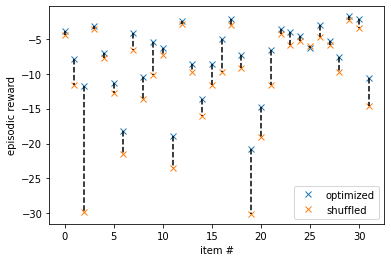

In [96]:
for mode in modes:
    plt.plot(full_episodic_reward[mode],'x')
plt.legend(modes)
plt.xlabel('item #')
plt.ylabel('episodic reward')
for ii in range(config.batch_size):
    plt.plot([ii,ii],
             [full_episodic_reward[modes[0]].numpy()[ii],
              full_episodic_reward[modes[1]].numpy()[ii]],'k--')

In [97]:
print('mean episodic reward in optimized and shuffled modes',[uu[1].numpy().mean() for uu in full_episodic_reward.items()])

mean episodic reward in optimized and shuffled modes [-7.7454357, -10.567774]


/tmp/ipykernel_3273697/1670021264.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


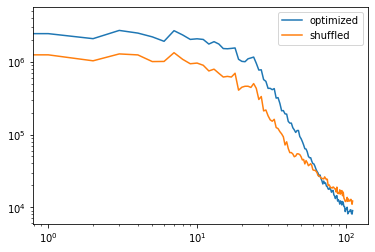

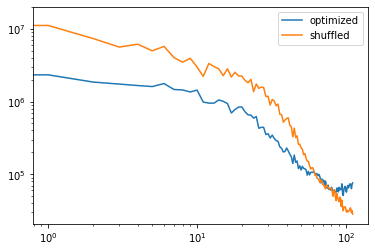

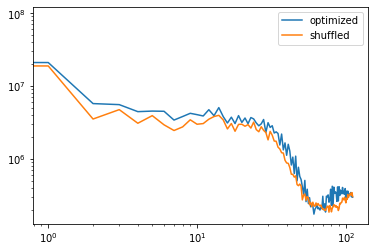

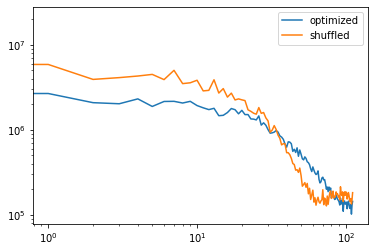

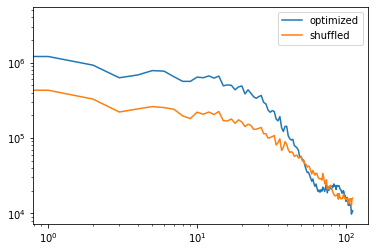

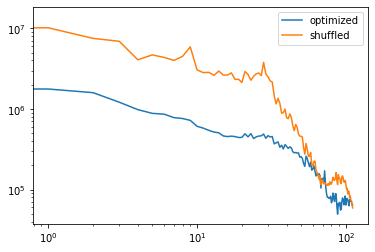

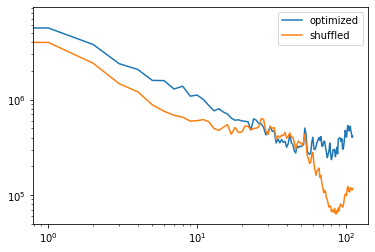

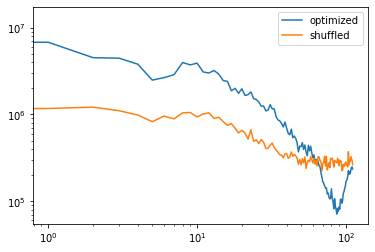

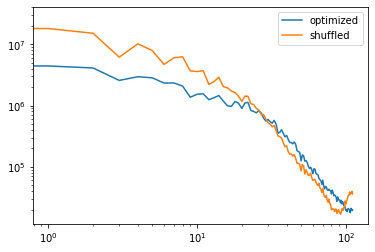

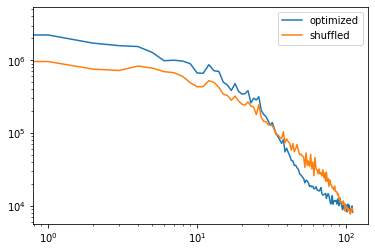

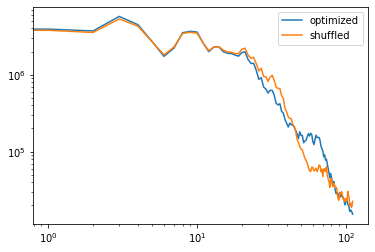

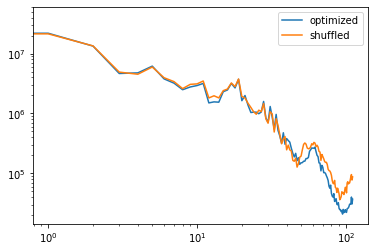

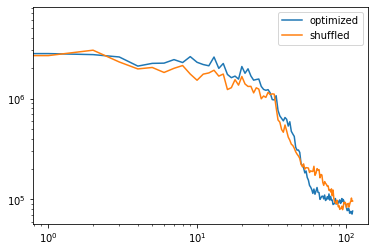

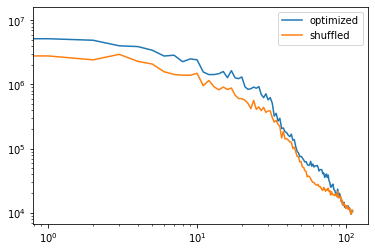

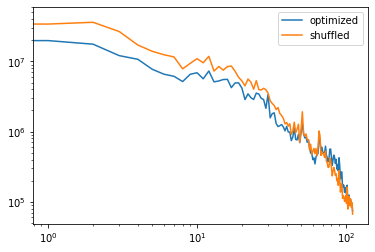

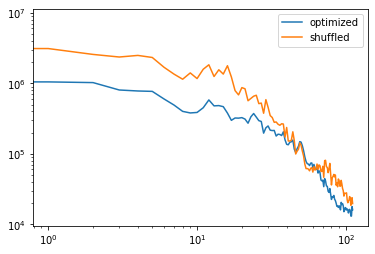

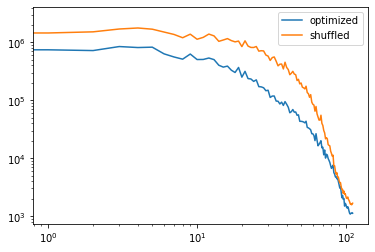

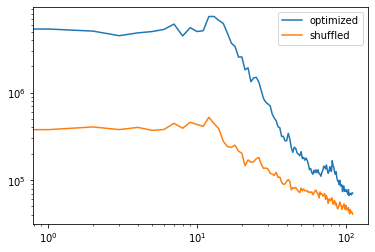

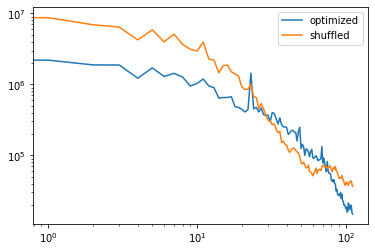

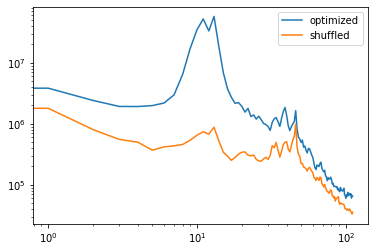

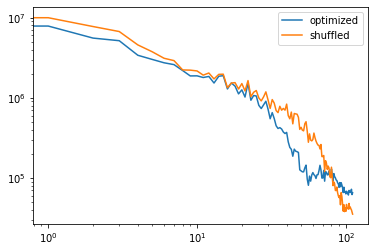

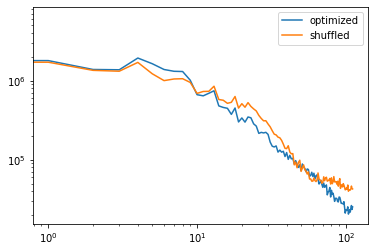

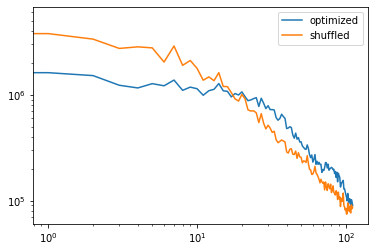

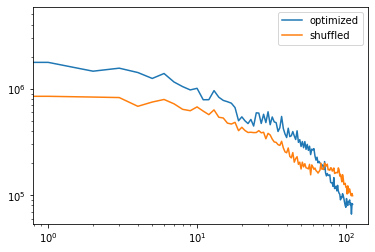

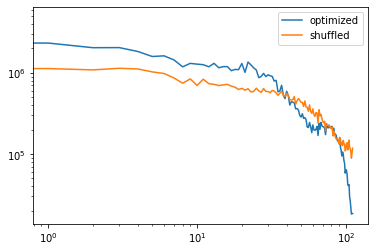

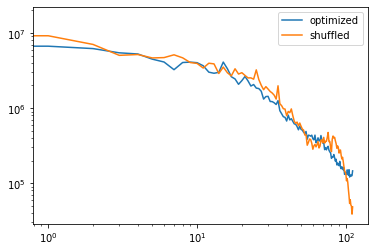

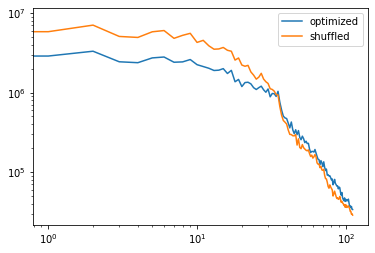

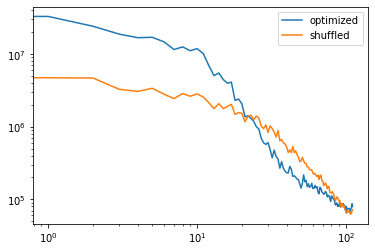

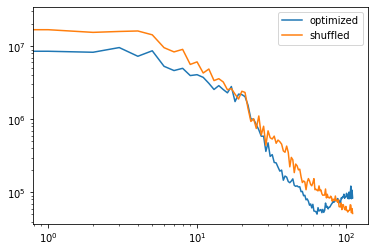

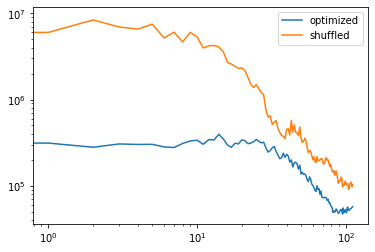

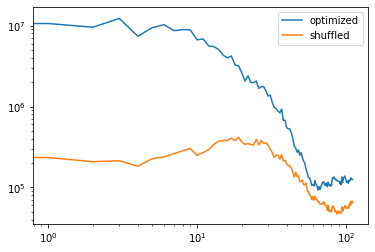

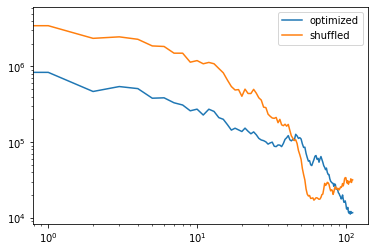

In [98]:
for ii in range(config.batch_size):
    plt.figure()
    for mode in modes:
        plt.loglog(spectral_power_half(retinal_view[mode])[ii])
    plt.legend(modes)

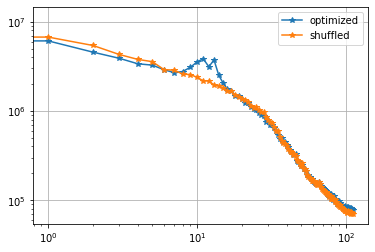

In [99]:
plt.figure()
for mode in modes:
    plt.loglog(spectral_power_half(retinal_view[mode]).mean(axis=0),'*-')
plt.legend(modes)
plt.grid()

/tmp/ipykernel_3273697/923898466.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


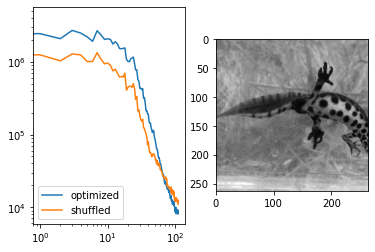

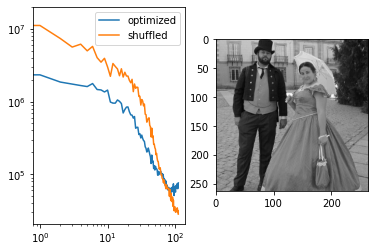

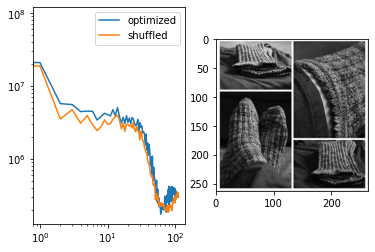

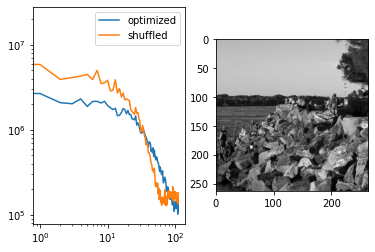

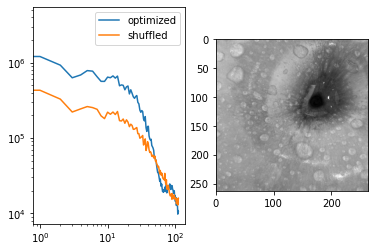

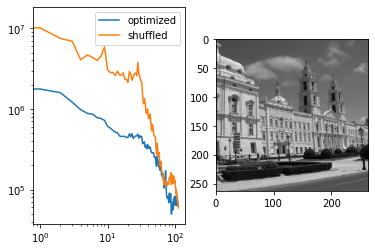

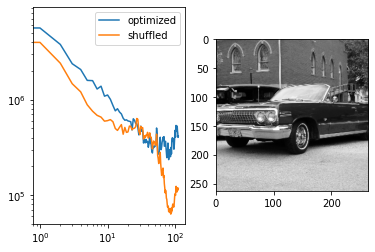

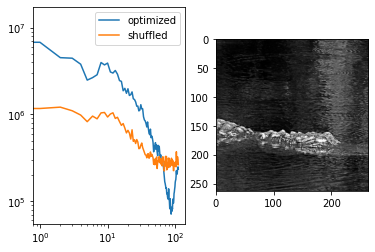

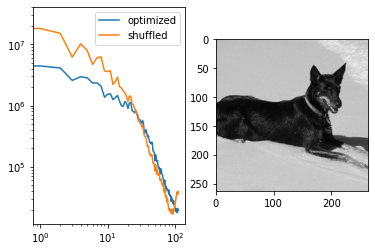

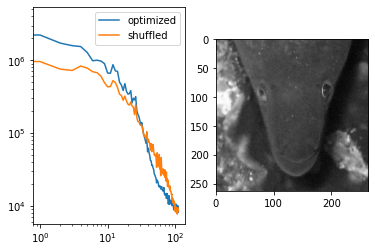

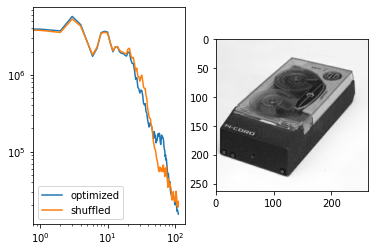

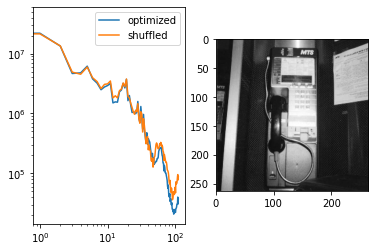

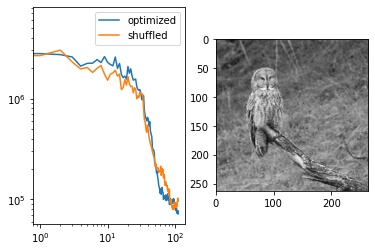

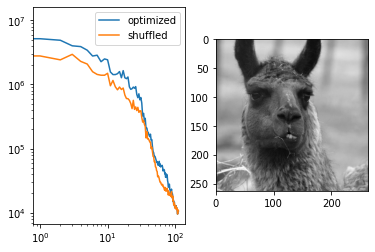

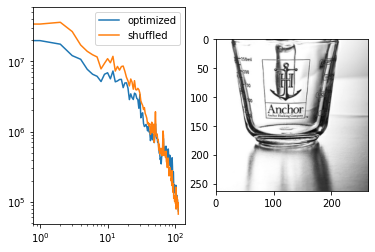

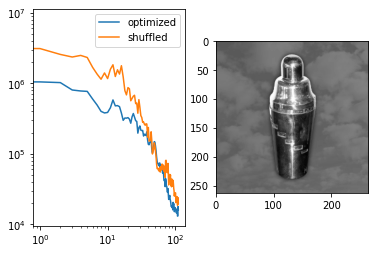

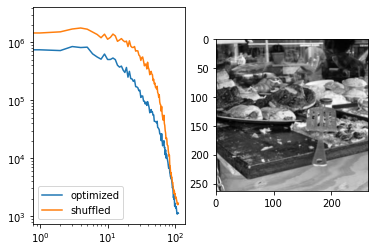

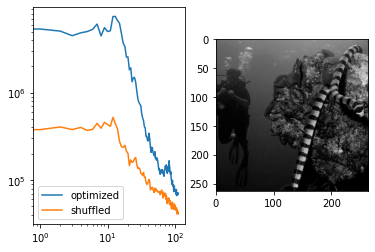

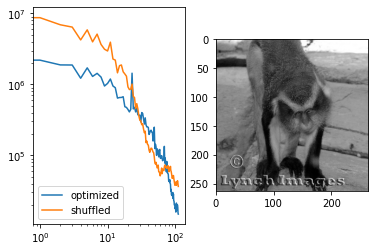

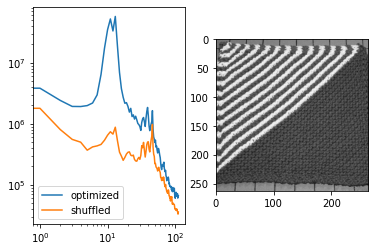

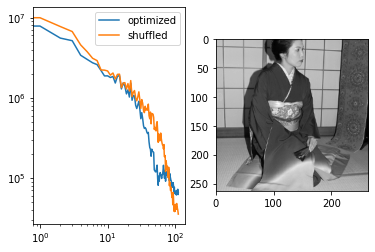

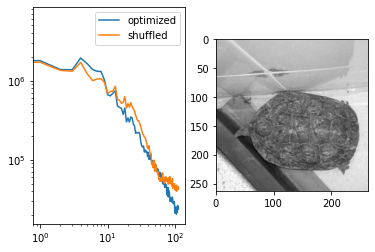

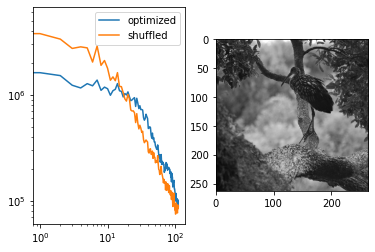

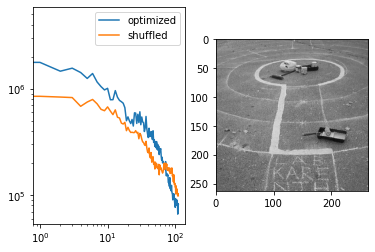

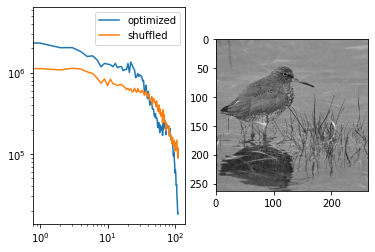

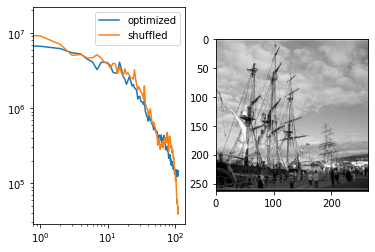

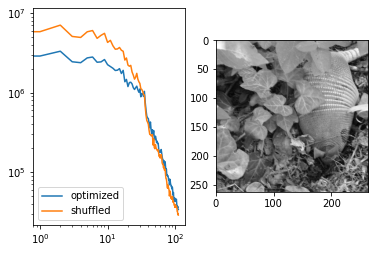

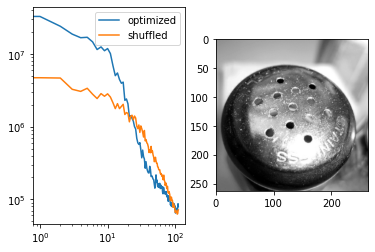

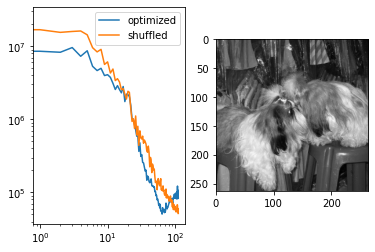

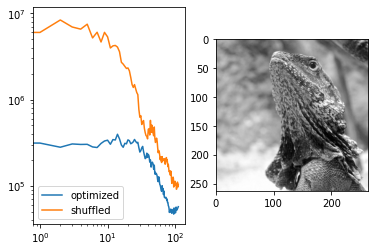

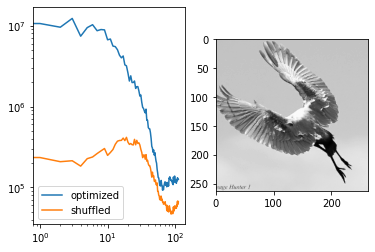

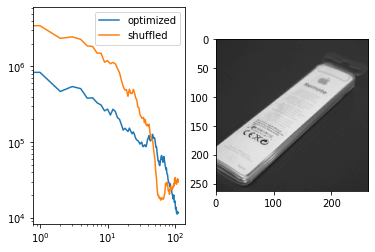

In [100]:
spectral_batch = {uu[0]:spectral_power_half(uu[1]) for uu in retinal_view.items()}
for ii in range(config.batch_size):
    plt.figure()
    plt.subplot(1,2,1)
    for mode in modes:
        plt.loglog(spectral_batch[mode][ii])
    plt.legend(modes)
    plt.subplot(1,2,2)
    plt.imshow(env.images[ii],cmap='gray')


/tmp/ipykernel_3273697/1739467856.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


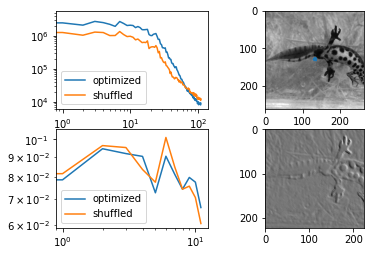

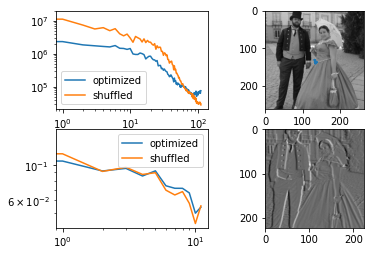

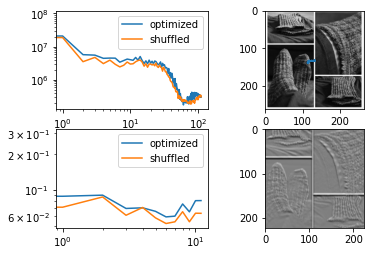

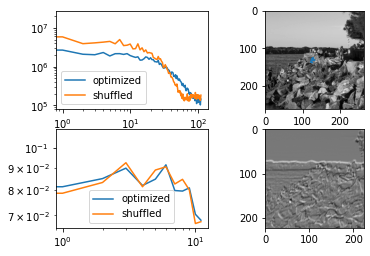

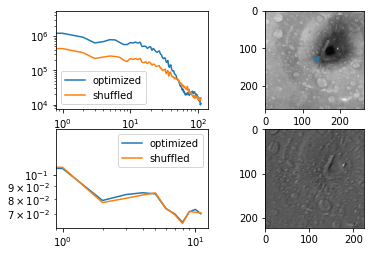

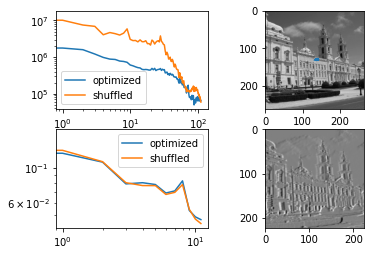

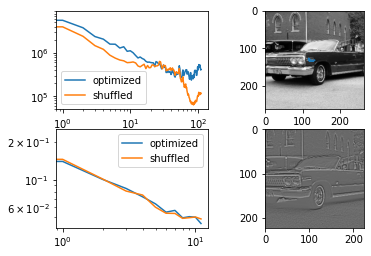

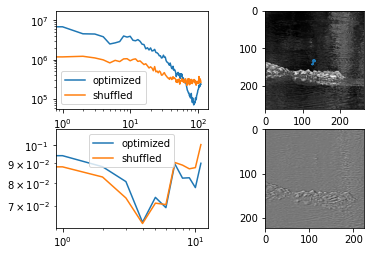

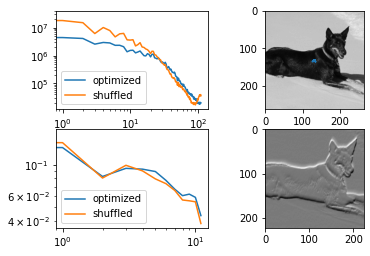

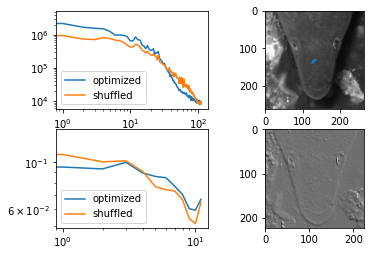

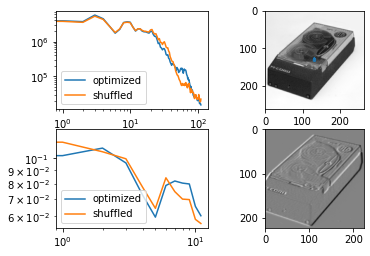

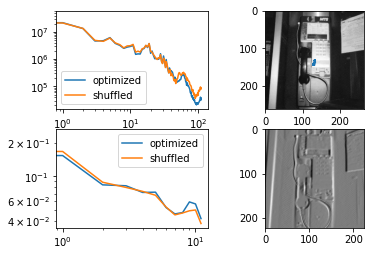

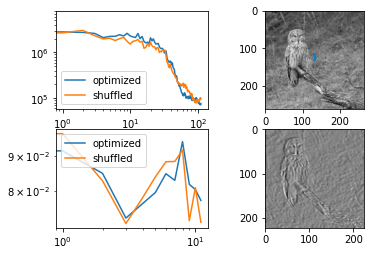

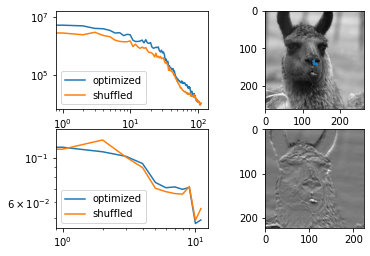

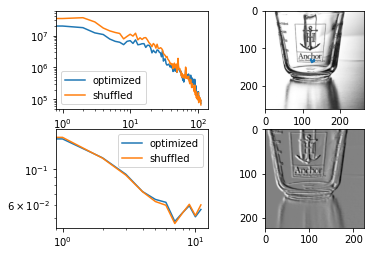

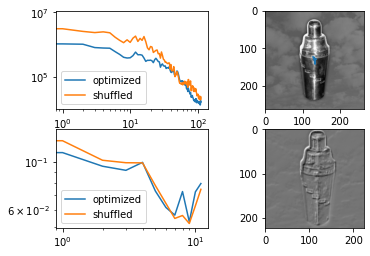

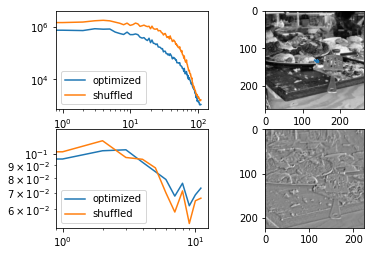

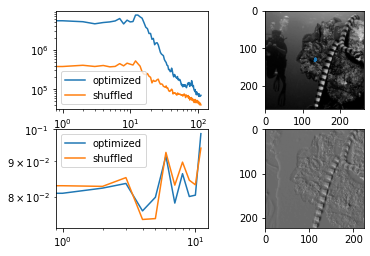

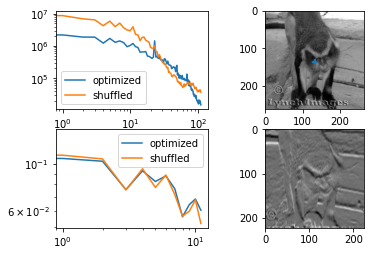

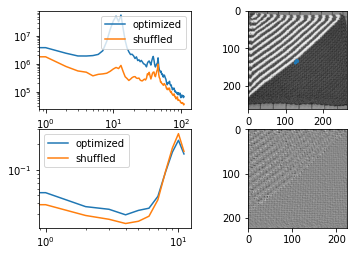

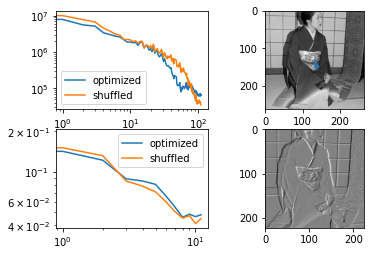

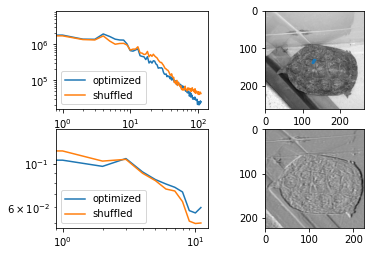

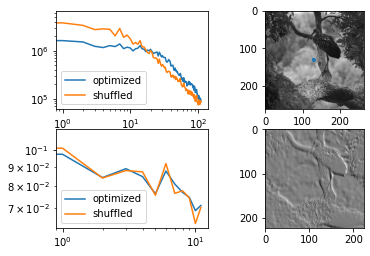

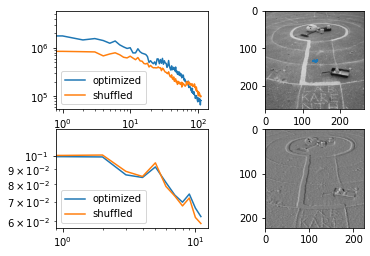

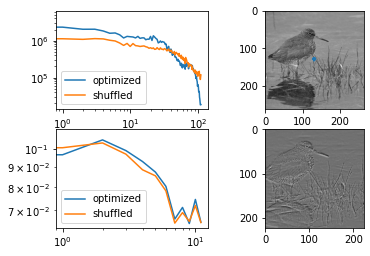

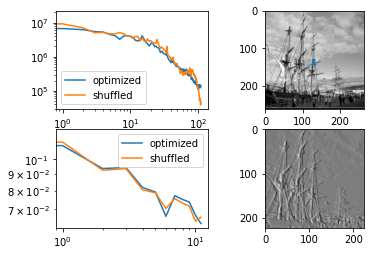

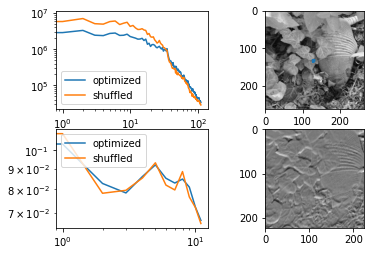

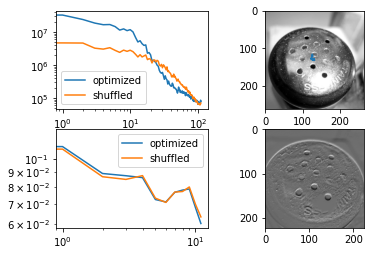

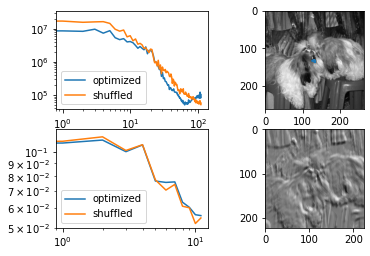

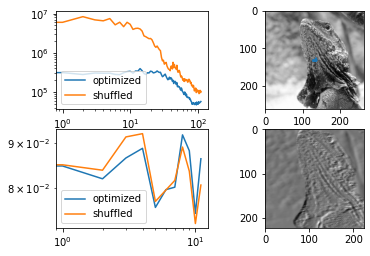

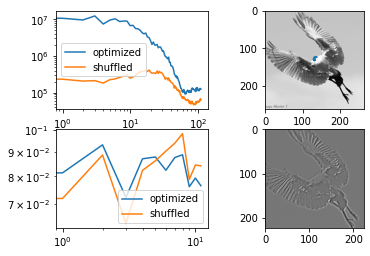

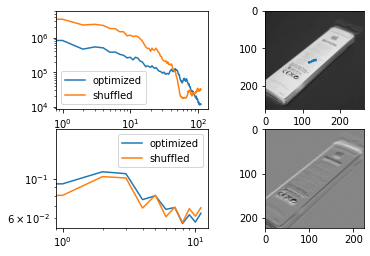

In [101]:
spectral_batch = {uu[0]:spectral_power_half(uu[1]) for uu in retinal_view.items()}
for ii in range(config.batch_size):
    plt.figure()
    plt.subplot(2,2,1)
    for mode in modes:
        plt.loglog(spectral_batch[mode][ii])
    plt.legend(modes)
    plt.subplot(2,2,2)
    plt.imshow(env.images[ii],cmap='gray')
    plt.plot(leading_trajectories[ii,:,1]+config.image_wm//2,leading_trajectories[ii,:,0]+config.image_hm//2)
    
    plt.subplot(2,2,3)
    for mode in modes:
        plt.loglog(spectral_density[mode][ii])
    plt.legend(modes)
    plt.subplot(2,2,4)
    plt.imshow(retinal_view[mode][ii],cmap='gray')

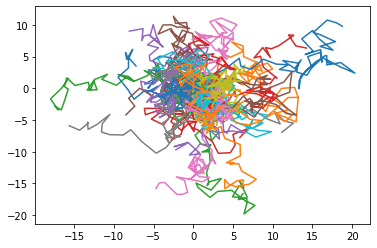

In [102]:
for traj in leading_trajectories:
    plt.plot(traj[:,0], traj[:,1])